## Dependancy Management

In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
!pip install pytorch-metric-learning


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import random_split, TensorDataset, DataLoader, Dataset
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import itertools
import random
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import nbformat
from torchmetrics.image import PeakSignalNoiseRatio
from torch.amp import autocast, GradScaler
from pytorch_metric_learning.samplers import MPerClassSampler
import glob
from sklearn.model_selection import train_test_split
import pandas as pd
from sklearn.metrics import confusion_matrix
import seaborn as sns

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


## Data Processing Pipeline

Labels shape: (610, 340)
Hypercube shape: (610, 340, 103)


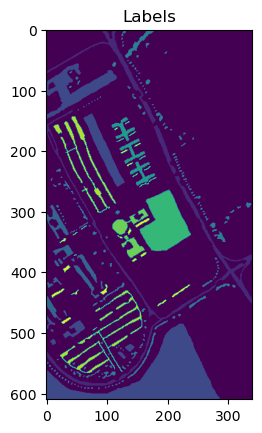

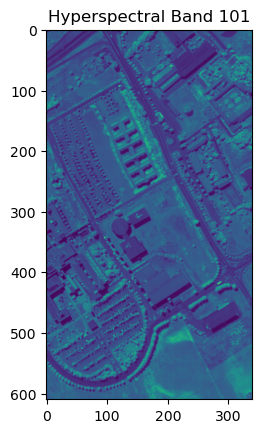

In [5]:
dataset_dir = r"C:\Users\vella\Documents\GitHub\FYP2425_LOCAL\FYP_DATASET"

gt_files = 'PaviaU_gt.mat'
data_files = 'PaviaU.mat'
label_files = 'paviaU_gt'
hypercube_files = 'paviaU'

def extract_Features():
    gt_file = os.path.join(dataset_dir, gt_files)
    data_file = os.path.join(dataset_dir, data_files)

    gt = sio.loadmat(gt_file)
    labels = gt[label_files]

    data = sio.loadmat(data_file)
    hypercube = data[hypercube_files]
    #scaling the data in place and setting to float32 to reduce memory usage
    max_value = np.max(hypercube)
    hypercube = (hypercube / max_value).astype(np.float32)


    #shapes of loaded data
    print(f"Labels shape: {labels.shape}")
    print(f"Hypercube shape: {hypercube.shape}")

    #visualisation of label map and a given band of hyperspectral data
    plt.figure()
    plt.imshow(labels)
    plt.title('Labels')

    band = 101
    plt.figure()
    plt.imshow(hypercube[:,:,band])
    plt.title(f'Hyperspectral Band {band}')
    plt.show()

    return hypercube, labels

hypercube, labels = extract_Features()

In [6]:
def extract_windows(data, labels, window_size):
    extract_windows_save_dir = 'extracted_windows_labels'
    if not os.path.exists(extract_windows_save_dir):
        os.makedirs(extract_windows_save_dir)
        print(f"Created directory: {extract_windows_save_dir}")

    margin = window_size // 2
    padded_data = np.pad(data, ((margin, margin), (margin, margin), (0, 0)), mode='constant')
    padded_labels = np.pad(labels, ((margin, margin), (margin, margin)), mode='constant')

    X_windows = []  #extracted windows
    y_labels = []   #corresponding labels

    print("Starting window extraction...")
    for i in range(margin, padded_data.shape[0] - margin):
        for j in range(margin, padded_data.shape[1] - margin):
            window = padded_data[i-margin:i+margin+1, j-margin:j+margin+1, :]
            label = padded_labels[i, j]

            if label != 0:
                #print('ignoring label 0 (background)')
                X_windows.append(window)
                y_labels.append(label)

    #convertying to numpy arrays
    X_windows = np.array(X_windows)
    y_labels = np.array(y_labels)

    #saving extracted windows and labels
    windows_file = os.path.join(extract_windows_save_dir, 'extracted_windows.npy')
    labels_file = os.path.join(extract_windows_save_dir, 'extracted_labels.npy')

    np.save(windows_file, X_windows)
    np.save(labels_file, y_labels)

    print(f"Saved extracted windows to: {windows_file}")
    print(f"Saved corresponding labels to: {labels_file}")
    print(f"\nTotal windows extracted: {len(X_windows)}")
    print(f"Extracted windows shape: {X_windows.shape}")
    print(f"Corresponding labels shape: {y_labels.shape}")

    return X_windows, y_labels

In [7]:
window_size = 5

X_windows, y_labels = extract_windows(hypercube, labels, window_size)

Created directory: extracted_windows_labels
Starting window extraction...


Saved extracted windows to: extracted_windows_labels\extracted_windows.npy
Saved corresponding labels to: extracted_windows_labels\extracted_labels.npy

Total windows extracted: 42776
Extracted windows shape: (42776, 5, 5, 103)
Corresponding labels shape: (42776,)


In [8]:
def get_samples(X_windows, y_labels, samples_per_class):
    
    indices_save_dir = 'indices'
    if not os.path.exists(indices_save_dir):
        os.makedirs(indices_save_dir)
        print(f"Created directory: {indices_save_dir}")
    
    #get unique classes
    classes = np.unique(y_labels)
    print(f"Unique classes found as: {classes}")

    #init lists
    X_sampled = [] #to store training samples
    y_sampled = [] #to store training labels

    X_val = [] # to store validation samples
    y_val = [] # to store validation labels

    selected_indices_total = [] #to store indices of selected training and validation samples
    validation_selected = [] #temp storage for validation indices
    validation_total = [] #to store all validation indices

    print("\n == STARTING SAMPLING PROCESS ==")
    for cls in classes:
        if cls == 0:
            print(f"!! SKIPPING CLASS 0 !!")
            continue

        #getting the indices for the current class:
        class_indices = np.where(y_labels == cls)[0]
        print(f"Class: {cls}: Found {len(class_indices)} samples")

        # shuffle class-specific indices to ensure randomness
        np.random.shuffle(class_indices)
        print(f"Shuffled class indices for class '{cls}'")

        #select 'samples_per_class' samples for training
        selected_indices = class_indices[:samples_per_class]
        #selecting 5 samples for validation
        validation_selected = class_indices[samples_per_class:samples_per_class+5]

        print(f"Selected {len(selected_indices)} training samples and {len(validation_selected)} validation samples for class '{cls}'\n")

        #store selected indices for training and validation
        selected_indices_total.extend(selected_indices)
        validation_total.extend(validation_selected)

        # appending the selected samples and their labels to the lists
        X_sampled.append(X_windows[selected_indices])
        y_sampled.append(y_labels[selected_indices])

        X_val.append(X_windows[validation_selected])
        y_val.append(y_labels[validation_selected])

    #concat the sampled arrays for training
    X_train = np.vstack(X_sampled)
    y_train = np.hstack(y_sampled)

    # shift labels to start from 0
    y_train = y_train - 1

    print(f"\n -- Training set created with: \n\t{X_train.shape[0]} samples\n\tshape {X_train.shape} --")

    #concat the sampled arrays for validation
    X_val = np.vstack(X_val)
    y_val = np.hstack(y_val)
    y_val = y_val - 1

    print(f"\n -- Validation set created with: \n\t{X_val.shape[0]} samples\n\tshape {X_val.shape} --")

    #create the test set from the remaining data (i.e. that which is not selected for training or validation)
    selected_indices_total.extend(validation_total)

    #getting indices not in the training or val sets
    test_indices = np.setdiff1d(np.arange(X_windows.shape[0]), selected_indices_total)
    X_test = X_windows[test_indices]
    y_test = y_labels[test_indices]
    y_test = y_test - 1

    print(f"\n -- Test set created with: \n\t{X_test.shape[0]} samples\n\tshape {X_test.shape} --\n")

    # Save the datasets to the 'datasets' folder
    np.save(os.path.join(indices_save_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(indices_save_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(indices_save_dir, 'X_val.npy'), X_val)
    np.save(os.path.join(indices_save_dir, 'y_val.npy'), y_val)
    np.save(os.path.join(indices_save_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(indices_save_dir, 'y_test.npy'), y_test)

    print(f"\nAll datasets saved to the '{indices_save_dir}' folder.")

    #return the training, val, test sets + selected indices
    return X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total

In [9]:
X_train, X_test, y_train, y_test, X_val, y_val, selected_indices_total = get_samples(X_windows, y_labels, 40)
print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

Created directory: indices
Unique classes found as: [1 2 3 4 5 6 7 8 9]

 == STARTING SAMPLING PROCESS ==
Class: 1: Found 6631 samples
Shuffled class indices for class '1'
Selected 40 training samples and 5 validation samples for class '1'

Class: 2: Found 18649 samples
Shuffled class indices for class '2'
Selected 40 training samples and 5 validation samples for class '2'

Class: 3: Found 2099 samples
Shuffled class indices for class '3'
Selected 40 training samples and 5 validation samples for class '3'

Class: 4: Found 3064 samples
Shuffled class indices for class '4'
Selected 40 training samples and 5 validation samples for class '4'

Class: 5: Found 1345 samples
Shuffled class indices for class '5'
Selected 40 training samples and 5 validation samples for class '5'

Class: 6: Found 5029 samples
Shuffled class indices for class '6'
Selected 40 training samples and 5 validation samples for class '6'

Class: 7: Found 1330 samples
Shuffled class indices for class '7'
Selected 40 train


All datasets saved to the 'indices' folder.
(360, 5, 5, 103)
(45, 5, 5, 103)
(42371, 5, 5, 103)


In [10]:
class HyperspectralDataset(Dataset):
    def __init__(self, X, y):
        """
        Args:
            X (numpy.ndarray): Hyperspectral data of shape (num_samples, height, width, num_bands).
            y (numpy.ndarray): Labels of shape (num_samples,).
        """
        #converting to pytorch tensor
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [11]:
#loading the saved datasets
X_train = np.load('indices/X_train.npy')
y_train = np.load('indices/y_train.npy')
X_val = np.load('indices/X_val.npy')
y_val = np.load('indices/y_val.npy')
X_test = np.load('indices/X_test.npy')
y_test = np.load('indices/y_test.npy')


#creating pytorch datasets
train_dataset = HyperspectralDataset(X_train, y_train)
val_dataset = HyperspectralDataset(X_val, y_val)
test_dataset = HyperspectralDataset(X_test, y_test)

m = 20
num_classes = len(np.unique(y_train))

#theoretical batch size calc
required_batch_size = m * num_classes  # 10 * 9 = 90

#ensuring batch size doesn't exceed training set size
if required_batch_size > len(train_dataset):
    #case 1: not enough samples - reduce m proportionally
    print("Case 1 applied")
    max_possible_m = len(train_dataset) // num_classes
    m = max(1, max_possible_m)
    batch_size_train = m * num_classes
else:
    #case 2: use full batch size
    print("Case 2 applied")
    batch_size_train = required_batch_size

sampler = MPerClassSampler(labels = y_train, m=m, batch_size = batch_size_train, length_before_new_iter = len(train_dataset))

#dataloaders
train_loader = DataLoader(train_dataset, batch_size = batch_size_train, sampler=sampler)

batch_size = 256
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

#class dist in first batch
for X_batch, y_batch in train_loader:
    unique, counts = np.unique(y_batch.numpy(), return_counts=True)
    print(f"Training batch size: {batch_size_train}")
    print("Class distribution in batch:", dict(zip(unique, counts)))
    break



Case 2 applied
DataLoaders created successfully!
Training batch size: 180
Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}


## Creating directory for saving model predictions

In [12]:
predictions_dir = 'model_predictions'
os.makedirs(predictions_dir, exist_ok=True)
print(f"Created dir: {predictions_dir}")

Created dir: model_predictions


## Creating the Dataset splits and Dataloaders for unsupervised tasks

In [13]:
X_train, X_val = train_test_split(X_windows, test_size=0.2, random_state=42)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (34220, 5, 5, 103)
Validation data shape: (8556, 5, 5, 103)


In [14]:
class UnsupervisedDataset(Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.float32)  #converting to pytorch tensor

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [15]:
#creating datasets for unsupervised task
unsup_train_dataset = UnsupervisedDataset(X_train)
unsup_val_dataset = UnsupervisedDataset(X_val)

#dataloaders for unsupervised task
batch_size = 64
train_loader_cae = DataLoader(unsup_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_cae = DataLoader(unsup_val_dataset, batch_size=batch_size, shuffle=False)

print("DataLoaders created successfully!")

DataLoaders created successfully!


In [16]:
window_num_channels = X_windows.shape[3]
print(window_num_channels)

103


## Convolutional Autoencoder

In [17]:
class ConvAutoEncode(nn.Module):
    def __init__(self, dropout_prob=0.1):
        super(ConvAutoEncode, self).__init__()

        #encoder
        self.encoder = nn.Sequential(
            #Block 1
            nn.Conv2d(window_num_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            #Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            #Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 128, kernel_size=2, stride=2),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Dropout(dropout_prob),

            nn.ConvTranspose2d(64, window_num_channels, kernel_size=3, stride=1, padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded


LOG: Epoch [1/50]


	 Training Batch [1/535], Loss: 0.1209, PSNR: 7.4294


	 Training Batch [200/535], Loss: 0.0644, PSNR: 9.8845


	 Training Batch [400/535], Loss: 0.0352, PSNR: 13.2352


Epoch [1/50] Training Loss: 0.0561, PSNR: 11.1047
	[Val]   Batch [1/134] Loss: 0.0199, PSNR: 15.1969
	[Val]   Batch [10/134] Loss: 0.0177, PSNR: 17.5301
	[Val]   Batch [20/134] Loss: 0.0190, PSNR: 15.3247
	[Val]   Batch [30/134] Loss: 0.0204, PSNR: 14.8323
	[Val]   Batch [40/134] Loss: 0.0186, PSNR: 13.8390
	[Val]   Batch [50/134] Loss: 0.0198, PSNR: 15.0092
	[Val]   Batch [60/134] Loss: 0.0180, PSNR: 15.6438


	[Val]   Batch [70/134] Loss: 0.0171, PSNR: 15.8542
	[Val]   Batch [80/134] Loss: 0.0168, PSNR: 15.8271
	[Val]   Batch [90/134] Loss: 0.0175, PSNR: 15.8365
	[Val]   Batch [100/134] Loss: 0.0198, PSNR: 15.2405
	[Val]   Batch [110/134] Loss: 0.0201, PSNR: 13.7702
	[Val]   Batch [120/134] Loss: 0.0166, PSNR: 14.8935
	[Val]   Batch [130/134] Loss: 0.0183, PSNR: 12.9320
Epoch [1/50] Validation Loss: 0.0190, PSNR: 15.1996

LOG: Epoch [2/50]
	 Training Batch [1/535], Loss: 0.0178, PSNR: 14.3289


	 Training Batch [200/535], Loss: 0.0138, PSNR: 16.8016


	 Training Batch [400/535], Loss: 0.0079, PSNR: 18.9037


Epoch [2/50] Training Loss: 0.0121, PSNR: 17.2543
	[Val]   Batch [1/134] Loss: 0.0090, PSNR: 18.6525
	[Val]   Batch [10/134] Loss: 0.0072, PSNR: 21.3967
	[Val]   Batch [20/134] Loss: 0.0079, PSNR: 19.1276
	[Val]   Batch [30/134] Loss: 0.0089, PSNR: 18.4223
	[Val]   Batch [40/134] Loss: 0.0080, PSNR: 17.4935
	[Val]   Batch [50/134] Loss: 0.0084, PSNR: 18.7435


	[Val]   Batch [60/134] Loss: 0.0073, PSNR: 19.5490
	[Val]   Batch [70/134] Loss: 0.0071, PSNR: 19.6481
	[Val]   Batch [80/134] Loss: 0.0068, PSNR: 19.7476
	[Val]   Batch [90/134] Loss: 0.0072, PSNR: 19.6976
	[Val]   Batch [100/134] Loss: 0.0086, PSNR: 18.8491
	[Val]   Batch [110/134] Loss: 0.0082, PSNR: 17.6791
	[Val]   Batch [120/134] Loss: 0.0062, PSNR: 19.1884


	[Val]   Batch [130/134] Loss: 0.0074, PSNR: 16.8720
Epoch [2/50] Validation Loss: 0.0081, PSNR: 18.8830

LOG: Epoch [3/50]
	 Training Batch [1/535], Loss: 0.0094, PSNR: 18.4488


	 Training Batch [200/535], Loss: 0.0075, PSNR: 19.5122


	 Training Batch [400/535], Loss: 0.0052, PSNR: 20.9655


Epoch [3/50] Training Loss: 0.0070, PSNR: 19.5351
	[Val]   Batch [1/134] Loss: 0.0063, PSNR: 20.1901
	[Val]   Batch [10/134] Loss: 0.0050, PSNR: 23.0394
	[Val]   Batch [20/134] Loss: 0.0054, PSNR: 20.7693
	[Val]   Batch [30/134] Loss: 0.0061, PSNR: 20.0606
	[Val]   Batch [40/134] Loss: 0.0056, PSNR: 19.0361
	[Val]   Batch [50/134] Loss: 0.0057, PSNR: 20.4000
	[Val]   Batch [60/134] Loss: 0.0049, PSNR: 21.2799


	[Val]   Batch [70/134] Loss: 0.0049, PSNR: 21.2640
	[Val]   Batch [80/134] Loss: 0.0046, PSNR: 21.4508
	[Val]   Batch [90/134] Loss: 0.0049, PSNR: 21.3613
	[Val]   Batch [100/134] Loss: 0.0060, PSNR: 20.4393
	[Val]   Batch [110/134] Loss: 0.0054, PSNR: 19.4622
	[Val]   Batch [120/134] Loss: 0.0039, PSNR: 21.1600
	[Val]   Batch [130/134] Loss: 0.0049, PSNR: 18.6182
Epoch [3/50] Validation Loss: 0.0057, PSNR: 20.4814

LOG: Epoch [4/50]
	 Training Batch [1/535], Loss: 0.0073, PSNR: 21.3727


	 Training Batch [200/535], Loss: 0.0058, PSNR: 20.5099


	 Training Batch [400/535], Loss: 0.0055, PSNR: 20.8617


Epoch [4/50] Training Loss: 0.0052, PSNR: 20.8465
	[Val]   Batch [1/134] Loss: 0.0045, PSNR: 21.6522
	[Val]   Batch [10/134] Loss: 0.0036, PSNR: 24.4381
	[Val]   Batch [20/134] Loss: 0.0038, PSNR: 22.3492
	[Val]   Batch [30/134] Loss: 0.0042, PSNR: 21.6541
	[Val]   Batch [40/134] Loss: 0.0039, PSNR: 20.6117
	[Val]   Batch [50/134] Loss: 0.0039, PSNR: 22.0933


	[Val]   Batch [60/134] Loss: 0.0036, PSNR: 22.6594
	[Val]   Batch [70/134] Loss: 0.0035, PSNR: 22.6742
	[Val]   Batch [80/134] Loss: 0.0033, PSNR: 22.8891
	[Val]   Batch [90/134] Loss: 0.0035, PSNR: 22.8435
	[Val]   Batch [100/134] Loss: 0.0043, PSNR: 21.9171
	[Val]   Batch [110/134] Loss: 0.0037, PSNR: 21.1460
	[Val]   Batch [120/134] Loss: 0.0027, PSNR: 22.7682
	[Val]   Batch [130/134] Loss: 0.0033, PSNR: 20.3155


Epoch [4/50] Validation Loss: 0.0040, PSNR: 21.9657

LOG: Epoch [5/50]
	 Training Batch [1/535], Loss: 0.0042, PSNR: 21.9743


	 Training Batch [200/535], Loss: 0.0043, PSNR: 21.6455


	 Training Batch [400/535], Loss: 0.0035, PSNR: 22.7352


Epoch [5/50] Training Loss: 0.0037, PSNR: 22.3095
	[Val]   Batch [1/134] Loss: 0.0032, PSNR: 23.2115
	[Val]   Batch [10/134] Loss: 0.0025, PSNR: 25.9780
	[Val]   Batch [20/134] Loss: 0.0025, PSNR: 24.1483
	[Val]   Batch [30/134] Loss: 0.0028, PSNR: 23.4541
	[Val]   Batch [40/134] Loss: 0.0026, PSNR: 22.4589
	[Val]   Batch [50/134] Loss: 0.0025, PSNR: 24.0420


	[Val]   Batch [60/134] Loss: 0.0026, PSNR: 24.0029
	[Val]   Batch [70/134] Loss: 0.0025, PSNR: 24.1462
	[Val]   Batch [80/134] Loss: 0.0023, PSNR: 24.3679
	[Val]   Batch [90/134] Loss: 0.0025, PSNR: 24.3333
	[Val]   Batch [100/134] Loss: 0.0029, PSNR: 23.5649
	[Val]   Batch [110/134] Loss: 0.0023, PSNR: 23.1812
	[Val]   Batch [120/134] Loss: 0.0018, PSNR: 24.4938
	[Val]   Batch [130/134] Loss: 0.0022, PSNR: 22.1482
Epoch [5/50] Validation Loss: 0.0028, PSNR: 23.5799

LOG: Epoch [6/50]


	 Training Batch [1/535], Loss: 0.0023, PSNR: 22.7187


	 Training Batch [200/535], Loss: 0.0024, PSNR: 24.2283


	 Training Batch [400/535], Loss: 0.0021, PSNR: 23.2709


Epoch [6/50] Training Loss: 0.0029, PSNR: 23.4706
	[Val]   Batch [1/134] Loss: 0.0026, PSNR: 24.1255
	[Val]   Batch [10/134] Loss: 0.0020, PSNR: 26.9601
	[Val]   Batch [20/134] Loss: 0.0019, PSNR: 25.3668
	[Val]   Batch [30/134] Loss: 0.0022, PSNR: 24.5730
	[Val]   Batch [40/134] Loss: 0.0019, PSNR: 23.6684
	[Val]   Batch [50/134] Loss: 0.0019, PSNR: 25.2103


	[Val]   Batch [60/134] Loss: 0.0021, PSNR: 24.9037
	[Val]   Batch [70/134] Loss: 0.0020, PSNR: 25.1188
	[Val]   Batch [80/134] Loss: 0.0019, PSNR: 25.3500
	[Val]   Batch [90/134] Loss: 0.0020, PSNR: 25.2519
	[Val]   Batch [100/134] Loss: 0.0023, PSNR: 24.5882
	[Val]   Batch [110/134] Loss: 0.0017, PSNR: 24.5083
	[Val]   Batch [120/134] Loss: 0.0014, PSNR: 25.7441


	[Val]   Batch [130/134] Loss: 0.0017, PSNR: 23.3030
Epoch [6/50] Validation Loss: 0.0022, PSNR: 24.6142

LOG: Epoch [7/50]
	 Training Batch [1/535], Loss: 0.0025, PSNR: 24.1872


	 Training Batch [200/535], Loss: 0.0031, PSNR: 23.1729


	 Training Batch [400/535], Loss: 0.0029, PSNR: 23.6382


Epoch [7/50] Training Loss: 0.0025, PSNR: 24.1688
	[Val]   Batch [1/134] Loss: 0.0023, PSNR: 24.6010
	[Val]   Batch [10/134] Loss: 0.0018, PSNR: 27.4777
	[Val]   Batch [20/134] Loss: 0.0016, PSNR: 26.0125
	[Val]   Batch [30/134] Loss: 0.0019, PSNR: 25.1614
	[Val]   Batch [40/134] Loss: 0.0017, PSNR: 24.3073
	[Val]   Batch [50/134] Loss: 0.0016, PSNR: 25.8478
	[Val]   Batch [60/134] Loss: 0.0019, PSNR: 25.3740


	[Val]   Batch [70/134] Loss: 0.0018, PSNR: 25.6262
	[Val]   Batch [80/134] Loss: 0.0017, PSNR: 25.8929
	[Val]   Batch [90/134] Loss: 0.0018, PSNR: 25.7245
	[Val]   Batch [100/134] Loss: 0.0020, PSNR: 25.1374
	[Val]   Batch [110/134] Loss: 0.0015, PSNR: 25.1902
	[Val]   Batch [120/134] Loss: 0.0012, PSNR: 26.4079
	[Val]   Batch [130/134] Loss: 0.0015, PSNR: 23.8377
Epoch [7/50] Validation Loss: 0.0020, PSNR: 25.1607

LOG: Epoch [8/50]


	 Training Batch [1/535], Loss: 0.0022, PSNR: 24.5339


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.6958


	 Training Batch [400/535], Loss: 0.0019, PSNR: 25.3553


Epoch [8/50] Training Loss: 0.0022, PSNR: 24.6289
	[Val]   Batch [1/134] Loss: 0.0020, PSNR: 25.1186
	[Val]   Batch [10/134] Loss: 0.0016, PSNR: 28.0101
	[Val]   Batch [20/134] Loss: 0.0014, PSNR: 26.7646
	[Val]   Batch [30/134] Loss: 0.0016, PSNR: 25.8286
	[Val]   Batch [40/134] Loss: 0.0014, PSNR: 25.0389
	[Val]   Batch [50/134] Loss: 0.0014, PSNR: 26.5503
	[Val]   Batch [60/134] Loss: 0.0017, PSNR: 25.9208


	[Val]   Batch [70/134] Loss: 0.0016, PSNR: 26.1646
	[Val]   Batch [80/134] Loss: 0.0014, PSNR: 26.4773
	[Val]   Batch [90/134] Loss: 0.0016, PSNR: 26.2581
	[Val]   Batch [100/134] Loss: 0.0018, PSNR: 25.7569
	[Val]   Batch [110/134] Loss: 0.0012, PSNR: 25.9991
	[Val]   Batch [120/134] Loss: 0.0010, PSNR: 27.1418
	[Val]   Batch [130/134] Loss: 0.0013, PSNR: 24.5102
Epoch [8/50] Validation Loss: 0.0017, PSNR: 25.7804

LOG: Epoch [9/50]
	 Training Batch [1/535], Loss: 0.0028, PSNR: 23.6151


	 Training Batch [200/535], Loss: 0.0017, PSNR: 24.2440


	 Training Batch [400/535], Loss: 0.0026, PSNR: 23.7672


Epoch [9/50] Training Loss: 0.0020, PSNR: 24.9829
	[Val]   Batch [1/134] Loss: 0.0019, PSNR: 25.4172
	[Val]   Batch [10/134] Loss: 0.0015, PSNR: 28.3071
	[Val]   Batch [20/134] Loss: 0.0012, PSNR: 27.2259
	[Val]   Batch [30/134] Loss: 0.0015, PSNR: 26.2438
	[Val]   Batch [40/134] Loss: 0.0013, PSNR: 25.4810
	[Val]   Batch [50/134] Loss: 0.0013, PSNR: 26.9330
	[Val]   Batch [60/134] Loss: 0.0016, PSNR: 26.2684


	[Val]   Batch [70/134] Loss: 0.0015, PSNR: 26.4891
	[Val]   Batch [80/134] Loss: 0.0013, PSNR: 26.8373
	[Val]   Batch [90/134] Loss: 0.0015, PSNR: 26.5788
	[Val]   Batch [100/134] Loss: 0.0016, PSNR: 26.1246
	[Val]   Batch [110/134] Loss: 0.0011, PSNR: 26.4623
	[Val]   Batch [120/134] Loss: 0.0009, PSNR: 27.5909
	[Val]   Batch [130/134] Loss: 0.0012, PSNR: 24.9345
Epoch [9/50] Validation Loss: 0.0016, PSNR: 26.1512

LOG: Epoch [10/50]
	 Training Batch [1/535], Loss: 0.0017, PSNR: 25.8154


	 Training Batch [200/535], Loss: 0.0015, PSNR: 25.0624


	 Training Batch [400/535], Loss: 0.0024, PSNR: 26.1710


Epoch [10/50] Training Loss: 0.0019, PSNR: 25.2551
	[Val]   Batch [1/134] Loss: 0.0018, PSNR: 25.6896
	[Val]   Batch [10/134] Loss: 0.0014, PSNR: 28.6226
	[Val]   Batch [20/134] Loss: 0.0011, PSNR: 27.6209
	[Val]   Batch [30/134] Loss: 0.0014, PSNR: 26.6000
	[Val]   Batch [40/134] Loss: 0.0012, PSNR: 25.8686
	[Val]   Batch [50/134] Loss: 0.0012, PSNR: 27.2999
	[Val]   Batch [60/134] Loss: 0.0015, PSNR: 26.5583


	[Val]   Batch [70/134] Loss: 0.0014, PSNR: 26.7840
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.1570
	[Val]   Batch [90/134] Loss: 0.0014, PSNR: 26.8699
	[Val]   Batch [100/134] Loss: 0.0015, PSNR: 26.4753
	[Val]   Batch [110/134] Loss: 0.0010, PSNR: 26.9300
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.0172
	[Val]   Batch [130/134] Loss: 0.0011, PSNR: 25.2907
Epoch [10/50] Validation Loss: 0.0015, PSNR: 26.4983

LOG: Epoch [11/50]
	 Training Batch [1/535], Loss: 0.0014, PSNR: 26.7160


	 Training Batch [200/535], Loss: 0.0016, PSNR: 25.9204


	 Training Batch [400/535], Loss: 0.0015, PSNR: 24.5243


Epoch [11/50] Training Loss: 0.0018, PSNR: 25.4661
	[Val]   Batch [1/134] Loss: 0.0017, PSNR: 25.8752
	[Val]   Batch [10/134] Loss: 0.0013, PSNR: 28.8216
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 27.8999
	[Val]   Batch [30/134] Loss: 0.0013, PSNR: 26.8340
	[Val]   Batch [40/134] Loss: 0.0011, PSNR: 26.1234
	[Val]   Batch [50/134] Loss: 0.0011, PSNR: 27.5244
	[Val]   Batch [60/134] Loss: 0.0014, PSNR: 26.7707


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 26.9778
	[Val]   Batch [80/134] Loss: 0.0012, PSNR: 27.4026
	[Val]   Batch [90/134] Loss: 0.0013, PSNR: 27.0897
	[Val]   Batch [100/134] Loss: 0.0014, PSNR: 26.6962
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.1992
	[Val]   Batch [120/134] Loss: 0.0008, PSNR: 28.2656
	[Val]   Batch [130/134] Loss: 0.0010, PSNR: 25.5355
Epoch [11/50] Validation Loss: 0.0014, PSNR: 26.7310

LOG: Epoch [12/50]
	 Training Batch [1/535], Loss: 0.0027, PSNR: 24.0924


	 Training Batch [200/535], Loss: 0.0017, PSNR: 25.9459


	 Training Batch [400/535], Loss: 0.0015, PSNR: 26.4959


Epoch [12/50] Training Loss: 0.0017, PSNR: 25.7290
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.0668
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.0649
	[Val]   Batch [20/134] Loss: 0.0010, PSNR: 28.1807
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.0766
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.3948
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.7765
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.0363


	[Val]   Batch [70/134] Loss: 0.0013, PSNR: 27.2047
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.6476
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.3226
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 26.9282
	[Val]   Batch [110/134] Loss: 0.0009, PSNR: 27.4963
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.5889
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 25.7943
Epoch [12/50] Validation Loss: 0.0013, PSNR: 26.9773

LOG: Epoch [13/50]
	 Training Batch [1/535], Loss: 0.0013, PSNR: 26.9381


	 Training Batch [200/535], Loss: 0.0021, PSNR: 24.9190


	 Training Batch [400/535], Loss: 0.0020, PSNR: 25.2962


Epoch [13/50] Training Loss: 0.0017, PSNR: 25.8792
	[Val]   Batch [1/134] Loss: 0.0016, PSNR: 26.2305
	[Val]   Batch [10/134] Loss: 0.0012, PSNR: 29.1992
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.3835
	[Val]   Batch [30/134] Loss: 0.0012, PSNR: 27.2601
	[Val]   Batch [40/134] Loss: 0.0010, PSNR: 26.6380
	[Val]   Batch [50/134] Loss: 0.0010, PSNR: 27.9457
	[Val]   Batch [60/134] Loss: 0.0013, PSNR: 27.1827


	[Val]   Batch [70/134] Loss: 0.0012, PSNR: 27.3723
	[Val]   Batch [80/134] Loss: 0.0011, PSNR: 27.8182
	[Val]   Batch [90/134] Loss: 0.0012, PSNR: 27.4725
	[Val]   Batch [100/134] Loss: 0.0013, PSNR: 27.1170
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.7004
	[Val]   Batch [120/134] Loss: 0.0007, PSNR: 28.7697
	[Val]   Batch [130/134] Loss: 0.0009, PSNR: 26.0102


Epoch [13/50] Validation Loss: 0.0013, PSNR: 27.1616

LOG: Epoch [14/50]
	 Training Batch [1/535], Loss: 0.0019, PSNR: 25.4307


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6634


	 Training Batch [400/535], Loss: 0.0023, PSNR: 24.6395


Epoch [14/50] Training Loss: 0.0016, PSNR: 26.0368
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.4504
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.4288
	[Val]   Batch [20/134] Loss: 0.0009, PSNR: 28.7426
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.5151
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 26.9196
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2136


	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.4476
	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.6092
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.0962
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.7166
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.3461
	[Val]   Batch [110/134] Loss: 0.0008, PSNR: 27.9890
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.0627
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.3040
Epoch [14/50] Validation Loss: 0.0012, PSNR: 27.4227

LOG: Epoch [15/50]


	 Training Batch [1/535], Loss: 0.0011, PSNR: 26.0744


	 Training Batch [200/535], Loss: 0.0021, PSNR: 26.8456


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.6227


Epoch [15/50] Training Loss: 0.0015, PSNR: 26.1598
	[Val]   Batch [1/134] Loss: 0.0015, PSNR: 26.5424
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.5286
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 28.8546
	[Val]   Batch [30/134] Loss: 0.0011, PSNR: 27.6245
	[Val]   Batch [40/134] Loss: 0.0009, PSNR: 27.0378
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.2900
	[Val]   Batch [60/134] Loss: 0.0012, PSNR: 27.5573


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.7124
	[Val]   Batch [80/134] Loss: 0.0010, PSNR: 28.2071
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 27.8238
	[Val]   Batch [100/134] Loss: 0.0012, PSNR: 27.4565
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.0830
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.1542
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.4119


Epoch [15/50] Validation Loss: 0.0012, PSNR: 27.5286

LOG: Epoch [16/50]
	 Training Batch [1/535], Loss: 0.0023, PSNR: 26.2931


	 Training Batch [200/535], Loss: 0.0018, PSNR: 25.4609


	 Training Batch [400/535], Loss: 0.0024, PSNR: 24.4521


Epoch [16/50] Training Loss: 0.0015, PSNR: 26.3718
	[Val]   Batch [1/134] Loss: 0.0014, PSNR: 26.7185
	[Val]   Batch [10/134] Loss: 0.0011, PSNR: 29.7335
	[Val]   Batch [20/134] Loss: 0.0008, PSNR: 29.1333
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 27.8387
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.2764
	[Val]   Batch [50/134] Loss: 0.0009, PSNR: 28.5410
	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.7706


	[Val]   Batch [70/134] Loss: 0.0011, PSNR: 27.9039
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.4568
	[Val]   Batch [90/134] Loss: 0.0011, PSNR: 28.0505
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.6540
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.3564
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.3953
	[Val]   Batch [130/134] Loss: 0.0008, PSNR: 26.6217
Epoch [16/50] Validation Loss: 0.0011, PSNR: 27.7512

LOG: Epoch [17/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.2768


	 Training Batch [200/535], Loss: 0.0014, PSNR: 26.6882


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.1119


Epoch [17/50] Training Loss: 0.0014, PSNR: 26.5260
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 26.9008
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 29.8859
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.3677
	[Val]   Batch [30/134] Loss: 0.0010, PSNR: 28.0325
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.5078
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.7419


	[Val]   Batch [60/134] Loss: 0.0011, PSNR: 27.9843
	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.1225
	[Val]   Batch [80/134] Loss: 0.0009, PSNR: 28.6416
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.2414
	[Val]   Batch [100/134] Loss: 0.0011, PSNR: 27.8570
	[Val]   Batch [110/134] Loss: 0.0007, PSNR: 28.5700
	[Val]   Batch [120/134] Loss: 0.0006, PSNR: 29.5896
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 26.8475
Epoch [17/50] Validation Loss: 0.0011, PSNR: 27.9480

LOG: Epoch [18/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.3185


	 Training Batch [200/535], Loss: 0.0016, PSNR: 26.2359


	 Training Batch [400/535], Loss: 0.0022, PSNR: 26.1973


Epoch [18/50] Training Loss: 0.0014, PSNR: 26.6078
	[Val]   Batch [1/134] Loss: 0.0013, PSNR: 27.0885
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.0690
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.6631
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.2584
	[Val]   Batch [40/134] Loss: 0.0008, PSNR: 27.7833
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 28.9739
	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.2111


	[Val]   Batch [70/134] Loss: 0.0010, PSNR: 28.3192
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.8620
	[Val]   Batch [90/134] Loss: 0.0010, PSNR: 28.4335
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.0741
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8027
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.8135
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.0646
Epoch [18/50] Validation Loss: 0.0010, PSNR: 28.1685

LOG: Epoch [19/50]
	 Training Batch [1/535], Loss: 0.0016, PSNR: 26.2760


	 Training Batch [200/535], Loss: 0.0010, PSNR: 28.0111


	 Training Batch [400/535], Loss: 0.0016, PSNR: 26.0811


Epoch [19/50] Training Loss: 0.0013, PSNR: 26.7968
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.2322
	[Val]   Batch [10/134] Loss: 0.0010, PSNR: 30.1024
	[Val]   Batch [20/134] Loss: 0.0007, PSNR: 29.7726
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.3999
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 27.8510
	[Val]   Batch [50/134] Loss: 0.0008, PSNR: 29.0700


	[Val]   Batch [60/134] Loss: 0.0010, PSNR: 28.3360
	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.4234
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 28.9460
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.5522
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.1780
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.8432
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 29.7671


	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.1728
Epoch [19/50] Validation Loss: 0.0010, PSNR: 28.2664

LOG: Epoch [20/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.9074


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.3223


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5695


Epoch [20/50] Training Loss: 0.0013, PSNR: 26.8984
	[Val]   Batch [1/134] Loss: 0.0012, PSNR: 27.4571
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.2689
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.0573
	[Val]   Batch [30/134] Loss: 0.0009, PSNR: 28.6009
	[Val]   Batch [40/134] Loss: 0.0007, PSNR: 28.0750
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.2261
	[Val]   Batch [60/134] Loss: 0.0009, PSNR: 28.6091


	[Val]   Batch [70/134] Loss: 0.0009, PSNR: 28.7214
	[Val]   Batch [80/134] Loss: 0.0008, PSNR: 29.2163
	[Val]   Batch [90/134] Loss: 0.0009, PSNR: 28.8008
	[Val]   Batch [100/134] Loss: 0.0010, PSNR: 28.3836
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 28.9908
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.0468
	[Val]   Batch [130/134] Loss: 0.0007, PSNR: 27.4029
Epoch [20/50] Validation Loss: 0.0009, PSNR: 28.4732

LOG: Epoch [21/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.3837


	 Training Batch [200/535], Loss: 0.0012, PSNR: 27.3086


	 Training Batch [400/535], Loss: 0.0007, PSNR: 28.3283


Epoch [21/50] Training Loss: 0.0013, PSNR: 27.0891
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.7025
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.4439
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.4189
	[Val]   Batch [30/134] Loss: 0.0008, PSNR: 28.9235
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.4232
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.5473
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 28.9195


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.0293
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.4759
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.0928
	[Val]   Batch [100/134] Loss: 0.0009, PSNR: 28.7016
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.2554
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2031
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.7477
Epoch [21/50] Validation Loss: 0.0009, PSNR: 28.7661

LOG: Epoch [22/50]
	 Training Batch [1/535], Loss: 0.0012, PSNR: 27.4099


	 Training Batch [200/535], Loss: 0.0011, PSNR: 27.5895


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.3384


Epoch [22/50] Training Loss: 0.0012, PSNR: 27.3048
	[Val]   Batch [1/134] Loss: 0.0011, PSNR: 27.9434
	[Val]   Batch [10/134] Loss: 0.0009, PSNR: 30.6227
	[Val]   Batch [20/134] Loss: 0.0006, PSNR: 30.6887
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.1896
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.6060
	[Val]   Batch [50/134] Loss: 0.0007, PSNR: 29.7611
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.1903


	[Val]   Batch [70/134] Loss: 0.0008, PSNR: 29.2844
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.6788
	[Val]   Batch [90/134] Loss: 0.0008, PSNR: 29.3661
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 28.9465
	[Val]   Batch [110/134] Loss: 0.0006, PSNR: 29.4016
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.3608
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 27.9325
Epoch [22/50] Validation Loss: 0.0008, PSNR: 28.9809

LOG: Epoch [23/50]


	 Training Batch [1/535], Loss: 0.0009, PSNR: 28.2571


	 Training Batch [200/535], Loss: 0.0015, PSNR: 26.5078


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.5565


Epoch [23/50] Training Loss: 0.0012, PSNR: 27.4338
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.1004
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.7161
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 30.7657
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.3328
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.7655
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 29.8995
	[Val]   Batch [60/134] Loss: 0.0008, PSNR: 29.3084


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.4568
	[Val]   Batch [80/134] Loss: 0.0007, PSNR: 29.8209
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.5305
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.1281
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.4036
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.2968
	[Val]   Batch [130/134] Loss: 0.0006, PSNR: 28.0709
Epoch [23/50] Validation Loss: 0.0008, PSNR: 29.1174

LOG: Epoch [24/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 27.0527


	 Training Batch [200/535], Loss: 0.0009, PSNR: 28.5203


	 Training Batch [400/535], Loss: 0.0012, PSNR: 27.3309


Epoch [24/50] Training Loss: 0.0011, PSNR: 27.5858
	[Val]   Batch [1/134] Loss: 0.0010, PSNR: 28.3543
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 30.9013
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.0580
	[Val]   Batch [30/134] Loss: 0.0007, PSNR: 29.5773
	[Val]   Batch [40/134] Loss: 0.0006, PSNR: 28.9012
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.1268
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.6005


	[Val]   Batch [70/134] Loss: 0.0007, PSNR: 29.7050
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.0934
	[Val]   Batch [90/134] Loss: 0.0007, PSNR: 29.8075
	[Val]   Batch [100/134] Loss: 0.0008, PSNR: 29.3778
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.5580
	[Val]   Batch [120/134] Loss: 0.0005, PSNR: 30.4176
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.2177
Epoch [24/50] Validation Loss: 0.0008, PSNR: 29.3391

LOG: Epoch [25/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 26.9845


	 Training Batch [200/535], Loss: 0.0009, PSNR: 26.6300


	 Training Batch [400/535], Loss: 0.0011, PSNR: 27.9254


Epoch [25/50] Training Loss: 0.0011, PSNR: 27.7392
	[Val]   Batch [1/134] Loss: 0.0009, PSNR: 28.6704
	[Val]   Batch [10/134] Loss: 0.0008, PSNR: 31.1527
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.3476
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 29.9767
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.2900
	[Val]   Batch [50/134] Loss: 0.0006, PSNR: 30.5058
	[Val]   Batch [60/134] Loss: 0.0007, PSNR: 29.9399


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.0723
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.4117
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.2046
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.7754
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.8610
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.6709


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.5949
Epoch [25/50] Validation Loss: 0.0007, PSNR: 29.6907

LOG: Epoch [26/50]
	 Training Batch [1/535], Loss: 0.0011, PSNR: 27.4225


	 Training Batch [200/535], Loss: 0.0008, PSNR: 29.2621


	 Training Batch [400/535], Loss: 0.0008, PSNR: 27.6532


Epoch [26/50] Training Loss: 0.0010, PSNR: 27.9077
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 28.9171
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.3347
	[Val]   Batch [20/134] Loss: 0.0005, PSNR: 31.5689
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.2367
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4034
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.7140
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.1313


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.3122
	[Val]   Batch [80/134] Loss: 0.0006, PSNR: 30.6086
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.4155
	[Val]   Batch [100/134] Loss: 0.0007, PSNR: 29.9908
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9414
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7279


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.6850
Epoch [26/50] Validation Loss: 0.0007, PSNR: 29.8822

LOG: Epoch [27/50]
	 Training Batch [1/535], Loss: 0.0009, PSNR: 30.3735


	 Training Batch [200/535], Loss: 0.0014, PSNR: 28.4572


	 Training Batch [400/535], Loss: 0.0013, PSNR: 27.9446


Epoch [27/50] Training Loss: 0.0010, PSNR: 28.0896
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.0934
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.4543
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.6318
	[Val]   Batch [30/134] Loss: 0.0006, PSNR: 30.3848
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.4359
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.8431
	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.2148


	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.4776
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.7294
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.5940
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.1730
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 29.9456
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7239
	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.7406
Epoch [27/50] Validation Loss: 0.0006, PSNR: 30.0080

LOG: Epoch [28/50]
	 Training Batch [1/535], Loss: 0.0010, PSNR: 28.4119


	 Training Batch [200/535], Loss: 0.0007, PSNR: 27.6875


	 Training Batch [400/535], Loss: 0.0014, PSNR: 26.8788


Epoch [28/50] Training Loss: 0.0010, PSNR: 28.2031
	[Val]   Batch [1/134] Loss: 0.0008, PSNR: 29.3327
	[Val]   Batch [10/134] Loss: 0.0007, PSNR: 31.6120
	[Val]   Batch [20/134] Loss: 0.0004, PSNR: 31.7127
	[Val]   Batch [30/134] Loss: 0.0005, PSNR: 30.5943
	[Val]   Batch [40/134] Loss: 0.0005, PSNR: 29.5552
	[Val]   Batch [50/134] Loss: 0.0005, PSNR: 30.9913


	[Val]   Batch [60/134] Loss: 0.0006, PSNR: 30.3576
	[Val]   Batch [70/134] Loss: 0.0006, PSNR: 30.6373
	[Val]   Batch [80/134] Loss: 0.0005, PSNR: 30.8932
	[Val]   Batch [90/134] Loss: 0.0006, PSNR: 30.7992
	[Val]   Batch [100/134] Loss: 0.0006, PSNR: 30.3594
	[Val]   Batch [110/134] Loss: 0.0005, PSNR: 30.0308
	[Val]   Batch [120/134] Loss: 0.0004, PSNR: 30.7723


	[Val]   Batch [130/134] Loss: 0.0005, PSNR: 28.8497
Epoch [28/50] Validation Loss: 0.0006, PSNR: 30.1778
Early stopping triggered at epoch 28. No improvement for 3 epochs.


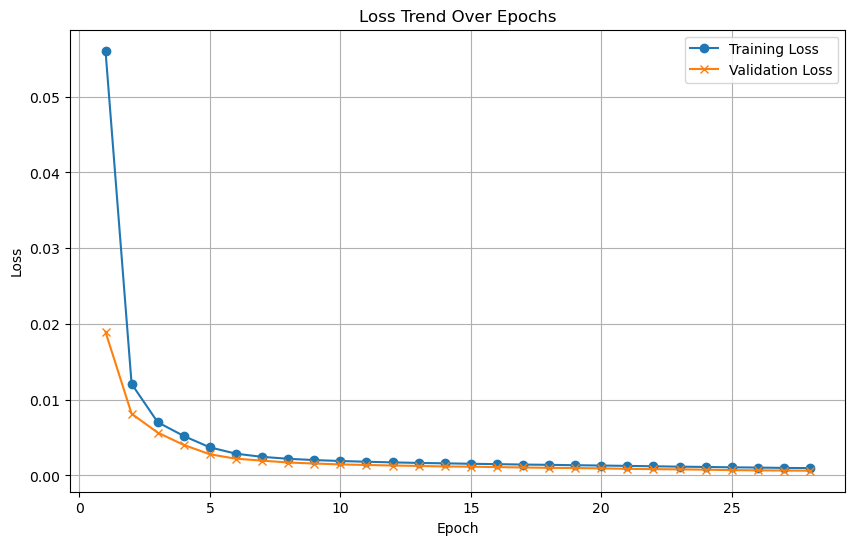

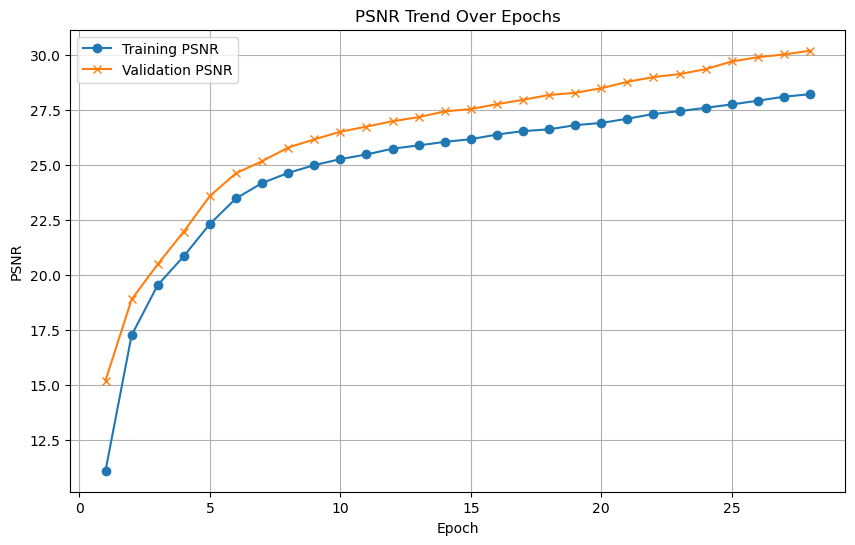

In [18]:
model_cae = ConvAutoEncode()
criterion_cae = nn.MSELoss()
optimizer_cae = optim.Adam(model_cae.parameters(), lr=0.0001)

#parameters for CAE
num_epochs_cae = 50
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_cae = model_cae.to(device)

#early stopping parameters
patience = 3  # number of epochs to wait for improvement
tolerance = 1e-4
best_val_loss = float('inf')
epochs_without_improvement = 0

#grad accumulation parameters
accumulation_steps = 8 

# for loss and metrics tracking
autoencoder_epoch_losses_cae = []
validation_epoch_losses_cae = []
train_psnr = []
val_psnr = []

psnr = PeakSignalNoiseRatio().to(device)

# mixed precision training
scaler = GradScaler()  # Gradient scaler for mixed precision

for epoch in range(num_epochs_cae):
    # training
    model_cae.train()
    running_loss = 0.0
    running_psnr = 0.0

    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs_cae}]")

    optimizer_cae.zero_grad()

    for batch_idx, data in enumerate(train_loader_cae):
        data = data.to(device).permute(0, 3, 1, 2)

        # mixed precision forward pass
        with autocast(device_type='cuda', dtype=torch.float16):
            _, decoded = model_cae(data)
            loss = criterion_cae(decoded, data) / accumulation_steps

            with torch.no_grad():
                nan_in_out = torch.isnan(decoded).any().item()
                inf_in_out = torch.isinf(decoded).any().item()

        #backward pass with gradient scaling
        scaler.scale(loss).backward()

        loss_value = loss.item() * accumulation_steps
        running_loss += loss_value

        psnr_value = psnr(decoded, data).item()
        running_psnr += psnr_value


        # performing optimizer step and reset gradients after `accumulation_steps` batches
        if (batch_idx + 1) % accumulation_steps == 0 or (batch_idx + 1) == len(train_loader_cae):
            scaler.step(optimizer_cae)
            scaler.update()
            optimizer_cae.zero_grad()

        if batch_idx == 0 or (batch_idx + 1) % 200 == 0:
            print(
    f"\t Training Batch [{batch_idx + 1}/{len(train_loader_cae)}], "
    f"Loss: {loss_value:.4f}, PSNR: {psnr_value:.4f}"
)


        #delete intermediate variables and clear GPU cache
        del data, decoded, loss
        torch.cuda.empty_cache()

    #compute average metrics for the epoch
    avg_train_loss = running_loss / len(train_loader_cae)
    avg_train_psnr = running_psnr / len(train_loader_cae)

    autoencoder_epoch_losses_cae.append(avg_train_loss)
    train_psnr.append(avg_train_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Training Loss: {avg_train_loss:.4f}, PSNR: {avg_train_psnr:.4f}")

    #clear GPU cache after training
    torch.cuda.empty_cache()

    #validation
    model_cae.eval()
    validation_loss = 0.0
    val_psnr_epoch = 0.0

    with torch.no_grad():
        for batch_idx, data in enumerate(val_loader_cae):
            data = data.to(device).permute(0, 3, 1, 2)

            # Mixed precision forward pass for validation
            with autocast(device_type='cuda', dtype=torch.float16):
                _, decoded = model_cae(data)
                loss = criterion_cae(decoded, data)

            validation_loss += loss.item()
            val_psnr_epoch += psnr(decoded, data).item()

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                loss_val = loss.item()
                psnr_val = psnr(decoded, data).item()
                print(
                    f"\t[Val]   Batch [{batch_idx + 1}/{len(val_loader_cae)}] "
                    f"Loss: {loss_val:.4f}, PSNR: {psnr_val:.4f}"
                )

            del data, decoded, loss
            torch.cuda.empty_cache()

    # average validation metrics for the epoch
    avg_val_loss = validation_loss / len(val_loader_cae)
    avg_val_psnr = val_psnr_epoch / len(val_loader_cae)

    validation_epoch_losses_cae.append(avg_val_loss)
    val_psnr.append(avg_val_psnr)

    print(f"Epoch [{epoch + 1}/{num_epochs_cae}] Validation Loss: {avg_val_loss:.4f}, PSNR: {avg_val_psnr:.4f}")

    # early stopping logic
    if avg_val_loss < best_val_loss - tolerance:
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0  # Reset counter
        #best model checkpoint
        #torch.save(model_cae.state_dict(), 'best_model_cae.pth')
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

#plot for training and validation loss trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(autoencoder_epoch_losses_cae) + 1), autoencoder_epoch_losses_cae, marker='o', label="Training Loss")
plt.plot(range(1, len(validation_epoch_losses_cae) + 1), validation_epoch_losses_cae, marker='x', label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

#plot for PSNR trends
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_psnr) + 1), train_psnr, marker='o', label="Training PSNR")
plt.plot(range(1, len(val_psnr) + 1), val_psnr, marker='x', label="Validation PSNR")
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR Trend Over Epochs')
plt.legend()
plt.grid()
plt.show()

## Using the encoder section of CAE as feature extractor to generate compact representations

In [19]:
#dir to save encoded representations
encoded_dir = 'encoded_representations'
os.makedirs(encoded_dir, exist_ok=True)

loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}

model_cae.eval()

# Feature extraction
with torch.no_grad():
    for subset_name, loader in loaders.items():
        print(f"\nExtracting representations for the {subset_name} dataset...")

        # dir for the given subset's encoded features
        subset_encoded_dir = os.path.join(encoded_dir, subset_name)
        os.makedirs(subset_encoded_dir, exist_ok=True)

        for batch_idx, (data, labels) in enumerate(loader):
            data = data.to(device).permute(0, 3, 1, 2)

            # passing data through the encoder to obtain representations
            encoded_features, _ = model_cae(data)  # latent representation

            # moving to CPU and convert to NumPy
            encoded_features = encoded_features.cpu().numpy()  
            labels = labels.cpu().numpy() 

            #saving the encoded features and labels
            np.save(os.path.join(subset_encoded_dir, f'encoded_batch_{batch_idx}.npy'), encoded_features)
            np.save(os.path.join(subset_encoded_dir, f'labels_batch_{batch_idx}.npy'), labels)

            if batch_idx % 1 == 0 and subset_name != 'test':
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")
            elif subset_name == 'test' and batch_idx % 100 == 0:  # Log less frequently for the test set
                print(f"    Processed batch {batch_idx + 1}/{len(loader)} for {subset_name} dataset.")

        print(f"Completed encoding for the {subset_name} dataset.")

print("Feature extraction completed for all subsets.")


Extracting representations for the train dataset...
    Processed batch 1/2 for train dataset.
    Processed batch 2/2 for train dataset.
Completed encoding for the train dataset.

Extracting representations for the val dataset...


    Processed batch 1/1 for val dataset.
Completed encoding for the val dataset.

Extracting representations for the test dataset...
    Processed batch 1/166 for test dataset.


    Processed batch 101/166 for test dataset.


Completed encoding for the test dataset.
Feature extraction completed for all subsets.


## End-To-End CNN

In [20]:
class hyperspectralCNN(nn.Module):
    def __init__(self, input_channels, num_classes):
        super(hyperspectralCNN, self).__init__()

        self.cnn_layers = nn.Sequential(
            # Block 1
            nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 5x5 -> 2x2

            # Block 2
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),

            # Bottleneck
            nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),

            nn.MaxPool2d(2, 2)  # 2x2 -> 1x1
        )

        #fully connected layers for classification
        self.fc_layers = nn.Sequential(
            nn.Flatten(),  #3D to 1D vector for input to FC layers
            nn.Linear(16 * 2 * 2, 64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )

    def forward(self, x):
        x = self.cnn_layers(x)
        x = self.fc_layers(x)
        return x


LOG: Epoch [1/1000] - Training
Epoch [1/1000] completed, Average Training Loss: 2.1858
    Validation Batch [1/1], Loss: 2.2054
Validation Loss: 2.2054, Validation Accuracy: 11.11%
Validation loss improved from inf to 2.2054. Saving model...

LOG: Epoch [2/1000] - Training
Epoch [2/1000] completed, Average Training Loss: 2.1220
    Validation Batch [1/1], Loss: 2.2053
Validation Loss: 2.2053, Validation Accuracy: 11.11%
Validation loss improved from 2.2054 to 2.2053. Saving model...

LOG: Epoch [3/1000] - Training
Epoch [3/1000] completed, Average Training Loss: 2.0662
    Validation Batch [1/1], Loss: 2.2051
Validation Loss: 2.2051, Validation Accuracy: 11.11%
Validation loss improved from 2.2053 to 2.2051. Saving model...

LOG: Epoch [4/1000] - Training
Epoch [4/1000] completed, Average Training Loss: 2.0347
    Validation Batch [1/1], Loss: 2.2048
Validation Loss: 2.2048, Validation Accuracy: 11.11%
Validation loss improved from 2.2051 to 2.2048. Saving model...

LOG: Epoch [5/1000

Epoch [13/1000] completed, Average Training Loss: 1.8219
    Validation Batch [1/1], Loss: 2.1808
Validation Loss: 2.1808, Validation Accuracy: 13.33%
Validation loss improved from 2.1886 to 2.1808. Saving model...

LOG: Epoch [14/1000] - Training
Epoch [14/1000] completed, Average Training Loss: 1.8196
    Validation Batch [1/1], Loss: 2.1708
Validation Loss: 2.1708, Validation Accuracy: 20.00%
Validation loss improved from 2.1808 to 2.1708. Saving model...

LOG: Epoch [15/1000] - Training
Epoch [15/1000] completed, Average Training Loss: 1.8147
    Validation Batch [1/1], Loss: 2.1578
Validation Loss: 2.1578, Validation Accuracy: 26.67%
Validation loss improved from 2.1708 to 2.1578. Saving model...

LOG: Epoch [16/1000] - Training
Epoch [16/1000] completed, Average Training Loss: 1.7778
    Validation Batch [1/1], Loss: 2.1399
Validation Loss: 2.1399, Validation Accuracy: 26.67%
Validation loss improved from 2.1578 to 2.1399. Saving model...

LOG: Epoch [17/1000] - Training
Epoch [1

    Validation Batch [1/1], Loss: 1.6293
Validation Loss: 1.6293, Validation Accuracy: 60.00%
Validation loss improved from 1.6550 to 1.6293. Saving model...

LOG: Epoch [31/1000] - Training
Epoch [31/1000] completed, Average Training Loss: 1.5291
    Validation Batch [1/1], Loss: 1.6040
Validation Loss: 1.6040, Validation Accuracy: 62.22%
Validation loss improved from 1.6293 to 1.6040. Saving model...

LOG: Epoch [32/1000] - Training
Epoch [32/1000] completed, Average Training Loss: 1.5116
    Validation Batch [1/1], Loss: 1.5682
Validation Loss: 1.5682, Validation Accuracy: 62.22%
Validation loss improved from 1.6040 to 1.5682. Saving model...

LOG: Epoch [33/1000] - Training
Epoch [33/1000] completed, Average Training Loss: 1.4962
    Validation Batch [1/1], Loss: 1.5424
Validation Loss: 1.5424, Validation Accuracy: 62.22%
Validation loss improved from 1.5682 to 1.5424. Saving model...

LOG: Epoch [34/1000] - Training
Epoch [34/1000] completed, Average Training Loss: 1.4644
    Vali

Epoch [48/1000] completed, Average Training Loss: 1.2803
    Validation Batch [1/1], Loss: 1.2976
Validation Loss: 1.2976, Validation Accuracy: 71.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [49/1000] - Training
Epoch [49/1000] completed, Average Training Loss: 1.2935
    Validation Batch [1/1], Loss: 1.2818
Validation Loss: 1.2818, Validation Accuracy: 71.11%
Validation loss improved from 1.2924 to 1.2818. Saving model...

LOG: Epoch [50/1000] - Training
Epoch [50/1000] completed, Average Training Loss: 1.2506
    Validation Batch [1/1], Loss: 1.2561
Validation Loss: 1.2561, Validation Accuracy: 71.11%
Validation loss improved from 1.2818 to 1.2561. Saving model...

LOG: Epoch [51/1000] - Training
Epoch [51/1000] completed, Average Training Loss: 1.2296
    Validation Batch [1/1], Loss: 1.2364
Validation Loss: 1.2364, Validation Accuracy: 73.33%
Validation loss improved from 1.2561 to 1.2364. Saving model...

LOG: Epoch [52/1000] - Training
Epoch [52/1000] complet

    Validation Batch [1/1], Loss: 1.0531
Validation Loss: 1.0531, Validation Accuracy: 77.78%
Validation loss improved from 1.0750 to 1.0531. Saving model...

LOG: Epoch [67/1000] - Training
Epoch [67/1000] completed, Average Training Loss: 1.0259
    Validation Batch [1/1], Loss: 1.0683
Validation Loss: 1.0683, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [68/1000] - Training
Epoch [68/1000] completed, Average Training Loss: 1.0308
    Validation Batch [1/1], Loss: 1.0780
Validation Loss: 1.0780, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [69/1000] - Training
Epoch [69/1000] completed, Average Training Loss: 1.0104
    Validation Batch [1/1], Loss: 1.0249
Validation Loss: 1.0249, Validation Accuracy: 73.33%
Validation loss improved from 1.0531 to 1.0249. Saving model...

LOG: Epoch [70/1000] - Training
Epoch [70/1000] completed, Average Training Loss: 0.9977
    Validation Batch [1/1], Loss: 1.00

Epoch [83/1000] completed, Average Training Loss: 0.8378
    Validation Batch [1/1], Loss: 0.8763
Validation Loss: 0.8763, Validation Accuracy: 80.00%
Validation loss improved from 0.8836 to 0.8763. Saving model...

LOG: Epoch [84/1000] - Training
Epoch [84/1000] completed, Average Training Loss: 0.7992
    Validation Batch [1/1], Loss: 0.8514
Validation Loss: 0.8514, Validation Accuracy: 86.67%
Validation loss improved from 0.8763 to 0.8514. Saving model...

LOG: Epoch [85/1000] - Training
Epoch [85/1000] completed, Average Training Loss: 0.7809
    Validation Batch [1/1], Loss: 0.9174
Validation Loss: 0.9174, Validation Accuracy: 77.78%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [86/1000] - Training
Epoch [86/1000] completed, Average Training Loss: 0.7776
    Validation Batch [1/1], Loss: 0.8399
Validation Loss: 0.8399, Validation Accuracy: 86.67%
Validation loss improved from 0.8514 to 0.8399. Saving model...

LOG: Epoch [87/1000] - Training
Epoch [87/1000] complet

    Validation Batch [1/1], Loss: 0.7019
Validation Loss: 0.7019, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [100/1000] - Training
Epoch [100/1000] completed, Average Training Loss: 0.5933
    Validation Batch [1/1], Loss: 0.6827
Validation Loss: 0.6827, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [101/1000] - Training
Epoch [101/1000] completed, Average Training Loss: 0.5900
    Validation Batch [1/1], Loss: 0.6389
Validation Loss: 0.6389, Validation Accuracy: 86.67%
Validation loss improved from 0.6761 to 0.6389. Saving model...

LOG: Epoch [102/1000] - Training
Epoch [102/1000] completed, Average Training Loss: 0.5731
    Validation Batch [1/1], Loss: 0.6401
Validation Loss: 0.6401, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [103/1000] - Training
Epoch [103/1000] completed, Average Training Loss: 0.5718
    Validation Batch [1/1], Loss: 0.6604
Vali

    Validation Batch [1/1], Loss: 0.5222
Validation Loss: 0.5222, Validation Accuracy: 86.67%
Validation loss improved from 0.5237 to 0.5222. Saving model...

LOG: Epoch [117/1000] - Training
Epoch [117/1000] completed, Average Training Loss: 0.4214
    Validation Batch [1/1], Loss: 0.5220
Validation Loss: 0.5220, Validation Accuracy: 88.89%
Validation loss improved from 0.5222 to 0.5220. Saving model...

LOG: Epoch [118/1000] - Training
Epoch [118/1000] completed, Average Training Loss: 0.4012
    Validation Batch [1/1], Loss: 0.5360
Validation Loss: 0.5360, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [119/1000] - Training
Epoch [119/1000] completed, Average Training Loss: 0.4083
    Validation Batch [1/1], Loss: 0.5205
Validation Loss: 0.5205, Validation Accuracy: 84.44%
Validation loss improved from 0.5220 to 0.5205. Saving model...

LOG: Epoch [120/1000] - Training
Epoch [120/1000] completed, Average Training Loss: 0.3840
    Validation 

    Validation Batch [1/1], Loss: 0.4171
Validation Loss: 0.4171, Validation Accuracy: 93.33%
Validation loss improved from 0.4200 to 0.4171. Saving model...

LOG: Epoch [134/1000] - Training
Epoch [134/1000] completed, Average Training Loss: 0.2852
    Validation Batch [1/1], Loss: 0.3968
Validation Loss: 0.3968, Validation Accuracy: 91.11%
Validation loss improved from 0.4171 to 0.3968. Saving model...

LOG: Epoch [135/1000] - Training
Epoch [135/1000] completed, Average Training Loss: 0.2815
    Validation Batch [1/1], Loss: 0.4936
Validation Loss: 0.4936, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [136/1000] - Training
Epoch [136/1000] completed, Average Training Loss: 0.2843
    Validation Batch [1/1], Loss: 0.3895
Validation Loss: 0.3895, Validation Accuracy: 93.33%
Validation loss improved from 0.3968 to 0.3895. Saving model...

LOG: Epoch [137/1000] - Training
Epoch [137/1000] completed, Average Training Loss: 0.2618
    Validation 

Epoch [149/1000] completed, Average Training Loss: 0.2022
    Validation Batch [1/1], Loss: 0.3253
Validation Loss: 0.3253, Validation Accuracy: 93.33%
Validation loss improved from 0.3254 to 0.3253. Saving model...

LOG: Epoch [150/1000] - Training
Epoch [150/1000] completed, Average Training Loss: 0.2013
    Validation Batch [1/1], Loss: 0.3182
Validation Loss: 0.3182, Validation Accuracy: 95.56%
Validation loss improved from 0.3253 to 0.3182. Saving model...

LOG: Epoch [151/1000] - Training
Epoch [151/1000] completed, Average Training Loss: 0.1842
    Validation Batch [1/1], Loss: 0.3693
Validation Loss: 0.3693, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [152/1000] - Training
Epoch [152/1000] completed, Average Training Loss: 0.1929
    Validation Batch [1/1], Loss: 0.2896
Validation Loss: 0.2896, Validation Accuracy: 95.56%
Validation loss improved from 0.3182 to 0.2896. Saving model...

LOG: Epoch [153/1000] - Training
Epoch [153/1000

Epoch [165/1000] completed, Average Training Loss: 0.1453
    Validation Batch [1/1], Loss: 0.2778
Validation Loss: 0.2778, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [166/1000] - Training
Epoch [166/1000] completed, Average Training Loss: 0.1472
    Validation Batch [1/1], Loss: 0.2717
Validation Loss: 0.2717, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [167/1000] - Training
Epoch [167/1000] completed, Average Training Loss: 0.1427
    Validation Batch [1/1], Loss: 0.2491
Validation Loss: 0.2491, Validation Accuracy: 95.56%
Validation loss improved from 0.2631 to 0.2491. Saving model...

LOG: Epoch [168/1000] - Training
Epoch [168/1000] completed, Average Training Loss: 0.1306
    Validation Batch [1/1], Loss: 0.2615
Validation Loss: 0.2615, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [169/1000] - Training
Epoch [169/1000] completed, Average Training 

    Validation Batch [1/1], Loss: 0.3116
Validation Loss: 0.3116, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [184/1000] - Training
Epoch [184/1000] completed, Average Training Loss: 0.1104
    Validation Batch [1/1], Loss: 0.2375
Validation Loss: 0.2375, Validation Accuracy: 95.56%
Validation loss improved from 0.2471 to 0.2375. Saving model...

LOG: Epoch [185/1000] - Training
Epoch [185/1000] completed, Average Training Loss: 0.0992
    Validation Batch [1/1], Loss: 0.2313
Validation Loss: 0.2313, Validation Accuracy: 95.56%
Validation loss improved from 0.2375 to 0.2313. Saving model...

LOG: Epoch [186/1000] - Training
Epoch [186/1000] completed, Average Training Loss: 0.0991
    Validation Batch [1/1], Loss: 0.2765
Validation Loss: 0.2765, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [187/1000] - Training
Epoch [187/1000] completed, Average Training Loss: 0.1067
    Validation Batch [1/1], Lo

Epoch [200/1000] completed, Average Training Loss: 0.0872
    Validation Batch [1/1], Loss: 0.2252
Validation Loss: 0.2252, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [201/1000] - Training
Epoch [201/1000] completed, Average Training Loss: 0.0783
    Validation Batch [1/1], Loss: 0.2057
Validation Loss: 0.2057, Validation Accuracy: 95.56%
Validation loss improved from 0.2177 to 0.2057. Saving model...

LOG: Epoch [202/1000] - Training
Epoch [202/1000] completed, Average Training Loss: 0.0831
    Validation Batch [1/1], Loss: 0.2413
Validation Loss: 0.2413, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [203/1000] - Training
Epoch [203/1000] completed, Average Training Loss: 0.0776
    Validation Batch [1/1], Loss: 0.2164
Validation Loss: 0.2164, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [204/1000] - Training
Epoch [204/1000] completed, Average Training 

Epoch [217/1000] completed, Average Training Loss: 0.0688
    Validation Batch [1/1], Loss: 0.2178
Validation Loss: 0.2178, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 16/100

LOG: Epoch [218/1000] - Training
Epoch [218/1000] completed, Average Training Loss: 0.0679
    Validation Batch [1/1], Loss: 0.2145
Validation Loss: 0.2145, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 17/100

LOG: Epoch [219/1000] - Training
Epoch [219/1000] completed, Average Training Loss: 0.0729
    Validation Batch [1/1], Loss: 0.2547
Validation Loss: 0.2547, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 18/100

LOG: Epoch [220/1000] - Training
Epoch [220/1000] completed, Average Training Loss: 0.0614
    Validation Batch [1/1], Loss: 0.2588
Validation Loss: 0.2588, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [221/1000] - Training
Epoch [221/1000] completed, Average Training Loss: 0.057

    Validation Batch [1/1], Loss: 0.2504
Validation Loss: 0.2504, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [234/1000] - Training
Epoch [234/1000] completed, Average Training Loss: 0.0536
    Validation Batch [1/1], Loss: 0.2173
Validation Loss: 0.2173, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [235/1000] - Training
Epoch [235/1000] completed, Average Training Loss: 0.0578
    Validation Batch [1/1], Loss: 0.2266
Validation Loss: 0.2266, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [236/1000] - Training
Epoch [236/1000] completed, Average Training Loss: 0.0530
    Validation Batch [1/1], Loss: 0.1778
Validation Loss: 0.1778, Validation Accuracy: 95.56%
Validation loss improved from 0.1928 to 0.1778. Saving model...

LOG: Epoch [237/1000] - Training
Epoch [237/1000] completed, Average Training Loss: 0.0547
    Validation Batch [1/1], Loss: 0.3228
Vali

    Validation Batch [1/1], Loss: 0.2745
Validation Loss: 0.2745, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 8/100

LOG: Epoch [251/1000] - Training
Epoch [251/1000] completed, Average Training Loss: 0.0463
    Validation Batch [1/1], Loss: 0.2864
Validation Loss: 0.2864, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 9/100

LOG: Epoch [252/1000] - Training
Epoch [252/1000] completed, Average Training Loss: 0.0500
    Validation Batch [1/1], Loss: 0.2404
Validation Loss: 0.2404, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 10/100

LOG: Epoch [253/1000] - Training
Epoch [253/1000] completed, Average Training Loss: 0.0458
    Validation Batch [1/1], Loss: 0.2863
Validation Loss: 0.2863, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 11/100

LOG: Epoch [254/1000] - Training
Epoch [254/1000] completed, Average Training Loss: 0.0401
    Validation Batch [1/1], Loss: 0.3202
Validation Loss: 

Epoch [266/1000] completed, Average Training Loss: 0.0376
    Validation Batch [1/1], Loss: 0.3471
Validation Loss: 0.3471, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [267/1000] - Training
Epoch [267/1000] completed, Average Training Loss: 0.0402
    Validation Batch [1/1], Loss: 0.4051
Validation Loss: 0.4051, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 25/100

LOG: Epoch [268/1000] - Training
Epoch [268/1000] completed, Average Training Loss: 0.0432
    Validation Batch [1/1], Loss: 0.2540
Validation Loss: 0.2540, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 26/100

LOG: Epoch [269/1000] - Training
Epoch [269/1000] completed, Average Training Loss: 0.0387
    Validation Batch [1/1], Loss: 0.1970
Validation Loss: 0.1970, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 27/100

LOG: Epoch [270/1000] - Training
Epoch [270/1000] completed, Average Training Loss: 0.034

Epoch [282/1000] completed, Average Training Loss: 0.0370
    Validation Batch [1/1], Loss: 0.2239
Validation Loss: 0.2239, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [283/1000] - Training
Epoch [283/1000] completed, Average Training Loss: 0.0382
    Validation Batch [1/1], Loss: 0.2292
Validation Loss: 0.2292, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [284/1000] - Training
Epoch [284/1000] completed, Average Training Loss: 0.0361
    Validation Batch [1/1], Loss: 0.2015
Validation Loss: 0.2015, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [285/1000] - Training
Epoch [285/1000] completed, Average Training Loss: 0.0330
    Validation Batch [1/1], Loss: 0.2038
Validation Loss: 0.2038, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 43/100

LOG: Epoch [286/1000] - Training
Epoch [286/1000] completed, Average Training Loss: 0.032

    Validation Batch [1/1], Loss: 0.1998
Validation Loss: 0.1998, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 1/100

LOG: Epoch [301/1000] - Training
Epoch [301/1000] completed, Average Training Loss: 0.0270
    Validation Batch [1/1], Loss: 0.2156
Validation Loss: 0.2156, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 2/100

LOG: Epoch [302/1000] - Training
Epoch [302/1000] completed, Average Training Loss: 0.0314
    Validation Batch [1/1], Loss: 0.2514
Validation Loss: 0.2514, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 3/100

LOG: Epoch [303/1000] - Training
Epoch [303/1000] completed, Average Training Loss: 0.0244
    Validation Batch [1/1], Loss: 0.2306
Validation Loss: 0.2306, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [304/1000] - Training
Epoch [304/1000] completed, Average Training Loss: 0.0297
    Validation Batch [1/1], Loss: 0.2437
Validation Loss: 0.

Epoch [318/1000] completed, Average Training Loss: 0.0235
    Validation Batch [1/1], Loss: 0.1897
Validation Loss: 0.1897, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 19/100

LOG: Epoch [319/1000] - Training
Epoch [319/1000] completed, Average Training Loss: 0.0221
    Validation Batch [1/1], Loss: 0.1682
Validation Loss: 0.1682, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [320/1000] - Training
Epoch [320/1000] completed, Average Training Loss: 0.0281
    Validation Batch [1/1], Loss: 0.2767
Validation Loss: 0.2767, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [321/1000] - Training
Epoch [321/1000] completed, Average Training Loss: 0.0258
    Validation Batch [1/1], Loss: 0.3270
Validation Loss: 0.3270, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [322/1000] - Training
Epoch [322/1000] completed, Average Training Loss: 0.026

Epoch [335/1000] completed, Average Training Loss: 0.0215
    Validation Batch [1/1], Loss: 0.3315
Validation Loss: 0.3315, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 36/100

LOG: Epoch [336/1000] - Training
Epoch [336/1000] completed, Average Training Loss: 0.0201
    Validation Batch [1/1], Loss: 0.2223
Validation Loss: 0.2223, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [337/1000] - Training
Epoch [337/1000] completed, Average Training Loss: 0.0226
    Validation Batch [1/1], Loss: 0.1933
Validation Loss: 0.1933, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [338/1000] - Training
Epoch [338/1000] completed, Average Training Loss: 0.0177
    Validation Batch [1/1], Loss: 0.2094
Validation Loss: 0.2094, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [339/1000] - Training
Epoch [339/1000] completed, Average Training Loss: 0.020

Epoch [352/1000] completed, Average Training Loss: 0.0209
    Validation Batch [1/1], Loss: 0.2074
Validation Loss: 0.2074, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 53/100

LOG: Epoch [353/1000] - Training
Epoch [353/1000] completed, Average Training Loss: 0.0172
    Validation Batch [1/1], Loss: 0.2271
Validation Loss: 0.2271, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 54/100

LOG: Epoch [354/1000] - Training
Epoch [354/1000] completed, Average Training Loss: 0.0174
    Validation Batch [1/1], Loss: 0.2125
Validation Loss: 0.2125, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [355/1000] - Training
Epoch [355/1000] completed, Average Training Loss: 0.0211
    Validation Batch [1/1], Loss: 0.1990
Validation Loss: 0.1990, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [356/1000] - Training
Epoch [356/1000] completed, Average Training Loss: 0.015

Epoch [370/1000] completed, Average Training Loss: 0.0158
    Validation Batch [1/1], Loss: 0.1926
Validation Loss: 0.1926, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 71/100

LOG: Epoch [371/1000] - Training
Epoch [371/1000] completed, Average Training Loss: 0.0166
    Validation Batch [1/1], Loss: 0.2426
Validation Loss: 0.2426, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 72/100

LOG: Epoch [372/1000] - Training
Epoch [372/1000] completed, Average Training Loss: 0.0154
    Validation Batch [1/1], Loss: 0.2665
Validation Loss: 0.2665, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 73/100

LOG: Epoch [373/1000] - Training
Epoch [373/1000] completed, Average Training Loss: 0.0167
    Validation Batch [1/1], Loss: 0.2361
Validation Loss: 0.2361, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [374/1000] - Training
Epoch [374/1000] completed, Average Training Loss: 0.014

Epoch [387/1000] completed, Average Training Loss: 0.0149
    Validation Batch [1/1], Loss: 0.3348
Validation Loss: 0.3348, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [388/1000] - Training
Epoch [388/1000] completed, Average Training Loss: 0.0173
    Validation Batch [1/1], Loss: 0.3220
Validation Loss: 0.3220, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [389/1000] - Training
Epoch [389/1000] completed, Average Training Loss: 0.0183
    Validation Batch [1/1], Loss: 0.2679
Validation Loss: 0.2679, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [390/1000] - Training
Epoch [390/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.2021
Validation Loss: 0.2021, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [391/1000] - Training
Epoch [391/1000] completed, Average Training Loss: 0.0164
  

Epoch [404/1000] completed, Average Training Loss: 0.0131
    Validation Batch [1/1], Loss: 0.2054
Validation Loss: 0.2054, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [405/1000] - Training
Epoch [405/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.2079
Validation Loss: 0.2079, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [406/1000] - Training
Epoch [406/1000] completed, Average Training Loss: 0.0140
    Validation Batch [1/1], Loss: 0.2375
Validation Loss: 0.2375, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [407/1000] - Training
Epoch [407/1000] completed, Average Training Loss: 0.0147
    Validation Batch [1/1], Loss: 0.2100
Validation Loss: 0.2100, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 24/100

LOG: Epoch [408/1000] - Training
Epoch [408/1000] completed, Average Training Loss: 0.013

Epoch [422/1000] completed, Average Training Loss: 0.0124
    Validation Batch [1/1], Loss: 0.2087
Validation Loss: 0.2087, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [423/1000] - Training
Epoch [423/1000] completed, Average Training Loss: 0.0127
    Validation Batch [1/1], Loss: 0.2256
Validation Loss: 0.2256, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [424/1000] - Training
Epoch [424/1000] completed, Average Training Loss: 0.0153
    Validation Batch [1/1], Loss: 0.2720
Validation Loss: 0.2720, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 41/100

LOG: Epoch [425/1000] - Training
Epoch [425/1000] completed, Average Training Loss: 0.0132
    Validation Batch [1/1], Loss: 0.4026
Validation Loss: 0.4026, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 42/100

LOG: Epoch [426/1000] - Training
Epoch [426/1000] completed, Average Training Loss: 0.011

Epoch [439/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.2154
Validation Loss: 0.2154, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [440/1000] - Training
Epoch [440/1000] completed, Average Training Loss: 0.0133
    Validation Batch [1/1], Loss: 0.2138
Validation Loss: 0.2138, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [441/1000] - Training
Epoch [441/1000] completed, Average Training Loss: 0.0130
    Validation Batch [1/1], Loss: 0.2049
Validation Loss: 0.2049, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [442/1000] - Training
Epoch [442/1000] completed, Average Training Loss: 0.0109
    Validation Batch [1/1], Loss: 0.2255
Validation Loss: 0.2255, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 59/100

LOG: Epoch [443/1000] - Training
Epoch [443/1000] completed, Average Training Loss: 0.010

    Validation Batch [1/1], Loss: 0.2187
Validation Loss: 0.2187, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 4/100

LOG: Epoch [458/1000] - Training
Epoch [458/1000] completed, Average Training Loss: 0.0105
    Validation Batch [1/1], Loss: 0.2606
Validation Loss: 0.2606, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 5/100

LOG: Epoch [459/1000] - Training
Epoch [459/1000] completed, Average Training Loss: 0.0125
    Validation Batch [1/1], Loss: 0.2033
Validation Loss: 0.2033, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 6/100

LOG: Epoch [460/1000] - Training
Epoch [460/1000] completed, Average Training Loss: 0.0095
    Validation Batch [1/1], Loss: 0.1558
Validation Loss: 0.1558, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 7/100

LOG: Epoch [461/1000] - Training
Epoch [461/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.2095
Validation Loss: 0.

Epoch [473/1000] completed, Average Training Loss: 0.0107
    Validation Batch [1/1], Loss: 0.3648
Validation Loss: 0.3648, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 20/100

LOG: Epoch [474/1000] - Training
Epoch [474/1000] completed, Average Training Loss: 0.0119
    Validation Batch [1/1], Loss: 0.2150
Validation Loss: 0.2150, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 21/100

LOG: Epoch [475/1000] - Training
Epoch [475/1000] completed, Average Training Loss: 0.0116
    Validation Batch [1/1], Loss: 0.2114
Validation Loss: 0.2114, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 22/100

LOG: Epoch [476/1000] - Training
Epoch [476/1000] completed, Average Training Loss: 0.0106
    Validation Batch [1/1], Loss: 0.2501
Validation Loss: 0.2501, Validation Accuracy: 91.11%
Validation loss did not improve. Patience: 23/100

LOG: Epoch [477/1000] - Training
Epoch [477/1000] completed, Average Training Loss: 0.011

    Validation Batch [1/1], Loss: 0.3075
Validation Loss: 0.3075, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 37/100

LOG: Epoch [491/1000] - Training
Epoch [491/1000] completed, Average Training Loss: 0.0096
    Validation Batch [1/1], Loss: 0.2386
Validation Loss: 0.2386, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 38/100

LOG: Epoch [492/1000] - Training
Epoch [492/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.2227
Validation Loss: 0.2227, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 39/100

LOG: Epoch [493/1000] - Training
Epoch [493/1000] completed, Average Training Loss: 0.0098
    Validation Batch [1/1], Loss: 0.2352
Validation Loss: 0.2352, Validation Accuracy: 95.56%
Validation loss did not improve. Patience: 40/100

LOG: Epoch [494/1000] - Training
Epoch [494/1000] completed, Average Training Loss: 0.0087
    Validation Batch [1/1], Loss: 0.2208
Validation Loss

Epoch [508/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.1809
Validation Loss: 0.1809, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 55/100

LOG: Epoch [509/1000] - Training
Epoch [509/1000] completed, Average Training Loss: 0.0089
    Validation Batch [1/1], Loss: 0.2609
Validation Loss: 0.2609, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 56/100

LOG: Epoch [510/1000] - Training
Epoch [510/1000] completed, Average Training Loss: 0.0086
    Validation Batch [1/1], Loss: 0.2564
Validation Loss: 0.2564, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 57/100

LOG: Epoch [511/1000] - Training
Epoch [511/1000] completed, Average Training Loss: 0.0101
    Validation Batch [1/1], Loss: 0.1897
Validation Loss: 0.1897, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 58/100

LOG: Epoch [512/1000] - Training
Epoch [512/1000] completed, Average Training Loss: 0.008

Epoch [527/1000] completed, Average Training Loss: 0.0085
    Validation Batch [1/1], Loss: 0.6572
Validation Loss: 0.6572, Validation Accuracy: 84.44%
Validation loss did not improve. Patience: 74/100

LOG: Epoch [528/1000] - Training
Epoch [528/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.5401
Validation Loss: 0.5401, Validation Accuracy: 82.22%
Validation loss did not improve. Patience: 75/100

LOG: Epoch [529/1000] - Training
Epoch [529/1000] completed, Average Training Loss: 0.0094
    Validation Batch [1/1], Loss: 0.2236
Validation Loss: 0.2236, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 76/100

LOG: Epoch [530/1000] - Training
Epoch [530/1000] completed, Average Training Loss: 0.0091
    Validation Batch [1/1], Loss: 0.2597
Validation Loss: 0.2597, Validation Accuracy: 93.33%
Validation loss did not improve. Patience: 77/100

LOG: Epoch [531/1000] - Training
Epoch [531/1000] completed, Average Training Loss: 0.010

    Validation Batch [1/1], Loss: 0.2526
Validation Loss: 0.2526, Validation Accuracy: 88.89%
Validation loss did not improve. Patience: 91/100

LOG: Epoch [545/1000] - Training
Epoch [545/1000] completed, Average Training Loss: 0.0062
    Validation Batch [1/1], Loss: 0.3267
Validation Loss: 0.3267, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 92/100

LOG: Epoch [546/1000] - Training
Epoch [546/1000] completed, Average Training Loss: 0.0092
    Validation Batch [1/1], Loss: 0.3466
Validation Loss: 0.3466, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 93/100

LOG: Epoch [547/1000] - Training
Epoch [547/1000] completed, Average Training Loss: 0.0093
    Validation Batch [1/1], Loss: 0.2563
Validation Loss: 0.2563, Validation Accuracy: 86.67%
Validation loss did not improve. Patience: 94/100

LOG: Epoch [548/1000] - Training
Epoch [548/1000] completed, Average Training Loss: 0.0063
    Validation Batch [1/1], Loss: 0.2586
Validation Loss

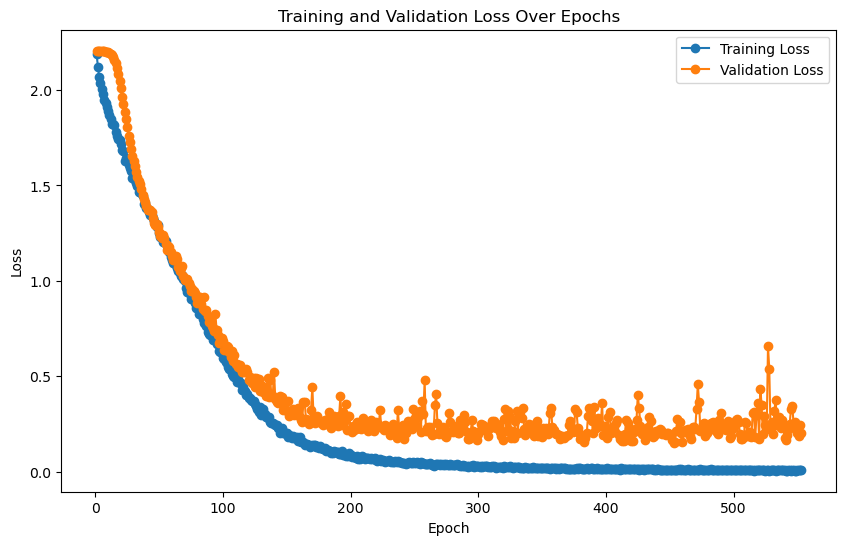

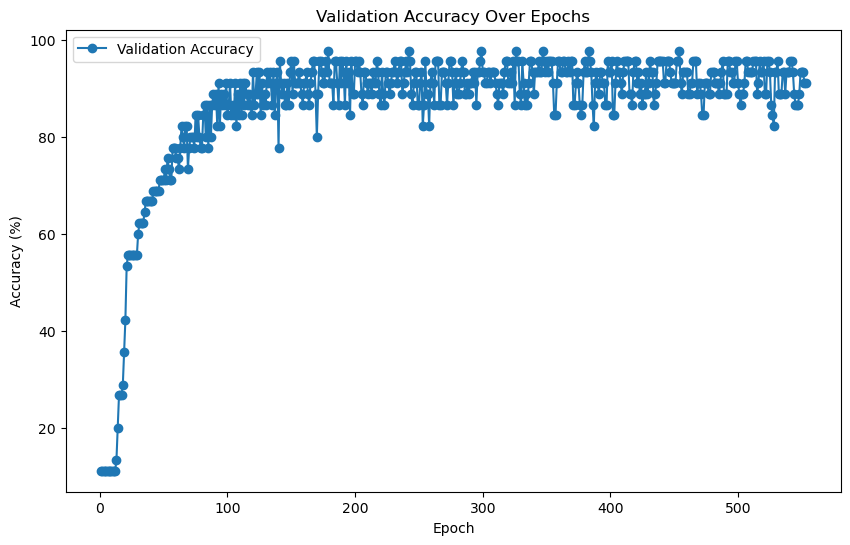


Evaluating on the test set...
    Test Batch [1/166], Loss: 0.8878



Final Test Loss: 0.5222, Test Accuracy: 87.04%
Saved E2E CNN predictions and true labels to model_predictions


In [21]:
#hyperparameters
num_epochs = 1000
learning_rate = 0.0001

#init the model, CrossEntropy loss function, and optimizer
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#getting unique labels from entire dataset (train, validation, test)
all_labels = []
for loader in [train_loader, val_loader, test_loader]:
    for _, labels in loader:
        all_labels.extend(labels.tolist())
all_labels = np.unique(all_labels)

# init model with correct number of classes
num_classes = len(all_labels)
model = hyperspectralCNN(input_channels=window_num_channels, num_classes=num_classes).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#lists to store losses and accuracies
classification_epoch_losses = []
validation_epoch_losses = []
val_accuracies = []

#early stopping parameters
patience = 100
best_val_loss = float('inf')
epochs_without_improvement = 0
best_model_weights = None

#training loop + validation with early stopping
for epoch in range(num_epochs):
    # TRAINING
    model.train()
    running_loss = 0.0
    print(f"\nLOG: Epoch [{epoch + 1}/{num_epochs}] - Training")

    for batch_idx, (data, target) in enumerate(train_loader):
        data = data.to(device).permute(0, 3, 1, 2) 
        target = target.to(device)

        # forward pass
        outputs = model(data)
        loss = criterion(outputs, target)

        # backward pass + optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # accum loss
        running_loss += loss.item()

        if (batch_idx + 1) % 10 == 0:
            print(f"    Training Batch [{batch_idx + 1}/{len(train_loader)}], Loss: {loss.item():.4f}")

    # calc + store average training loss per epoch
    avg_train_loss = running_loss / len(train_loader)
    classification_epoch_losses.append(avg_train_loss)
    print(f"Epoch [{epoch + 1}/{num_epochs}] completed, Average Training Loss: {avg_train_loss:.4f}")

    # VALIDATION
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(val_loader):
            data = data.to(device).permute(0, 3, 1, 2)
            target = target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            val_loss += loss.item()

            # accu calculation
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == target).sum().item()
            total += target.size(0)

            if batch_idx == 0 or (batch_idx + 1) % 10 == 0:
                print(f"    Validation Batch [{batch_idx + 1}/{len(val_loader)}], Loss: {loss.item():.4f}")

    # calc + store validation metrics
    avg_val_loss = val_loss / len(val_loader)
    validation_epoch_losses.append(avg_val_loss)
    val_accuracy = 100 * correct / total
    val_accuracies.append(val_accuracy)
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

    # early stopping logic
    if avg_val_loss <= best_val_loss:
        print(f"Validation loss improved from {best_val_loss:.4f} to {avg_val_loss:.4f}. Saving model...")
        best_val_loss = avg_val_loss
        epochs_without_improvement = 0
        best_model_weights = model.state_dict()
    else:
        epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {epochs_without_improvement}/{patience}")

    if epochs_without_improvement >= patience:
        print(f"Early stopping triggered at epoch {epoch + 1}. No improvement for {patience} epochs.")
        break

# loading the best model weights
if best_model_weights is not None:
    print("Loading the best model weights...")
    model.load_state_dict(best_model_weights)

completed_epochs = len(classification_epoch_losses)

# plot for loss and accuracy trends over epochs
plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), classification_epoch_losses, label="Training Loss", marker='o')
plt.plot(range(1, completed_epochs + 1), validation_epoch_losses, label="Validation Loss", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10,6))
plt.plot(range(1, completed_epochs + 1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.show()

#test Set Evaluation
print("\nEvaluating on the test set...")
model.eval()
test_loss = 0.0
correct = 0
total = 0
e2ecnn_test_predictions = []
e2ecnn_test_true_labels = []

with torch.no_grad():
    for batch_idx, (data, target) in enumerate(test_loader):
        data = data.to(device).permute(0, 3, 1, 2)
        target = target.to(device)
        outputs = model(data)
        loss = criterion(outputs, target)
        test_loss += loss.item()

        #accuracy calc
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == target).sum().item()
        total += target.size(0)

        e2ecnn_test_predictions.extend(predicted.cpu().numpy())
        e2ecnn_test_true_labels.extend(target.cpu().numpy())

        if batch_idx == 0 or (batch_idx + 1) % 1000 == 0:
            print(f"    Test Batch [{batch_idx + 1}/{len(test_loader)}], Loss: {loss.item():.4f}")

#calc + print test metrics
avg_test_loss = test_loss / len(test_loader)
test_accuracy = 100 * correct / total
print(f"\nFinal Test Loss: {avg_test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

# Convert to numpy arrays and save
e2e_test_predictions = np.array(e2ecnn_test_predictions)
e2e_test_true_labels = np.array(e2ecnn_test_true_labels)

np.save(os.path.join(predictions_dir, 'e2e_cnn_predictions.npy'), e2e_test_predictions)
np.save(os.path.join(predictions_dir, 'e2e_cnn_true_labels.npy'), e2e_test_true_labels)
print(f"Saved E2E CNN predictions and true labels to {predictions_dir}")

In [22]:
# dir to save the cnn representations
e2ecnn_rep_dir = "e2ecnn_representations"
os.makedirs(e2ecnn_rep_dir, exist_ok=True)

e2ecnn_loaders = {
    'train': train_loader,
    'val': val_loader,
    'test': test_loader
}


model.eval()

with torch.no_grad():
    for e2ecnn_split_name, e2ecnn_loader in e2ecnn_loaders.items():
        print(f"\nExtracting SCL representations for the {e2ecnn_split_name} dataset...")
        # creating subfolder for the split
        e2ecnn_split_dir = os.path.join(e2ecnn_rep_dir, e2ecnn_split_name)
        os.makedirs(e2ecnn_split_dir, exist_ok=True)

        # processing the data batch-wise
        for e2ecnn_batch_idx, (e2ecnn_vectors, e2ecnn_labels) in enumerate(e2ecnn_loader):
            e2ecnn_vectors = e2ecnn_vectors.permute(0, 3, 1, 2) 
            e2ecnn_vectors = e2ecnn_vectors.to(device).float()
            # computing projections using the trained SCL model
            e2ecnn_projections = model(e2ecnn_vectors)

            # converting projections and labels to np arrays
            e2ecnn_projections_np = e2ecnn_projections.cpu().numpy()
            e2ecnn_labels_np = e2ecnn_labels.cpu().numpy()

            # saving the batch projections and labels
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_encoded_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_projections_np)
            np.save(os.path.join(e2ecnn_split_dir, f"cnn_labels_batch_{e2ecnn_batch_idx}.npy"), e2ecnn_labels_np)

            if (e2ecnn_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {e2ecnn_batch_idx + 1}/{len(e2ecnn_loader)} for {e2ecnn_split_name} dataset.")

        print(f"Completed extraction for the {e2ecnn_split_name} dataset. Representations saved in '{e2ecnn_split_dir}'.")

print("E2E CNN representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'e2ecnn_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'e2ecnn_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.
  Processed batch 30/166 for test dataset.
  Processed batch 40/166 for test dataset.


  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.
  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.
  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.


  Processed batch 150/166 for test dataset.
  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'e2ecnn_representations\test'.
E2E CNN representations extraction complete.


In [23]:
def load_cnn_reps_and_labels(split_dir):
    #gather all the cnn_encoded_batch npy files in sorted order
    cnn_rep_files = sorted(glob.glob(os.path.join(split_dir, "cnn_encoded_batch_*.npy")))

    cnn_all_reps = []
    cnn_all_labels = []

    for cnn_rep_file in cnn_rep_files:
        #deriving label filenames
        cnn_label_file = cnn_rep_file.replace("cnn_encoded_batch_", "cnn_labels_batch_")

        cnn_reps = np.load(cnn_rep_file)
        cnn_labels = np.load(cnn_label_file)

        cnn_all_reps.append(cnn_reps)
        cnn_all_labels.append(cnn_labels)

    #concat along first dim
    cnn_all_reps = np.concatenate(cnn_all_reps, axis = 0)
    cnn_all_labels = np.concatenate(cnn_all_labels, axis = 0)

    return cnn_all_reps, cnn_all_labels

In [24]:
cnn_train_dir = os.path.join("e2ecnn_representations", "train")
cnn_val_dir   = os.path.join("e2ecnn_representations", "val")
cnn_test_dir  = os.path.join("e2ecnn_representations", "test")

cnn_train_reps, cnn_train_labels = load_cnn_reps_and_labels(cnn_train_dir)
cnn_val_reps, cnn_val_labels = load_cnn_reps_and_labels(cnn_val_dir)
cnn_test_reps, cnn_test_labels = load_cnn_reps_and_labels(cnn_test_dir)

## Logistic Regression Model

In [25]:
def load_encoded_data(encoded_dir):
    print(f"LOG: Loading encoded data (representations) from {encoded_dir}...")
    features_list = []
    labels_list = []

    #iter through batches
    for filename in sorted(os.listdir(encoded_dir)):
        if filename.startswith('encoded_batch_') and filename.endswith('.npy'):

            #load the features
            features = np.load(os.path.join(encoded_dir, filename))
            features_flat = features.reshape(features.shape[0], -1) #flatten features for LRM
            features_list.append(features_flat)
        
        elif filename.startswith('labels_batch_') and filename.endswith('.npy'):

            #load labels
            labels = np.load(os.path.join(encoded_dir, filename))
            labels_list.append(labels)

    #concat all batches into a single array
    encoded_features = np.vstack(features_list)
    encoded_labels = np.hstack(labels_list)

    print(f"LOG: Loaded {encoded_features.shape[0]} samples with {encoded_features.shape[1]} features each")
    print(f"LOG: Labels shape: {encoded_labels.shape}")

    return encoded_features, encoded_labels

In [26]:
lrm_encoded_train_dir = os.path.join(encoded_dir, 'train')
lrm_encoded_val_dir = os.path.join(encoded_dir, 'val')
lrm_encoded_test_dir = os.path.join(encoded_dir, 'test')

print("\nLoading training data for LRM...")
lrm_train_features, lrm_train_labels = load_encoded_data(lrm_encoded_train_dir)

print("\nLoading validation data for LRM...")
lrm_val_features, lrm_val_labels = load_encoded_data(lrm_encoded_val_dir)

print("\nLoading test data for LRM...")
lrm_test_features, lrm_test_labels = load_encoded_data(lrm_encoded_test_dir)

#verify shapes
print(f"\nLOG: Training features shape: {lrm_train_features.shape}, Training labels shape: {lrm_train_labels.shape}")
print(f"LOG: Validation features shape: {lrm_val_features.shape}, Validation labels shape: {lrm_val_labels.shape}")
print(f"LOG: Test features shape: {lrm_test_features.shape}, Test labels shape: {lrm_test_labels.shape}")

print("\nLOG: Training Logistic Regression model...")
logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight = 'balanced')
logistic_clf.fit(lrm_train_features, lrm_train_labels)
print("LOG: Logistic Regression training complete.")

#eval on Validation Set
print("\nLOG: Evaluating on the validation set...")
lrm_val_predictions = logistic_clf.predict(lrm_val_features)
lrm_val_accuracy = accuracy_score(lrm_val_labels, lrm_val_predictions)
print(f"Validation Accuracy: {lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(lrm_val_labels, lrm_val_predictions))

#eval on Test Set
print("\nLOG: Evaluating on the test set...")
lrm_test_predictions = logistic_clf.predict(lrm_test_features)
lrm_test_accuracy = accuracy_score(lrm_test_labels, lrm_test_predictions)
print(f"Test Accuracy: {lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(lrm_test_labels, lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'cae_lrm_predictions.npy'), lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'cae_lrm_true_labels.npy'), lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")



Loading training data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)

Loading validation data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)

Loading test data for LRM...
LOG: Loading encoded data (representations) from encoded_representations\test...


LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)

LOG: Training features shape: (360, 64), Training labels shape: (360,)
LOG: Validation features shape: (45, 64), Validation labels shape: (45,)
LOG: Test features shape: (42371, 64), Test labels shape: (42371,)

LOG: Training Logistic Regression model...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 75.56%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.40      0.44         5
           1       1.00      0.80      0.89         5
           2       0.43      0.60      0.50         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.67      0.80      0.73         5
           7       0.67      0.40      0.50         5
           8       1.00      1.

### Classifying CAE Embeddings with MLP

In [27]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [28]:
cae_mlp_train_dir = os.path.join("encoded_representations", "train")
cae_mlp_val_dir   = os.path.join("encoded_representations", "val")
cae_mlp_test_dir  = os.path.join("encoded_representations", "test")

cae_mlp_train_reps, cae_mlp_train_labels = load_encoded_data(cae_mlp_train_dir)
cae_mlp_val_reps, cae_mlp_val_labels = load_encoded_data(cae_mlp_val_dir)
cae_mlp_test_reps, cae_mlp_test_labels = load_encoded_data(cae_mlp_test_dir)

print("Train reps shape:",cae_mlp_train_reps.shape)
print("Train labels shape:", cae_mlp_train_labels.shape)

print("Val reps shape:", cae_mlp_val_reps.shape)
print("Val labels shape:", cae_mlp_val_labels.shape)

print("Test reps shape:", cae_mlp_test_reps.shape)
print("Test labels shape:", cae_mlp_test_labels.shape)

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)
Train reps shape: (360, 64)
Train labels shape: (360,)
Val reps shape: (45, 64)
Val labels shape: (45,)
Test reps shape: (42371, 64)
Test labels shape: (42371,)


In [29]:
#converting arrays to torch tensors
cae_mlp_train_embeddings_torch = torch.tensor(cae_mlp_train_reps, dtype=torch.float32)
cae_mlp_train_labels_torch = torch.tensor(cae_mlp_train_labels, dtype=torch.long)

cae_mlp_val_embeddings_torch = torch.tensor(cae_mlp_val_reps, dtype=torch.float32)
cae_mlp_val_labels_torch = torch.tensor(cae_mlp_val_labels, dtype=torch.long)

cae_mlp_test_embeddings_torch = torch.tensor(cae_mlp_test_reps, dtype=torch.float32)
cae_mlp_test_labels_torch = torch.tensor(cae_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
cae_mlp_train_dataset = TensorDataset(cae_mlp_train_embeddings_torch, cae_mlp_train_labels_torch)
cae_mlp_val_dataset = TensorDataset(cae_mlp_val_embeddings_torch, cae_mlp_val_labels_torch)
cae_mlp_test_dataset = TensorDataset(cae_mlp_test_embeddings_torch, cae_mlp_test_labels_torch)

cae_mlp_batch_size = 64
cae_mlp_train_loader = DataLoader(cae_mlp_train_dataset, batch_size=cae_mlp_batch_size, shuffle=True)
cae_mlp_val_loader = DataLoader(cae_mlp_val_dataset, batch_size=cae_mlp_batch_size, shuffle=False)
cae_mlp_test_loader = DataLoader(cae_mlp_test_dataset, batch_size=cae_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.2664  |  Val Loss: 2.0725
Validation loss improved from inf to 2.0725.
[Epoch 2/1000] Train Loss: 2.0183  |  Val Loss: 1.9444
Validation loss improved from 2.0725 to 1.9444.
[Epoch 3/1000] Train Loss: 1.8843  |  Val Loss: 1.8323
Validation loss improved from 1.9444 to 1.8323.
[Epoch 4/1000] Train Loss: 1.7571  |  Val Loss: 1.7084
Validation loss improved from 1.8323 to 1.7084.
[Epoch 5/1000] Train Loss: 1.6289  |  Val Loss: 1.5954
Validation loss improved from 1.7084 to 1.5954.
[Epoch 6/1000] Train Loss: 1.4986  |  Val Loss: 1.4783
Validation loss improved from 1.5954 to 1.4783.
[Epoch 7/1000] Train Loss: 1.3651  |  Val Loss: 1.3403
Validation loss improved from 1.4783 to 1.3403.
[Epoch 8/1000] Train Loss: 1.2390  |  Val Loss: 1.2330
Validation loss improved from 1.3403 to 1.2330.
[Epoch 9/1000] Train Loss: 1.1207  |  Val Loss: 1.1131
Validation loss improved from 1.2330 to 1.1131.
[Epoch 10/1000] Train Loss: 1.0102  |  Val Loss: 1.0231
Validation loss impr

[Epoch 12/1000] Train Loss: 0.8298  |  Val Loss: 0.8694
Validation loss improved from 0.9393 to 0.8694.
[Epoch 13/1000] Train Loss: 0.7617  |  Val Loss: 0.8182
Validation loss improved from 0.8694 to 0.8182.
[Epoch 14/1000] Train Loss: 0.7090  |  Val Loss: 0.7649
Validation loss improved from 0.8182 to 0.7649.
[Epoch 15/1000] Train Loss: 0.6624  |  Val Loss: 0.7314
Validation loss improved from 0.7649 to 0.7314.
[Epoch 16/1000] Train Loss: 0.6320  |  Val Loss: 0.6859
Validation loss improved from 0.7314 to 0.6859.
[Epoch 17/1000] Train Loss: 0.5965  |  Val Loss: 0.6755
Validation loss improved from 0.6859 to 0.6755.
[Epoch 18/1000] Train Loss: 0.5807  |  Val Loss: 0.6320
Validation loss improved from 0.6755 to 0.6320.


[Epoch 19/1000] Train Loss: 0.5503  |  Val Loss: 0.6420
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 20/1000] Train Loss: 0.5291  |  Val Loss: 0.5955
Validation loss improved from 0.6320 to 0.5955.
[Epoch 21/1000] Train Loss: 0.5062  |  Val Loss: 0.5895
Validation loss improved from 0.5955 to 0.5895.
[Epoch 22/1000] Train Loss: 0.4913  |  Val Loss: 0.5667
Validation loss improved from 0.5895 to 0.5667.
[Epoch 23/1000] Train Loss: 0.4785  |  Val Loss: 0.5670
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 24/1000] Train Loss: 0.4781  |  Val Loss: 0.5439
Validation loss improved from 0.5667 to 0.5439.
[Epoch 25/1000] Train Loss: 0.4773  |  Val Loss: 0.5363
Validation loss improved from 0.5439 to 0.5363.
[Epoch 26/1000] Train Loss: 0.4489  |  Val Loss: 0.5398
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 27/1000] Train Loss: 0.4391  |  Val Loss: 0.5333
Validation loss improved from 0.5363 to 0.5333.
[Epoch 28/1000] Train Loss: 0.4271  |  Val Los

[Epoch 30/1000] Train Loss: 0.4083  |  Val Loss: 0.4803
Validation loss improved from 0.5082 to 0.4803.
[Epoch 31/1000] Train Loss: 0.3963  |  Val Loss: 0.5018
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 32/1000] Train Loss: 0.3993  |  Val Loss: 0.4783
Validation loss improved from 0.4803 to 0.4783.
[Epoch 33/1000] Train Loss: 0.3915  |  Val Loss: 0.4816
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 34/1000] Train Loss: 0.3791  |  Val Loss: 0.4674
Validation loss improved from 0.4783 to 0.4674.
[Epoch 35/1000] Train Loss: 0.3664  |  Val Loss: 0.4601
Validation loss improved from 0.4674 to 0.4601.


[Epoch 36/1000] Train Loss: 0.3632  |  Val Loss: 0.4702
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 37/1000] Train Loss: 0.3513  |  Val Loss: 0.4477
Validation loss improved from 0.4601 to 0.4477.
[Epoch 38/1000] Train Loss: 0.3459  |  Val Loss: 0.4537
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 39/1000] Train Loss: 0.3462  |  Val Loss: 0.4383
Validation loss improved from 0.4477 to 0.4383.
[Epoch 40/1000] Train Loss: 0.3310  |  Val Loss: 0.4481
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 41/1000] Train Loss: 0.3375  |  Val Loss: 0.4380
Validation loss improved from 0.4383 to 0.4380.
[Epoch 42/1000] Train Loss: 0.3332  |  Val Loss: 0.4314
Validation loss improved from 0.4380 to 0.4314.
[Epoch 43/1000] Train Loss: 0.3209  |  Val Loss: 0.4337
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 44/1000] Train Loss: 0.3151  |  Val Loss: 0.4305
Validation loss improved from 0.4314 to 0.4305.
[Epoch 45/1000] Train Loss: 0.3276  |  V

[Epoch 47/1000] Train Loss: 0.3005  |  Val Loss: 0.4170
Validation loss improved from 0.4297 to 0.4170.
[Epoch 48/1000] Train Loss: 0.2986  |  Val Loss: 0.4218
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 49/1000] Train Loss: 0.2877  |  Val Loss: 0.4103
Validation loss improved from 0.4170 to 0.4103.
[Epoch 50/1000] Train Loss: 0.2827  |  Val Loss: 0.4156
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 51/1000] Train Loss: 0.2816  |  Val Loss: 0.4123
!! Validation loss did NOT improve !! Patience: 2/100


[Epoch 52/1000] Train Loss: 0.2732  |  Val Loss: 0.4224
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 53/1000] Train Loss: 0.2708  |  Val Loss: 0.4043
Validation loss improved from 0.4103 to 0.4043.
[Epoch 54/1000] Train Loss: 0.2745  |  Val Loss: 0.4429
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 55/1000] Train Loss: 0.2633  |  Val Loss: 0.3937
Validation loss improved from 0.4043 to 0.3937.
[Epoch 56/1000] Train Loss: 0.2732  |  Val Loss: 0.4272
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 57/1000] Train Loss: 0.2604  |  Val Loss: 0.4048
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 58/1000] Train Loss: 0.2663  |  Val Loss: 0.4115
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 59/1000] Train Loss: 0.2544  |  Val Loss: 0.4436
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 60/1000] Train Loss: 0.2578  |  Val Loss: 0.3931
Validation loss improved from 0.3937 to 0.3931.
[Epoch 61/1000] Train Loss: 

[Epoch 64/1000] Train Loss: 0.2367  |  Val Loss: 0.3985
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 65/1000] Train Loss: 0.2395  |  Val Loss: 0.4526
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 66/1000] Train Loss: 0.2429  |  Val Loss: 0.4087
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 67/1000] Train Loss: 0.2399  |  Val Loss: 0.4420
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 68/1000] Train Loss: 0.2303  |  Val Loss: 0.4408
!! Validation loss did NOT improve !! Patience: 8/100


[Epoch 69/1000] Train Loss: 0.2168  |  Val Loss: 0.4183
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 70/1000] Train Loss: 0.2113  |  Val Loss: 0.4213
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 71/1000] Train Loss: 0.2067  |  Val Loss: 0.4333
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 72/1000] Train Loss: 0.2107  |  Val Loss: 0.4149
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 73/1000] Train Loss: 0.2210  |  Val Loss: 0.4642
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 74/1000] Train Loss: 0.2090  |  Val Loss: 0.4324
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 75/1000] Train Loss: 0.2086  |  Val Loss: 0.4385
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 76/1000] Train Loss: 0.2063  |  Val Loss: 0.4686
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 77/1000] Train Loss: 0.2064  |  Val Loss: 0.4363
!! Validation loss did NOT improve !! Patience: 17/100
[E

[Epoch 82/1000] Train Loss: 0.1919  |  Val Loss: 0.5022
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 83/1000] Train Loss: 0.1838  |  Val Loss: 0.4525
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 84/1000] Train Loss: 0.1789  |  Val Loss: 0.4496
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 85/1000] Train Loss: 0.1789  |  Val Loss: 0.5156
!! Validation loss did NOT improve !! Patience: 25/100


[Epoch 86/1000] Train Loss: 0.1859  |  Val Loss: 0.4464
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 87/1000] Train Loss: 0.1674  |  Val Loss: 0.4875
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 88/1000] Train Loss: 0.1631  |  Val Loss: 0.4747
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 89/1000] Train Loss: 0.1593  |  Val Loss: 0.4850
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 90/1000] Train Loss: 0.1565  |  Val Loss: 0.4839
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 91/1000] Train Loss: 0.1603  |  Val Loss: 0.4663
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 92/1000] Train Loss: 0.1580  |  Val Loss: 0.5149
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 93/1000] Train Loss: 0.1551  |  Val Loss: 0.4697
!! Validation loss did NOT improve !! Patience: 33/100
[Epoch 94/1000] Train Loss: 0.1513  |  Val Loss: 0.5883
!! Validation loss did NOT improve !! Patience: 34/100
[

[Epoch 98/1000] Train Loss: 0.1476  |  Val Loss: 0.4585
!! Validation loss did NOT improve !! Patience: 38/100
[Epoch 99/1000] Train Loss: 0.1518  |  Val Loss: 0.5590
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 100/1000] Train Loss: 0.1453  |  Val Loss: 0.5241
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 101/1000] Train Loss: 0.1504  |  Val Loss: 0.4855
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 102/1000] Train Loss: 0.1525  |  Val Loss: 0.5495
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 103/1000] Train Loss: 0.1510  |  Val Loss: 0.5377
!! Validation loss did NOT improve !! Patience: 43/100


[Epoch 104/1000] Train Loss: 0.1437  |  Val Loss: 0.4821
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 105/1000] Train Loss: 0.1444  |  Val Loss: 0.6381
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 106/1000] Train Loss: 0.1468  |  Val Loss: 0.4925
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 107/1000] Train Loss: 0.1310  |  Val Loss: 0.6023
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 108/1000] Train Loss: 0.1409  |  Val Loss: 0.5109
!! Validation loss did NOT improve !! Patience: 48/100
[Epoch 109/1000] Train Loss: 0.1311  |  Val Loss: 0.5284
!! Validation loss did NOT improve !! Patience: 49/100
[Epoch 110/1000] Train Loss: 0.1391  |  Val Loss: 0.5859
!! Validation loss did NOT improve !! Patience: 50/100
[Epoch 111/1000] Train Loss: 0.1161  |  Val Loss: 0.5470
!! Validation loss did NOT improve !! Patience: 51/100
[Epoch 112/1000] Train Loss: 0.1165  |  Val Loss: 0.5400
!! Validation loss did NOT improve !! Patience:

[Epoch 116/1000] Train Loss: 0.1250  |  Val Loss: 0.6175
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 117/1000] Train Loss: 0.1107  |  Val Loss: 0.5496
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 118/1000] Train Loss: 0.1163  |  Val Loss: 0.6012
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 119/1000] Train Loss: 0.1093  |  Val Loss: 0.5678
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 120/1000] Train Loss: 0.1093  |  Val Loss: 0.5970
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 121/1000] Train Loss: 0.1061  |  Val Loss: 0.5432
!! Validation loss did NOT improve !! Patience: 61/100


[Epoch 122/1000] Train Loss: 0.1093  |  Val Loss: 0.6559
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 123/1000] Train Loss: 0.1054  |  Val Loss: 0.5523
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 124/1000] Train Loss: 0.0972  |  Val Loss: 0.6642
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 125/1000] Train Loss: 0.1018  |  Val Loss: 0.5612
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 126/1000] Train Loss: 0.0993  |  Val Loss: 0.5880
!! Validation loss did NOT improve !! Patience: 66/100
[Epoch 127/1000] Train Loss: 0.1024  |  Val Loss: 0.6073
!! Validation loss did NOT improve !! Patience: 67/100
[Epoch 128/1000] Train Loss: 0.0925  |  Val Loss: 0.6187
!! Validation loss did NOT improve !! Patience: 68/100
[Epoch 129/1000] Train Loss: 0.0912  |  Val Loss: 0.5850
!! Validation loss did NOT improve !! Patience: 69/100
[Epoch 130/1000] Train Loss: 0.0890  |  Val Loss: 0.6121
!! Validation loss did NOT improve !! Patience:

[Epoch 133/1000] Train Loss: 0.0916  |  Val Loss: 0.6622
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 134/1000] Train Loss: 0.0892  |  Val Loss: 0.6190
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 135/1000] Train Loss: 0.0845  |  Val Loss: 0.6375
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 136/1000] Train Loss: 0.0852  |  Val Loss: 0.6250
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 137/1000] Train Loss: 0.0801  |  Val Loss: 0.6161
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 138/1000] Train Loss: 0.0811  |  Val Loss: 0.6367
!! Validation loss did NOT improve !! Patience: 78/100


[Epoch 139/1000] Train Loss: 0.0745  |  Val Loss: 0.6556
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 140/1000] Train Loss: 0.0769  |  Val Loss: 0.6391
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 141/1000] Train Loss: 0.0796  |  Val Loss: 0.6696
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 142/1000] Train Loss: 0.0998  |  Val Loss: 0.6257
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 143/1000] Train Loss: 0.0975  |  Val Loss: 0.7514
!! Validation loss did NOT improve !! Patience: 83/100
[Epoch 144/1000] Train Loss: 0.0808  |  Val Loss: 0.6115
!! Validation loss did NOT improve !! Patience: 84/100
[Epoch 145/1000] Train Loss: 0.0794  |  Val Loss: 0.6617
!! Validation loss did NOT improve !! Patience: 85/100
[Epoch 146/1000] Train Loss: 0.0742  |  Val Loss: 0.6522
!! Validation loss did NOT improve !! Patience: 86/100
[Epoch 147/1000] Train Loss: 0.0714  |  Val Loss: 0.6848
!! Validation loss did NOT improve !! Patience:

[Epoch 150/1000] Train Loss: 0.0668  |  Val Loss: 0.6902
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 151/1000] Train Loss: 0.0661  |  Val Loss: 0.6734
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 152/1000] Train Loss: 0.0634  |  Val Loss: 0.7145
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 153/1000] Train Loss: 0.0674  |  Val Loss: 0.6461
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 154/1000] Train Loss: 0.0702  |  Val Loss: 0.7275
!! Validation loss did NOT improve !! Patience: 94/100


[Epoch 155/1000] Train Loss: 0.0827  |  Val Loss: 0.7707
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 156/1000] Train Loss: 0.0926  |  Val Loss: 0.6682
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 157/1000] Train Loss: 0.0883  |  Val Loss: 0.7204
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 158/1000] Train Loss: 0.0933  |  Val Loss: 0.7495
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 159/1000] Train Loss: 0.0874  |  Val Loss: 0.6256
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 160/1000] Train Loss: 0.0833  |  Val Loss: 0.7637
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 160 !!
No improvement for 100 epochs.


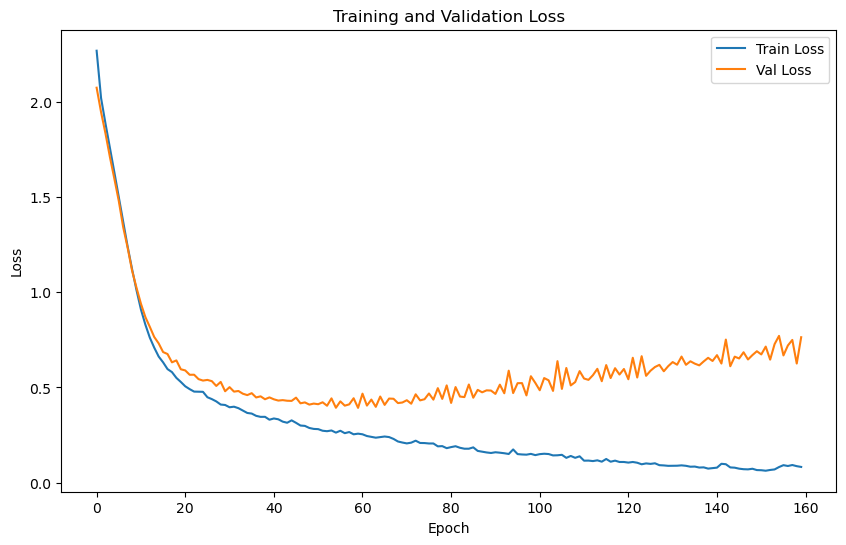

In [30]:
cae_mlp_input_dim = cae_mlp_train_reps.shape[1]
cae_mlp_num_classes = len(torch.unique(cae_mlp_train_labels_torch))
cae_mlp_model = MLPClassifier(cae_mlp_input_dim, cae_mlp_num_classes).to(device)

cae_mlp_criterion = nn.CrossEntropyLoss()
cae_mlp_optimizer = optim.Adam(cae_mlp_model.parameters(), lr=1e-3)

cae_mlp_num_epochs = 1000
cae_mlp_patience = 100

cae_mlp_train_losses = []
cae_mlp_val_losses = []

cae_mlp_best_val_loss = float('inf')
cae_mlp_epochs_without_improvement = 0

for cae_mlp_epoch in range(cae_mlp_num_epochs):
    # Training
    cae_mlp_model.train()
    cae_mlp_train_running_loss = 0.0
    
    for cae_mlp_embeddings_batch, cae_mlp_labels_batch in cae_mlp_train_loader:
        cae_mlp_embeddings_batch = cae_mlp_embeddings_batch.to(device)
        cae_mlp_labels_batch = cae_mlp_labels_batch.to(device)
        
        cae_mlp_optimizer.zero_grad()
        
        # Forward
        cae_mlp_outputs = cae_mlp_model(cae_mlp_embeddings_batch)
        cae_mlp_loss = cae_mlp_criterion(cae_mlp_outputs, cae_mlp_labels_batch)
        
        # Backward & Update
        cae_mlp_loss.backward()
        cae_mlp_optimizer.step()
        
        cae_mlp_train_running_loss += cae_mlp_loss.item() * cae_mlp_embeddings_batch.size(0)
    
    cae_mlp_epoch_train_loss = cae_mlp_train_running_loss / len(cae_mlp_train_loader.dataset)
    cae_mlp_train_losses.append(cae_mlp_epoch_train_loss)


    # Validation

    cae_mlp_model.eval()
    cae_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for cae_mlp_val_embeddings_batch, cae_mlp_val_labels_batch in cae_mlp_val_loader:
            cae_mlp_val_embeddings_batch = cae_mlp_val_embeddings_batch.to(device)
            cae_mlp_val_labels_batch = cae_mlp_val_labels_batch.to(device)

            cae_mlp_val_outputs = cae_mlp_model(cae_mlp_val_embeddings_batch)
            cae_mlp_val_loss = cae_mlp_criterion(cae_mlp_val_outputs, cae_mlp_val_labels_batch)

            cae_mlp_val_running_loss += cae_mlp_val_loss.item() * cae_mlp_val_embeddings_batch.size(0)

    cae_mlp_epoch_val_loss = cae_mlp_val_running_loss / len(cae_mlp_val_loader.dataset)
    cae_mlp_val_losses.append(cae_mlp_epoch_val_loss)

    print(f"[Epoch {cae_mlp_epoch+1}/{cae_mlp_num_epochs}] "
          f"Train Loss: {cae_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {cae_mlp_epoch_val_loss:.4f}")

    # Early stopping

    if cae_mlp_epoch_val_loss < cae_mlp_best_val_loss:
        # improvement, reset patience
        print(f"Validation loss improved from {cae_mlp_best_val_loss:.4f} to {cae_mlp_epoch_val_loss:.4f}.")
        cae_mlp_best_val_loss = cae_mlp_epoch_val_loss
        cae_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        cae_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {cae_mlp_epochs_without_improvement}/{cae_mlp_patience}")
        
        if cae_mlp_epochs_without_improvement >= cae_mlp_patience:
            print(f"!! Early stopping triggered at epoch {cae_mlp_epoch+1} !!\n"
                  f"No improvement for {cae_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(cae_mlp_train_losses, label='Train Loss')
plt.plot(cae_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved CAE+MLP predictions and true labels to model_predictions
Test Loss: 1.0669 | Test Accuracy: 71.62%


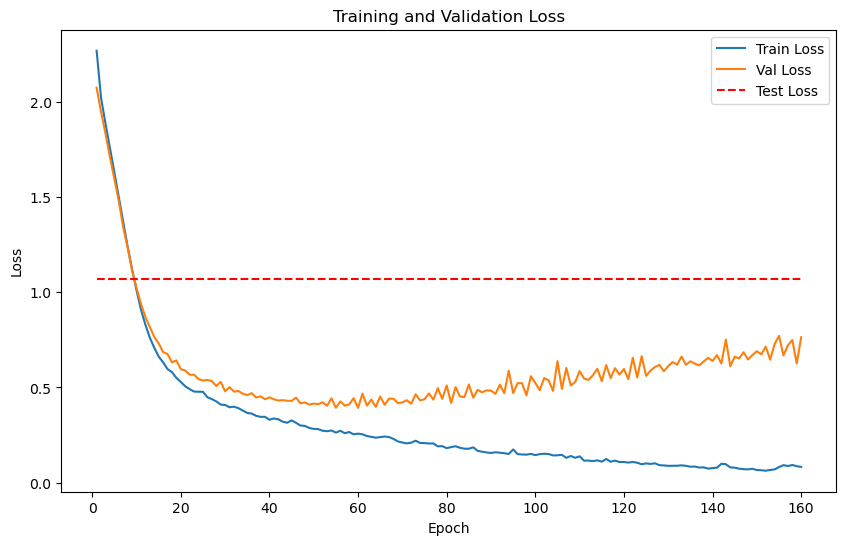

In [31]:
cae_mlp_model.eval()

cae_mlp_test_running_loss = 0.0
cae_mlp_test_correct = 0
cae_mlp_all_predictions = []
cae_mlp_all_true_labels = []

with torch.no_grad():
    for cae_mlp_test_embeddings_batch, cae_mlp_test_labels_batch in cae_mlp_test_loader:
        cae_mlp_test_embeddings_batch = cae_mlp_test_embeddings_batch.to(device)
        cae_mlp_test_labels_batch = cae_mlp_test_labels_batch.to(device)

        cae_mlp_test_outputs = cae_mlp_model(cae_mlp_test_embeddings_batch)
        
        cae_mlp_test_loss_batch = cae_mlp_criterion(cae_mlp_test_outputs, cae_mlp_test_labels_batch)
        cae_mlp_test_running_loss += cae_mlp_test_loss_batch.item() * cae_mlp_test_embeddings_batch.size(0)

        _, cae_mlp_test_predicted = torch.max(cae_mlp_test_outputs, dim=1)
        cae_mlp_test_correct += (cae_mlp_test_predicted == cae_mlp_test_labels_batch).sum().item()

        #saving predictions for conf matrix
        cae_mlp_all_predictions.extend(cae_mlp_test_predicted.cpu().numpy())
        cae_mlp_all_true_labels.extend(cae_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'cae_mlp_predictions.npy'), np.array(cae_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'cae_mlp_true_labels.npy'), np.array(cae_mlp_all_true_labels))
print(f"Saved CAE+MLP predictions and true labels to {predictions_dir}")

cae_mlp_epoch_test_loss = cae_mlp_test_running_loss / len(cae_mlp_test_loader.dataset)
cae_mlp_test_accuracy = cae_mlp_test_correct / len(cae_mlp_test_loader.dataset)

cae_mlp_test_accuracy_pct = cae_mlp_test_accuracy * 100.0

print(f"Test Loss: {cae_mlp_epoch_test_loss:.4f} | Test Accuracy: {cae_mlp_test_accuracy_pct:.2f}%")

cae_mlp_num_epochs_run = len(cae_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         cae_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, cae_mlp_num_epochs_run + 1),
         [cae_mlp_epoch_test_loss]*cae_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

## Typical SCL with Cosine Similarity (Supervised Contrastive Loss)

In [32]:
tscl_encoded_train_dir = os.path.join(encoded_dir, 'train')
tscl_encoded_val_dir = os.path.join(encoded_dir, 'val')
tscl_encoded_test_dir = os.path.join(encoded_dir, 'test')

tscl_train_embeddings, tscl_train_labels = load_encoded_data(tscl_encoded_train_dir)
tscl_val_embeddings, tscl_val_labels = load_encoded_data(tscl_encoded_val_dir)
tscl_test_embeddings, tscl_test_labels = load_encoded_data(tscl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {tscl_train_embeddings.shape}, \nTrain labels shape: {tscl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {tscl_val_embeddings.shape}, \nVal labels shape: {tscl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {tscl_test_embeddings.shape}, \nTest labels shape: {tscl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [33]:
#flattening embeddings to (num_samples, 64)
tscl_train_embeddings = tscl_train_embeddings.reshape(tscl_train_embeddings.shape[0], -1)
tscl_val_embeddings = tscl_val_embeddings.reshape(tscl_val_embeddings.shape[0], -1)
tscl_test_embeddings = tscl_test_embeddings.reshape(tscl_test_embeddings.shape[0], -1)

#compute mean and std from training set
tscl_train_mean = np.mean(tscl_train_embeddings, axis=0)
tscl_train_std = np.std(tscl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
tscl_train_embeddings = (tscl_train_embeddings - tscl_train_mean) / tscl_train_std
tscl_val_embeddings = (tscl_val_embeddings - tscl_train_mean) / tscl_train_std
tscl_test_embeddings = (tscl_test_embeddings - tscl_train_mean) / tscl_train_std

tscl_train_dataset = TensorDataset(torch.tensor(tscl_train_embeddings, dtype=torch.float32), torch.tensor(tscl_train_labels, dtype=torch.long))
tscl_val_dataset = TensorDataset(torch.tensor(tscl_val_embeddings, dtype=torch.float32), torch.tensor(tscl_val_labels, dtype=torch.long))
tscl_test_dataset = TensorDataset(torch.tensor(tscl_test_embeddings, dtype=torch.float32), torch.tensor(tscl_test_labels, dtype=torch.long))

tscl_m = 20
tscl_num_classes = len(np.unique(tscl_train_labels))

# Calculate theoretical required batch size
tscl_required_batch_size = tscl_m * tscl_num_classes

# Ensure batch size doesn't exceed training set size
if tscl_required_batch_size > len(tscl_train_dataset):
    #case 1: Not enough samples - reduce m proportionally
    tscl_max_possible_m = len(tscl_train_dataset) // tscl_num_classes
    tscl_m = max(1, tscl_max_possible_m)  # Ensure m >= 1
    tscl_batch_size_train = tscl_m * tscl_num_classes
else:
    #case 2: Use full batch size
    tscl_batch_size_train = tscl_required_batch_size

tscl_sampler = MPerClassSampler(labels = tscl_train_labels, m = tscl_m, batch_size = tscl_batch_size_train, length_before_new_iter=len(tscl_train_dataset))
tscl_train_loader = DataLoader(tscl_train_dataset, batch_size=tscl_batch_size_train, sampler=tscl_sampler)

#creating dataloaders for scl
tscl_dataloader_bs = 256
tscl_val_loader = DataLoader(tscl_val_dataset, batch_size=tscl_dataloader_bs, shuffle=False)
tscl_test_loader = DataLoader(tscl_test_dataset, batch_size=tscl_dataloader_bs, shuffle=False)

for tscl_X_batch, tscl_y_batch in tscl_train_loader:
    tscl_unique, tscl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(tscl_unique, tscl_counts)))
    print(f"Training batch size: {tscl_batch_size_train}")
    break

Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [34]:
class SupConLoss(nn.Module):
    def __init__(self, temperature = 0.07):
        super(SupConLoss, self).__init__()
        self.temperature = temperature

    def forward(self, features, labels):
        #normalize feat vectors
        features = F.normalize(features, p=2, dim = 1)

        #compute cosine simi matrix
        similarity_matrix = torch.matmul(features, features.T) / self.temperature

        #create a mask for +ve pairs - i.e. same class
        labels = labels.unsqueeze(1)
        mask = torch.eq(labels, labels.T).float().to(features.device)

        #loss computation
        exp_sim = torch.exp(similarity_matrix)
        log_prob = similarity_matrix - torch.log(exp_sim.sum(dim = 1, keepdim=True))

        #mask out diagonal - i.e. self similarity
        mask_self = torch.eye(mask.shape[0], dtype = torch.bool).to(features.device)
        mask = mask * (~mask_self)

        #handling edge cases when there is no +ve pair
        mask_pos_pairs = mask.sum(dim=1)
        mask_pos_pairs = torch.where(mask_pos_pairs < 1e-6, 1, mask_pos_pairs)

        loss = -(mask * log_prob).sum(dim=1) / mask_pos_pairs

        return loss.mean() 

In [35]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()

        self.projection_head = nn.Sequential(
            nn.Linear(64, 128), #expects input of shape (batch_size, 64)
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        #flattening input tensor
        #x = x.view(x.size(0), -1)  #reshaping -> (batch_size, channels * height * width)
        projections = self.projection_head(x)
        return projections


LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 8.6496
    Batch [2/2], Train Loss: 8.8572
Epoch [1/2000], Avg Train Loss: 8.7534
Epoch [1/2000], Avg Val Loss: 4.7514
Validation loss improved from inf to 4.7514. Saving model...

LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 8.2741
    Batch [2/2], Train Loss: 8.3941
Epoch [2/2000], Avg Train Loss: 8.3341
Epoch [2/2000], Avg Val Loss: 4.6589
Validation loss improved from 4.7514 to 4.6589. Saving model...

LOG: Epoch [3/2000] - Training
    Batch [1/2], Train Loss: 8.5474
    Batch [2/2], Train Loss: 8.6254
Epoch [3/2000], Avg Train Loss: 8.5864
Epoch [3/2000], Avg Val Loss: 4.5708
Validation loss improved from 4.6589 to 4.5708. Saving model...

LOG: Epoch [4/2000] - Training
    Batch [1/2], Train Loss: 8.4004
    Batch [2/2], Train Loss: 8.1570
Epoch [4/2000], Avg Train Loss: 8.2787
Epoch [4/2000], Avg Val Loss: 4.4863
Validation loss improved from 4.5708 to 4.4863. Saving model...

LOG: Epoch [5/2000] - Training


    Batch [1/2], Train Loss: 8.1917
    Batch [2/2], Train Loss: 8.1788
Epoch [5/2000], Avg Train Loss: 8.1852
Epoch [5/2000], Avg Val Loss: 4.4059
Validation loss improved from 4.4863 to 4.4059. Saving model...

LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 7.9424
    Batch [2/2], Train Loss: 7.8936
Epoch [6/2000], Avg Train Loss: 7.9180
Epoch [6/2000], Avg Val Loss: 4.3298
Validation loss improved from 4.4059 to 4.3298. Saving model...

LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 8.1237
    Batch [2/2], Train Loss: 7.8918
Epoch [7/2000], Avg Train Loss: 8.0078
Epoch [7/2000], Avg Val Loss: 4.2571
Validation loss improved from 4.3298 to 4.2571. Saving model...

LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 7.6719
    Batch [2/2], Train Loss: 7.6593
Epoch [8/2000], Avg Train Loss: 7.6656
Epoch [8/2000], Avg Val Loss: 4.1881
Validation loss improved from 4.2571 to 4.1881. Saving model...

LOG: Epoch [9/2000] - Training
    Batch [1/2], Train L

Epoch [12/2000], Avg Val Loss: 3.9444
Validation loss improved from 4.0004 to 3.9444. Saving model...

LOG: Epoch [13/2000] - Training
    Batch [1/2], Train Loss: 7.1846
    Batch [2/2], Train Loss: 7.0393
Epoch [13/2000], Avg Train Loss: 7.1119
Epoch [13/2000], Avg Val Loss: 3.8910
Validation loss improved from 3.9444 to 3.8910. Saving model...

LOG: Epoch [14/2000] - Training
    Batch [1/2], Train Loss: 7.0926
    Batch [2/2], Train Loss: 6.9493
Epoch [14/2000], Avg Train Loss: 7.0210
Epoch [14/2000], Avg Val Loss: 3.8405
Validation loss improved from 3.8910 to 3.8405. Saving model...

LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 6.8564
    Batch [2/2], Train Loss: 6.9720
Epoch [15/2000], Avg Train Loss: 6.9142
Epoch [15/2000], Avg Val Loss: 3.7926
Validation loss improved from 3.8405 to 3.7926. Saving model...

LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 6.7560
    Batch [2/2], Train Loss: 6.7868
Epoch [16/2000], Avg Train Loss: 6.7714
Epoch [16/20

    Batch [2/2], Train Loss: 6.6322
Epoch [18/2000], Avg Train Loss: 6.6177
Epoch [18/2000], Avg Val Loss: 3.6660
Validation loss improved from 3.7056 to 3.6660. Saving model...

LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 6.6114
    Batch [2/2], Train Loss: 6.5766
Epoch [19/2000], Avg Train Loss: 6.5940
Epoch [19/2000], Avg Val Loss: 3.6284
Validation loss improved from 3.6660 to 3.6284. Saving model...

LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 6.3136
    Batch [2/2], Train Loss: 6.4120
Epoch [20/2000], Avg Train Loss: 6.3628
Epoch [20/2000], Avg Val Loss: 3.5928
Validation loss improved from 3.6284 to 3.5928. Saving model...

LOG: Epoch [21/2000] - Training
    Batch [1/2], Train Loss: 6.4035
    Batch [2/2], Train Loss: 6.4611
Epoch [21/2000], Avg Train Loss: 6.4323
Epoch [21/2000], Avg Val Loss: 3.5590
Validation loss improved from 3.5928 to 3.5590. Saving model...

LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 6.3817
    Batch [2

Epoch [25/2000], Avg Val Loss: 3.4402
Validation loss improved from 3.4672 to 3.4402. Saving model...

LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 5.8244
    Batch [2/2], Train Loss: 5.9281
Epoch [26/2000], Avg Train Loss: 5.8762
Epoch [26/2000], Avg Val Loss: 3.4149
Validation loss improved from 3.4402 to 3.4149. Saving model...

LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 5.9580
    Batch [2/2], Train Loss: 5.8258
Epoch [27/2000], Avg Train Loss: 5.8919
Epoch [27/2000], Avg Val Loss: 3.3910
Validation loss improved from 3.4149 to 3.3910. Saving model...

LOG: Epoch [28/2000] - Training
    Batch [1/2], Train Loss: 5.7935
    Batch [2/2], Train Loss: 5.8292
Epoch [28/2000], Avg Train Loss: 5.8114
Epoch [28/2000], Avg Val Loss: 3.3684
Validation loss improved from 3.3910 to 3.3684. Saving model...

LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 5.8184
    Batch [2/2], Train Loss: 5.7054
Epoch [29/2000], Avg Train Loss: 5.7619
Epoch [29/20

Epoch [33/2000], Avg Val Loss: 3.2714
Validation loss improved from 3.2887 to 3.2714. Saving model...

LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 5.3889
    Batch [2/2], Train Loss: 5.5661
Epoch [34/2000], Avg Train Loss: 5.4775
Epoch [34/2000], Avg Val Loss: 3.2551
Validation loss improved from 3.2714 to 3.2551. Saving model...

LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 5.4761
    Batch [2/2], Train Loss: 5.5063
Epoch [35/2000], Avg Train Loss: 5.4912
Epoch [35/2000], Avg Val Loss: 3.2399
Validation loss improved from 3.2551 to 3.2399. Saving model...

LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 5.4355
    Batch [2/2], Train Loss: 5.4971
Epoch [36/2000], Avg Train Loss: 5.4663
Epoch [36/2000], Avg Val Loss: 3.2253
Validation loss improved from 3.2399 to 3.2253. Saving model...

LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 5.4866
    Batch [2/2], Train Loss: 5.4032
Epoch [37/2000], Avg Train Loss: 5.4449
Epoch [37/20

    Batch [1/2], Train Loss: 5.3704
    Batch [2/2], Train Loss: 5.2465
Epoch [39/2000], Avg Train Loss: 5.3084
Epoch [39/2000], Avg Val Loss: 3.1853
Validation loss improved from 3.1979 to 3.1853. Saving model...

LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 5.1845
    Batch [2/2], Train Loss: 5.4301
Epoch [40/2000], Avg Train Loss: 5.3073
Epoch [40/2000], Avg Val Loss: 3.1734
Validation loss improved from 3.1853 to 3.1734. Saving model...

LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 5.3053
    Batch [2/2], Train Loss: 5.2509
Epoch [41/2000], Avg Train Loss: 5.2781
Epoch [41/2000], Avg Val Loss: 3.1620
Validation loss improved from 3.1734 to 3.1620. Saving model...

LOG: Epoch [42/2000] - Training
    Batch [1/2], Train Loss: 5.3077
    Batch [2/2], Train Loss: 5.1639
Epoch [42/2000], Avg Train Loss: 5.2358
Epoch [42/2000], Avg Val Loss: 3.1512
Validation loss improved from 3.1620 to 3.1512. Saving model...

LOG: Epoch [43/2000] - Training
    Batch [1

    Batch [2/2], Train Loss: 5.1654
Epoch [44/2000], Avg Train Loss: 5.1513
Epoch [44/2000], Avg Val Loss: 3.1305
Validation loss improved from 3.1408 to 3.1305. Saving model...

LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 5.1564
    Batch [2/2], Train Loss: 5.1299
Epoch [45/2000], Avg Train Loss: 5.1432
Epoch [45/2000], Avg Val Loss: 3.1207
Validation loss improved from 3.1305 to 3.1207. Saving model...

LOG: Epoch [46/2000] - Training
    Batch [1/2], Train Loss: 5.0276
    Batch [2/2], Train Loss: 4.9869
Epoch [46/2000], Avg Train Loss: 5.0073
Epoch [46/2000], Avg Val Loss: 3.1116
Validation loss improved from 3.1207 to 3.1116. Saving model...

LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 5.1591
    Batch [2/2], Train Loss: 5.0559
Epoch [47/2000], Avg Train Loss: 5.1075
Epoch [47/2000], Avg Val Loss: 3.1031
Validation loss improved from 3.1116 to 3.1031. Saving model...

LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 5.1210
    Batch [2

    Batch [2/2], Train Loss: 4.9917
Epoch [51/2000], Avg Train Loss: 4.9760
Epoch [51/2000], Avg Val Loss: 3.0720
Validation loss improved from 3.0789 to 3.0720. Saving model...

LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 4.9729
    Batch [2/2], Train Loss: 5.0229
Epoch [52/2000], Avg Train Loss: 4.9979
Epoch [52/2000], Avg Val Loss: 3.0655
Validation loss improved from 3.0720 to 3.0655. Saving model...

LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 5.0766
    Batch [2/2], Train Loss: 5.0027
Epoch [53/2000], Avg Train Loss: 5.0397
Epoch [53/2000], Avg Val Loss: 3.0590
Validation loss improved from 3.0655 to 3.0590. Saving model...

LOG: Epoch [54/2000] - Training
    Batch [1/2], Train Loss: 4.8656
    Batch [2/2], Train Loss: 4.9251
Epoch [54/2000], Avg Train Loss: 4.8954
Epoch [54/2000], Avg Val Loss: 3.0525
Validation loss improved from 3.0590 to 3.0525. Saving model...

LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 4.9249
    Batch [2

Epoch [58/2000], Avg Val Loss: 3.0288
Validation loss improved from 3.0345 to 3.0288. Saving model...

LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 4.8385
    Batch [2/2], Train Loss: 4.8492
Epoch [59/2000], Avg Train Loss: 4.8438
Epoch [59/2000], Avg Val Loss: 3.0232
Validation loss improved from 3.0288 to 3.0232. Saving model...

LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 4.8871
    Batch [2/2], Train Loss: 4.7460
Epoch [60/2000], Avg Train Loss: 4.8165
Epoch [60/2000], Avg Val Loss: 3.0177
Validation loss improved from 3.0232 to 3.0177. Saving model...

LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 4.7183
    Batch [2/2], Train Loss: 4.8169
Epoch [61/2000], Avg Train Loss: 4.7676
Epoch [61/2000], Avg Val Loss: 3.0125
Validation loss improved from 3.0177 to 3.0125. Saving model...

LOG: Epoch [62/2000] - Training
    Batch [1/2], Train Loss: 4.7943
    Batch [2/2], Train Loss: 4.7962
Epoch [62/2000], Avg Train Loss: 4.7953
Epoch [62/20

Epoch [63/2000], Avg Val Loss: 3.0023
Validation loss improved from 3.0074 to 3.0023. Saving model...

LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 4.7867
    Batch [2/2], Train Loss: 4.8228
Epoch [64/2000], Avg Train Loss: 4.8048
Epoch [64/2000], Avg Val Loss: 2.9974
Validation loss improved from 3.0023 to 2.9974. Saving model...

LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 4.7363
    Batch [2/2], Train Loss: 4.7772
Epoch [65/2000], Avg Train Loss: 4.7568
Epoch [65/2000], Avg Val Loss: 2.9923
Validation loss improved from 2.9974 to 2.9923. Saving model...

LOG: Epoch [66/2000] - Training
    Batch [1/2], Train Loss: 4.7847
    Batch [2/2], Train Loss: 4.8182
Epoch [66/2000], Avg Train Loss: 4.8014
Epoch [66/2000], Avg Val Loss: 2.9872
Validation loss improved from 2.9923 to 2.9872. Saving model...

LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 4.7191
    Batch [2/2], Train Loss: 4.7156
Epoch [67/2000], Avg Train Loss: 4.7174
Epoch [67/20

Epoch [68/2000], Avg Val Loss: 2.9779
Validation loss improved from 2.9825 to 2.9779. Saving model...

LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 4.7915
    Batch [2/2], Train Loss: 4.7558
Epoch [69/2000], Avg Train Loss: 4.7737
Epoch [69/2000], Avg Val Loss: 2.9735
Validation loss improved from 2.9779 to 2.9735. Saving model...

LOG: Epoch [70/2000] - Training
    Batch [1/2], Train Loss: 4.7929
    Batch [2/2], Train Loss: 4.6853
Epoch [70/2000], Avg Train Loss: 4.7391
Epoch [70/2000], Avg Val Loss: 2.9693
Validation loss improved from 2.9735 to 2.9693. Saving model...

LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 4.7538
    Batch [2/2], Train Loss: 4.7181
Epoch [71/2000], Avg Train Loss: 4.7360
Epoch [71/2000], Avg Val Loss: 2.9650
Validation loss improved from 2.9693 to 2.9650. Saving model...

LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 4.7038
    Batch [2/2], Train Loss: 4.7016
Epoch [72/2000], Avg Train Loss: 4.7027
Epoch [72/20

    Batch [2/2], Train Loss: 4.6923
Epoch [75/2000], Avg Train Loss: 4.7054
Epoch [75/2000], Avg Val Loss: 2.9480
Validation loss improved from 2.9522 to 2.9480. Saving model...

LOG: Epoch [76/2000] - Training
    Batch [1/2], Train Loss: 4.6819
    Batch [2/2], Train Loss: 4.6381
Epoch [76/2000], Avg Train Loss: 4.6600
Epoch [76/2000], Avg Val Loss: 2.9440
Validation loss improved from 2.9480 to 2.9440. Saving model...

LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 4.7219
    Batch [2/2], Train Loss: 4.6662
Epoch [77/2000], Avg Train Loss: 4.6941
Epoch [77/2000], Avg Val Loss: 2.9400
Validation loss improved from 2.9440 to 2.9400. Saving model...

LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 4.6163
    Batch [2/2], Train Loss: 4.6351
Epoch [78/2000], Avg Train Loss: 4.6257
Epoch [78/2000], Avg Val Loss: 2.9360
Validation loss improved from 2.9400 to 2.9360. Saving model...

LOG: Epoch [79/2000] - Training
    Batch [1/2], Train Loss: 4.6281
    Batch [2

    Batch [2/2], Train Loss: 4.5486
Epoch [81/2000], Avg Train Loss: 4.5767
Epoch [81/2000], Avg Val Loss: 2.9244
Validation loss improved from 2.9283 to 2.9244. Saving model...

LOG: Epoch [82/2000] - Training
    Batch [1/2], Train Loss: 4.5990
    Batch [2/2], Train Loss: 4.6023
Epoch [82/2000], Avg Train Loss: 4.6006
Epoch [82/2000], Avg Val Loss: 2.9206
Validation loss improved from 2.9244 to 2.9206. Saving model...

LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 4.5487
    Batch [2/2], Train Loss: 4.5675
Epoch [83/2000], Avg Train Loss: 4.5581
Epoch [83/2000], Avg Val Loss: 2.9168
Validation loss improved from 2.9206 to 2.9168. Saving model...

LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 4.5615
    Batch [2/2], Train Loss: 4.5451
Epoch [84/2000], Avg Train Loss: 4.5533
Epoch [84/2000], Avg Val Loss: 2.9129
Validation loss improved from 2.9168 to 2.9129. Saving model...

LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 4.5189
    Batch [2

    Batch [2/2], Train Loss: 4.6069
Epoch [89/2000], Avg Train Loss: 4.6236
Epoch [89/2000], Avg Val Loss: 2.8942
Validation loss improved from 2.8979 to 2.8942. Saving model...

LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 4.5631
    Batch [2/2], Train Loss: 4.5656
Epoch [90/2000], Avg Train Loss: 4.5644
Epoch [90/2000], Avg Val Loss: 2.8904
Validation loss improved from 2.8942 to 2.8904. Saving model...

LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 4.5420
    Batch [2/2], Train Loss: 4.5156
Epoch [91/2000], Avg Train Loss: 4.5288
Epoch [91/2000], Avg Val Loss: 2.8868
Validation loss improved from 2.8904 to 2.8868. Saving model...

LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 4.4705
    Batch [2/2], Train Loss: 4.5137
Epoch [92/2000], Avg Train Loss: 4.4921
Epoch [92/2000], Avg Val Loss: 2.8833
Validation loss improved from 2.8868 to 2.8833. Saving model...

LOG: Epoch [93/2000] - Training
    Batch [1/2], Train Loss: 4.4978
    Batch [2

    Batch [2/2], Train Loss: 4.5737
Epoch [94/2000], Avg Train Loss: 4.5664
Epoch [94/2000], Avg Val Loss: 2.8762
Validation loss improved from 2.8798 to 2.8762. Saving model...

LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 4.5525
    Batch [2/2], Train Loss: 4.4571
Epoch [95/2000], Avg Train Loss: 4.5048
Epoch [95/2000], Avg Val Loss: 2.8726
Validation loss improved from 2.8762 to 2.8726. Saving model...

LOG: Epoch [96/2000] - Training
    Batch [1/2], Train Loss: 4.5239
    Batch [2/2], Train Loss: 4.5155
Epoch [96/2000], Avg Train Loss: 4.5197
Epoch [96/2000], Avg Val Loss: 2.8691
Validation loss improved from 2.8726 to 2.8691. Saving model...

LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 4.4969
    Batch [2/2], Train Loss: 4.5360
Epoch [97/2000], Avg Train Loss: 4.5164
Epoch [97/2000], Avg Val Loss: 2.8655
Validation loss improved from 2.8691 to 2.8655. Saving model...

LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 4.4742
    Batch [2

    Batch [1/2], Train Loss: 4.4515
    Batch [2/2], Train Loss: 4.4340
Epoch [101/2000], Avg Train Loss: 4.4428
Epoch [101/2000], Avg Val Loss: 2.8515
Validation loss improved from 2.8550 to 2.8515. Saving model...

LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 4.4425
    Batch [2/2], Train Loss: 4.5178
Epoch [102/2000], Avg Train Loss: 4.4802
Epoch [102/2000], Avg Val Loss: 2.8480
Validation loss improved from 2.8515 to 2.8480. Saving model...

LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 4.4879
    Batch [2/2], Train Loss: 4.4394
Epoch [103/2000], Avg Train Loss: 4.4636
Epoch [103/2000], Avg Val Loss: 2.8444
Validation loss improved from 2.8480 to 2.8444. Saving model...

LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 4.4560
    Batch [2/2], Train Loss: 4.3848
Epoch [104/2000], Avg Train Loss: 4.4204
Epoch [104/2000], Avg Val Loss: 2.8409
Validation loss improved from 2.8444 to 2.8409. Saving model...

LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 4.3451
    Batch [2/2], Train Loss: 4.4603
Epoch [107/2000], Avg Train Loss: 4.4027
Epoch [107/2000], Avg Val Loss: 2.8302
Validation loss improved from 2.8337 to 2.8302. Saving model...

LOG: Epoch [108/2000] - Training
    Batch [1/2], Train Loss: 4.3653
    Batch [2/2], Train Loss: 4.4187
Epoch [108/2000], Avg Train Loss: 4.3920
Epoch [108/2000], Avg Val Loss: 2.8266
Validation loss improved from 2.8302 to 2.8266. Saving model...

LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 4.4692
    Batch [2/2], Train Loss: 4.3518
Epoch [109/2000], Avg Train Loss: 4.4105
Epoch [109/2000], Avg Val Loss: 2.8230
Validation loss improved from 2.8266 to 2.8230. Saving model...

LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 4.4718
    Batch [2/2], Train Loss: 4.4300
Epoch [110/2000], Avg Train Loss: 4.4509
Epoch [110/2000], Avg Val Loss: 2.8195
Validation loss improved from 2.8230 to 2.8195. Saving model...

LOG: Epoch [111/2000] - Training


    Batch [2/2], Train Loss: 4.3997
Epoch [114/2000], Avg Train Loss: 4.3911
Epoch [114/2000], Avg Val Loss: 2.8053
Validation loss improved from 2.8087 to 2.8053. Saving model...

LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 4.3883
    Batch [2/2], Train Loss: 4.4168
Epoch [115/2000], Avg Train Loss: 4.4026
Epoch [115/2000], Avg Val Loss: 2.8019
Validation loss improved from 2.8053 to 2.8019. Saving model...

LOG: Epoch [116/2000] - Training
    Batch [1/2], Train Loss: 4.3735
    Batch [2/2], Train Loss: 4.3794
Epoch [116/2000], Avg Train Loss: 4.3764
Epoch [116/2000], Avg Val Loss: 2.7986
Validation loss improved from 2.8019 to 2.7986. Saving model...

LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 4.4219
    Batch [2/2], Train Loss: 4.3951
Epoch [117/2000], Avg Train Loss: 4.4085
Epoch [117/2000], Avg Val Loss: 2.7953
Validation loss improved from 2.7986 to 2.7953. Saving model...

LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 4.3878


    Batch [2/2], Train Loss: 4.3649
Epoch [119/2000], Avg Train Loss: 4.3623
Epoch [119/2000], Avg Val Loss: 2.7885
Validation loss improved from 2.7919 to 2.7885. Saving model...

LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 4.3819
    Batch [2/2], Train Loss: 4.3853
Epoch [120/2000], Avg Train Loss: 4.3836
Epoch [120/2000], Avg Val Loss: 2.7852
Validation loss improved from 2.7885 to 2.7852. Saving model...

LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 4.3509
    Batch [2/2], Train Loss: 4.3813
Epoch [121/2000], Avg Train Loss: 4.3661
Epoch [121/2000], Avg Val Loss: 2.7819
Validation loss improved from 2.7852 to 2.7819. Saving model...

LOG: Epoch [122/2000] - Training
    Batch [1/2], Train Loss: 4.3632
    Batch [2/2], Train Loss: 4.3065
Epoch [122/2000], Avg Train Loss: 4.3349
Epoch [122/2000], Avg Val Loss: 2.7787
Validation loss improved from 2.7819 to 2.7787. Saving model...

LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 4.4141


    Batch [2/2], Train Loss: 4.3689
Epoch [125/2000], Avg Train Loss: 4.3643
Epoch [125/2000], Avg Val Loss: 2.7695
Validation loss improved from 2.7726 to 2.7695. Saving model...

LOG: Epoch [126/2000] - Training
    Batch [1/2], Train Loss: 4.3775
    Batch [2/2], Train Loss: 4.3486
Epoch [126/2000], Avg Train Loss: 4.3630
Epoch [126/2000], Avg Val Loss: 2.7664
Validation loss improved from 2.7695 to 2.7664. Saving model...

LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 4.3792
    Batch [2/2], Train Loss: 4.3326
Epoch [127/2000], Avg Train Loss: 4.3559
Epoch [127/2000], Avg Val Loss: 2.7632
Validation loss improved from 2.7664 to 2.7632. Saving model...

LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 4.3483
    Batch [2/2], Train Loss: 4.3064
Epoch [128/2000], Avg Train Loss: 4.3273
Epoch [128/2000], Avg Val Loss: 2.7599
Validation loss improved from 2.7632 to 2.7599. Saving model...

LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 4.3131


    Batch [1/2], Train Loss: 4.3105
    Batch [2/2], Train Loss: 4.2484
Epoch [131/2000], Avg Train Loss: 4.2794
Epoch [131/2000], Avg Val Loss: 2.7502
Validation loss improved from 2.7535 to 2.7502. Saving model...

LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 4.2886
    Batch [2/2], Train Loss: 4.2865
Epoch [132/2000], Avg Train Loss: 4.2875
Epoch [132/2000], Avg Val Loss: 2.7470
Validation loss improved from 2.7502 to 2.7470. Saving model...

LOG: Epoch [133/2000] - Training
    Batch [1/2], Train Loss: 4.3529
    Batch [2/2], Train Loss: 4.3040
Epoch [133/2000], Avg Train Loss: 4.3284
Epoch [133/2000], Avg Val Loss: 2.7439
Validation loss improved from 2.7470 to 2.7439. Saving model...

LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 4.2688
    Batch [2/2], Train Loss: 4.3013
Epoch [134/2000], Avg Train Loss: 4.2851
Epoch [134/2000], Avg Val Loss: 2.7407
Validation loss improved from 2.7439 to 2.7407. Saving model...

LOG: Epoch [135/2000] - Training


    Batch [1/2], Train Loss: 4.3338
    Batch [2/2], Train Loss: 4.3597
Epoch [141/2000], Avg Train Loss: 4.3467
Epoch [141/2000], Avg Val Loss: 2.7206
Validation loss improved from 2.7233 to 2.7206. Saving model...

LOG: Epoch [142/2000] - Training
    Batch [1/2], Train Loss: 4.3082
    Batch [2/2], Train Loss: 4.2610
Epoch [142/2000], Avg Train Loss: 4.2846
Epoch [142/2000], Avg Val Loss: 2.7180
Validation loss improved from 2.7206 to 2.7180. Saving model...

LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 4.1910
    Batch [2/2], Train Loss: 4.2720
Epoch [143/2000], Avg Train Loss: 4.2315
Epoch [143/2000], Avg Val Loss: 2.7155
Validation loss improved from 2.7180 to 2.7155. Saving model...

LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 4.2385
    Batch [2/2], Train Loss: 4.2000
Epoch [144/2000], Avg Train Loss: 4.2193
Epoch [144/2000], Avg Val Loss: 2.7129
Validation loss improved from 2.7155 to 2.7129. Saving model...

LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 4.2504
    Batch [2/2], Train Loss: 4.2762
Epoch [146/2000], Avg Train Loss: 4.2633
Epoch [146/2000], Avg Val Loss: 2.7076
Validation loss improved from 2.7103 to 2.7076. Saving model...

LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 4.2427
    Batch [2/2], Train Loss: 4.2639
Epoch [147/2000], Avg Train Loss: 4.2533
Epoch [147/2000], Avg Val Loss: 2.7048
Validation loss improved from 2.7076 to 2.7048. Saving model...

LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 4.3405
    Batch [2/2], Train Loss: 4.2194
Epoch [148/2000], Avg Train Loss: 4.2799
Epoch [148/2000], Avg Val Loss: 2.7021
Validation loss improved from 2.7048 to 2.7021. Saving model...

LOG: Epoch [149/2000] - Training
    Batch [1/2], Train Loss: 4.2182
    Batch [2/2], Train Loss: 4.2648
Epoch [149/2000], Avg Train Loss: 4.2415
Epoch [149/2000], Avg Val Loss: 2.6995
Validation loss improved from 2.7021 to 2.6995. Saving model...

LOG: Epoch [150/2000] - Training


    Batch [1/2], Train Loss: 4.2366
    Batch [2/2], Train Loss: 4.2612
Epoch [151/2000], Avg Train Loss: 4.2489
Epoch [151/2000], Avg Val Loss: 2.6943
Validation loss improved from 2.6969 to 2.6943. Saving model...

LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 4.2859
    Batch [2/2], Train Loss: 4.2270
Epoch [152/2000], Avg Train Loss: 4.2565
Epoch [152/2000], Avg Val Loss: 2.6918
Validation loss improved from 2.6943 to 2.6918. Saving model...

LOG: Epoch [153/2000] - Training
    Batch [1/2], Train Loss: 4.2064
    Batch [2/2], Train Loss: 4.2509
Epoch [153/2000], Avg Train Loss: 4.2287
Epoch [153/2000], Avg Val Loss: 2.6893
Validation loss improved from 2.6918 to 2.6893. Saving model...

LOG: Epoch [154/2000] - Training
    Batch [1/2], Train Loss: 4.2505
    Batch [2/2], Train Loss: 4.2665
Epoch [154/2000], Avg Train Loss: 4.2585
Epoch [154/2000], Avg Val Loss: 2.6869
Validation loss improved from 2.6893 to 2.6869. Saving model...

LOG: Epoch [155/2000] - Training


    Batch [2/2], Train Loss: 4.1545
Epoch [156/2000], Avg Train Loss: 4.1851
Epoch [156/2000], Avg Val Loss: 2.6821
Validation loss improved from 2.6844 to 2.6821. Saving model...

LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 4.2557
    Batch [2/2], Train Loss: 4.2090
Epoch [157/2000], Avg Train Loss: 4.2324
Epoch [157/2000], Avg Val Loss: 2.6797
Validation loss improved from 2.6821 to 2.6797. Saving model...

LOG: Epoch [158/2000] - Training
    Batch [1/2], Train Loss: 4.2092
    Batch [2/2], Train Loss: 4.2172
Epoch [158/2000], Avg Train Loss: 4.2132
Epoch [158/2000], Avg Val Loss: 2.6772
Validation loss improved from 2.6797 to 2.6772. Saving model...

LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 4.2029
    Batch [2/2], Train Loss: 4.1988
Epoch [159/2000], Avg Train Loss: 4.2009
Epoch [159/2000], Avg Val Loss: 2.6746
Validation loss improved from 2.6772 to 2.6746. Saving model...

LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 4.1814


    Batch [1/2], Train Loss: 4.1946
    Batch [2/2], Train Loss: 4.2150
Epoch [166/2000], Avg Train Loss: 4.2048
Epoch [166/2000], Avg Val Loss: 2.6577
Validation loss improved from 2.6600 to 2.6577. Saving model...

LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 4.1713
    Batch [2/2], Train Loss: 4.1969
Epoch [167/2000], Avg Train Loss: 4.1841
Epoch [167/2000], Avg Val Loss: 2.6554
Validation loss improved from 2.6577 to 2.6554. Saving model...

LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 4.1814
    Batch [2/2], Train Loss: 4.1375
Epoch [168/2000], Avg Train Loss: 4.1595
Epoch [168/2000], Avg Val Loss: 2.6532
Validation loss improved from 2.6554 to 2.6532. Saving model...

LOG: Epoch [169/2000] - Training
    Batch [1/2], Train Loss: 4.1902
    Batch [2/2], Train Loss: 4.1990
Epoch [169/2000], Avg Train Loss: 4.1946
Epoch [169/2000], Avg Val Loss: 2.6511
Validation loss improved from 2.6532 to 2.6511. Saving model...

LOG: Epoch [170/2000] - Training


    Batch [2/2], Train Loss: 4.2230
Epoch [173/2000], Avg Train Loss: 4.2152
Epoch [173/2000], Avg Val Loss: 2.6426
Validation loss improved from 2.6446 to 2.6426. Saving model...

LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 4.1417
    Batch [2/2], Train Loss: 4.1641
Epoch [174/2000], Avg Train Loss: 4.1529
Epoch [174/2000], Avg Val Loss: 2.6407
Validation loss improved from 2.6426 to 2.6407. Saving model...

LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 4.1510
    Batch [2/2], Train Loss: 4.1613
Epoch [175/2000], Avg Train Loss: 4.1562
Epoch [175/2000], Avg Val Loss: 2.6388
Validation loss improved from 2.6407 to 2.6388. Saving model...

LOG: Epoch [176/2000] - Training
    Batch [1/2], Train Loss: 4.1565
    Batch [2/2], Train Loss: 4.1506
Epoch [176/2000], Avg Train Loss: 4.1535
Epoch [176/2000], Avg Val Loss: 2.6369
Validation loss improved from 2.6388 to 2.6369. Saving model...

LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 4.1577


    Batch [2/2], Train Loss: 4.2156
Epoch [177/2000], Avg Train Loss: 4.1867


Epoch [177/2000], Avg Val Loss: 2.6351
Validation loss improved from 2.6369 to 2.6351. Saving model...

LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 4.1268
    Batch [2/2], Train Loss: 4.1235
Epoch [178/2000], Avg Train Loss: 4.1251
Epoch [178/2000], Avg Val Loss: 2.6333
Validation loss improved from 2.6351 to 2.6333. Saving model...

LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 4.1736
    Batch [2/2], Train Loss: 4.1260
Epoch [179/2000], Avg Train Loss: 4.1498
Epoch [179/2000], Avg Val Loss: 2.6316
Validation loss improved from 2.6333 to 2.6316. Saving model...

LOG: Epoch [180/2000] - Training
    Batch [1/2], Train Loss: 4.1197
    Batch [2/2], Train Loss: 4.1527
Epoch [180/2000], Avg Train Loss: 4.1362
Epoch [180/2000], Avg Val Loss: 2.6300
Validation loss improved from 2.6316 to 2.6300. Saving model...

LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 4.1245
    Batch [2/2], Train Loss: 4.1438
Epoch [181/2000], Avg Train Loss: 4.1342


    Batch [2/2], Train Loss: 4.1305
Epoch [190/2000], Avg Train Loss: 4.1087
Epoch [190/2000], Avg Val Loss: 2.6131
Validation loss improved from 2.6147 to 2.6131. Saving model...

LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 4.1286
    Batch [2/2], Train Loss: 4.1167
Epoch [191/2000], Avg Train Loss: 4.1226
Epoch [191/2000], Avg Val Loss: 2.6114
Validation loss improved from 2.6131 to 2.6114. Saving model...

LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 4.1168
    Batch [2/2], Train Loss: 4.0747
Epoch [192/2000], Avg Train Loss: 4.0958
Epoch [192/2000], Avg Val Loss: 2.6097
Validation loss improved from 2.6114 to 2.6097. Saving model...

LOG: Epoch [193/2000] - Training
    Batch [1/2], Train Loss: 4.1057
    Batch [2/2], Train Loss: 4.1062
Epoch [193/2000], Avg Train Loss: 4.1060
Epoch [193/2000], Avg Val Loss: 2.6081
Validation loss improved from 2.6097 to 2.6081. Saving model...

LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 4.1022


    Batch [1/2], Train Loss: 4.0315
    Batch [2/2], Train Loss: 4.0729
Epoch [198/2000], Avg Train Loss: 4.0522
Epoch [198/2000], Avg Val Loss: 2.6000
Validation loss improved from 2.6016 to 2.6000. Saving model...

LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 4.0596
    Batch [2/2], Train Loss: 4.0952
Epoch [199/2000], Avg Train Loss: 4.0774
Epoch [199/2000], Avg Val Loss: 2.5985
Validation loss improved from 2.6000 to 2.5985. Saving model...

LOG: Epoch [200/2000] - Training
    Batch [1/2], Train Loss: 4.0619
    Batch [2/2], Train Loss: 4.0311
Epoch [200/2000], Avg Train Loss: 4.0465
Epoch [200/2000], Avg Val Loss: 2.5971
Validation loss improved from 2.5985 to 2.5971. Saving model...

LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 4.1082
    Batch [2/2], Train Loss: 4.0742
Epoch [201/2000], Avg Train Loss: 4.0912
Epoch [201/2000], Avg Val Loss: 2.5957
Validation loss improved from 2.5971 to 2.5957. Saving model...

LOG: Epoch [202/2000] - Training


    Batch [1/2], Train Loss: 4.0360
    Batch [2/2], Train Loss: 4.0872
Epoch [203/2000], Avg Train Loss: 4.0616
Epoch [203/2000], Avg Val Loss: 2.5931
Validation loss improved from 2.5944 to 2.5931. Saving model...

LOG: Epoch [204/2000] - Training
    Batch [1/2], Train Loss: 4.0522
    Batch [2/2], Train Loss: 4.0782
Epoch [204/2000], Avg Train Loss: 4.0652
Epoch [204/2000], Avg Val Loss: 2.5920
Validation loss improved from 2.5931 to 2.5920. Saving model...

LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 4.1128
    Batch [2/2], Train Loss: 4.0890
Epoch [205/2000], Avg Train Loss: 4.1009
Epoch [205/2000], Avg Val Loss: 2.5908
Validation loss improved from 2.5920 to 2.5908. Saving model...

LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 4.0559
    Batch [2/2], Train Loss: 4.0664
Epoch [206/2000], Avg Train Loss: 4.0612
Epoch [206/2000], Avg Val Loss: 2.5896
Validation loss improved from 2.5908 to 2.5896. Saving model...

LOG: Epoch [207/2000] - Training


    Batch [2/2], Train Loss: 4.0140
Epoch [216/2000], Avg Train Loss: 4.0244
Epoch [216/2000], Avg Val Loss: 2.5776
Validation loss improved from 2.5786 to 2.5776. Saving model...

LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 4.0230
    Batch [2/2], Train Loss: 4.0906
Epoch [217/2000], Avg Train Loss: 4.0568
Epoch [217/2000], Avg Val Loss: 2.5767
Validation loss improved from 2.5776 to 2.5767. Saving model...

LOG: Epoch [218/2000] - Training
    Batch [1/2], Train Loss: 4.0504
    Batch [2/2], Train Loss: 4.0400
Epoch [218/2000], Avg Train Loss: 4.0452
Epoch [218/2000], Avg Val Loss: 2.5756
Validation loss improved from 2.5767 to 2.5756. Saving model...

LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 4.0612
    Batch [2/2], Train Loss: 4.0679
Epoch [219/2000], Avg Train Loss: 4.0645
Epoch [219/2000], Avg Val Loss: 2.5746
Validation loss improved from 2.5756 to 2.5746. Saving model...

LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 4.0740


    Batch [2/2], Train Loss: 4.0155
Epoch [226/2000], Avg Train Loss: 4.0286
Epoch [226/2000], Avg Val Loss: 2.5668
Validation loss improved from 2.5679 to 2.5668. Saving model...

LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 4.0155
    Batch [2/2], Train Loss: 4.0250
Epoch [227/2000], Avg Train Loss: 4.0203
Epoch [227/2000], Avg Val Loss: 2.5657
Validation loss improved from 2.5668 to 2.5657. Saving model...

LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 4.0047
    Batch [2/2], Train Loss: 4.0116
Epoch [228/2000], Avg Train Loss: 4.0082
Epoch [228/2000], Avg Val Loss: 2.5646
Validation loss improved from 2.5657 to 2.5646. Saving model...

LOG: Epoch [229/2000] - Training
    Batch [1/2], Train Loss: 4.0609
    Batch [2/2], Train Loss: 4.0108
Epoch [229/2000], Avg Train Loss: 4.0358
Epoch [229/2000], Avg Val Loss: 2.5637
Validation loss improved from 2.5646 to 2.5637. Saving model...

LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 4.0069


    Batch [1/2], Train Loss: 3.9745
    Batch [2/2], Train Loss: 4.0044
Epoch [241/2000], Avg Train Loss: 3.9894
Epoch [241/2000], Avg Val Loss: 2.5539
Validation loss improved from 2.5547 to 2.5539. Saving model...

LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 3.9988
    Batch [2/2], Train Loss: 4.0369
Epoch [242/2000], Avg Train Loss: 4.0178
Epoch [242/2000], Avg Val Loss: 2.5532
Validation loss improved from 2.5539 to 2.5532. Saving model...

LOG: Epoch [243/2000] - Training
    Batch [1/2], Train Loss: 3.9666
    Batch [2/2], Train Loss: 4.0023
Epoch [243/2000], Avg Train Loss: 3.9844
Epoch [243/2000], Avg Val Loss: 2.5526
Validation loss improved from 2.5532 to 2.5526. Saving model...

LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 4.0000
    Batch [2/2], Train Loss: 4.0236
Epoch [244/2000], Avg Train Loss: 4.0118
Epoch [244/2000], Avg Val Loss: 2.5518
Validation loss improved from 2.5526 to 2.5518. Saving model...

LOG: Epoch [245/2000] - Training


    Batch [1/2], Train Loss: 4.0036
    Batch [2/2], Train Loss: 3.9772
Epoch [252/2000], Avg Train Loss: 3.9904
Epoch [252/2000], Avg Val Loss: 2.5458
Validation loss improved from 2.5465 to 2.5458. Saving model...

LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 4.0210
    Batch [2/2], Train Loss: 3.9405
Epoch [253/2000], Avg Train Loss: 3.9808
Epoch [253/2000], Avg Val Loss: 2.5450
Validation loss improved from 2.5458 to 2.5450. Saving model...

LOG: Epoch [254/2000] - Training
    Batch [1/2], Train Loss: 3.9805
    Batch [2/2], Train Loss: 4.0311
Epoch [254/2000], Avg Train Loss: 4.0058
Epoch [254/2000], Avg Val Loss: 2.5442
Validation loss improved from 2.5450 to 2.5442. Saving model...

LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 4.0217
    Batch [2/2], Train Loss: 3.9521
Epoch [255/2000], Avg Train Loss: 3.9869
Epoch [255/2000], Avg Val Loss: 2.5436
Validation loss improved from 2.5442 to 2.5436. Saving model...

LOG: Epoch [256/2000] - Training


    Batch [2/2], Train Loss: 3.9304
Epoch [263/2000], Avg Train Loss: 3.9540
Epoch [263/2000], Avg Val Loss: 2.5393
Validation loss improved from 2.5398 to 2.5393. Saving model...

LOG: Epoch [264/2000] - Training
    Batch [1/2], Train Loss: 3.9634
    Batch [2/2], Train Loss: 3.9648
Epoch [264/2000], Avg Train Loss: 3.9641
Epoch [264/2000], Avg Val Loss: 2.5388
Validation loss improved from 2.5393 to 2.5388. Saving model...

LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 3.9567
    Batch [2/2], Train Loss: 3.9973
Epoch [265/2000], Avg Train Loss: 3.9770
Epoch [265/2000], Avg Val Loss: 2.5383
Validation loss improved from 2.5388 to 2.5383. Saving model...

LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 3.9778
    Batch [2/2], Train Loss: 3.9317
Epoch [266/2000], Avg Train Loss: 3.9547
Epoch [266/2000], Avg Val Loss: 2.5378
Validation loss improved from 2.5383 to 2.5378. Saving model...

LOG: Epoch [267/2000] - Training
    Batch [1/2], Train Loss: 3.9708


    Batch [2/2], Train Loss: 3.9664
Epoch [276/2000], Avg Train Loss: 3.9561
Epoch [276/2000], Avg Val Loss: 2.5327
Validation loss improved from 2.5332 to 2.5327. Saving model...

LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 3.9045
    Batch [2/2], Train Loss: 3.9927
Epoch [277/2000], Avg Train Loss: 3.9486
Epoch [277/2000], Avg Val Loss: 2.5323
Validation loss improved from 2.5327 to 2.5323. Saving model...

LOG: Epoch [278/2000] - Training
    Batch [1/2], Train Loss: 3.9936
    Batch [2/2], Train Loss: 3.9238
Epoch [278/2000], Avg Train Loss: 3.9587
Epoch [278/2000], Avg Val Loss: 2.5319
Validation loss improved from 2.5323 to 2.5319. Saving model...

LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 3.9672
    Batch [2/2], Train Loss: 3.9609
Epoch [279/2000], Avg Train Loss: 3.9640
Epoch [279/2000], Avg Val Loss: 2.5314
Validation loss improved from 2.5319 to 2.5314. Saving model...

LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 3.9627


    Batch [1/2], Train Loss: 3.9583
    Batch [2/2], Train Loss: 3.9526
Epoch [289/2000], Avg Train Loss: 3.9554
Epoch [289/2000], Avg Val Loss: 2.5270
Validation loss improved from 2.5275 to 2.5270. Saving model...

LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 3.9233
    Batch [2/2], Train Loss: 3.9166
Epoch [290/2000], Avg Train Loss: 3.9199
Epoch [290/2000], Avg Val Loss: 2.5265
Validation loss improved from 2.5270 to 2.5265. Saving model...

LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 3.9325
    Batch [2/2], Train Loss: 3.9135
Epoch [291/2000], Avg Train Loss: 3.9230
Epoch [291/2000], Avg Val Loss: 2.5260
Validation loss improved from 2.5265 to 2.5260. Saving model...

LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 3.8978
    Batch [2/2], Train Loss: 3.9492
Epoch [292/2000], Avg Train Loss: 3.9235
Epoch [292/2000], Avg Val Loss: 2.5256
Validation loss improved from 2.5260 to 2.5256. Saving model...

LOG: Epoch [293/2000] - Training


    Batch [2/2], Train Loss: 3.8409
Epoch [303/2000], Avg Train Loss: 3.8608
Epoch [303/2000], Avg Val Loss: 2.5203
Validation loss improved from 2.5208 to 2.5203. Saving model...

LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 3.9583
    Batch [2/2], Train Loss: 3.9343
Epoch [304/2000], Avg Train Loss: 3.9463
Epoch [304/2000], Avg Val Loss: 2.5200
Validation loss improved from 2.5203 to 2.5200. Saving model...

LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 3.8667
    Batch [2/2], Train Loss: 3.8735
Epoch [305/2000], Avg Train Loss: 3.8701
Epoch [305/2000], Avg Val Loss: 2.5196
Validation loss improved from 2.5200 to 2.5196. Saving model...

LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 3.9045
    Batch [2/2], Train Loss: 3.8500
Epoch [306/2000], Avg Train Loss: 3.8772
Epoch [306/2000], Avg Val Loss: 2.5192
Validation loss improved from 2.5196 to 2.5192. Saving model...

LOG: Epoch [307/2000] - Training
    Batch [1/2], Train Loss: 3.9366


Epoch [316/2000], Avg Val Loss: 2.5155
Validation loss improved from 2.5158 to 2.5155. Saving model...

LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 3.9275
    Batch [2/2], Train Loss: 3.9387
Epoch [317/2000], Avg Train Loss: 3.9331
Epoch [317/2000], Avg Val Loss: 2.5152
Validation loss improved from 2.5155 to 2.5152. Saving model...

LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 3.9141
    Batch [2/2], Train Loss: 3.8879
Epoch [318/2000], Avg Train Loss: 3.9010
Epoch [318/2000], Avg Val Loss: 2.5147
Validation loss improved from 2.5152 to 2.5147. Saving model...

LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 3.8922
    Batch [2/2], Train Loss: 3.9067
Epoch [319/2000], Avg Train Loss: 3.8994
Epoch [319/2000], Avg Val Loss: 2.5143
Validation loss improved from 2.5147 to 2.5143. Saving model...

LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 3.8892
    Batch [2/2], Train Loss: 3.9112
Epoch [320/2000], Avg Train Loss: 3.9002


    Batch [1/2], Train Loss: 3.9394
    Batch [2/2], Train Loss: 3.8316
Epoch [328/2000], Avg Train Loss: 3.8855
Epoch [328/2000], Avg Val Loss: 2.5110
Validation loss improved from 2.5113 to 2.5110. Saving model...

LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 3.8918
    Batch [2/2], Train Loss: 3.8766
Epoch [329/2000], Avg Train Loss: 3.8842
Epoch [329/2000], Avg Val Loss: 2.5106
Validation loss improved from 2.5110 to 2.5106. Saving model...

LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 3.8631
    Batch [2/2], Train Loss: 3.8954
Epoch [330/2000], Avg Train Loss: 3.8793
Epoch [330/2000], Avg Val Loss: 2.5102
Validation loss improved from 2.5106 to 2.5102. Saving model...

LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 3.9026
    Batch [2/2], Train Loss: 3.8874
Epoch [331/2000], Avg Train Loss: 3.8950
Epoch [331/2000], Avg Val Loss: 2.5097
Validation loss improved from 2.5102 to 2.5097. Saving model...

LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 3.8751
    Batch [2/2], Train Loss: 3.8465
Epoch [342/2000], Avg Train Loss: 3.8608
Epoch [342/2000], Avg Val Loss: 2.5078
Validation loss improved from 2.5079 to 2.5078. Saving model...

LOG: Epoch [343/2000] - Training
    Batch [1/2], Train Loss: 3.8364
    Batch [2/2], Train Loss: 3.8706
Epoch [343/2000], Avg Train Loss: 3.8535
Epoch [343/2000], Avg Val Loss: 2.5076
Validation loss improved from 2.5078 to 2.5076. Saving model...

LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 3.8293
    Batch [2/2], Train Loss: 3.8471
Epoch [344/2000], Avg Train Loss: 3.8382
Epoch [344/2000], Avg Val Loss: 2.5075
Validation loss improved from 2.5076 to 2.5075. Saving model...

LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 3.9126
    Batch [2/2], Train Loss: 3.8752
Epoch [345/2000], Avg Train Loss: 3.8939
Epoch [345/2000], Avg Val Loss: 2.5073
Validation loss improved from 2.5075 to 2.5073. Saving model...

LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 3.8624
    Batch [2/2], Train Loss: 3.8549
Epoch [353/2000], Avg Train Loss: 3.8587
Epoch [353/2000], Avg Val Loss: 2.5063
Validation loss improved from 2.5065 to 2.5063. Saving model...

LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 3.8553
    Batch [2/2], Train Loss: 3.8194
Epoch [354/2000], Avg Train Loss: 3.8374
Epoch [354/2000], Avg Val Loss: 2.5062
Validation loss improved from 2.5063 to 2.5062. Saving model...

LOG: Epoch [355/2000] - Training
    Batch [1/2], Train Loss: 3.8180
    Batch [2/2], Train Loss: 3.8309
Epoch [355/2000], Avg Train Loss: 3.8244
Epoch [355/2000], Avg Val Loss: 2.5061
Validation loss improved from 2.5062 to 2.5061. Saving model...

LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 3.8532
    Batch [2/2], Train Loss: 3.8392
Epoch [356/2000], Avg Train Loss: 3.8462
Epoch [356/2000], Avg Val Loss: 2.5060
Validation loss improved from 2.5061 to 2.5060. Saving model...

LOG: Epoch [357/2000] - Training


    Batch [2/2], Train Loss: 3.8755
Epoch [369/2000], Avg Train Loss: 3.8257
Epoch [369/2000], Avg Val Loss: 2.5062
Validation loss did not improve. Patience: 10/100

LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 3.8622
    Batch [2/2], Train Loss: 3.8451
Epoch [370/2000], Avg Train Loss: 3.8536
Epoch [370/2000], Avg Val Loss: 2.5061
Validation loss did not improve. Patience: 11/100

LOG: Epoch [371/2000] - Training
    Batch [1/2], Train Loss: 3.8664
    Batch [2/2], Train Loss: 3.8396
Epoch [371/2000], Avg Train Loss: 3.8530
Epoch [371/2000], Avg Val Loss: 2.5059
Validation loss did not improve. Patience: 12/100

LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 3.8258
    Batch [2/2], Train Loss: 3.8237
Epoch [372/2000], Avg Train Loss: 3.8248
Epoch [372/2000], Avg Val Loss: 2.5059
Validation loss improved from 2.5059 to 2.5059. Saving model...

LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 3.7896
    Batch [2/2], Train Loss: 3.8347
Epoch 

    Batch [2/2], Train Loss: 3.8755
Epoch [380/2000], Avg Train Loss: 3.8755
Epoch [380/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5054 to 2.5054. Saving model...

LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 3.8225
    Batch [2/2], Train Loss: 3.7969
Epoch [381/2000], Avg Train Loss: 3.8097
Epoch [381/2000], Avg Val Loss: 2.5054
Validation loss improved from 2.5054 to 2.5054. Saving model...

LOG: Epoch [382/2000] - Training
    Batch [1/2], Train Loss: 3.7922
    Batch [2/2], Train Loss: 3.8367
Epoch [382/2000], Avg Train Loss: 3.8144
Epoch [382/2000], Avg Val Loss: 2.5053
Validation loss improved from 2.5054 to 2.5053. Saving model...

LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 3.8448
    Batch [2/2], Train Loss: 3.8294
Epoch [383/2000], Avg Train Loss: 3.8371
Epoch [383/2000], Avg Val Loss: 2.5051
Validation loss improved from 2.5053 to 2.5051. Saving model...

LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 3.8300


    Batch [2/2], Train Loss: 3.7845
Epoch [395/2000], Avg Train Loss: 3.7876
Epoch [395/2000], Avg Val Loss: 2.5020
Validation loss improved from 2.5025 to 2.5020. Saving model...

LOG: Epoch [396/2000] - Training
    Batch [1/2], Train Loss: 3.7896
    Batch [2/2], Train Loss: 3.7835
Epoch [396/2000], Avg Train Loss: 3.7865
Epoch [396/2000], Avg Val Loss: 2.5016
Validation loss improved from 2.5020 to 2.5016. Saving model...

LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 3.8186
    Batch [2/2], Train Loss: 3.8160
Epoch [397/2000], Avg Train Loss: 3.8173
Epoch [397/2000], Avg Val Loss: 2.5012
Validation loss improved from 2.5016 to 2.5012. Saving model...

LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 3.8025
    Batch [2/2], Train Loss: 3.8361
Epoch [398/2000], Avg Train Loss: 3.8193
Epoch [398/2000], Avg Val Loss: 2.5008
Validation loss improved from 2.5012 to 2.5008. Saving model...

LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 3.8321


    Batch [2/2], Train Loss: 3.8485
Epoch [404/2000], Avg Train Loss: 3.8086
Epoch [404/2000], Avg Val Loss: 2.5006
Validation loss did not improve. Patience: 3/100

LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 3.7961
    Batch [2/2], Train Loss: 3.7984
Epoch [405/2000], Avg Train Loss: 3.7972
Epoch [405/2000], Avg Val Loss: 2.5008
Validation loss did not improve. Patience: 4/100

LOG: Epoch [406/2000] - Training
    Batch [1/2], Train Loss: 3.7492
    Batch [2/2], Train Loss: 3.7916
Epoch [406/2000], Avg Train Loss: 3.7704
Epoch [406/2000], Avg Val Loss: 2.5009
Validation loss did not improve. Patience: 5/100

LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 3.7915
    Batch [2/2], Train Loss: 3.7845
Epoch [407/2000], Avg Train Loss: 3.7880
Epoch [407/2000], Avg Val Loss: 2.5010
Validation loss did not improve. Patience: 6/100

LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 3.8153
    Batch [2/2], Train Loss: 3.8379
Epoch [408/2000], Avg Tr

    Batch [2/2], Train Loss: 3.7360
Epoch [420/2000], Avg Train Loss: 3.7480
Epoch [420/2000], Avg Val Loss: 2.5023
Validation loss did not improve. Patience: 19/100

LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 3.7717
    Batch [2/2], Train Loss: 3.8584
Epoch [421/2000], Avg Train Loss: 3.8150
Epoch [421/2000], Avg Val Loss: 2.5024
Validation loss did not improve. Patience: 20/100

LOG: Epoch [422/2000] - Training
    Batch [1/2], Train Loss: 3.7895
    Batch [2/2], Train Loss: 3.7946
Epoch [422/2000], Avg Train Loss: 3.7920
Epoch [422/2000], Avg Val Loss: 2.5026
Validation loss did not improve. Patience: 21/100

LOG: Epoch [423/2000] - Training
    Batch [1/2], Train Loss: 3.8216
    Batch [2/2], Train Loss: 3.7624
Epoch [423/2000], Avg Train Loss: 3.7920
Epoch [423/2000], Avg Val Loss: 2.5029
Validation loss did not improve. Patience: 22/100

LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 3.7976
    Batch [2/2], Train Loss: 3.8228
Epoch [424/2000], Av

    Batch [2/2], Train Loss: 3.7878
Epoch [433/2000], Avg Train Loss: 3.7743
Epoch [433/2000], Avg Val Loss: 2.5044
Validation loss did not improve. Patience: 32/100

LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 3.7863
    Batch [2/2], Train Loss: 3.7870
Epoch [434/2000], Avg Train Loss: 3.7867
Epoch [434/2000], Avg Val Loss: 2.5047
Validation loss did not improve. Patience: 33/100

LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 3.7506
    Batch [2/2], Train Loss: 3.7834
Epoch [435/2000], Avg Train Loss: 3.7670
Epoch [435/2000], Avg Val Loss: 2.5051
Validation loss did not improve. Patience: 34/100

LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 3.7666
    Batch [2/2], Train Loss: 3.7807
Epoch [436/2000], Avg Train Loss: 3.7737
Epoch [436/2000], Avg Val Loss: 2.5054
Validation loss did not improve. Patience: 35/100

LOG: Epoch [437/2000] - Training
    Batch [1/2], Train Loss: 3.7452
    Batch [2/2], Train Loss: 3.7805
Epoch [437/2000], Av

Epoch [446/2000], Avg Val Loss: 2.5089
Validation loss did not improve. Patience: 45/100

LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 3.7852
    Batch [2/2], Train Loss: 3.7778
Epoch [447/2000], Avg Train Loss: 3.7815
Epoch [447/2000], Avg Val Loss: 2.5095
Validation loss did not improve. Patience: 46/100

LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 3.7745
    Batch [2/2], Train Loss: 3.7418
Epoch [448/2000], Avg Train Loss: 3.7582
Epoch [448/2000], Avg Val Loss: 2.5103
Validation loss did not improve. Patience: 47/100

LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 3.7496
    Batch [2/2], Train Loss: 3.7485
Epoch [449/2000], Avg Train Loss: 3.7491
Epoch [449/2000], Avg Val Loss: 2.5109
Validation loss did not improve. Patience: 48/100

LOG: Epoch [450/2000] - Training
    Batch [1/2], Train Loss: 3.7121
    Batch [2/2], Train Loss: 3.7346
Epoch [450/2000], Avg Train Loss: 3.7234
Epoch [450/2000], Avg Val Loss: 2.5114
Validation loss d

    Batch [2/2], Train Loss: 3.7868
Epoch [457/2000], Avg Train Loss: 3.7667
Epoch [457/2000], Avg Val Loss: 2.5128
Validation loss did not improve. Patience: 56/100

LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 3.7835
    Batch [2/2], Train Loss: 3.7679
Epoch [458/2000], Avg Train Loss: 3.7757
Epoch [458/2000], Avg Val Loss: 2.5128
Validation loss did not improve. Patience: 57/100

LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 3.7941
    Batch [2/2], Train Loss: 3.7364
Epoch [459/2000], Avg Train Loss: 3.7652
Epoch [459/2000], Avg Val Loss: 2.5128
Validation loss did not improve. Patience: 58/100

LOG: Epoch [460/2000] - Training
    Batch [1/2], Train Loss: 3.7911
    Batch [2/2], Train Loss: 3.7450
Epoch [460/2000], Avg Train Loss: 3.7680
Epoch [460/2000], Avg Val Loss: 2.5127
Validation loss did not improve. Patience: 59/100

LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 3.7044
    Batch [2/2], Train Loss: 3.7798
Epoch [461/2000], Av

    Batch [1/2], Train Loss: 3.7236
    Batch [2/2], Train Loss: 3.7647
Epoch [470/2000], Avg Train Loss: 3.7441
Epoch [470/2000], Avg Val Loss: 2.5147
Validation loss did not improve. Patience: 69/100

LOG: Epoch [471/2000] - Training
    Batch [1/2], Train Loss: 3.7738
    Batch [2/2], Train Loss: 3.7640
Epoch [471/2000], Avg Train Loss: 3.7689
Epoch [471/2000], Avg Val Loss: 2.5148
Validation loss did not improve. Patience: 70/100

LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 3.7434
    Batch [2/2], Train Loss: 3.6738
Epoch [472/2000], Avg Train Loss: 3.7086
Epoch [472/2000], Avg Val Loss: 2.5149
Validation loss did not improve. Patience: 71/100

LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 3.7728
    Batch [2/2], Train Loss: 3.7647
Epoch [473/2000], Avg Train Loss: 3.7687
Epoch [473/2000], Avg Val Loss: 2.5148
Validation loss did not improve. Patience: 72/100

LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 3.7375
    Batch [2/2], Tra

    Batch [2/2], Train Loss: 3.7463
Epoch [483/2000], Avg Train Loss: 3.7445
Epoch [483/2000], Avg Val Loss: 2.5153
Validation loss did not improve. Patience: 82/100

LOG: Epoch [484/2000] - Training
    Batch [1/2], Train Loss: 3.8152
    Batch [2/2], Train Loss: 3.7311
Epoch [484/2000], Avg Train Loss: 3.7731
Epoch [484/2000], Avg Val Loss: 2.5153
Validation loss did not improve. Patience: 83/100

LOG: Epoch [485/2000] - Training
    Batch [1/2], Train Loss: 3.7793
    Batch [2/2], Train Loss: 3.7289
Epoch [485/2000], Avg Train Loss: 3.7541
Epoch [485/2000], Avg Val Loss: 2.5154
Validation loss did not improve. Patience: 84/100

LOG: Epoch [486/2000] - Training
    Batch [1/2], Train Loss: 3.7969
    Batch [2/2], Train Loss: 3.7472
Epoch [486/2000], Avg Train Loss: 3.7720
Epoch [486/2000], Avg Val Loss: 2.5156
Validation loss did not improve. Patience: 85/100

LOG: Epoch [487/2000] - Training
    Batch [1/2], Train Loss: 3.7408
    Batch [2/2], Train Loss: 3.7855
Epoch [487/2000], Av

Epoch [496/2000], Avg Val Loss: 2.5181
Validation loss did not improve. Patience: 95/100

LOG: Epoch [497/2000] - Training
    Batch [1/2], Train Loss: 3.7735
    Batch [2/2], Train Loss: 3.7097
Epoch [497/2000], Avg Train Loss: 3.7416
Epoch [497/2000], Avg Val Loss: 2.5183
Validation loss did not improve. Patience: 96/100

LOG: Epoch [498/2000] - Training
    Batch [1/2], Train Loss: 3.7144
    Batch [2/2], Train Loss: 3.7533
Epoch [498/2000], Avg Train Loss: 3.7338
Epoch [498/2000], Avg Val Loss: 2.5184
Validation loss did not improve. Patience: 97/100

LOG: Epoch [499/2000] - Training
    Batch [1/2], Train Loss: 3.7887
    Batch [2/2], Train Loss: 3.7109
Epoch [499/2000], Avg Train Loss: 3.7498
Epoch [499/2000], Avg Val Loss: 2.5184
Validation loss did not improve. Patience: 98/100

LOG: Epoch [500/2000] - Training
    Batch [1/2], Train Loss: 3.7309
    Batch [2/2], Train Loss: 3.7336
Epoch [500/2000], Avg Train Loss: 3.7322
Epoch [500/2000], Avg Val Loss: 2.5185
Validation loss d

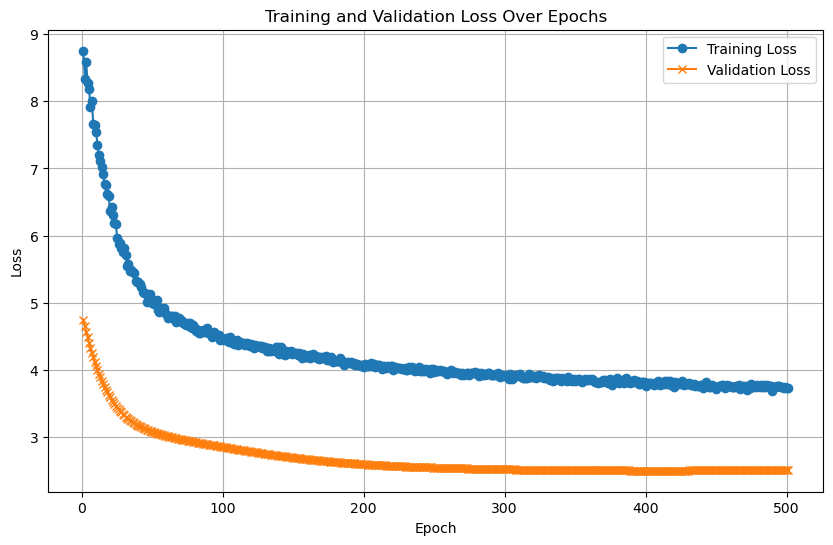

In [36]:
tscl_model = SupConNet().to(device)
tscl_criterion = SupConLoss(temperature=0.07).to(device)
tscl_optimizer = optim.Adam(tscl_model.parameters(), lr=1e-4, weight_decay=1e-5)  # Increased learning rate

tscl_patience = 100
tscl_best_val_loss = float('inf')
tscl_epochs_without_improvement = 0

tscl_num_epochs = 2000
tscl_train_losses = []
tscl_val_losses = []

# TRAINING
for tscl_epoch in range(tscl_num_epochs):
    print(f"\nLOG: Epoch [{tscl_epoch + 1}/{tscl_num_epochs}] - Training")
    tscl_model.train()
    tscl_total_loss = 0

    for batch_idx, (vectors, labels) in enumerate(tscl_train_loader):
        vectors = vectors.to(device).float()  # moving input tensors to GPU
        labels = labels.to(device)  # moving labels to GPU

        # forward pass to get projections
        projections = tscl_model(vectors)

        # calc contrastive loss
        loss = tscl_criterion(projections, labels)

        # backprop and optimization
        tscl_optimizer.zero_grad()
        loss.backward()
        tscl_optimizer.step()

        tscl_total_loss += loss.item()

        if (batch_idx + 1) % 1 == 0:
            print(f"    Batch [{batch_idx + 1}/{len(tscl_train_loader)}], "
                  f"Train Loss: {loss.item():.4f}")

    # calc avg training loss for the epoch
    tscl_avg_train_loss = tscl_total_loss / len(tscl_train_loader)
    tscl_train_losses.append(tscl_avg_train_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Train Loss: {tscl_avg_train_loss:.4f}")

    # VALIDATION
    tscl_model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for batch_idx, (vectors, labels) in enumerate(tscl_val_loader):
            vectors = vectors.to(device).float()
            labels = labels.to(device)

            projections = tscl_model(vectors)

            loss = tscl_criterion(projections, labels)
            total_val_loss += loss.item()

            if (batch_idx + 1) % 10 == 0:
                print(f"    Batch [{batch_idx + 1}/{len(tscl_val_loader)}], "
                      f"Val Loss: {loss.item():.4f}")

    tscl_avg_val_loss = total_val_loss / len(tscl_val_loader)
    tscl_val_losses.append(tscl_avg_val_loss)
    print(f"Epoch [{tscl_epoch + 1}/{tscl_num_epochs}], "
          f"Avg Val Loss: {tscl_avg_val_loss:.4f}")

    # early stopping logic
    if tscl_avg_val_loss < tscl_best_val_loss:
        print(f"Validation loss improved from {tscl_best_val_loss:.4f} to {tscl_avg_val_loss:.4f}. Saving model...")
        tscl_best_val_loss = tscl_avg_val_loss
        tscl_epochs_without_improvement = 0
    else:
        tscl_epochs_without_improvement += 1
        print(f"Validation loss did not improve. Patience: {tscl_epochs_without_improvement}/{tscl_patience}")

    # stopping training if validation loss hasn't improved for patience amount of epochs
    if tscl_epochs_without_improvement >= tscl_patience:
        print(f"Early stopping triggered at epoch {tscl_epoch + 1}. No improvement for {tscl_patience} epochs.")
        break

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(tscl_train_losses) + 1), tscl_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(tscl_val_losses) + 1), tscl_val_losses, label="Validation Loss", marker='x')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.grid()
plt.show()

Test Batch [10/166], Loss: 4.7242
Test Batch [20/166], Loss: 4.8196
Test Batch [30/166], Loss: 4.7254


Test Batch [40/166], Loss: 4.7239
Test Batch [50/166], Loss: 4.8024
Test Batch [60/166], Loss: 4.4467
Test Batch [70/166], Loss: 4.4580
Test Batch [80/166], Loss: 4.9120
Test Batch [90/166], Loss: 5.1880
Test Batch [100/166], Loss: 5.1378
Test Batch [110/166], Loss: 4.8895
Test Batch [120/166], Loss: 4.6278
Test Batch [130/166], Loss: 4.6831
Test Batch [140/166], Loss: 4.8160
Test Batch [150/166], Loss: 5.2637


Test Batch [160/166], Loss: 6.4146

Test Loss: 4.8596


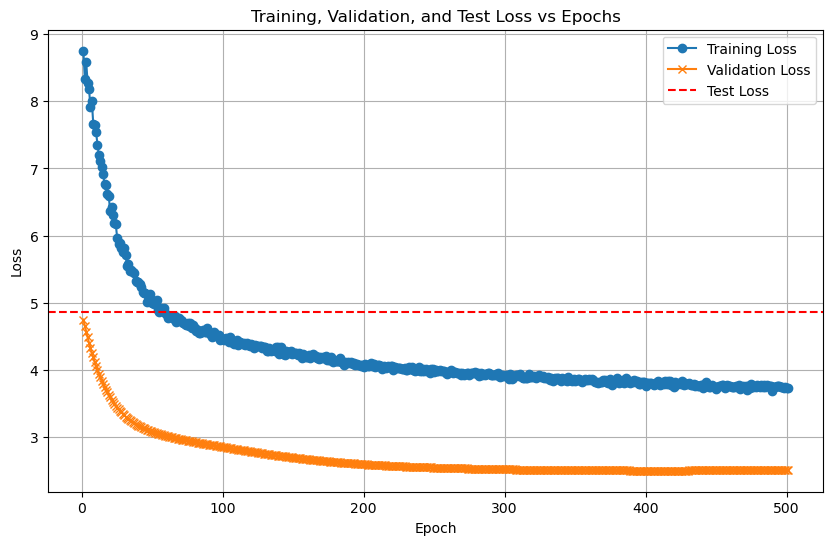

In [37]:
# Test Evaluation
tscl_model.eval()
total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(tscl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = tscl_model(vectors)
        loss = criterion(projections, labels)
        total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(tscl_test_loader)}], Loss: {loss.item():.4f}")

avg_test_loss = total_test_loss / len(tscl_test_loader)
print(f"\nTest Loss: {avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
epochs = range(1, len(tscl_train_losses) + 1)
plt.plot(epochs, tscl_train_losses, label="Training Loss", marker='o')
plt.plot(epochs, tscl_val_losses, label="Validation Loss", marker='x')
# test loss = horizontal dashed line
plt.axhline(y=avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving representations learnt by Typical SCL Model

In [38]:
# dir to save the SCL representations
tscl_rep_dir = "tscl_representations"
os.makedirs(tscl_rep_dir, exist_ok=True)

tscl_loaders = {
    'train': tscl_train_loader,
    'val': tscl_val_loader,
    'test': tscl_test_loader
}

tscl_model.eval()

with torch.no_grad():
    for tscl_split_name, tscl_loader in tscl_loaders.items():
        print(f"\nExtracting SCL representations for the {tscl_split_name} dataset...")
        # creating subfolder for the split
        tscl_split_dir = os.path.join(tscl_rep_dir, tscl_split_name)
        os.makedirs(tscl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for tscl_batch_idx, (tscl_vectors, tscl_labels) in enumerate(tscl_loader):
            tscl_vectors = tscl_vectors.to(device).float()
            # computing projections using the trained SCL model
            tscl_projections = tscl_model(tscl_vectors)
            
            # converting projections and labels to np arrays
            tscl_projections_np = tscl_projections.cpu().numpy()
            tscl_labels_np = tscl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(tscl_split_dir, f"scl_encoded_batch_{tscl_batch_idx}.npy"), tscl_projections_np)
            np.save(os.path.join(tscl_split_dir, f"scl_labels_batch_{tscl_batch_idx}.npy"), tscl_labels_np)
            
            if (tscl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {tscl_batch_idx + 1}/{len(tscl_loader)} for {tscl_split_name} dataset.")

        print(f"Completed extraction for the {tscl_split_name} dataset. Representations saved in '{tscl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'tscl_representations\train'.

Extracting SCL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'tscl_representations\val'.

Extracting SCL representations for the test dataset...
  Processed batch 10/166 for test dataset.
  Processed batch 20/166 for test dataset.


  Processed batch 30/166 for test dataset.


  Processed batch 40/166 for test dataset.
  Processed batch 50/166 for test dataset.
  Processed batch 60/166 for test dataset.


  Processed batch 70/166 for test dataset.
  Processed batch 80/166 for test dataset.
  Processed batch 90/166 for test dataset.


  Processed batch 100/166 for test dataset.
  Processed batch 110/166 for test dataset.
  Processed batch 120/166 for test dataset.


  Processed batch 130/166 for test dataset.
  Processed batch 140/166 for test dataset.
  Processed batch 150/166 for test dataset.


  Processed batch 160/166 for test dataset.
Completed extraction for the test dataset. Representations saved in 'tscl_representations\test'.
SCL representations extraction complete.


### Classifying representations learnt by SCL Model with LRM

In [39]:
def load_tscl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    tscl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    tscl_all_reps = []
    tscl_all_labels = []

    for tscl_rep_file in tscl_rep_files:
        #deriving label filenames
        tscl_label_file = tscl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        tscl_reps = np.load(tscl_rep_file)
        tscl_labels = np.load(tscl_label_file)

        tscl_all_reps.append(tscl_reps)
        tscl_all_labels.append(tscl_labels)

    #concat along first dim
    tscl_all_reps = np.concatenate(tscl_all_reps, axis = 0)
    tscl_all_labels = np.concatenate(tscl_all_labels, axis = 0)

    return tscl_all_reps, tscl_all_labels

In [40]:
tscl_lrm_train_dir = os.path.join("tscl_representations", "train")
tscl_lrm_val_dir   = os.path.join("tscl_representations", "val")
tscl_lrm_test_dir  = os.path.join("tscl_representations", "test")

tscl_lrm_train_reps, tscl_lrm_train_labels = load_tscl_reps_and_labels(tscl_lrm_train_dir)
tscl_lrm_val_reps, tscl_lrm_val_labels = load_tscl_reps_and_labels(tscl_lrm_val_dir)
tscl_lrm_test_reps, tscl_lrm_test_labels = load_tscl_reps_and_labels(tscl_lrm_test_dir)

print("Train reps shape:", tscl_lrm_train_reps.shape)
print("Train labels shape:", tscl_lrm_train_labels.shape)

print("Val reps shape:", tscl_lrm_val_reps.shape)
print("Val labels shape:", tscl_lrm_val_labels.shape)

print("Test reps shape:", tscl_lrm_test_reps.shape)
print("Test labels shape:", tscl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [41]:
# training LRM on the tscl representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
tscl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
tscl_logistic_clf.fit(tscl_lrm_train_reps, tscl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# eval on val set
print("\nLOG: Evaluating on the validation set...")
tscl_lrm_val_predictions = tscl_logistic_clf.predict(tscl_lrm_val_reps)
tscl_lrm_val_accuracy = accuracy_score(tscl_lrm_val_labels, tscl_lrm_val_predictions)
print(f"Validation Accuracy: {tscl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(tscl_lrm_val_labels, tscl_lrm_val_predictions))

# eval on test
print("\nLOG: Evaluating on the test set...")
tscl_lrm_test_predictions = tscl_logistic_clf.predict(tscl_lrm_test_reps)
tscl_lrm_test_accuracy = accuracy_score(tscl_lrm_test_labels, tscl_lrm_test_predictions)
print(f"Test Accuracy: {tscl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(tscl_lrm_test_labels, tscl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'tscl_lrm_predictions.npy'), tscl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'tscl_lrm_true_labels.npy'), tscl_lrm_test_labels)
print(f"Saved CAE+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 82.22%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.60      0.67         5
           1       1.00      0.80      0.89         5
           2       0.67      0.80      0.73         5
           3       0.83      1.00      0.91         5
           4       1.00      1.00      1.00         5
           5       0.80      0.80      0.80         5
           6       0.67      0.80      0.73         5
           7       0.75      0.60      0.67         5
           8       1.00      1.00      1.00         5

    accuracy                           0.82        45
   macro avg       0.83      0.82      0.82        45
weighted avg       0.83      0.82      0.82        45


LOG: Evaluating on the test set...
Test Accuracy: 69.55%

Test Classifica

### Classifying the representations learnt by Typical SCL Model with MLP Classifier

In [42]:
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, num_classes)
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules(): 
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.constant_(m.bias, 0)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return self.fc4(x)

In [43]:
tscl_mlp_train_dir = os.path.join("tscl_representations", "train")
tscl_mlp_val_dir   = os.path.join("tscl_representations", "val")
tscl_mlp_test_dir  = os.path.join("tscl_representations", "test")

tscl_mlp_train_reps, tscl_mlp_train_labels = load_tscl_reps_and_labels(tscl_mlp_train_dir)
tscl_mlp_val_reps, tscl_mlp_val_labels = load_tscl_reps_and_labels(tscl_mlp_val_dir)
tscl_mlp_test_reps, tscl_mlp_test_labels = load_tscl_reps_and_labels(tscl_mlp_test_dir)

print("Train reps shape:",tscl_mlp_train_reps.shape)
print("Train labels shape:", tscl_mlp_train_labels.shape)

print("Val reps shape:", tscl_mlp_val_reps.shape)
print("Val labels shape:", tscl_mlp_val_labels.shape)

print("Test reps shape:", tscl_mlp_test_reps.shape)
print("Test labels shape:", tscl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [44]:
#converting arrays to torch tensors
tscl_mlp_train_embeddings_torch = torch.tensor(tscl_mlp_train_reps, dtype=torch.float32)
tscl_mlp_train_labels_torch = torch.tensor(tscl_mlp_train_labels, dtype=torch.long)

tscl_mlp_val_embeddings_torch = torch.tensor(tscl_mlp_val_reps, dtype=torch.float32)
tscl_mlp_val_labels_torch = torch.tensor(tscl_mlp_val_labels, dtype=torch.long)

tscl_mlp_test_embeddings_torch = torch.tensor(tscl_mlp_test_reps, dtype=torch.float32)
tscl_mlp_test_labels_torch = torch.tensor(tscl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
tscl_mlp_train_dataset = TensorDataset(tscl_mlp_train_embeddings_torch, tscl_mlp_train_labels_torch)
tscl_mlp_val_dataset = TensorDataset(tscl_mlp_val_embeddings_torch, tscl_mlp_val_labels_torch)
tscl_mlp_test_dataset = TensorDataset(tscl_mlp_test_embeddings_torch, tscl_mlp_test_labels_torch)

tscl_mlp_batch_size = 64
tscl_mlp_train_loader = DataLoader(tscl_mlp_train_dataset, batch_size=tscl_mlp_batch_size, shuffle=True)
tscl_mlp_val_loader = DataLoader(tscl_mlp_val_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)
tscl_mlp_test_loader = DataLoader(tscl_mlp_test_dataset, batch_size=tscl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.3949  |  Val Loss: 2.3193
Validation loss improved from inf to 2.3193.
[Epoch 2/1000] Train Loss: 2.3258  |  Val Loss: 2.2613
Validation loss improved from 2.3193 to 2.2613.
[Epoch 3/1000] Train Loss: 2.2613  |  Val Loss: 2.2153
Validation loss improved from 2.2613 to 2.2153.
[Epoch 4/1000] Train Loss: 2.2136  |  Val Loss: 2.1761
Validation loss improved from 2.2153 to 2.1761.
[Epoch 5/1000] Train Loss: 2.1696  |  Val Loss: 2.1403
Validation loss improved from 2.1761 to 2.1403.
[Epoch 6/1000] Train Loss: 2.1314  |  Val Loss: 2.1078
Validation loss improved from 2.1403 to 2.1078.
[Epoch 7/1000] Train Loss: 2.0963  |  Val Loss: 2.0771
Validation loss improved from 2.1078 to 2.0771.
[Epoch 8/1000] Train Loss: 2.0636  |  Val Loss: 2.0496
Validation loss improved from 2.0771 to 2.0496.
[Epoch 9/1000] Train Loss: 2.0349  |  Val Loss: 2.0267
Validation loss improved from 2.0496 to 2.0267.
[Epoch 10/1000] Train Loss: 2.0080  |  Val Loss: 2.0032
Validation loss impr

[Epoch 16/1000] Train Loss: 1.8486  |  Val Loss: 1.8632
Validation loss improved from 1.8858 to 1.8632.
[Epoch 17/1000] Train Loss: 1.8235  |  Val Loss: 1.8406
Validation loss improved from 1.8632 to 1.8406.
[Epoch 18/1000] Train Loss: 1.7978  |  Val Loss: 1.8181
Validation loss improved from 1.8406 to 1.8181.
[Epoch 19/1000] Train Loss: 1.7728  |  Val Loss: 1.7952
Validation loss improved from 1.8181 to 1.7952.
[Epoch 20/1000] Train Loss: 1.7483  |  Val Loss: 1.7725
Validation loss improved from 1.7952 to 1.7725.
[Epoch 21/1000] Train Loss: 1.7239  |  Val Loss: 1.7501
Validation loss improved from 1.7725 to 1.7501.
[Epoch 22/1000] Train Loss: 1.6996  |  Val Loss: 1.7277
Validation loss improved from 1.7501 to 1.7277.
[Epoch 23/1000] Train Loss: 1.6757  |  Val Loss: 1.7055
Validation loss improved from 1.7277 to 1.7055.
[Epoch 24/1000] Train Loss: 1.6519  |  Val Loss: 1.6839
Validation loss improved from 1.7055 to 1.6839.
[Epoch 25/1000] Train Loss: 1.6278  |  Val Loss: 1.6617
Validati

[Epoch 33/1000] Train Loss: 1.4231  |  Val Loss: 1.4713
Validation loss improved from 1.4965 to 1.4713.
[Epoch 34/1000] Train Loss: 1.3969  |  Val Loss: 1.4460
Validation loss improved from 1.4713 to 1.4460.
[Epoch 35/1000] Train Loss: 1.3708  |  Val Loss: 1.4209
Validation loss improved from 1.4460 to 1.4209.
[Epoch 36/1000] Train Loss: 1.3454  |  Val Loss: 1.3967
Validation loss improved from 1.4209 to 1.3967.
[Epoch 37/1000] Train Loss: 1.3199  |  Val Loss: 1.3727
Validation loss improved from 1.3967 to 1.3727.
[Epoch 38/1000] Train Loss: 1.2937  |  Val Loss: 1.3488
Validation loss improved from 1.3727 to 1.3488.
[Epoch 39/1000] Train Loss: 1.2685  |  Val Loss: 1.3241
Validation loss improved from 1.3488 to 1.3241.
[Epoch 40/1000] Train Loss: 1.2433  |  Val Loss: 1.3000
Validation loss improved from 1.3241 to 1.3000.
[Epoch 41/1000] Train Loss: 1.2179  |  Val Loss: 1.2769
Validation loss improved from 1.3000 to 1.2769.
[Epoch 42/1000] Train Loss: 1.1932  |  Val Loss: 1.2528
Validati

[Epoch 49/1000] Train Loss: 1.0284  |  Val Loss: 1.1023
Validation loss improved from 1.1224 to 1.1023.
[Epoch 50/1000] Train Loss: 1.0063  |  Val Loss: 1.0813
Validation loss improved from 1.1023 to 1.0813.
[Epoch 51/1000] Train Loss: 0.9845  |  Val Loss: 1.0623
Validation loss improved from 1.0813 to 1.0623.
[Epoch 52/1000] Train Loss: 0.9638  |  Val Loss: 1.0442
Validation loss improved from 1.0623 to 1.0442.
[Epoch 53/1000] Train Loss: 0.9438  |  Val Loss: 1.0264
Validation loss improved from 1.0442 to 1.0264.
[Epoch 54/1000] Train Loss: 0.9245  |  Val Loss: 1.0080
Validation loss improved from 1.0264 to 1.0080.
[Epoch 55/1000] Train Loss: 0.9061  |  Val Loss: 0.9902
Validation loss improved from 1.0080 to 0.9902.
[Epoch 56/1000] Train Loss: 0.8885  |  Val Loss: 0.9744
Validation loss improved from 0.9902 to 0.9744.
[Epoch 57/1000] Train Loss: 0.8706  |  Val Loss: 0.9586
Validation loss improved from 0.9744 to 0.9586.
[Epoch 58/1000] Train Loss: 0.8541  |  Val Loss: 0.9436
Validati

[Epoch 66/1000] Train Loss: 0.7367  |  Val Loss: 0.8379
Validation loss improved from 0.8497 to 0.8379.
[Epoch 67/1000] Train Loss: 0.7240  |  Val Loss: 0.8263
Validation loss improved from 0.8379 to 0.8263.
[Epoch 68/1000] Train Loss: 0.7117  |  Val Loss: 0.8155
Validation loss improved from 0.8263 to 0.8155.
[Epoch 69/1000] Train Loss: 0.6994  |  Val Loss: 0.8046
Validation loss improved from 0.8155 to 0.8046.
[Epoch 70/1000] Train Loss: 0.6877  |  Val Loss: 0.7940
Validation loss improved from 0.8046 to 0.7940.
[Epoch 71/1000] Train Loss: 0.6762  |  Val Loss: 0.7833
Validation loss improved from 0.7940 to 0.7833.
[Epoch 72/1000] Train Loss: 0.6649  |  Val Loss: 0.7727
Validation loss improved from 0.7833 to 0.7727.
[Epoch 73/1000] Train Loss: 0.6542  |  Val Loss: 0.7628
Validation loss improved from 0.7727 to 0.7628.
[Epoch 74/1000] Train Loss: 0.6437  |  Val Loss: 0.7533
Validation loss improved from 0.7628 to 0.7533.
[Epoch 75/1000] Train Loss: 0.6340  |  Val Loss: 0.7441
Validati

[Epoch 83/1000] Train Loss: 0.5641  |  Val Loss: 0.6806
Validation loss improved from 0.6883 to 0.6806.
[Epoch 84/1000] Train Loss: 0.5566  |  Val Loss: 0.6743
Validation loss improved from 0.6806 to 0.6743.
[Epoch 85/1000] Train Loss: 0.5493  |  Val Loss: 0.6676
Validation loss improved from 0.6743 to 0.6676.
[Epoch 86/1000] Train Loss: 0.5420  |  Val Loss: 0.6613
Validation loss improved from 0.6676 to 0.6613.
[Epoch 87/1000] Train Loss: 0.5353  |  Val Loss: 0.6547
Validation loss improved from 0.6613 to 0.6547.
[Epoch 88/1000] Train Loss: 0.5288  |  Val Loss: 0.6494
Validation loss improved from 0.6547 to 0.6494.
[Epoch 89/1000] Train Loss: 0.5226  |  Val Loss: 0.6435
Validation loss improved from 0.6494 to 0.6435.
[Epoch 90/1000] Train Loss: 0.5165  |  Val Loss: 0.6383
Validation loss improved from 0.6435 to 0.6383.
[Epoch 91/1000] Train Loss: 0.5101  |  Val Loss: 0.6324
Validation loss improved from 0.6383 to 0.6324.
[Epoch 92/1000] Train Loss: 0.5045  |  Val Loss: 0.6267
Validati

[Epoch 101/1000] Train Loss: 0.4596  |  Val Loss: 0.5901
Validation loss improved from 0.5936 to 0.5901.
[Epoch 102/1000] Train Loss: 0.4552  |  Val Loss: 0.5865
Validation loss improved from 0.5901 to 0.5865.
[Epoch 103/1000] Train Loss: 0.4510  |  Val Loss: 0.5823
Validation loss improved from 0.5865 to 0.5823.
[Epoch 104/1000] Train Loss: 0.4470  |  Val Loss: 0.5797
Validation loss improved from 0.5823 to 0.5797.
[Epoch 105/1000] Train Loss: 0.4430  |  Val Loss: 0.5773
Validation loss improved from 0.5797 to 0.5773.
[Epoch 106/1000] Train Loss: 0.4395  |  Val Loss: 0.5750
Validation loss improved from 0.5773 to 0.5750.
[Epoch 107/1000] Train Loss: 0.4361  |  Val Loss: 0.5716
Validation loss improved from 0.5750 to 0.5716.
[Epoch 108/1000] Train Loss: 0.4325  |  Val Loss: 0.5690
Validation loss improved from 0.5716 to 0.5690.
[Epoch 109/1000] Train Loss: 0.4290  |  Val Loss: 0.5673
Validation loss improved from 0.5690 to 0.5673.
[Epoch 110/1000] Train Loss: 0.4257  |  Val Loss: 0.564

[Epoch 119/1000] Train Loss: 0.3994  |  Val Loss: 0.5453
Validation loss improved from 0.5475 to 0.5453.
[Epoch 120/1000] Train Loss: 0.3969  |  Val Loss: 0.5440
Validation loss improved from 0.5453 to 0.5440.
[Epoch 121/1000] Train Loss: 0.3944  |  Val Loss: 0.5428
Validation loss improved from 0.5440 to 0.5428.
[Epoch 122/1000] Train Loss: 0.3920  |  Val Loss: 0.5411
Validation loss improved from 0.5428 to 0.5411.
[Epoch 123/1000] Train Loss: 0.3897  |  Val Loss: 0.5406
Validation loss improved from 0.5411 to 0.5406.
[Epoch 124/1000] Train Loss: 0.3877  |  Val Loss: 0.5395
Validation loss improved from 0.5406 to 0.5395.
[Epoch 125/1000] Train Loss: 0.3856  |  Val Loss: 0.5378
Validation loss improved from 0.5395 to 0.5378.
[Epoch 126/1000] Train Loss: 0.3834  |  Val Loss: 0.5344
Validation loss improved from 0.5378 to 0.5344.
[Epoch 127/1000] Train Loss: 0.3811  |  Val Loss: 0.5332
Validation loss improved from 0.5344 to 0.5332.
[Epoch 128/1000] Train Loss: 0.3792  |  Val Loss: 0.531

[Epoch 136/1000] Train Loss: 0.3648  |  Val Loss: 0.5245
Validation loss improved from 0.5263 to 0.5245.
[Epoch 137/1000] Train Loss: 0.3635  |  Val Loss: 0.5232
Validation loss improved from 0.5245 to 0.5232.
[Epoch 138/1000] Train Loss: 0.3617  |  Val Loss: 0.5221
Validation loss improved from 0.5232 to 0.5221.
[Epoch 139/1000] Train Loss: 0.3604  |  Val Loss: 0.5217
Validation loss improved from 0.5221 to 0.5217.
[Epoch 140/1000] Train Loss: 0.3589  |  Val Loss: 0.5201
Validation loss improved from 0.5217 to 0.5201.
[Epoch 141/1000] Train Loss: 0.3576  |  Val Loss: 0.5194
Validation loss improved from 0.5201 to 0.5194.
[Epoch 142/1000] Train Loss: 0.3559  |  Val Loss: 0.5195
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 143/1000] Train Loss: 0.3547  |  Val Loss: 0.5187
Validation loss improved from 0.5194 to 0.5187.
[Epoch 144/1000] Train Loss: 0.3537  |  Val Loss: 0.5193
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 145/1000] Train Loss: 0.3519  |  Val

[Epoch 154/1000] Train Loss: 0.3415  |  Val Loss: 0.5119
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 155/1000] Train Loss: 0.3405  |  Val Loss: 0.5121
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 156/1000] Train Loss: 0.3396  |  Val Loss: 0.5129
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 157/1000] Train Loss: 0.3386  |  Val Loss: 0.5109
Validation loss improved from 0.5116 to 0.5109.
[Epoch 158/1000] Train Loss: 0.3376  |  Val Loss: 0.5100
Validation loss improved from 0.5109 to 0.5100.
[Epoch 159/1000] Train Loss: 0.3366  |  Val Loss: 0.5105
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 160/1000] Train Loss: 0.3358  |  Val Loss: 0.5100
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 161/1000] Train Loss: 0.3349  |  Val Loss: 0.5094
Validation loss improved from 0.5100 to 0.5094.
[Epoch 162/1000] Train Loss: 0.3339  |  Val Loss: 0.5090
Validation loss improved from 0.5094 to 0.5090.
[Epoch 163/1000] Train Lo

[Epoch 171/1000] Train Loss: 0.3268  |  Val Loss: 0.5052
Validation loss improved from 0.5052 to 0.5052.
[Epoch 172/1000] Train Loss: 0.3262  |  Val Loss: 0.5067
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 173/1000] Train Loss: 0.3256  |  Val Loss: 0.5056
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 174/1000] Train Loss: 0.3246  |  Val Loss: 0.5066
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 175/1000] Train Loss: 0.3240  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 176/1000] Train Loss: 0.3233  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 177/1000] Train Loss: 0.3228  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 178/1000] Train Loss: 0.3220  |  Val Loss: 0.5051
Validation loss improved from 0.5052 to 0.5051.
[Epoch 179/1000] Train Loss: 0.3213  |  Val Loss: 0.5033
Validation loss improved from 0.5051 to 0.5033.
[Epoch 180/1000] Tr

[Epoch 188/1000] Train Loss: 0.3161  |  Val Loss: 0.5011
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 189/1000] Train Loss: 0.3153  |  Val Loss: 0.5007
Validation loss improved from 0.5010 to 0.5007.
[Epoch 190/1000] Train Loss: 0.3149  |  Val Loss: 0.5013
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 191/1000] Train Loss: 0.3145  |  Val Loss: 0.4998
Validation loss improved from 0.5007 to 0.4998.
[Epoch 192/1000] Train Loss: 0.3137  |  Val Loss: 0.4990
Validation loss improved from 0.4998 to 0.4990.
[Epoch 193/1000] Train Loss: 0.3132  |  Val Loss: 0.4996
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 194/1000] Train Loss: 0.3126  |  Val Loss: 0.5007
!! Validation loss did NOT improve !! Patience: 2/100
[Epoch 195/1000] Train Loss: 0.3122  |  Val Loss: 0.5008
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 196/1000] Train Loss: 0.3117  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 197/1000] Tr

[Epoch 203/1000] Train Loss: 0.3085  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 3/100
[Epoch 204/1000] Train Loss: 0.3082  |  Val Loss: 0.5000
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 205/1000] Train Loss: 0.3080  |  Val Loss: 0.4992
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 206/1000] Train Loss: 0.3072  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 207/1000] Train Loss: 0.3069  |  Val Loss: 0.4999
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 208/1000] Train Loss: 0.3063  |  Val Loss: 0.4996
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 209/1000] Train Loss: 0.3058  |  Val Loss: 0.4969
Validation loss improved from 0.4973 to 0.4969.
[Epoch 210/1000] Train Loss: 0.3050  |  Val Loss: 0.4966
Validation loss improved from 0.4969 to 0.4966.
[Epoch 211/1000] Train Loss: 0.3045  |  Val Loss: 0.4973
!! Validation loss did NOT improve !! Patience: 1/100
[Epoch 212/10

[Epoch 219/1000] Train Loss: 0.3010  |  Val Loss: 0.5010
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 220/1000] Train Loss: 0.3008  |  Val Loss: 0.5012
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 221/1000] Train Loss: 0.3005  |  Val Loss: 0.5018
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 222/1000] Train Loss: 0.3000  |  Val Loss: 0.5022
!! Validation loss did NOT improve !! Patience: 12/100
[Epoch 223/1000] Train Loss: 0.3000  |  Val Loss: 0.5008
!! Validation loss did NOT improve !! Patience: 13/100
[Epoch 224/1000] Train Loss: 0.2991  |  Val Loss: 0.4990
!! Validation loss did NOT improve !! Patience: 14/100
[Epoch 225/1000] Train Loss: 0.2988  |  Val Loss: 0.4976
!! Validation loss did NOT improve !! Patience: 15/100
[Epoch 226/1000] Train Loss: 0.2986  |  Val Loss: 0.4981
!! Validation loss did NOT improve !! Patience: 16/100
[Epoch 227/1000] Train Loss: 0.2982  |  Val Loss: 0.4998
!! Validation loss did NOT improve !! Patience: 

[Epoch 235/1000] Train Loss: 0.2957  |  Val Loss: 0.5000
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 236/1000] Train Loss: 0.2955  |  Val Loss: 0.5006
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 237/1000] Train Loss: 0.2951  |  Val Loss: 0.5019
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 238/1000] Train Loss: 0.2951  |  Val Loss: 0.5027
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 239/1000] Train Loss: 0.2946  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 29/100
[Epoch 240/1000] Train Loss: 0.2944  |  Val Loss: 0.4995
!! Validation loss did NOT improve !! Patience: 30/100
[Epoch 241/1000] Train Loss: 0.2939  |  Val Loss: 0.4997
!! Validation loss did NOT improve !! Patience: 31/100
[Epoch 242/1000] Train Loss: 0.2939  |  Val Loss: 0.5016
!! Validation loss did NOT improve !! Patience: 32/100
[Epoch 243/1000] Train Loss: 0.2934  |  Val Loss: 0.5020
!! Validation loss did NOT improve !! Patience:

[Epoch 250/1000] Train Loss: 0.2914  |  Val Loss: 0.5035
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 251/1000] Train Loss: 0.2912  |  Val Loss: 0.5028
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 252/1000] Train Loss: 0.2908  |  Val Loss: 0.5006
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 253/1000] Train Loss: 0.2907  |  Val Loss: 0.5021
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 254/1000] Train Loss: 0.2908  |  Val Loss: 0.5012
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 255/1000] Train Loss: 0.2900  |  Val Loss: 0.5002
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 256/1000] Train Loss: 0.2899  |  Val Loss: 0.5024
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 257/1000] Train Loss: 0.2897  |  Val Loss: 0.5035
!! Validation loss did NOT improve !! Patience: 47/100
[Epoch 258/1000] Train Loss: 0.2901  |  Val Loss: 0.5033
!! Validation loss did NOT improve !! Patience:

[Epoch 268/1000] Train Loss: 0.2870  |  Val Loss: 0.4988
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 269/1000] Train Loss: 0.2868  |  Val Loss: 0.4974
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 270/1000] Train Loss: 0.2862  |  Val Loss: 0.5009
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 271/1000] Train Loss: 0.2865  |  Val Loss: 0.5046
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 272/1000] Train Loss: 0.2860  |  Val Loss: 0.5071
!! Validation loss did NOT improve !! Patience: 62/100
[Epoch 273/1000] Train Loss: 0.2860  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 63/100
[Epoch 274/1000] Train Loss: 0.2858  |  Val Loss: 0.5049
!! Validation loss did NOT improve !! Patience: 64/100
[Epoch 275/1000] Train Loss: 0.2855  |  Val Loss: 0.5020
!! Validation loss did NOT improve !! Patience: 65/100
[Epoch 276/1000] Train Loss: 0.2852  |  Val Loss: 0.5029
!! Validation loss did NOT improve !! Patience:

[Epoch 285/1000] Train Loss: 0.2832  |  Val Loss: 0.5050
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 286/1000] Train Loss: 0.2827  |  Val Loss: 0.5060
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 287/1000] Train Loss: 0.2826  |  Val Loss: 0.5059
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 288/1000] Train Loss: 0.2823  |  Val Loss: 0.5061
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 289/1000] Train Loss: 0.2821  |  Val Loss: 0.5065
!! Validation loss did NOT improve !! Patience: 79/100
[Epoch 290/1000] Train Loss: 0.2820  |  Val Loss: 0.5046
!! Validation loss did NOT improve !! Patience: 80/100
[Epoch 291/1000] Train Loss: 0.2817  |  Val Loss: 0.5051
!! Validation loss did NOT improve !! Patience: 81/100
[Epoch 292/1000] Train Loss: 0.2816  |  Val Loss: 0.5067
!! Validation loss did NOT improve !! Patience: 82/100
[Epoch 293/1000] Train Loss: 0.2815  |  Val Loss: 0.5055
!! Validation loss did NOT improve !! Patience:

[Epoch 303/1000] Train Loss: 0.2791  |  Val Loss: 0.5054
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 304/1000] Train Loss: 0.2796  |  Val Loss: 0.5049
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 305/1000] Train Loss: 0.2788  |  Val Loss: 0.5084
!! Validation loss did NOT improve !! Patience: 95/100
[Epoch 306/1000] Train Loss: 0.2785  |  Val Loss: 0.5068
!! Validation loss did NOT improve !! Patience: 96/100
[Epoch 307/1000] Train Loss: 0.2782  |  Val Loss: 0.5070
!! Validation loss did NOT improve !! Patience: 97/100
[Epoch 308/1000] Train Loss: 0.2783  |  Val Loss: 0.5069
!! Validation loss did NOT improve !! Patience: 98/100
[Epoch 309/1000] Train Loss: 0.2779  |  Val Loss: 0.5073
!! Validation loss did NOT improve !! Patience: 99/100
[Epoch 310/1000] Train Loss: 0.2776  |  Val Loss: 0.5078
!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 310 !!
No improvement for 100 epochs.


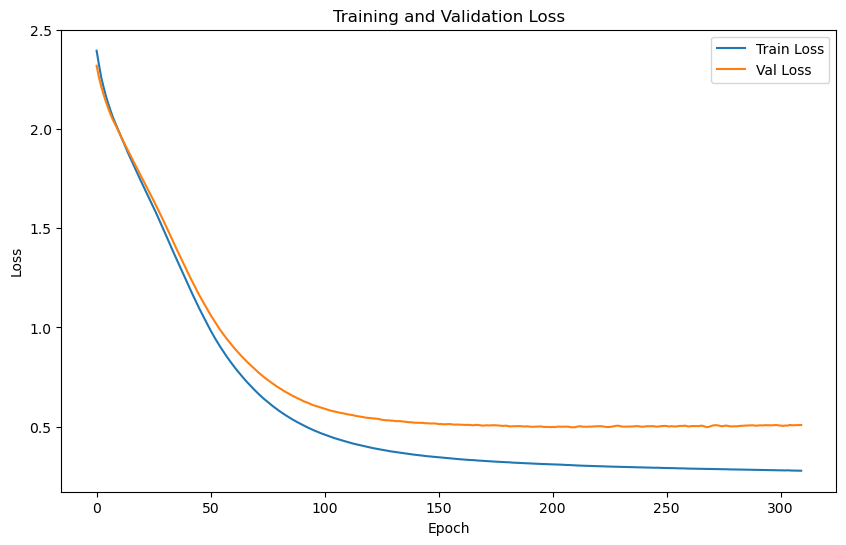

In [45]:
tscl_mlp_input_dim = tscl_mlp_train_reps.shape[1]
tscl_mlp_num_classes = len(torch.unique(tscl_mlp_train_labels_torch))
tscl_mlp_model = MLPClassifier(tscl_mlp_input_dim, tscl_mlp_num_classes).to(device)

tscl_mlp_criterion = nn.CrossEntropyLoss()
tscl_mlp_optimizer = optim.Adam(tscl_mlp_model.parameters(), lr=1e-4)

tscl_mlp_num_epochs = 1000
tscl_mlp_patience = 100

tscl_mlp_train_losses = []
tscl_mlp_val_losses = []

tscl_mlp_best_val_loss = float('inf')
tscl_mlp_epochs_without_improvement = 0

for tscl_mlp_epoch in range(tscl_mlp_num_epochs):
    # Training
    tscl_mlp_model.train()
    tscl_mlp_train_running_loss = 0.0
    
    for tscl_mlp_embeddings_batch, tscl_mlp_labels_batch in tscl_mlp_train_loader:
        tscl_mlp_embeddings_batch = tscl_mlp_embeddings_batch.to(device)
        tscl_mlp_labels_batch = tscl_mlp_labels_batch.to(device)
        
        tscl_mlp_optimizer.zero_grad()
        
        # Forward
        tscl_mlp_outputs = tscl_mlp_model(tscl_mlp_embeddings_batch)
        tscl_mlp_loss = tscl_mlp_criterion(tscl_mlp_outputs, tscl_mlp_labels_batch)
        
        # Backward & Update
        tscl_mlp_loss.backward()
        tscl_mlp_optimizer.step()
        
        tscl_mlp_train_running_loss += tscl_mlp_loss.item() * tscl_mlp_embeddings_batch.size(0)
    
    tscl_mlp_epoch_train_loss = tscl_mlp_train_running_loss / len(tscl_mlp_train_loader.dataset)
    tscl_mlp_train_losses.append(tscl_mlp_epoch_train_loss)

    # Validation
    tscl_mlp_model.eval()
    tscl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for tscl_mlp_val_embeddings_batch, tscl_mlp_val_labels_batch in tscl_mlp_val_loader:
            tscl_mlp_val_embeddings_batch = tscl_mlp_val_embeddings_batch.to(device)
            tscl_mlp_val_labels_batch = tscl_mlp_val_labels_batch.to(device)

            tscl_mlp_val_outputs = tscl_mlp_model(tscl_mlp_val_embeddings_batch)
            tscl_mlp_val_loss = tscl_mlp_criterion(tscl_mlp_val_outputs, tscl_mlp_val_labels_batch)

            tscl_mlp_val_running_loss += tscl_mlp_val_loss.item() * tscl_mlp_val_embeddings_batch.size(0)

    tscl_mlp_epoch_val_loss = tscl_mlp_val_running_loss / len(tscl_mlp_val_loader.dataset)
    tscl_mlp_val_losses.append(tscl_mlp_epoch_val_loss)

    print(f"[Epoch {tscl_mlp_epoch+1}/{tscl_mlp_num_epochs}] "
          f"Train Loss: {tscl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {tscl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if tscl_mlp_epoch_val_loss < tscl_mlp_best_val_loss:
        print(f"Validation loss improved from {tscl_mlp_best_val_loss:.4f} to {tscl_mlp_epoch_val_loss:.4f}.")
        tscl_mlp_best_val_loss = tscl_mlp_epoch_val_loss
        tscl_mlp_epochs_without_improvement = 0

    else:
        # no improvement
        tscl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {tscl_mlp_epochs_without_improvement}/{tscl_mlp_patience}")
        
        if tscl_mlp_epochs_without_improvement >= tscl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {tscl_mlp_epoch+1} !!\n"
                  f"No improvement for {tscl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(tscl_mlp_train_losses, label='Train Loss')
plt.plot(tscl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved TSCL+MLP predictions and true labels to model_predictions
Test Loss: 0.7746 | Test Accuracy: 66.74%


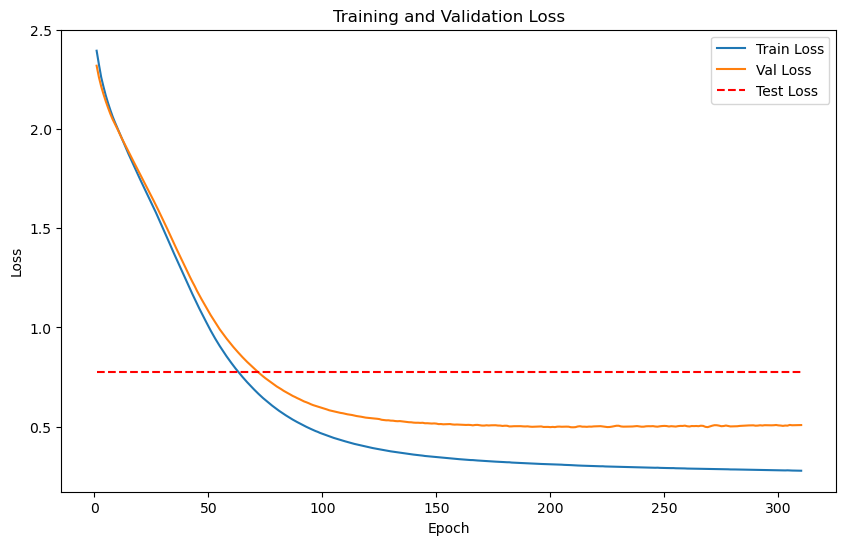

In [46]:
tscl_mlp_model.eval()

tscl_mlp_test_running_loss = 0.0
tscl_mlp_test_correct = 0
tscl_mlp_all_predictions = []
tscl_mlp_all_true_labels = []

with torch.no_grad():
    for tscl_mlp_test_embeddings_batch, tscl_mlp_test_labels_batch in tscl_mlp_test_loader:
        tscl_mlp_test_embeddings_batch = tscl_mlp_test_embeddings_batch.to(device)
        tscl_mlp_test_labels_batch = tscl_mlp_test_labels_batch.to(device)

        tscl_mlp_test_outputs = tscl_mlp_model(tscl_mlp_test_embeddings_batch)
        
        tscl_mlp_test_loss_batch = tscl_mlp_criterion(tscl_mlp_test_outputs, tscl_mlp_test_labels_batch)
        tscl_mlp_test_running_loss += tscl_mlp_test_loss_batch.item() * tscl_mlp_test_embeddings_batch.size(0)

        _, tscl_mlp_test_predicted = torch.max(tscl_mlp_test_outputs, dim=1)
        tscl_mlp_test_correct += (tscl_mlp_test_predicted == tscl_mlp_test_labels_batch).sum().item()

        tscl_mlp_all_predictions.extend(tscl_mlp_test_predicted.cpu().numpy())
        tscl_mlp_all_true_labels.extend(tscl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'tscl_mlp_predictions.npy'), np.array(tscl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'tscl_mlp_true_labels.npy'), np.array(tscl_mlp_all_true_labels))
print(f"Saved TSCL+MLP predictions and true labels to {predictions_dir}")

tscl_mlp_epoch_test_loss = tscl_mlp_test_running_loss / len(tscl_mlp_test_loader.dataset)
tscl_mlp_test_accuracy = tscl_mlp_test_correct / len(tscl_mlp_test_loader.dataset)

tscl_mlp_test_accuracy_pct = tscl_mlp_test_accuracy * 100.0

print(f"Test Loss: {tscl_mlp_epoch_test_loss:.4f} | Test Accuracy: {tscl_mlp_test_accuracy_pct:.2f}%")

tscl_mlp_num_epochs_run = len(tscl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         tscl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, tscl_mlp_num_epochs_run + 1),
         [tscl_mlp_epoch_test_loss]*tscl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Model - Supervised Contrastive Learning with Silhouette Distance Loss

In [47]:
sclsdl_encoded_train_dir = os.path.join(encoded_dir, 'train')
sclsdl_encoded_val_dir = os.path.join(encoded_dir, 'val')
sclsdl_encoded_test_dir = os.path.join(encoded_dir, 'test')

sclsdl_train_embeddings, sclsdl_train_labels = load_encoded_data(sclsdl_encoded_train_dir)
sclsdl_val_embeddings, sclsdl_val_labels = load_encoded_data(sclsdl_encoded_val_dir)
sclsdl_test_embeddings, sclsdl_test_labels = load_encoded_data(sclsdl_encoded_test_dir)

#shape verification
print(f"\n\nTrain embeddings shape: {sclsdl_train_embeddings.shape}, \nTrain labels shape: {sclsdl_train_labels.shape}")
print(f"\n\nVal embeddings shape: {sclsdl_val_embeddings.shape}, \nVal labels shape: {sclsdl_val_labels.shape}")
print(f"\n\nTest embeddings shape: {sclsdl_test_embeddings.shape}, \nTest labels shape: {sclsdl_test_labels.shape}")

LOG: Loading encoded data (representations) from encoded_representations\train...
LOG: Loaded 360 samples with 64 features each
LOG: Labels shape: (360,)
LOG: Loading encoded data (representations) from encoded_representations\val...
LOG: Loaded 45 samples with 64 features each
LOG: Labels shape: (45,)
LOG: Loading encoded data (representations) from encoded_representations\test...
LOG: Loaded 42371 samples with 64 features each
LOG: Labels shape: (42371,)


Train embeddings shape: (360, 64), 
Train labels shape: (360,)


Val embeddings shape: (45, 64), 
Val labels shape: (45,)


Test embeddings shape: (42371, 64), 
Test labels shape: (42371,)


In [48]:
#flattening embeddings to (num_samples, 64)
sclsdl_train_embeddings = sclsdl_train_embeddings.reshape(sclsdl_train_embeddings.shape[0], -1)
sclsdl_val_embeddings = sclsdl_val_embeddings.reshape(sclsdl_val_embeddings.shape[0], -1)
sclsdl_test_embeddings = sclsdl_test_embeddings.reshape(sclsdl_test_embeddings.shape[0], -1)

#compute mean and std from training set
sclsdl_train_mean = np.mean(sclsdl_train_embeddings, axis=0)
sclsdl_train_std = np.std(sclsdl_train_embeddings, axis=0)

#normalize all datasets from above training mean and std
#sclsdl_train_embeddings = (sclsdl_train_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_val_embeddings = (sclsdl_val_embeddings - sclsdl_train_mean) / sclsdl_train_std
#sclsdl_test_embeddings = (sclsdl_test_embeddings - sclsdl_train_mean) / sclsdl_train_std

sclsdl_train_dataset = TensorDataset(torch.tensor(sclsdl_train_embeddings, dtype=torch.float32), torch.tensor(sclsdl_train_labels, dtype=torch.long))
sclsdl_val_dataset = TensorDataset(torch.tensor(sclsdl_val_embeddings, dtype=torch.float32), torch.tensor(sclsdl_val_labels, dtype=torch.long))
sclsdl_test_dataset = TensorDataset(torch.tensor(sclsdl_test_embeddings, dtype=torch.float32), torch.tensor(sclsdl_test_labels, dtype=torch.long))


sclsdl_m = 20
sclsdl_num_classes = len(np.unique(sclsdl_train_labels))

# calc theoretical required batch size
sclsdl_required_batch_size = sclsdl_m * sclsdl_num_classes

if sclsdl_required_batch_size > len(sclsdl_train_dataset):
    sclsdl_max_possible_m = len(sclsdl_train_dataset) // sclsdl_num_classes
    sclsdl_m = max(1, sclsdl_max_possible_m)
    sclsdl_batch_size_train = sclsdl_m * sclsdl_num_classes
else:
    sclsdl_batch_size_train = sclsdl_required_batch_size

sclsdl_sampler = MPerClassSampler(labels = sclsdl_train_labels, m = sclsdl_m, batch_size = sclsdl_batch_size_train, length_before_new_iter=len(sclsdl_train_dataset))
sclsdl_train_loader = DataLoader(sclsdl_train_dataset, batch_size=sclsdl_batch_size_train, sampler=sclsdl_sampler)

#creating dataloaders for scl
sclsdl_dataloader_bs = 64
sclsdl_val_loader = DataLoader(sclsdl_val_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)
sclsdl_test_loader = DataLoader(sclsdl_test_dataset, batch_size=sclsdl_dataloader_bs, shuffle=False)

for sclsdl_X_batch, sclsdl_y_batch in sclsdl_train_loader:
    sclsdl_unique, sclsdl_counts = np.unique(y_batch.numpy(), return_counts=True)
    print("Class distribution in batch:", dict(zip(sclsdl_unique, sclsdl_counts)))
    print(f"Training batch size: {sclsdl_batch_size_train}")
    break


Class distribution in batch: {0: 20, 1: 20, 2: 20, 3: 20, 4: 20, 5: 20, 6: 20, 7: 20, 8: 20}
Training batch size: 180


In [49]:
class SupConNet(nn.Module):
    def __init__(self, feature_dim=128):
        super(SupConNet, self).__init__()
        self.projection_head = nn.Sequential(
            nn.Linear(64, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, feature_dim)
        )

    def forward(self, x):
        return self.projection_head(x)

In [50]:
class SilhouetteDistanceLoss(nn.Module):
    def __init__(self):
        super(SilhouetteDistanceLoss, self).__init__()

    def forward(self, features, labels):
        return self.score(features, labels, True,True)

    def score(self,X, labels,feature_norm=True, loss=False):
        unique_labels = torch.unique(labels)
        if feature_norm:
            X= F.normalize(X, p=2, dim=1)


        A, B = self._compute_distances(X, labels, unique_labels)

        # A= scale*A
        # B = (1-scale)*B
        sil_samples = (B - A) / torch.clamp(torch.maximum(A, B), min=0.0001)

        # nan values are for clusters of size 1, and should be 0
        mean_sil_score = torch.mean(torch.nan_to_num(sil_samples))
        if loss:
            return (1 - mean_sil_score) / 2
        else:
            return mean_sil_score.item()


    def _compute_distances(self,X, labels, unique_labels):
        intra_dist = torch.zeros_like(labels, dtype=torch.float32)
        inter_dist = torch.full_like(labels, torch.inf, dtype=torch.float32)

        for i, label_a in enumerate(unique_labels):
            cluster_indices_a = (labels == label_a)
            subX_a = X[cluster_indices_a]


            intra_distances_a = torch.cdist(subX_a, subX_a)
            div = (subX_a.size(0) - 1) if subX_a.shape[0]>1 else 1
            intra_dist[cluster_indices_a] = intra_distances_a.sum(dim=1) / div

            for label_b in unique_labels[i + 1:]:
                cluster_indices_b = (labels == label_b)
                subX_b = X[cluster_indices_b]
                inter_distances_ab = torch.cdist(subX_a, subX_b)
                inter_distances_ba = torch.cdist(subX_b, subX_a)

                inter_dist[cluster_indices_a] = torch.minimum(inter_distances_ab.mean(dim=1), inter_dist[cluster_indices_a])
                inter_dist[cluster_indices_b] = torch.minimum(inter_distances_ba.mean(dim=1), inter_dist[cluster_indices_b])

        return intra_dist, inter_dist

LOG: Epoch [1/2000] - Training


    Batch [1/2], Train Loss: 0.4660


    Batch [2/2], Train Loss: 0.4640
LOG: Epoch [1/2000] - Validation
    Batch [1/1], Val Loss: 0.4676
Epoch [1/2000], Avg Train Loss: 0.4650, Avg Val Loss: 0.4676

Validation loss improved from inf to 0.4676. Saving model...
LOG: Epoch [2/2000] - Training
    Batch [1/2], Train Loss: 0.4642


    Batch [2/2], Train Loss: 0.4581
LOG: Epoch [2/2000] - Validation
    Batch [1/1], Val Loss: 0.4648
Epoch [2/2000], Avg Train Loss: 0.4612, Avg Val Loss: 0.4648

Validation loss improved from 0.4676 to 0.4648. Saving model...
LOG: Epoch [3/2000] - Training


    Batch [1/2], Train Loss: 0.4626
    Batch [2/2], Train Loss: 0.4626
LOG: Epoch [3/2000] - Validation
    Batch [1/1], Val Loss: 0.4613
Epoch [3/2000], Avg Train Loss: 0.4626, Avg Val Loss: 0.4613

Validation loss improved from 0.4648 to 0.4613. Saving model...
LOG: Epoch [4/2000] - Training


    Batch [1/2], Train Loss: 0.4587


    Batch [2/2], Train Loss: 0.4612
LOG: Epoch [4/2000] - Validation
    Batch [1/1], Val Loss: 0.4567
Epoch [4/2000], Avg Train Loss: 0.4599, Avg Val Loss: 0.4567

Validation loss improved from 0.4613 to 0.4567. Saving model...
LOG: Epoch [5/2000] - Training
    Batch [1/2], Train Loss: 0.4540


    Batch [2/2], Train Loss: 0.4577
LOG: Epoch [5/2000] - Validation
    Batch [1/1], Val Loss: 0.4534
Epoch [5/2000], Avg Train Loss: 0.4558, Avg Val Loss: 0.4534

Validation loss improved from 0.4567 to 0.4534. Saving model...
LOG: Epoch [6/2000] - Training
    Batch [1/2], Train Loss: 0.4557
    Batch [2/2], Train Loss: 0.4591
LOG: Epoch [6/2000] - Validation


    Batch [1/1], Val Loss: 0.4513
Epoch [6/2000], Avg Train Loss: 0.4574, Avg Val Loss: 0.4513

Validation loss improved from 0.4534 to 0.4513. Saving model...
LOG: Epoch [7/2000] - Training
    Batch [1/2], Train Loss: 0.4492
    Batch [2/2], Train Loss: 0.4555
LOG: Epoch [7/2000] - Validation


    Batch [1/1], Val Loss: 0.4490
Epoch [7/2000], Avg Train Loss: 0.4524, Avg Val Loss: 0.4490

Validation loss improved from 0.4513 to 0.4490. Saving model...
LOG: Epoch [8/2000] - Training
    Batch [1/2], Train Loss: 0.4572
    Batch [2/2], Train Loss: 0.4518
LOG: Epoch [8/2000] - Validation


    Batch [1/1], Val Loss: 0.4471
Epoch [8/2000], Avg Train Loss: 0.4545, Avg Val Loss: 0.4471

Validation loss improved from 0.4490 to 0.4471. Saving model...
LOG: Epoch [9/2000] - Training
    Batch [1/2], Train Loss: 0.4445
    Batch [2/2], Train Loss: 0.4521
LOG: Epoch [9/2000] - Validation
    Batch [1/1], Val Loss: 0.4452
Epoch [9/2000], Avg Train Loss: 0.4483, Avg Val Loss: 0.4452

Validation loss improved from 0.4471 to 0.4452. Saving model...
LOG: Epoch [10/2000] - Training


    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4534
LOG: Epoch [10/2000] - Validation
    Batch [1/1], Val Loss: 0.4427
Epoch [10/2000], Avg Train Loss: 0.4511, Avg Val Loss: 0.4427

Validation loss improved from 0.4452 to 0.4427. Saving model...
LOG: Epoch [11/2000] - Training
    Batch [1/2], Train Loss: 0.4434


    Batch [2/2], Train Loss: 0.4507
LOG: Epoch [11/2000] - Validation
    Batch [1/1], Val Loss: 0.4407
Epoch [11/2000], Avg Train Loss: 0.4471, Avg Val Loss: 0.4407

Validation loss improved from 0.4427 to 0.4407. Saving model...
LOG: Epoch [12/2000] - Training
    Batch [1/2], Train Loss: 0.4488
    Batch [2/2], Train Loss: 0.4505
LOG: Epoch [12/2000] - Validation
    Batch [1/1], Val Loss: 0.4385
Epoch [12/2000], Avg Train Loss: 0.4497, Avg Val Loss: 0.4385

Validation loss improved from 0.4407 to 0.4385. Saving model...
LOG: Epoch [13/2000] - Training


    Batch [1/2], Train Loss: 0.4435
    Batch [2/2], Train Loss: 0.4430
LOG: Epoch [13/2000] - Validation
    Batch [1/1], Val Loss: 0.4366
Epoch [13/2000], Avg Train Loss: 0.4433, Avg Val Loss: 0.4366

Validation loss improved from 0.4385 to 0.4366. Saving model...
LOG: Epoch [14/2000] - Training


    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [14/2000] - Validation
    Batch [1/1], Val Loss: 0.4346
Epoch [14/2000], Avg Train Loss: 0.4425, Avg Val Loss: 0.4346

Validation loss improved from 0.4366 to 0.4346. Saving model...
LOG: Epoch [15/2000] - Training
    Batch [1/2], Train Loss: 0.4481


    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [15/2000] - Validation
    Batch [1/1], Val Loss: 0.4328
Epoch [15/2000], Avg Train Loss: 0.4450, Avg Val Loss: 0.4328

Validation loss improved from 0.4346 to 0.4328. Saving model...
LOG: Epoch [16/2000] - Training
    Batch [1/2], Train Loss: 0.4375
    Batch [2/2], Train Loss: 0.4438
LOG: Epoch [16/2000] - Validation


    Batch [1/1], Val Loss: 0.4310
Epoch [16/2000], Avg Train Loss: 0.4406, Avg Val Loss: 0.4310

Validation loss improved from 0.4328 to 0.4310. Saving model...
LOG: Epoch [17/2000] - Training
    Batch [1/2], Train Loss: 0.4432
    Batch [2/2], Train Loss: 0.4450
LOG: Epoch [17/2000] - Validation
    Batch [1/1], Val Loss: 0.4292
Epoch [17/2000], Avg Train Loss: 0.4441, Avg Val Loss: 0.4292

Validation loss improved from 0.4310 to 0.4292. Saving model...
LOG: Epoch [18/2000] - Training


    Batch [1/2], Train Loss: 0.4400
    Batch [2/2], Train Loss: 0.4420
LOG: Epoch [18/2000] - Validation
    Batch [1/1], Val Loss: 0.4277
Epoch [18/2000], Avg Train Loss: 0.4410, Avg Val Loss: 0.4277

Validation loss improved from 0.4292 to 0.4277. Saving model...
LOG: Epoch [19/2000] - Training
    Batch [1/2], Train Loss: 0.4433


    Batch [2/2], Train Loss: 0.4342
LOG: Epoch [19/2000] - Validation
    Batch [1/1], Val Loss: 0.4261
Epoch [19/2000], Avg Train Loss: 0.4388, Avg Val Loss: 0.4261

Validation loss improved from 0.4277 to 0.4261. Saving model...
LOG: Epoch [20/2000] - Training
    Batch [1/2], Train Loss: 0.4321
    Batch [2/2], Train Loss: 0.4320
LOG: Epoch [20/2000] - Validation
    Batch [1/1], Val Loss: 0.4246
Epoch [20/2000], Avg Train Loss: 0.4320, Avg Val Loss: 0.4246

Validation loss improved from 0.4261 to 0.4246. Saving model...
LOG: Epoch [21/2000] - Training


    Batch [1/2], Train Loss: 0.4327
    Batch [2/2], Train Loss: 0.4389
LOG: Epoch [21/2000] - Validation
    Batch [1/1], Val Loss: 0.4231
Epoch [21/2000], Avg Train Loss: 0.4358, Avg Val Loss: 0.4231

Validation loss improved from 0.4246 to 0.4231. Saving model...
LOG: Epoch [22/2000] - Training
    Batch [1/2], Train Loss: 0.4321


    Batch [2/2], Train Loss: 0.4233
LOG: Epoch [22/2000] - Validation
    Batch [1/1], Val Loss: 0.4218
Epoch [22/2000], Avg Train Loss: 0.4277, Avg Val Loss: 0.4218

Validation loss improved from 0.4231 to 0.4218. Saving model...
LOG: Epoch [23/2000] - Training
    Batch [1/2], Train Loss: 0.4323
    Batch [2/2], Train Loss: 0.4297
LOG: Epoch [23/2000] - Validation


    Batch [1/1], Val Loss: 0.4206
Epoch [23/2000], Avg Train Loss: 0.4310, Avg Val Loss: 0.4206

Validation loss improved from 0.4218 to 0.4206. Saving model...
LOG: Epoch [24/2000] - Training
    Batch [1/2], Train Loss: 0.4326
    Batch [2/2], Train Loss: 0.4271
LOG: Epoch [24/2000] - Validation
    Batch [1/1], Val Loss: 0.4193
Epoch [24/2000], Avg Train Loss: 0.4299, Avg Val Loss: 0.4193

Validation loss improved from 0.4206 to 0.4193. Saving model...
LOG: Epoch [25/2000] - Training


    Batch [1/2], Train Loss: 0.4280
    Batch [2/2], Train Loss: 0.4293
LOG: Epoch [25/2000] - Validation
    Batch [1/1], Val Loss: 0.4180
Epoch [25/2000], Avg Train Loss: 0.4287, Avg Val Loss: 0.4180

Validation loss improved from 0.4193 to 0.4180. Saving model...
LOG: Epoch [26/2000] - Training
    Batch [1/2], Train Loss: 0.4324


    Batch [2/2], Train Loss: 0.4281
LOG: Epoch [26/2000] - Validation
    Batch [1/1], Val Loss: 0.4167
Epoch [26/2000], Avg Train Loss: 0.4303, Avg Val Loss: 0.4167

Validation loss improved from 0.4180 to 0.4167. Saving model...
LOG: Epoch [27/2000] - Training
    Batch [1/2], Train Loss: 0.4368
    Batch [2/2], Train Loss: 0.4357
LOG: Epoch [27/2000] - Validation
    Batch [1/1], Val Loss: 0.4153
Epoch [27/2000], Avg Train Loss: 0.4362, Avg Val Loss: 0.4153

Validation loss improved from 0.4167 to 0.4153. Saving model...
LOG: Epoch [28/2000] - Training


    Batch [1/2], Train Loss: 0.4241
    Batch [2/2], Train Loss: 0.4212
LOG: Epoch [28/2000] - Validation
    Batch [1/1], Val Loss: 0.4140
Epoch [28/2000], Avg Train Loss: 0.4226, Avg Val Loss: 0.4140

Validation loss improved from 0.4153 to 0.4140. Saving model...
LOG: Epoch [29/2000] - Training
    Batch [1/2], Train Loss: 0.4202


    Batch [2/2], Train Loss: 0.4189
LOG: Epoch [29/2000] - Validation
    Batch [1/1], Val Loss: 0.4128
Epoch [29/2000], Avg Train Loss: 0.4195, Avg Val Loss: 0.4128

Validation loss improved from 0.4140 to 0.4128. Saving model...
LOG: Epoch [30/2000] - Training
    Batch [1/2], Train Loss: 0.4191
    Batch [2/2], Train Loss: 0.4249
LOG: Epoch [30/2000] - Validation


    Batch [1/1], Val Loss: 0.4116
Epoch [30/2000], Avg Train Loss: 0.4220, Avg Val Loss: 0.4116

Validation loss improved from 0.4128 to 0.4116. Saving model...
LOG: Epoch [31/2000] - Training
    Batch [1/2], Train Loss: 0.4242
    Batch [2/2], Train Loss: 0.4214
LOG: Epoch [31/2000] - Validation
    Batch [1/1], Val Loss: 0.4107
Epoch [31/2000], Avg Train Loss: 0.4228, Avg Val Loss: 0.4107

Validation loss improved from 0.4116 to 0.4107. Saving model...
LOG: Epoch [32/2000] - Training


    Batch [1/2], Train Loss: 0.4211
    Batch [2/2], Train Loss: 0.4160
LOG: Epoch [32/2000] - Validation
    Batch [1/1], Val Loss: 0.4096
Epoch [32/2000], Avg Train Loss: 0.4185, Avg Val Loss: 0.4096

Validation loss improved from 0.4107 to 0.4096. Saving model...
LOG: Epoch [33/2000] - Training


    Batch [1/2], Train Loss: 0.4208
    Batch [2/2], Train Loss: 0.4228
LOG: Epoch [33/2000] - Validation
    Batch [1/1], Val Loss: 0.4084
Epoch [33/2000], Avg Train Loss: 0.4218, Avg Val Loss: 0.4084

Validation loss improved from 0.4096 to 0.4084. Saving model...
LOG: Epoch [34/2000] - Training
    Batch [1/2], Train Loss: 0.4198


    Batch [2/2], Train Loss: 0.4163
LOG: Epoch [34/2000] - Validation
    Batch [1/1], Val Loss: 0.4074
Epoch [34/2000], Avg Train Loss: 0.4181, Avg Val Loss: 0.4074

Validation loss improved from 0.4084 to 0.4074. Saving model...
LOG: Epoch [35/2000] - Training
    Batch [1/2], Train Loss: 0.4142


    Batch [2/2], Train Loss: 0.4253
LOG: Epoch [35/2000] - Validation
    Batch [1/1], Val Loss: 0.4063
Epoch [35/2000], Avg Train Loss: 0.4197, Avg Val Loss: 0.4063

Validation loss improved from 0.4074 to 0.4063. Saving model...
LOG: Epoch [36/2000] - Training
    Batch [1/2], Train Loss: 0.4151


    Batch [2/2], Train Loss: 0.4164
LOG: Epoch [36/2000] - Validation
    Batch [1/1], Val Loss: 0.4050
Epoch [36/2000], Avg Train Loss: 0.4158, Avg Val Loss: 0.4050

Validation loss improved from 0.4063 to 0.4050. Saving model...
LOG: Epoch [37/2000] - Training
    Batch [1/2], Train Loss: 0.4203
    Batch [2/2], Train Loss: 0.4132
LOG: Epoch [37/2000] - Validation


    Batch [1/1], Val Loss: 0.4040
Epoch [37/2000], Avg Train Loss: 0.4168, Avg Val Loss: 0.4040

Validation loss improved from 0.4050 to 0.4040. Saving model...
LOG: Epoch [38/2000] - Training
    Batch [1/2], Train Loss: 0.4142
    Batch [2/2], Train Loss: 0.4181
LOG: Epoch [38/2000] - Validation
    Batch [1/1], Val Loss: 0.4028
Epoch [38/2000], Avg Train Loss: 0.4162, Avg Val Loss: 0.4028

Validation loss improved from 0.4040 to 0.4028. Saving model...
LOG: Epoch [39/2000] - Training


    Batch [1/2], Train Loss: 0.4104
    Batch [2/2], Train Loss: 0.4157
LOG: Epoch [39/2000] - Validation
    Batch [1/1], Val Loss: 0.4020
Epoch [39/2000], Avg Train Loss: 0.4130, Avg Val Loss: 0.4020

Validation loss improved from 0.4028 to 0.4020. Saving model...
LOG: Epoch [40/2000] - Training
    Batch [1/2], Train Loss: 0.4104


    Batch [2/2], Train Loss: 0.4119
LOG: Epoch [40/2000] - Validation
    Batch [1/1], Val Loss: 0.4011
Epoch [40/2000], Avg Train Loss: 0.4111, Avg Val Loss: 0.4011

Validation loss improved from 0.4020 to 0.4011. Saving model...
LOG: Epoch [41/2000] - Training
    Batch [1/2], Train Loss: 0.4060
    Batch [2/2], Train Loss: 0.4128
LOG: Epoch [41/2000] - Validation
    Batch [1/1], Val Loss: 0.4002
Epoch [41/2000], Avg Train Loss: 0.4094, Avg Val Loss: 0.4002

Validation loss improved from 0.4011 to 0.4002. Saving model...
LOG: Epoch [42/2000] - Training


    Batch [1/2], Train Loss: 0.4035
    Batch [2/2], Train Loss: 0.4145
LOG: Epoch [42/2000] - Validation
    Batch [1/1], Val Loss: 0.3995
Epoch [42/2000], Avg Train Loss: 0.4090, Avg Val Loss: 0.3995

Validation loss improved from 0.4002 to 0.3995. Saving model...
LOG: Epoch [43/2000] - Training
    Batch [1/2], Train Loss: 0.4015


    Batch [2/2], Train Loss: 0.4183
LOG: Epoch [43/2000] - Validation
    Batch [1/1], Val Loss: 0.3988
Epoch [43/2000], Avg Train Loss: 0.4099, Avg Val Loss: 0.3988

Validation loss improved from 0.3995 to 0.3988. Saving model...
LOG: Epoch [44/2000] - Training
    Batch [1/2], Train Loss: 0.4061
    Batch [2/2], Train Loss: 0.4160
LOG: Epoch [44/2000] - Validation


    Batch [1/1], Val Loss: 0.3979
Epoch [44/2000], Avg Train Loss: 0.4110, Avg Val Loss: 0.3979

Validation loss improved from 0.3988 to 0.3979. Saving model...
LOG: Epoch [45/2000] - Training
    Batch [1/2], Train Loss: 0.4025
    Batch [2/2], Train Loss: 0.4065
LOG: Epoch [45/2000] - Validation
    Batch [1/1], Val Loss: 0.3972
Epoch [45/2000], Avg Train Loss: 0.4045, Avg Val Loss: 0.3972

Validation loss improved from 0.3979 to 0.3972. Saving model...
LOG: Epoch [46/2000] - Training


    Batch [1/2], Train Loss: 0.4109
    Batch [2/2], Train Loss: 0.4000
LOG: Epoch [46/2000] - Validation
    Batch [1/1], Val Loss: 0.3964
Epoch [46/2000], Avg Train Loss: 0.4054, Avg Val Loss: 0.3964

Validation loss improved from 0.3972 to 0.3964. Saving model...
LOG: Epoch [47/2000] - Training
    Batch [1/2], Train Loss: 0.4082


    Batch [2/2], Train Loss: 0.4091
LOG: Epoch [47/2000] - Validation
    Batch [1/1], Val Loss: 0.3958
Epoch [47/2000], Avg Train Loss: 0.4087, Avg Val Loss: 0.3958

Validation loss improved from 0.3964 to 0.3958. Saving model...
LOG: Epoch [48/2000] - Training
    Batch [1/2], Train Loss: 0.4022
    Batch [2/2], Train Loss: 0.3992
LOG: Epoch [48/2000] - Validation


    Batch [1/1], Val Loss: 0.3949
Epoch [48/2000], Avg Train Loss: 0.4007, Avg Val Loss: 0.3949

Validation loss improved from 0.3958 to 0.3949. Saving model...
LOG: Epoch [49/2000] - Training
    Batch [1/2], Train Loss: 0.4013
    Batch [2/2], Train Loss: 0.4029
LOG: Epoch [49/2000] - Validation
    Batch [1/1], Val Loss: 0.3942
Epoch [49/2000], Avg Train Loss: 0.4021, Avg Val Loss: 0.3942

Validation loss improved from 0.3949 to 0.3942. Saving model...
LOG: Epoch [50/2000] - Training


    Batch [1/2], Train Loss: 0.4090
    Batch [2/2], Train Loss: 0.4029
LOG: Epoch [50/2000] - Validation
    Batch [1/1], Val Loss: 0.3935
Epoch [50/2000], Avg Train Loss: 0.4059, Avg Val Loss: 0.3935

Validation loss improved from 0.3942 to 0.3935. Saving model...
LOG: Epoch [51/2000] - Training
    Batch [1/2], Train Loss: 0.4034


    Batch [2/2], Train Loss: 0.4022
LOG: Epoch [51/2000] - Validation
    Batch [1/1], Val Loss: 0.3926
Epoch [51/2000], Avg Train Loss: 0.4028, Avg Val Loss: 0.3926

Validation loss improved from 0.3935 to 0.3926. Saving model...
LOG: Epoch [52/2000] - Training
    Batch [1/2], Train Loss: 0.4034
    Batch [2/2], Train Loss: 0.4060
LOG: Epoch [52/2000] - Validation


    Batch [1/1], Val Loss: 0.3918
Epoch [52/2000], Avg Train Loss: 0.4047, Avg Val Loss: 0.3918

Validation loss improved from 0.3926 to 0.3918. Saving model...
LOG: Epoch [53/2000] - Training
    Batch [1/2], Train Loss: 0.4046
    Batch [2/2], Train Loss: 0.4040
LOG: Epoch [53/2000] - Validation
    Batch [1/1], Val Loss: 0.3913
Epoch [53/2000], Avg Train Loss: 0.4043, Avg Val Loss: 0.3913

Validation loss improved from 0.3918 to 0.3913. Saving model...
LOG: Epoch [54/2000] - Training


    Batch [1/2], Train Loss: 0.4042
    Batch [2/2], Train Loss: 0.3980
LOG: Epoch [54/2000] - Validation
    Batch [1/1], Val Loss: 0.3904
Epoch [54/2000], Avg Train Loss: 0.4011, Avg Val Loss: 0.3904

Validation loss improved from 0.3913 to 0.3904. Saving model...
LOG: Epoch [55/2000] - Training
    Batch [1/2], Train Loss: 0.4011


    Batch [2/2], Train Loss: 0.3959
LOG: Epoch [55/2000] - Validation
    Batch [1/1], Val Loss: 0.3896
Epoch [55/2000], Avg Train Loss: 0.3985, Avg Val Loss: 0.3896

Validation loss improved from 0.3904 to 0.3896. Saving model...
LOG: Epoch [56/2000] - Training
    Batch [1/2], Train Loss: 0.3998
    Batch [2/2], Train Loss: 0.3922
LOG: Epoch [56/2000] - Validation


    Batch [1/1], Val Loss: 0.3888
Epoch [56/2000], Avg Train Loss: 0.3960, Avg Val Loss: 0.3888

Validation loss improved from 0.3896 to 0.3888. Saving model...
LOG: Epoch [57/2000] - Training
    Batch [1/2], Train Loss: 0.3967
    Batch [2/2], Train Loss: 0.3995
LOG: Epoch [57/2000] - Validation
    Batch [1/1], Val Loss: 0.3881
Epoch [57/2000], Avg Train Loss: 0.3981, Avg Val Loss: 0.3881

Validation loss improved from 0.3888 to 0.3881. Saving model...
LOG: Epoch [58/2000] - Training


    Batch [1/2], Train Loss: 0.3928
    Batch [2/2], Train Loss: 0.3915
LOG: Epoch [58/2000] - Validation
    Batch [1/1], Val Loss: 0.3873
Epoch [58/2000], Avg Train Loss: 0.3921, Avg Val Loss: 0.3873

Validation loss improved from 0.3881 to 0.3873. Saving model...
LOG: Epoch [59/2000] - Training
    Batch [1/2], Train Loss: 0.3986


    Batch [2/2], Train Loss: 0.3883
LOG: Epoch [59/2000] - Validation
    Batch [1/1], Val Loss: 0.3865
Epoch [59/2000], Avg Train Loss: 0.3935, Avg Val Loss: 0.3865

Validation loss improved from 0.3873 to 0.3865. Saving model...
LOG: Epoch [60/2000] - Training
    Batch [1/2], Train Loss: 0.3832
    Batch [2/2], Train Loss: 0.3998
LOG: Epoch [60/2000] - Validation


    Batch [1/1], Val Loss: 0.3857
Epoch [60/2000], Avg Train Loss: 0.3915, Avg Val Loss: 0.3857

Validation loss improved from 0.3865 to 0.3857. Saving model...
LOG: Epoch [61/2000] - Training
    Batch [1/2], Train Loss: 0.3959
    Batch [2/2], Train Loss: 0.4020
LOG: Epoch [61/2000] - Validation
    Batch [1/1], Val Loss: 0.3852
Epoch [61/2000], Avg Train Loss: 0.3990, Avg Val Loss: 0.3852

Validation loss improved from 0.3857 to 0.3852. Saving model...
LOG: Epoch [62/2000] - Training


    Batch [1/2], Train Loss: 0.3978
    Batch [2/2], Train Loss: 0.3872
LOG: Epoch [62/2000] - Validation
    Batch [1/1], Val Loss: 0.3846
Epoch [62/2000], Avg Train Loss: 0.3925, Avg Val Loss: 0.3846

Validation loss improved from 0.3852 to 0.3846. Saving model...
LOG: Epoch [63/2000] - Training
    Batch [1/2], Train Loss: 0.3858


    Batch [2/2], Train Loss: 0.3919
LOG: Epoch [63/2000] - Validation
    Batch [1/1], Val Loss: 0.3840
Epoch [63/2000], Avg Train Loss: 0.3889, Avg Val Loss: 0.3840

Validation loss improved from 0.3846 to 0.3840. Saving model...
LOG: Epoch [64/2000] - Training
    Batch [1/2], Train Loss: 0.3878
    Batch [2/2], Train Loss: 0.3938
LOG: Epoch [64/2000] - Validation


    Batch [1/1], Val Loss: 0.3835
Epoch [64/2000], Avg Train Loss: 0.3908, Avg Val Loss: 0.3835

Validation loss improved from 0.3840 to 0.3835. Saving model...
LOG: Epoch [65/2000] - Training
    Batch [1/2], Train Loss: 0.3926
    Batch [2/2], Train Loss: 0.3922
LOG: Epoch [65/2000] - Validation
    Batch [1/1], Val Loss: 0.3828
Epoch [65/2000], Avg Train Loss: 0.3924, Avg Val Loss: 0.3828

Validation loss improved from 0.3835 to 0.3828. Saving model...
LOG: Epoch [66/2000] - Training


    Batch [1/2], Train Loss: 0.3864
    Batch [2/2], Train Loss: 0.3813
LOG: Epoch [66/2000] - Validation
    Batch [1/1], Val Loss: 0.3823
Epoch [66/2000], Avg Train Loss: 0.3838, Avg Val Loss: 0.3823

Validation loss improved from 0.3828 to 0.3823. Saving model...
LOG: Epoch [67/2000] - Training
    Batch [1/2], Train Loss: 0.3823


    Batch [2/2], Train Loss: 0.3867
LOG: Epoch [67/2000] - Validation
    Batch [1/1], Val Loss: 0.3817
Epoch [67/2000], Avg Train Loss: 0.3845, Avg Val Loss: 0.3817

Validation loss improved from 0.3823 to 0.3817. Saving model...
LOG: Epoch [68/2000] - Training
    Batch [1/2], Train Loss: 0.3903
    Batch [2/2], Train Loss: 0.3883
LOG: Epoch [68/2000] - Validation


    Batch [1/1], Val Loss: 0.3811
Epoch [68/2000], Avg Train Loss: 0.3893, Avg Val Loss: 0.3811

Validation loss improved from 0.3817 to 0.3811. Saving model...
LOG: Epoch [69/2000] - Training
    Batch [1/2], Train Loss: 0.3906
    Batch [2/2], Train Loss: 0.3893
LOG: Epoch [69/2000] - Validation
    Batch [1/1], Val Loss: 0.3808
Epoch [69/2000], Avg Train Loss: 0.3899, Avg Val Loss: 0.3808

Validation loss improved from 0.3811 to 0.3808. Saving model...
LOG: Epoch [70/2000] - Training


    Batch [1/2], Train Loss: 0.3809
    Batch [2/2], Train Loss: 0.3902
LOG: Epoch [70/2000] - Validation
    Batch [1/1], Val Loss: 0.3802
Epoch [70/2000], Avg Train Loss: 0.3855, Avg Val Loss: 0.3802

Validation loss improved from 0.3808 to 0.3802. Saving model...
LOG: Epoch [71/2000] - Training
    Batch [1/2], Train Loss: 0.3812


    Batch [2/2], Train Loss: 0.3896
LOG: Epoch [71/2000] - Validation
    Batch [1/1], Val Loss: 0.3797
Epoch [71/2000], Avg Train Loss: 0.3854, Avg Val Loss: 0.3797

Validation loss improved from 0.3802 to 0.3797. Saving model...
LOG: Epoch [72/2000] - Training
    Batch [1/2], Train Loss: 0.3846
    Batch [2/2], Train Loss: 0.3808
LOG: Epoch [72/2000] - Validation
    Batch [1/1], Val Loss: 0.3792
Epoch [72/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3792

Validation loss improved from 0.3797 to 0.3792. Saving model...
LOG: Epoch [73/2000] - Training


    Batch [1/2], Train Loss: 0.3802
    Batch [2/2], Train Loss: 0.3826
LOG: Epoch [73/2000] - Validation
    Batch [1/1], Val Loss: 0.3787
Epoch [73/2000], Avg Train Loss: 0.3814, Avg Val Loss: 0.3787

Validation loss improved from 0.3792 to 0.3787. Saving model...
LOG: Epoch [74/2000] - Training
    Batch [1/2], Train Loss: 0.3887


    Batch [2/2], Train Loss: 0.3809
LOG: Epoch [74/2000] - Validation
    Batch [1/1], Val Loss: 0.3781
Epoch [74/2000], Avg Train Loss: 0.3848, Avg Val Loss: 0.3781

Validation loss improved from 0.3787 to 0.3781. Saving model...
LOG: Epoch [75/2000] - Training
    Batch [1/2], Train Loss: 0.3737
    Batch [2/2], Train Loss: 0.3810
LOG: Epoch [75/2000] - Validation
    Batch [1/1], Val Loss: 0.3775
Epoch [75/2000], Avg Train Loss: 0.3773, Avg Val Loss: 0.3775

Validation loss improved from 0.3781 to 0.3775. Saving model...
LOG: Epoch [76/2000] - Training


    Batch [1/2], Train Loss: 0.3825
    Batch [2/2], Train Loss: 0.3828
LOG: Epoch [76/2000] - Validation
    Batch [1/1], Val Loss: 0.3770
Epoch [76/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3770

Validation loss improved from 0.3775 to 0.3770. Saving model...
LOG: Epoch [77/2000] - Training
    Batch [1/2], Train Loss: 0.3803


    Batch [2/2], Train Loss: 0.3762
LOG: Epoch [77/2000] - Validation
    Batch [1/1], Val Loss: 0.3766
Epoch [77/2000], Avg Train Loss: 0.3782, Avg Val Loss: 0.3766

Validation loss improved from 0.3770 to 0.3766. Saving model...
LOG: Epoch [78/2000] - Training
    Batch [1/2], Train Loss: 0.3758
    Batch [2/2], Train Loss: 0.3792
LOG: Epoch [78/2000] - Validation
    Batch [1/1], Val Loss: 0.3762
Epoch [78/2000], Avg Train Loss: 0.3775, Avg Val Loss: 0.3762

Validation loss improved from 0.3766 to 0.3762. Saving model...
LOG: Epoch [79/2000] - Training


    Batch [1/2], Train Loss: 0.3828
    Batch [2/2], Train Loss: 0.3875
LOG: Epoch [79/2000] - Validation
    Batch [1/1], Val Loss: 0.3755
Epoch [79/2000], Avg Train Loss: 0.3852, Avg Val Loss: 0.3755

Validation loss improved from 0.3762 to 0.3755. Saving model...
LOG: Epoch [80/2000] - Training
    Batch [1/2], Train Loss: 0.3764


    Batch [2/2], Train Loss: 0.3890
LOG: Epoch [80/2000] - Validation
    Batch [1/1], Val Loss: 0.3749
Epoch [80/2000], Avg Train Loss: 0.3827, Avg Val Loss: 0.3749

Validation loss improved from 0.3755 to 0.3749. Saving model...
LOG: Epoch [81/2000] - Training
    Batch [1/2], Train Loss: 0.3737
    Batch [2/2], Train Loss: 0.3836
LOG: Epoch [81/2000] - Validation
    Batch [1/1], Val Loss: 0.3745
Epoch [81/2000], Avg Train Loss: 0.3787, Avg Val Loss: 0.3745

Validation loss improved from 0.3749 to 0.3745. Saving model...
LOG: Epoch [82/2000] - Training


    Batch [1/2], Train Loss: 0.3727
    Batch [2/2], Train Loss: 0.3850
LOG: Epoch [82/2000] - Validation
    Batch [1/1], Val Loss: 0.3739
Epoch [82/2000], Avg Train Loss: 0.3789, Avg Val Loss: 0.3739

Validation loss improved from 0.3745 to 0.3739. Saving model...
LOG: Epoch [83/2000] - Training
    Batch [1/2], Train Loss: 0.3742


    Batch [2/2], Train Loss: 0.3744
LOG: Epoch [83/2000] - Validation
    Batch [1/1], Val Loss: 0.3734
Epoch [83/2000], Avg Train Loss: 0.3743, Avg Val Loss: 0.3734

Validation loss improved from 0.3739 to 0.3734. Saving model...
LOG: Epoch [84/2000] - Training
    Batch [1/2], Train Loss: 0.3798
    Batch [2/2], Train Loss: 0.3807
LOG: Epoch [84/2000] - Validation


    Batch [1/1], Val Loss: 0.3726
Epoch [84/2000], Avg Train Loss: 0.3802, Avg Val Loss: 0.3726

Validation loss improved from 0.3734 to 0.3726. Saving model...
LOG: Epoch [85/2000] - Training
    Batch [1/2], Train Loss: 0.3743
    Batch [2/2], Train Loss: 0.3817
LOG: Epoch [85/2000] - Validation
    Batch [1/1], Val Loss: 0.3719
Epoch [85/2000], Avg Train Loss: 0.3780, Avg Val Loss: 0.3719

Validation loss improved from 0.3726 to 0.3719. Saving model...
LOG: Epoch [86/2000] - Training


    Batch [1/2], Train Loss: 0.3708
    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [86/2000] - Validation
    Batch [1/1], Val Loss: 0.3715
Epoch [86/2000], Avg Train Loss: 0.3714, Avg Val Loss: 0.3715

Validation loss improved from 0.3719 to 0.3715. Saving model...
LOG: Epoch [87/2000] - Training
    Batch [1/2], Train Loss: 0.3752


    Batch [2/2], Train Loss: 0.3765
LOG: Epoch [87/2000] - Validation
    Batch [1/1], Val Loss: 0.3711
Epoch [87/2000], Avg Train Loss: 0.3758, Avg Val Loss: 0.3711

Validation loss improved from 0.3715 to 0.3711. Saving model...
LOG: Epoch [88/2000] - Training
    Batch [1/2], Train Loss: 0.3760
    Batch [2/2], Train Loss: 0.3765
LOG: Epoch [88/2000] - Validation
    Batch [1/1], Val Loss: 0.3708
Epoch [88/2000], Avg Train Loss: 0.3763, Avg Val Loss: 0.3708

Validation loss improved from 0.3711 to 0.3708. Saving model...
LOG: Epoch [89/2000] - Training


    Batch [1/2], Train Loss: 0.3785
    Batch [2/2], Train Loss: 0.3674
LOG: Epoch [89/2000] - Validation
    Batch [1/1], Val Loss: 0.3706
Epoch [89/2000], Avg Train Loss: 0.3729, Avg Val Loss: 0.3706

Validation loss improved from 0.3708 to 0.3706. Saving model...
LOG: Epoch [90/2000] - Training
    Batch [1/2], Train Loss: 0.3776


    Batch [2/2], Train Loss: 0.3721
LOG: Epoch [90/2000] - Validation
    Batch [1/1], Val Loss: 0.3702
Epoch [90/2000], Avg Train Loss: 0.3748, Avg Val Loss: 0.3702

Validation loss improved from 0.3706 to 0.3702. Saving model...
LOG: Epoch [91/2000] - Training
    Batch [1/2], Train Loss: 0.3733
    Batch [2/2], Train Loss: 0.3791
LOG: Epoch [91/2000] - Validation


    Batch [1/1], Val Loss: 0.3698
Epoch [91/2000], Avg Train Loss: 0.3762, Avg Val Loss: 0.3698

Validation loss improved from 0.3702 to 0.3698. Saving model...
LOG: Epoch [92/2000] - Training
    Batch [1/2], Train Loss: 0.3713
    Batch [2/2], Train Loss: 0.3760
LOG: Epoch [92/2000] - Validation
    Batch [1/1], Val Loss: 0.3693
Epoch [92/2000], Avg Train Loss: 0.3736, Avg Val Loss: 0.3693

Validation loss improved from 0.3698 to 0.3693. Saving model...
LOG: Epoch [93/2000] - Training


    Batch [1/2], Train Loss: 0.3573
    Batch [2/2], Train Loss: 0.3766
LOG: Epoch [93/2000] - Validation
    Batch [1/1], Val Loss: 0.3692
Epoch [93/2000], Avg Train Loss: 0.3670, Avg Val Loss: 0.3692

Validation loss improved from 0.3693 to 0.3692. Saving model...
LOG: Epoch [94/2000] - Training
    Batch [1/2], Train Loss: 0.3753


    Batch [2/2], Train Loss: 0.3723
LOG: Epoch [94/2000] - Validation
    Batch [1/1], Val Loss: 0.3690
Epoch [94/2000], Avg Train Loss: 0.3738, Avg Val Loss: 0.3690

Validation loss improved from 0.3692 to 0.3690. Saving model...
LOG: Epoch [95/2000] - Training
    Batch [1/2], Train Loss: 0.3711
    Batch [2/2], Train Loss: 0.3692
LOG: Epoch [95/2000] - Validation
    Batch [1/1], Val Loss: 0.3684
Epoch [95/2000], Avg Train Loss: 0.3701, Avg Val Loss: 0.3684

Validation loss improved from 0.3690 to 0.3684. Saving model...
LOG: Epoch [96/2000] - Training


    Batch [1/2], Train Loss: 0.3690
    Batch [2/2], Train Loss: 0.3644
LOG: Epoch [96/2000] - Validation
    Batch [1/1], Val Loss: 0.3683
Epoch [96/2000], Avg Train Loss: 0.3667, Avg Val Loss: 0.3683

Validation loss improved from 0.3684 to 0.3683. Saving model...
LOG: Epoch [97/2000] - Training
    Batch [1/2], Train Loss: 0.3717


    Batch [2/2], Train Loss: 0.3718
LOG: Epoch [97/2000] - Validation
    Batch [1/1], Val Loss: 0.3679
Epoch [97/2000], Avg Train Loss: 0.3717, Avg Val Loss: 0.3679

Validation loss improved from 0.3683 to 0.3679. Saving model...
LOG: Epoch [98/2000] - Training
    Batch [1/2], Train Loss: 0.3574


    Batch [2/2], Train Loss: 0.3624
LOG: Epoch [98/2000] - Validation
    Batch [1/1], Val Loss: 0.3676
Epoch [98/2000], Avg Train Loss: 0.3599, Avg Val Loss: 0.3676

Validation loss improved from 0.3679 to 0.3676. Saving model...
LOG: Epoch [99/2000] - Training
    Batch [1/2], Train Loss: 0.3722
    Batch [2/2], Train Loss: 0.3662
LOG: Epoch [99/2000] - Validation


    Batch [1/1], Val Loss: 0.3671
Epoch [99/2000], Avg Train Loss: 0.3692, Avg Val Loss: 0.3671

Validation loss improved from 0.3676 to 0.3671. Saving model...
LOG: Epoch [100/2000] - Training
    Batch [1/2], Train Loss: 0.3617
    Batch [2/2], Train Loss: 0.3621
LOG: Epoch [100/2000] - Validation
    Batch [1/1], Val Loss: 0.3666
Epoch [100/2000], Avg Train Loss: 0.3619, Avg Val Loss: 0.3666

Validation loss improved from 0.3671 to 0.3666. Saving model...
LOG: Epoch [101/2000] - Training


    Batch [1/2], Train Loss: 0.3622
    Batch [2/2], Train Loss: 0.3646
LOG: Epoch [101/2000] - Validation
    Batch [1/1], Val Loss: 0.3662
Epoch [101/2000], Avg Train Loss: 0.3634, Avg Val Loss: 0.3662

Validation loss improved from 0.3666 to 0.3662. Saving model...
LOG: Epoch [102/2000] - Training
    Batch [1/2], Train Loss: 0.3676


    Batch [2/2], Train Loss: 0.3639
LOG: Epoch [102/2000] - Validation
    Batch [1/1], Val Loss: 0.3661
Epoch [102/2000], Avg Train Loss: 0.3657, Avg Val Loss: 0.3661

Validation loss improved from 0.3662 to 0.3661. Saving model...
LOG: Epoch [103/2000] - Training
    Batch [1/2], Train Loss: 0.3689
    Batch [2/2], Train Loss: 0.3684
LOG: Epoch [103/2000] - Validation


    Batch [1/1], Val Loss: 0.3657
Epoch [103/2000], Avg Train Loss: 0.3687, Avg Val Loss: 0.3657

Validation loss improved from 0.3661 to 0.3657. Saving model...
LOG: Epoch [104/2000] - Training
    Batch [1/2], Train Loss: 0.3643
    Batch [2/2], Train Loss: 0.3716
LOG: Epoch [104/2000] - Validation
    Batch [1/1], Val Loss: 0.3652
Epoch [104/2000], Avg Train Loss: 0.3679, Avg Val Loss: 0.3652

Validation loss improved from 0.3657 to 0.3652. Saving model...
LOG: Epoch [105/2000] - Training


    Batch [1/2], Train Loss: 0.3682
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [105/2000] - Validation
    Batch [1/1], Val Loss: 0.3649
Epoch [105/2000], Avg Train Loss: 0.3658, Avg Val Loss: 0.3649

Validation loss improved from 0.3652 to 0.3649. Saving model...
LOG: Epoch [106/2000] - Training
    Batch [1/2], Train Loss: 0.3629


    Batch [2/2], Train Loss: 0.3697
LOG: Epoch [106/2000] - Validation
    Batch [1/1], Val Loss: 0.3643
Epoch [106/2000], Avg Train Loss: 0.3663, Avg Val Loss: 0.3643

Validation loss improved from 0.3649 to 0.3643. Saving model...
LOG: Epoch [107/2000] - Training
    Batch [1/2], Train Loss: 0.3669
    Batch [2/2], Train Loss: 0.3700
LOG: Epoch [107/2000] - Validation
    Batch [1/1], Val Loss: 0.3640
Epoch [107/2000], Avg Train Loss: 0.3685, Avg Val Loss: 0.3640

Validation loss improved from 0.3643 to 0.3640. Saving model...
LOG: Epoch [108/2000] - Training


    Batch [1/2], Train Loss: 0.3601
    Batch [2/2], Train Loss: 0.3644
LOG: Epoch [108/2000] - Validation
    Batch [1/1], Val Loss: 0.3638
Epoch [108/2000], Avg Train Loss: 0.3623, Avg Val Loss: 0.3638

Validation loss improved from 0.3640 to 0.3638. Saving model...
LOG: Epoch [109/2000] - Training
    Batch [1/2], Train Loss: 0.3602


    Batch [2/2], Train Loss: 0.3660
LOG: Epoch [109/2000] - Validation
    Batch [1/1], Val Loss: 0.3635
Epoch [109/2000], Avg Train Loss: 0.3631, Avg Val Loss: 0.3635

Validation loss improved from 0.3638 to 0.3635. Saving model...
LOG: Epoch [110/2000] - Training
    Batch [1/2], Train Loss: 0.3603
    Batch [2/2], Train Loss: 0.3580
LOG: Epoch [110/2000] - Validation


    Batch [1/1], Val Loss: 0.3632
Epoch [110/2000], Avg Train Loss: 0.3591, Avg Val Loss: 0.3632

Validation loss improved from 0.3635 to 0.3632. Saving model...
LOG: Epoch [111/2000] - Training
    Batch [1/2], Train Loss: 0.3667
    Batch [2/2], Train Loss: 0.3494
LOG: Epoch [111/2000] - Validation
    Batch [1/1], Val Loss: 0.3629
Epoch [111/2000], Avg Train Loss: 0.3581, Avg Val Loss: 0.3629

Validation loss improved from 0.3632 to 0.3629. Saving model...
LOG: Epoch [112/2000] - Training


    Batch [1/2], Train Loss: 0.3568
    Batch [2/2], Train Loss: 0.3650
LOG: Epoch [112/2000] - Validation
    Batch [1/1], Val Loss: 0.3627
Epoch [112/2000], Avg Train Loss: 0.3609, Avg Val Loss: 0.3627

Validation loss improved from 0.3629 to 0.3627. Saving model...
LOG: Epoch [113/2000] - Training
    Batch [1/2], Train Loss: 0.3589


    Batch [2/2], Train Loss: 0.3595
LOG: Epoch [113/2000] - Validation
    Batch [1/1], Val Loss: 0.3622
Epoch [113/2000], Avg Train Loss: 0.3592, Avg Val Loss: 0.3622

Validation loss improved from 0.3627 to 0.3622. Saving model...
LOG: Epoch [114/2000] - Training
    Batch [1/2], Train Loss: 0.3581
    Batch [2/2], Train Loss: 0.3631
LOG: Epoch [114/2000] - Validation


    Batch [1/1], Val Loss: 0.3621
Epoch [114/2000], Avg Train Loss: 0.3606, Avg Val Loss: 0.3621

Validation loss improved from 0.3622 to 0.3621. Saving model...
LOG: Epoch [115/2000] - Training
    Batch [1/2], Train Loss: 0.3504
    Batch [2/2], Train Loss: 0.3540
LOG: Epoch [115/2000] - Validation
    Batch [1/1], Val Loss: 0.3618
Epoch [115/2000], Avg Train Loss: 0.3522, Avg Val Loss: 0.3618

Validation loss improved from 0.3621 to 0.3618. Saving model...
LOG: Epoch [116/2000] - Training


    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3601
LOG: Epoch [116/2000] - Validation
    Batch [1/1], Val Loss: 0.3614
Epoch [116/2000], Avg Train Loss: 0.3593, Avg Val Loss: 0.3614

Validation loss improved from 0.3618 to 0.3614. Saving model...
LOG: Epoch [117/2000] - Training
    Batch [1/2], Train Loss: 0.3446


    Batch [2/2], Train Loss: 0.3517
LOG: Epoch [117/2000] - Validation
    Batch [1/1], Val Loss: 0.3610
Epoch [117/2000], Avg Train Loss: 0.3481, Avg Val Loss: 0.3610

Validation loss improved from 0.3614 to 0.3610. Saving model...
LOG: Epoch [118/2000] - Training
    Batch [1/2], Train Loss: 0.3600
    Batch [2/2], Train Loss: 0.3608
LOG: Epoch [118/2000] - Validation
    Batch [1/1], Val Loss: 0.3607
Epoch [118/2000], Avg Train Loss: 0.3604, Avg Val Loss: 0.3607

Validation loss improved from 0.3610 to 0.3607. Saving model...
LOG: Epoch [119/2000] - Training


    Batch [1/2], Train Loss: 0.3539
    Batch [2/2], Train Loss: 0.3602
LOG: Epoch [119/2000] - Validation
    Batch [1/1], Val Loss: 0.3604
Epoch [119/2000], Avg Train Loss: 0.3570, Avg Val Loss: 0.3604

Validation loss improved from 0.3607 to 0.3604. Saving model...
LOG: Epoch [120/2000] - Training
    Batch [1/2], Train Loss: 0.3616


    Batch [2/2], Train Loss: 0.3482
LOG: Epoch [120/2000] - Validation
    Batch [1/1], Val Loss: 0.3603
Epoch [120/2000], Avg Train Loss: 0.3549, Avg Val Loss: 0.3603

Validation loss improved from 0.3604 to 0.3603. Saving model...
LOG: Epoch [121/2000] - Training
    Batch [1/2], Train Loss: 0.3465
    Batch [2/2], Train Loss: 0.3574
LOG: Epoch [121/2000] - Validation
    Batch [1/1], Val Loss: 0.3600
Epoch [121/2000], Avg Train Loss: 0.3520, Avg Val Loss: 0.3600

Validation loss improved from 0.3603 to 0.3600. Saving model...
LOG: Epoch [122/2000] - Training


    Batch [1/2], Train Loss: 0.3504
    Batch [2/2], Train Loss: 0.3619
LOG: Epoch [122/2000] - Validation
    Batch [1/1], Val Loss: 0.3599
Epoch [122/2000], Avg Train Loss: 0.3562, Avg Val Loss: 0.3599

Validation loss improved from 0.3600 to 0.3599. Saving model...
LOG: Epoch [123/2000] - Training
    Batch [1/2], Train Loss: 0.3643


    Batch [2/2], Train Loss: 0.3514
LOG: Epoch [123/2000] - Validation
    Batch [1/1], Val Loss: 0.3598
Epoch [123/2000], Avg Train Loss: 0.3579, Avg Val Loss: 0.3598

Validation loss improved from 0.3599 to 0.3598. Saving model...
LOG: Epoch [124/2000] - Training
    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3635
LOG: Epoch [124/2000] - Validation


    Batch [1/1], Val Loss: 0.3597
Epoch [124/2000], Avg Train Loss: 0.3546, Avg Val Loss: 0.3597

Validation loss improved from 0.3598 to 0.3597. Saving model...
LOG: Epoch [125/2000] - Training
    Batch [1/2], Train Loss: 0.3543
    Batch [2/2], Train Loss: 0.3525
LOG: Epoch [125/2000] - Validation
    Batch [1/1], Val Loss: 0.3595
Epoch [125/2000], Avg Train Loss: 0.3534, Avg Val Loss: 0.3595

Validation loss improved from 0.3597 to 0.3595. Saving model...
LOG: Epoch [126/2000] - Training


    Batch [1/2], Train Loss: 0.3479
    Batch [2/2], Train Loss: 0.3448
LOG: Epoch [126/2000] - Validation
    Batch [1/1], Val Loss: 0.3592
Epoch [126/2000], Avg Train Loss: 0.3463, Avg Val Loss: 0.3592

Validation loss improved from 0.3595 to 0.3592. Saving model...
LOG: Epoch [127/2000] - Training
    Batch [1/2], Train Loss: 0.3497


    Batch [2/2], Train Loss: 0.3496
LOG: Epoch [127/2000] - Validation
    Batch [1/1], Val Loss: 0.3589
Epoch [127/2000], Avg Train Loss: 0.3496, Avg Val Loss: 0.3589

Validation loss improved from 0.3592 to 0.3589. Saving model...
LOG: Epoch [128/2000] - Training
    Batch [1/2], Train Loss: 0.3518
    Batch [2/2], Train Loss: 0.3428
LOG: Epoch [128/2000] - Validation


    Batch [1/1], Val Loss: 0.3586
Epoch [128/2000], Avg Train Loss: 0.3473, Avg Val Loss: 0.3586

Validation loss improved from 0.3589 to 0.3586. Saving model...
LOG: Epoch [129/2000] - Training
    Batch [1/2], Train Loss: 0.3542
    Batch [2/2], Train Loss: 0.3349
LOG: Epoch [129/2000] - Validation
    Batch [1/1], Val Loss: 0.3583
Epoch [129/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3583

Validation loss improved from 0.3586 to 0.3583. Saving model...
LOG: Epoch [130/2000] - Training


    Batch [1/2], Train Loss: 0.3568
    Batch [2/2], Train Loss: 0.3489
LOG: Epoch [130/2000] - Validation
    Batch [1/1], Val Loss: 0.3579
Epoch [130/2000], Avg Train Loss: 0.3528, Avg Val Loss: 0.3579

Validation loss improved from 0.3583 to 0.3579. Saving model...
LOG: Epoch [131/2000] - Training
    Batch [1/2], Train Loss: 0.3529


    Batch [2/2], Train Loss: 0.3478
LOG: Epoch [131/2000] - Validation
    Batch [1/1], Val Loss: 0.3578
Epoch [131/2000], Avg Train Loss: 0.3503, Avg Val Loss: 0.3578

Validation loss improved from 0.3579 to 0.3578. Saving model...
LOG: Epoch [132/2000] - Training
    Batch [1/2], Train Loss: 0.3584
    Batch [2/2], Train Loss: 0.3452
LOG: Epoch [132/2000] - Validation
    Batch [1/1], Val Loss: 0.3577
Epoch [132/2000], Avg Train Loss: 0.3518, Avg Val Loss: 0.3577

Validation loss improved from 0.3578 to 0.3577. Saving model...
LOG: Epoch [133/2000] - Training


    Batch [1/2], Train Loss: 0.3446
    Batch [2/2], Train Loss: 0.3503
LOG: Epoch [133/2000] - Validation
    Batch [1/1], Val Loss: 0.3575
Epoch [133/2000], Avg Train Loss: 0.3474, Avg Val Loss: 0.3575

Validation loss improved from 0.3577 to 0.3575. Saving model...
LOG: Epoch [134/2000] - Training
    Batch [1/2], Train Loss: 0.3468


    Batch [2/2], Train Loss: 0.3407
LOG: Epoch [134/2000] - Validation
    Batch [1/1], Val Loss: 0.3573
Epoch [134/2000], Avg Train Loss: 0.3438, Avg Val Loss: 0.3573

Validation loss improved from 0.3575 to 0.3573. Saving model...
LOG: Epoch [135/2000] - Training
    Batch [1/2], Train Loss: 0.3537
    Batch [2/2], Train Loss: 0.3429
LOG: Epoch [135/2000] - Validation
    Batch [1/1], Val Loss: 0.3571
Epoch [135/2000], Avg Train Loss: 0.3483, Avg Val Loss: 0.3571

Validation loss improved from 0.3573 to 0.3571. Saving model...
LOG: Epoch [136/2000] - Training


    Batch [1/2], Train Loss: 0.3377
    Batch [2/2], Train Loss: 0.3473
LOG: Epoch [136/2000] - Validation
    Batch [1/1], Val Loss: 0.3569
Epoch [136/2000], Avg Train Loss: 0.3425, Avg Val Loss: 0.3569

Validation loss improved from 0.3571 to 0.3569. Saving model...
LOG: Epoch [137/2000] - Training
    Batch [1/2], Train Loss: 0.3475


    Batch [2/2], Train Loss: 0.3493
LOG: Epoch [137/2000] - Validation
    Batch [1/1], Val Loss: 0.3565
Epoch [137/2000], Avg Train Loss: 0.3484, Avg Val Loss: 0.3565

Validation loss improved from 0.3569 to 0.3565. Saving model...
LOG: Epoch [138/2000] - Training
    Batch [1/2], Train Loss: 0.3417
    Batch [2/2], Train Loss: 0.3437
LOG: Epoch [138/2000] - Validation
    Batch [1/1], Val Loss: 0.3561
Epoch [138/2000], Avg Train Loss: 0.3427, Avg Val Loss: 0.3561

Validation loss improved from 0.3565 to 0.3561. Saving model...
LOG: Epoch [139/2000] - Training


    Batch [1/2], Train Loss: 0.3481
    Batch [2/2], Train Loss: 0.3515
LOG: Epoch [139/2000] - Validation
    Batch [1/1], Val Loss: 0.3557
Epoch [139/2000], Avg Train Loss: 0.3498, Avg Val Loss: 0.3557

Validation loss improved from 0.3561 to 0.3557. Saving model...
LOG: Epoch [140/2000] - Training
    Batch [1/2], Train Loss: 0.3386


    Batch [2/2], Train Loss: 0.3467
LOG: Epoch [140/2000] - Validation
    Batch [1/1], Val Loss: 0.3555
Epoch [140/2000], Avg Train Loss: 0.3426, Avg Val Loss: 0.3555

Validation loss improved from 0.3557 to 0.3555. Saving model...
LOG: Epoch [141/2000] - Training
    Batch [1/2], Train Loss: 0.3447
    Batch [2/2], Train Loss: 0.3469
LOG: Epoch [141/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [141/2000], Avg Train Loss: 0.3458, Avg Val Loss: 0.3554

Validation loss improved from 0.3555 to 0.3554. Saving model...
LOG: Epoch [142/2000] - Training


    Batch [1/2], Train Loss: 0.3394
    Batch [2/2], Train Loss: 0.3518
LOG: Epoch [142/2000] - Validation
    Batch [1/1], Val Loss: 0.3554
Epoch [142/2000], Avg Train Loss: 0.3456, Avg Val Loss: 0.3554

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [143/2000] - Training
    Batch [1/2], Train Loss: 0.3386


    Batch [2/2], Train Loss: 0.3400
LOG: Epoch [143/2000] - Validation
    Batch [1/1], Val Loss: 0.3552
Epoch [143/2000], Avg Train Loss: 0.3393, Avg Val Loss: 0.3552

Validation loss improved from 0.3554 to 0.3552. Saving model...
LOG: Epoch [144/2000] - Training
    Batch [1/2], Train Loss: 0.3450
    Batch [2/2], Train Loss: 0.3443
LOG: Epoch [144/2000] - Validation
    Batch [1/1], Val Loss: 0.3551
Epoch [144/2000], Avg Train Loss: 0.3446, Avg Val Loss: 0.3551

Validation loss improved from 0.3552 to 0.3551. Saving model...
LOG: Epoch [145/2000] - Training


    Batch [1/2], Train Loss: 0.3381
    Batch [2/2], Train Loss: 0.3494
LOG: Epoch [145/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [145/2000], Avg Train Loss: 0.3437, Avg Val Loss: 0.3547

Validation loss improved from 0.3551 to 0.3547. Saving model...
LOG: Epoch [146/2000] - Training
    Batch [1/2], Train Loss: 0.3464


    Batch [2/2], Train Loss: 0.3418
LOG: Epoch [146/2000] - Validation
    Batch [1/1], Val Loss: 0.3547
Epoch [146/2000], Avg Train Loss: 0.3441, Avg Val Loss: 0.3547

Validation loss improved from 0.3547 to 0.3547. Saving model...
LOG: Epoch [147/2000] - Training
    Batch [1/2], Train Loss: 0.3373


    Batch [2/2], Train Loss: 0.3394
LOG: Epoch [147/2000] - Validation
    Batch [1/1], Val Loss: 0.3545
Epoch [147/2000], Avg Train Loss: 0.3383, Avg Val Loss: 0.3545

Validation loss improved from 0.3547 to 0.3545. Saving model...
LOG: Epoch [148/2000] - Training
    Batch [1/2], Train Loss: 0.3431
    Batch [2/2], Train Loss: 0.3434
LOG: Epoch [148/2000] - Validation
    Batch [1/1], Val Loss: 0.3543
Epoch [148/2000], Avg Train Loss: 0.3433, Avg Val Loss: 0.3543

Validation loss improved from 0.3545 to 0.3543. Saving model...
LOG: Epoch [149/2000] - Training


    Batch [1/2], Train Loss: 0.3375
    Batch [2/2], Train Loss: 0.3413
LOG: Epoch [149/2000] - Validation
    Batch [1/1], Val Loss: 0.3539
Epoch [149/2000], Avg Train Loss: 0.3394, Avg Val Loss: 0.3539

Validation loss improved from 0.3543 to 0.3539. Saving model...
LOG: Epoch [150/2000] - Training
    Batch [1/2], Train Loss: 0.3363


    Batch [2/2], Train Loss: 0.3339
LOG: Epoch [150/2000] - Validation
    Batch [1/1], Val Loss: 0.3538
Epoch [150/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.3538

Validation loss improved from 0.3539 to 0.3538. Saving model...
LOG: Epoch [151/2000] - Training
    Batch [1/2], Train Loss: 0.3373
    Batch [2/2], Train Loss: 0.3330
LOG: Epoch [151/2000] - Validation


    Batch [1/1], Val Loss: 0.3536
Epoch [151/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.3536

Validation loss improved from 0.3538 to 0.3536. Saving model...
LOG: Epoch [152/2000] - Training
    Batch [1/2], Train Loss: 0.3410
    Batch [2/2], Train Loss: 0.3256
LOG: Epoch [152/2000] - Validation
    Batch [1/1], Val Loss: 0.3535
Epoch [152/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3535

Validation loss improved from 0.3536 to 0.3535. Saving model...
LOG: Epoch [153/2000] - Training


    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3302
LOG: Epoch [153/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [153/2000], Avg Train Loss: 0.3380, Avg Val Loss: 0.3532

Validation loss improved from 0.3535 to 0.3532. Saving model...
LOG: Epoch [154/2000] - Training


    Batch [1/2], Train Loss: 0.3413
    Batch [2/2], Train Loss: 0.3475
LOG: Epoch [154/2000] - Validation
    Batch [1/1], Val Loss: 0.3532
Epoch [154/2000], Avg Train Loss: 0.3444, Avg Val Loss: 0.3532

Validation loss improved from 0.3532 to 0.3532. Saving model...
LOG: Epoch [155/2000] - Training
    Batch [1/2], Train Loss: 0.3431


    Batch [2/2], Train Loss: 0.3348
LOG: Epoch [155/2000] - Validation
    Batch [1/1], Val Loss: 0.3531
Epoch [155/2000], Avg Train Loss: 0.3390, Avg Val Loss: 0.3531

Validation loss improved from 0.3532 to 0.3531. Saving model...
LOG: Epoch [156/2000] - Training
    Batch [1/2], Train Loss: 0.3458
    Batch [2/2], Train Loss: 0.3340
LOG: Epoch [156/2000] - Validation


    Batch [1/1], Val Loss: 0.3529
Epoch [156/2000], Avg Train Loss: 0.3399, Avg Val Loss: 0.3529

Validation loss improved from 0.3531 to 0.3529. Saving model...
LOG: Epoch [157/2000] - Training
    Batch [1/2], Train Loss: 0.3328
    Batch [2/2], Train Loss: 0.3301
LOG: Epoch [157/2000] - Validation
    Batch [1/1], Val Loss: 0.3529
Epoch [157/2000], Avg Train Loss: 0.3315, Avg Val Loss: 0.3529

Validation loss improved from 0.3529 to 0.3529. Saving model...
LOG: Epoch [158/2000] - Training


    Batch [1/2], Train Loss: 0.3408
    Batch [2/2], Train Loss: 0.3425
LOG: Epoch [158/2000] - Validation
    Batch [1/1], Val Loss: 0.3526
Epoch [158/2000], Avg Train Loss: 0.3417, Avg Val Loss: 0.3526

Validation loss improved from 0.3529 to 0.3526. Saving model...
LOG: Epoch [159/2000] - Training
    Batch [1/2], Train Loss: 0.3379


    Batch [2/2], Train Loss: 0.3314
LOG: Epoch [159/2000] - Validation
    Batch [1/1], Val Loss: 0.3525
Epoch [159/2000], Avg Train Loss: 0.3346, Avg Val Loss: 0.3525

Validation loss improved from 0.3526 to 0.3525. Saving model...
LOG: Epoch [160/2000] - Training
    Batch [1/2], Train Loss: 0.3369
    Batch [2/2], Train Loss: 0.3315
LOG: Epoch [160/2000] - Validation


    Batch [1/1], Val Loss: 0.3523
Epoch [160/2000], Avg Train Loss: 0.3342, Avg Val Loss: 0.3523

Validation loss improved from 0.3525 to 0.3523. Saving model...
LOG: Epoch [161/2000] - Training
    Batch [1/2], Train Loss: 0.3357
    Batch [2/2], Train Loss: 0.3389
LOG: Epoch [161/2000] - Validation
    Batch [1/1], Val Loss: 0.3522
Epoch [161/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3522

Validation loss improved from 0.3523 to 0.3522. Saving model...
LOG: Epoch [162/2000] - Training


    Batch [1/2], Train Loss: 0.3316
    Batch [2/2], Train Loss: 0.3349
LOG: Epoch [162/2000] - Validation
    Batch [1/1], Val Loss: 0.3521
Epoch [162/2000], Avg Train Loss: 0.3333, Avg Val Loss: 0.3521

Validation loss improved from 0.3522 to 0.3521. Saving model...
LOG: Epoch [163/2000] - Training
    Batch [1/2], Train Loss: 0.3405


    Batch [2/2], Train Loss: 0.3371
LOG: Epoch [163/2000] - Validation
    Batch [1/1], Val Loss: 0.3518
Epoch [163/2000], Avg Train Loss: 0.3388, Avg Val Loss: 0.3518

Validation loss improved from 0.3521 to 0.3518. Saving model...
LOG: Epoch [164/2000] - Training
    Batch [1/2], Train Loss: 0.3334
    Batch [2/2], Train Loss: 0.3411
LOG: Epoch [164/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [164/2000], Avg Train Loss: 0.3373, Avg Val Loss: 0.3514

Validation loss improved from 0.3518 to 0.3514. Saving model...
LOG: Epoch [165/2000] - Training


    Batch [1/2], Train Loss: 0.3254
    Batch [2/2], Train Loss: 0.3393
LOG: Epoch [165/2000] - Validation
    Batch [1/1], Val Loss: 0.3513
Epoch [165/2000], Avg Train Loss: 0.3323, Avg Val Loss: 0.3513

Validation loss improved from 0.3514 to 0.3513. Saving model...
LOG: Epoch [166/2000] - Training
    Batch [1/2], Train Loss: 0.3335


    Batch [2/2], Train Loss: 0.3367
LOG: Epoch [166/2000] - Validation
    Batch [1/1], Val Loss: 0.3514
Epoch [166/2000], Avg Train Loss: 0.3351, Avg Val Loss: 0.3514

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [167/2000] - Training
    Batch [1/2], Train Loss: 0.3303
    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [167/2000] - Validation


    Batch [1/1], Val Loss: 0.3511
Epoch [167/2000], Avg Train Loss: 0.3278, Avg Val Loss: 0.3511

Validation loss improved from 0.3513 to 0.3511. Saving model...
LOG: Epoch [168/2000] - Training
    Batch [1/2], Train Loss: 0.3407
    Batch [2/2], Train Loss: 0.3293
LOG: Epoch [168/2000] - Validation
    Batch [1/1], Val Loss: 0.3508
Epoch [168/2000], Avg Train Loss: 0.3350, Avg Val Loss: 0.3508

Validation loss improved from 0.3511 to 0.3508. Saving model...
LOG: Epoch [169/2000] - Training


    Batch [1/2], Train Loss: 0.3391
    Batch [2/2], Train Loss: 0.3260
LOG: Epoch [169/2000] - Validation
    Batch [1/1], Val Loss: 0.3506
Epoch [169/2000], Avg Train Loss: 0.3325, Avg Val Loss: 0.3506

Validation loss improved from 0.3508 to 0.3506. Saving model...
LOG: Epoch [170/2000] - Training
    Batch [1/2], Train Loss: 0.3328


    Batch [2/2], Train Loss: 0.3353
LOG: Epoch [170/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [170/2000], Avg Train Loss: 0.3340, Avg Val Loss: 0.3504

Validation loss improved from 0.3506 to 0.3504. Saving model...
LOG: Epoch [171/2000] - Training
    Batch [1/2], Train Loss: 0.3177
    Batch [2/2], Train Loss: 0.3270
LOG: Epoch [171/2000] - Validation
    Batch [1/1], Val Loss: 0.3504
Epoch [171/2000], Avg Train Loss: 0.3224, Avg Val Loss: 0.3504

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [172/2000] - Training


    Batch [1/2], Train Loss: 0.3297
    Batch [2/2], Train Loss: 0.3398
LOG: Epoch [172/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [172/2000], Avg Train Loss: 0.3347, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [173/2000] - Training
    Batch [1/2], Train Loss: 0.3367


    Batch [2/2], Train Loss: 0.3372
LOG: Epoch [173/2000] - Validation
    Batch [1/1], Val Loss: 0.3507
Epoch [173/2000], Avg Train Loss: 0.3370, Avg Val Loss: 0.3507

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [174/2000] - Training
    Batch [1/2], Train Loss: 0.3310
    Batch [2/2], Train Loss: 0.3310
LOG: Epoch [174/2000] - Validation


    Batch [1/1], Val Loss: 0.3508
Epoch [174/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3508

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [175/2000] - Training
    Batch [1/2], Train Loss: 0.3358
    Batch [2/2], Train Loss: 0.3234
LOG: Epoch [175/2000] - Validation
    Batch [1/1], Val Loss: 0.3505
Epoch [175/2000], Avg Train Loss: 0.3296, Avg Val Loss: 0.3505

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [176/2000] - Training


    Batch [1/2], Train Loss: 0.3206
    Batch [2/2], Train Loss: 0.3317
LOG: Epoch [176/2000] - Validation
    Batch [1/1], Val Loss: 0.3503
Epoch [176/2000], Avg Train Loss: 0.3261, Avg Val Loss: 0.3503

Validation loss improved from 0.3504 to 0.3503. Saving model...
LOG: Epoch [177/2000] - Training
    Batch [1/2], Train Loss: 0.3305


    Batch [2/2], Train Loss: 0.3309
LOG: Epoch [177/2000] - Validation
    Batch [1/1], Val Loss: 0.3501
Epoch [177/2000], Avg Train Loss: 0.3307, Avg Val Loss: 0.3501

Validation loss improved from 0.3503 to 0.3501. Saving model...
LOG: Epoch [178/2000] - Training
    Batch [1/2], Train Loss: 0.3246
    Batch [2/2], Train Loss: 0.3347
LOG: Epoch [178/2000] - Validation


    Batch [1/1], Val Loss: 0.3499
Epoch [178/2000], Avg Train Loss: 0.3297, Avg Val Loss: 0.3499

Validation loss improved from 0.3501 to 0.3499. Saving model...
LOG: Epoch [179/2000] - Training
    Batch [1/2], Train Loss: 0.3383
    Batch [2/2], Train Loss: 0.3334
LOG: Epoch [179/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [179/2000], Avg Train Loss: 0.3358, Avg Val Loss: 0.3498

Validation loss improved from 0.3499 to 0.3498. Saving model...
LOG: Epoch [180/2000] - Training


    Batch [1/2], Train Loss: 0.3210
    Batch [2/2], Train Loss: 0.3264
LOG: Epoch [180/2000] - Validation
    Batch [1/1], Val Loss: 0.3498
Epoch [180/2000], Avg Train Loss: 0.3237, Avg Val Loss: 0.3498

Validation loss improved from 0.3498 to 0.3498. Saving model...
LOG: Epoch [181/2000] - Training
    Batch [1/2], Train Loss: 0.3330


    Batch [2/2], Train Loss: 0.3332
LOG: Epoch [181/2000] - Validation
    Batch [1/1], Val Loss: 0.3497
Epoch [181/2000], Avg Train Loss: 0.3331, Avg Val Loss: 0.3497

Validation loss improved from 0.3498 to 0.3497. Saving model...
LOG: Epoch [182/2000] - Training
    Batch [1/2], Train Loss: 0.3347
    Batch [2/2], Train Loss: 0.3248
LOG: Epoch [182/2000] - Validation
    Batch [1/1], Val Loss: 0.3496
Epoch [182/2000], Avg Train Loss: 0.3298, Avg Val Loss: 0.3496

Validation loss improved from 0.3497 to 0.3496. Saving model...
LOG: Epoch [183/2000] - Training


    Batch [1/2], Train Loss: 0.3245
    Batch [2/2], Train Loss: 0.3295
LOG: Epoch [183/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [183/2000], Avg Train Loss: 0.3270, Avg Val Loss: 0.3494

Validation loss improved from 0.3496 to 0.3494. Saving model...
LOG: Epoch [184/2000] - Training
    Batch [1/2], Train Loss: 0.3288


    Batch [2/2], Train Loss: 0.3253
LOG: Epoch [184/2000] - Validation
    Batch [1/1], Val Loss: 0.3494
Epoch [184/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3494

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [185/2000] - Training
    Batch [1/2], Train Loss: 0.3334
    Batch [2/2], Train Loss: 0.3293
LOG: Epoch [185/2000] - Validation
    Batch [1/1], Val Loss: 0.3492
Epoch [185/2000], Avg Train Loss: 0.3313, Avg Val Loss: 0.3492

Validation loss improved from 0.3494 to 0.3492. Saving model...
LOG: Epoch [186/2000] - Training


    Batch [1/2], Train Loss: 0.3166
    Batch [2/2], Train Loss: 0.3205
LOG: Epoch [186/2000] - Validation
    Batch [1/1], Val Loss: 0.3490
Epoch [186/2000], Avg Train Loss: 0.3186, Avg Val Loss: 0.3490

Validation loss improved from 0.3492 to 0.3490. Saving model...
LOG: Epoch [187/2000] - Training


    Batch [1/2], Train Loss: 0.3241
    Batch [2/2], Train Loss: 0.3209
LOG: Epoch [187/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [187/2000], Avg Train Loss: 0.3225, Avg Val Loss: 0.3489

Validation loss improved from 0.3490 to 0.3489. Saving model...
LOG: Epoch [188/2000] - Training
    Batch [1/2], Train Loss: 0.3369


    Batch [2/2], Train Loss: 0.3174
LOG: Epoch [188/2000] - Validation
    Batch [1/1], Val Loss: 0.3489
Epoch [188/2000], Avg Train Loss: 0.3271, Avg Val Loss: 0.3489

Validation loss improved from 0.3489 to 0.3489. Saving model...
LOG: Epoch [189/2000] - Training
    Batch [1/2], Train Loss: 0.3251
    Batch [2/2], Train Loss: 0.3065
LOG: Epoch [189/2000] - Validation
    Batch [1/1], Val Loss: 0.3486
Epoch [189/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3486

Validation loss improved from 0.3489 to 0.3486. Saving model...
LOG: Epoch [190/2000] - Training


    Batch [1/2], Train Loss: 0.3325
    Batch [2/2], Train Loss: 0.3278
LOG: Epoch [190/2000] - Validation
    Batch [1/1], Val Loss: 0.3484
Epoch [190/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3484

Validation loss improved from 0.3486 to 0.3484. Saving model...
LOG: Epoch [191/2000] - Training
    Batch [1/2], Train Loss: 0.3350


    Batch [2/2], Train Loss: 0.3252
LOG: Epoch [191/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [191/2000], Avg Train Loss: 0.3301, Avg Val Loss: 0.3481

Validation loss improved from 0.3484 to 0.3481. Saving model...
LOG: Epoch [192/2000] - Training
    Batch [1/2], Train Loss: 0.3206
    Batch [2/2], Train Loss: 0.3229
LOG: Epoch [192/2000] - Validation
    Batch [1/1], Val Loss: 0.3481
Epoch [192/2000], Avg Train Loss: 0.3218, Avg Val Loss: 0.3481

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [193/2000] - Training


    Batch [1/2], Train Loss: 0.3193
    Batch [2/2], Train Loss: 0.3309
LOG: Epoch [193/2000] - Validation
    Batch [1/1], Val Loss: 0.3480
Epoch [193/2000], Avg Train Loss: 0.3251, Avg Val Loss: 0.3480

Validation loss improved from 0.3481 to 0.3480. Saving model...
LOG: Epoch [194/2000] - Training
    Batch [1/2], Train Loss: 0.3194


    Batch [2/2], Train Loss: 0.3245
LOG: Epoch [194/2000] - Validation
    Batch [1/1], Val Loss: 0.3477
Epoch [194/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.3477

Validation loss improved from 0.3480 to 0.3477. Saving model...
LOG: Epoch [195/2000] - Training
    Batch [1/2], Train Loss: 0.3302
    Batch [2/2], Train Loss: 0.3224
LOG: Epoch [195/2000] - Validation


    Batch [1/1], Val Loss: 0.3475
Epoch [195/2000], Avg Train Loss: 0.3263, Avg Val Loss: 0.3475

Validation loss improved from 0.3477 to 0.3475. Saving model...
LOG: Epoch [196/2000] - Training
    Batch [1/2], Train Loss: 0.3264
    Batch [2/2], Train Loss: 0.3357
LOG: Epoch [196/2000] - Validation
    Batch [1/1], Val Loss: 0.3475
Epoch [196/2000], Avg Train Loss: 0.3310, Avg Val Loss: 0.3475

Validation loss improved from 0.3475 to 0.3475. Saving model...
LOG: Epoch [197/2000] - Training


    Batch [1/2], Train Loss: 0.3246
    Batch [2/2], Train Loss: 0.3239
LOG: Epoch [197/2000] - Validation
    Batch [1/1], Val Loss: 0.3474
Epoch [197/2000], Avg Train Loss: 0.3243, Avg Val Loss: 0.3474

Validation loss improved from 0.3475 to 0.3474. Saving model...
LOG: Epoch [198/2000] - Training
    Batch [1/2], Train Loss: 0.3266


    Batch [2/2], Train Loss: 0.3156
LOG: Epoch [198/2000] - Validation
    Batch [1/1], Val Loss: 0.3471
Epoch [198/2000], Avg Train Loss: 0.3211, Avg Val Loss: 0.3471

Validation loss improved from 0.3474 to 0.3471. Saving model...
LOG: Epoch [199/2000] - Training
    Batch [1/2], Train Loss: 0.3180
    Batch [2/2], Train Loss: 0.3139
LOG: Epoch [199/2000] - Validation
    Batch [1/1], Val Loss: 0.3469
Epoch [199/2000], Avg Train Loss: 0.3159, Avg Val Loss: 0.3469

Validation loss improved from 0.3471 to 0.3469. Saving model...
LOG: Epoch [200/2000] - Training


    Batch [1/2], Train Loss: 0.3359
    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [200/2000] - Validation
    Batch [1/1], Val Loss: 0.3466
Epoch [200/2000], Avg Train Loss: 0.3295, Avg Val Loss: 0.3466

Validation loss improved from 0.3469 to 0.3466. Saving model...
LOG: Epoch [201/2000] - Training
    Batch [1/2], Train Loss: 0.3277


    Batch [2/2], Train Loss: 0.3160
LOG: Epoch [201/2000] - Validation
    Batch [1/1], Val Loss: 0.3462
Epoch [201/2000], Avg Train Loss: 0.3219, Avg Val Loss: 0.3462

Validation loss improved from 0.3466 to 0.3462. Saving model...
LOG: Epoch [202/2000] - Training
    Batch [1/2], Train Loss: 0.3164
    Batch [2/2], Train Loss: 0.3226
LOG: Epoch [202/2000] - Validation


    Batch [1/1], Val Loss: 0.3461
Epoch [202/2000], Avg Train Loss: 0.3195, Avg Val Loss: 0.3461

Validation loss improved from 0.3462 to 0.3461. Saving model...
LOG: Epoch [203/2000] - Training
    Batch [1/2], Train Loss: 0.3145
    Batch [2/2], Train Loss: 0.3182
LOG: Epoch [203/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [203/2000], Avg Train Loss: 0.3164, Avg Val Loss: 0.3458

Validation loss improved from 0.3461 to 0.3458. Saving model...
LOG: Epoch [204/2000] - Training


    Batch [1/2], Train Loss: 0.3143
    Batch [2/2], Train Loss: 0.3232
LOG: Epoch [204/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [204/2000], Avg Train Loss: 0.3187, Avg Val Loss: 0.3457

Validation loss improved from 0.3458 to 0.3457. Saving model...
LOG: Epoch [205/2000] - Training
    Batch [1/2], Train Loss: 0.3078


    Batch [2/2], Train Loss: 0.3234
LOG: Epoch [205/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [205/2000], Avg Train Loss: 0.3156, Avg Val Loss: 0.3456

Validation loss improved from 0.3457 to 0.3456. Saving model...
LOG: Epoch [206/2000] - Training
    Batch [1/2], Train Loss: 0.3147
    Batch [2/2], Train Loss: 0.3128
LOG: Epoch [206/2000] - Validation
    Batch [1/1], Val Loss: 0.3455
Epoch [206/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3455

Validation loss improved from 0.3456 to 0.3455. Saving model...
LOG: Epoch [207/2000] - Training


    Batch [1/2], Train Loss: 0.3107
    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [207/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [207/2000], Avg Train Loss: 0.3146, Avg Val Loss: 0.3457

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [208/2000] - Training
    Batch [1/2], Train Loss: 0.3091


    Batch [2/2], Train Loss: 0.3210
LOG: Epoch [208/2000] - Validation
    Batch [1/1], Val Loss: 0.3458
Epoch [208/2000], Avg Train Loss: 0.3150, Avg Val Loss: 0.3458

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [209/2000] - Training
    Batch [1/2], Train Loss: 0.3136
    Batch [2/2], Train Loss: 0.3049
LOG: Epoch [209/2000] - Validation
    Batch [1/1], Val Loss: 0.3460
Epoch [209/2000], Avg Train Loss: 0.3093, Avg Val Loss: 0.3460

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [210/2000] - Training


    Batch [1/2], Train Loss: 0.3118
    Batch [2/2], Train Loss: 0.2988
LOG: Epoch [210/2000] - Validation
    Batch [1/1], Val Loss: 0.3461
Epoch [210/2000], Avg Train Loss: 0.3053, Avg Val Loss: 0.3461

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [211/2000] - Training
    Batch [1/2], Train Loss: 0.3148


    Batch [2/2], Train Loss: 0.3082
LOG: Epoch [211/2000] - Validation
    Batch [1/1], Val Loss: 0.3459
Epoch [211/2000], Avg Train Loss: 0.3115, Avg Val Loss: 0.3459

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [212/2000] - Training
    Batch [1/2], Train Loss: 0.3199
    Batch [2/2], Train Loss: 0.3135
LOG: Epoch [212/2000] - Validation


    Batch [1/1], Val Loss: 0.3458
Epoch [212/2000], Avg Train Loss: 0.3167, Avg Val Loss: 0.3458

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [213/2000] - Training
    Batch [1/2], Train Loss: 0.3249
    Batch [2/2], Train Loss: 0.3082
LOG: Epoch [213/2000] - Validation
    Batch [1/1], Val Loss: 0.3456
Epoch [213/2000], Avg Train Loss: 0.3166, Avg Val Loss: 0.3456

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [214/2000] - Training


    Batch [1/2], Train Loss: 0.3211
    Batch [2/2], Train Loss: 0.3085
LOG: Epoch [214/2000] - Validation
    Batch [1/1], Val Loss: 0.3457
Epoch [214/2000], Avg Train Loss: 0.3148, Avg Val Loss: 0.3457

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [215/2000] - Training
    Batch [1/2], Train Loss: 0.3117


    Batch [2/2], Train Loss: 0.3178
LOG: Epoch [215/2000] - Validation
    Batch [1/1], Val Loss: 0.3452
Epoch [215/2000], Avg Train Loss: 0.3147, Avg Val Loss: 0.3452

Validation loss improved from 0.3455 to 0.3452. Saving model...
LOG: Epoch [216/2000] - Training
    Batch [1/2], Train Loss: 0.3145
    Batch [2/2], Train Loss: 0.3088
LOG: Epoch [216/2000] - Validation


    Batch [1/1], Val Loss: 0.3448
Epoch [216/2000], Avg Train Loss: 0.3116, Avg Val Loss: 0.3448

Validation loss improved from 0.3452 to 0.3448. Saving model...
LOG: Epoch [217/2000] - Training
    Batch [1/2], Train Loss: 0.3153
    Batch [2/2], Train Loss: 0.3072
LOG: Epoch [217/2000] - Validation
    Batch [1/1], Val Loss: 0.3443
Epoch [217/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3443

Validation loss improved from 0.3448 to 0.3443. Saving model...
LOG: Epoch [218/2000] - Training


    Batch [1/2], Train Loss: 0.3121
    Batch [2/2], Train Loss: 0.3053
LOG: Epoch [218/2000] - Validation
    Batch [1/1], Val Loss: 0.3440
Epoch [218/2000], Avg Train Loss: 0.3087, Avg Val Loss: 0.3440

Validation loss improved from 0.3443 to 0.3440. Saving model...
LOG: Epoch [219/2000] - Training
    Batch [1/2], Train Loss: 0.3097


    Batch [2/2], Train Loss: 0.3186
LOG: Epoch [219/2000] - Validation
    Batch [1/1], Val Loss: 0.3437
Epoch [219/2000], Avg Train Loss: 0.3141, Avg Val Loss: 0.3437

Validation loss improved from 0.3440 to 0.3437. Saving model...
LOG: Epoch [220/2000] - Training
    Batch [1/2], Train Loss: 0.3062
    Batch [2/2], Train Loss: 0.3053
LOG: Epoch [220/2000] - Validation


    Batch [1/1], Val Loss: 0.3435
Epoch [220/2000], Avg Train Loss: 0.3058, Avg Val Loss: 0.3435

Validation loss improved from 0.3437 to 0.3435. Saving model...
LOG: Epoch [221/2000] - Training
    Batch [1/2], Train Loss: 0.3168
    Batch [2/2], Train Loss: 0.3030
LOG: Epoch [221/2000] - Validation
    Batch [1/1], Val Loss: 0.3433
Epoch [221/2000], Avg Train Loss: 0.3099, Avg Val Loss: 0.3433

Validation loss improved from 0.3435 to 0.3433. Saving model...
LOG: Epoch [222/2000] - Training


    Batch [1/2], Train Loss: 0.3149
    Batch [2/2], Train Loss: 0.3099
LOG: Epoch [222/2000] - Validation
    Batch [1/1], Val Loss: 0.3435
Epoch [222/2000], Avg Train Loss: 0.3124, Avg Val Loss: 0.3435

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [223/2000] - Training
    Batch [1/2], Train Loss: 0.3143


    Batch [2/2], Train Loss: 0.3097
LOG: Epoch [223/2000] - Validation
    Batch [1/1], Val Loss: 0.3432
Epoch [223/2000], Avg Train Loss: 0.3120, Avg Val Loss: 0.3432

Validation loss improved from 0.3433 to 0.3432. Saving model...
LOG: Epoch [224/2000] - Training
    Batch [1/2], Train Loss: 0.3099
    Batch [2/2], Train Loss: 0.3177
LOG: Epoch [224/2000] - Validation
    Batch [1/1], Val Loss: 0.3431
Epoch [224/2000], Avg Train Loss: 0.3138, Avg Val Loss: 0.3431

Validation loss improved from 0.3432 to 0.3431. Saving model...
LOG: Epoch [225/2000] - Training


    Batch [1/2], Train Loss: 0.3120
    Batch [2/2], Train Loss: 0.3091
LOG: Epoch [225/2000] - Validation
    Batch [1/1], Val Loss: 0.3429
Epoch [225/2000], Avg Train Loss: 0.3106, Avg Val Loss: 0.3429

Validation loss improved from 0.3431 to 0.3429. Saving model...
LOG: Epoch [226/2000] - Training
    Batch [1/2], Train Loss: 0.3104


    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [226/2000] - Validation
    Batch [1/1], Val Loss: 0.3427
Epoch [226/2000], Avg Train Loss: 0.3091, Avg Val Loss: 0.3427

Validation loss improved from 0.3429 to 0.3427. Saving model...
LOG: Epoch [227/2000] - Training
    Batch [1/2], Train Loss: 0.3067
    Batch [2/2], Train Loss: 0.3111
LOG: Epoch [227/2000] - Validation


    Batch [1/1], Val Loss: 0.3424
Epoch [227/2000], Avg Train Loss: 0.3089, Avg Val Loss: 0.3424

Validation loss improved from 0.3427 to 0.3424. Saving model...
LOG: Epoch [228/2000] - Training
    Batch [1/2], Train Loss: 0.3104
    Batch [2/2], Train Loss: 0.3056
LOG: Epoch [228/2000] - Validation
    Batch [1/1], Val Loss: 0.3423
Epoch [228/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3423

Validation loss improved from 0.3424 to 0.3423. Saving model...
LOG: Epoch [229/2000] - Training


    Batch [1/2], Train Loss: 0.3046
    Batch [2/2], Train Loss: 0.3094
LOG: Epoch [229/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [229/2000], Avg Train Loss: 0.3070, Avg Val Loss: 0.3421

Validation loss improved from 0.3423 to 0.3421. Saving model...
LOG: Epoch [230/2000] - Training
    Batch [1/2], Train Loss: 0.3147


    Batch [2/2], Train Loss: 0.3213
LOG: Epoch [230/2000] - Validation
    Batch [1/1], Val Loss: 0.3422
Epoch [230/2000], Avg Train Loss: 0.3180, Avg Val Loss: 0.3422

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [231/2000] - Training
    Batch [1/2], Train Loss: 0.3218
    Batch [2/2], Train Loss: 0.3098
LOG: Epoch [231/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [231/2000], Avg Train Loss: 0.3158, Avg Val Loss: 0.3421

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [232/2000] - Training


    Batch [1/2], Train Loss: 0.3104
    Batch [2/2], Train Loss: 0.3080
LOG: Epoch [232/2000] - Validation
    Batch [1/1], Val Loss: 0.3421
Epoch [232/2000], Avg Train Loss: 0.3092, Avg Val Loss: 0.3421

Validation loss improved from 0.3421 to 0.3421. Saving model...
LOG: Epoch [233/2000] - Training
    Batch [1/2], Train Loss: 0.3164


    Batch [2/2], Train Loss: 0.3061
LOG: Epoch [233/2000] - Validation
    Batch [1/1], Val Loss: 0.3420
Epoch [233/2000], Avg Train Loss: 0.3113, Avg Val Loss: 0.3420

Validation loss improved from 0.3421 to 0.3420. Saving model...
LOG: Epoch [234/2000] - Training
    Batch [1/2], Train Loss: 0.3017
    Batch [2/2], Train Loss: 0.3039
LOG: Epoch [234/2000] - Validation


    Batch [1/1], Val Loss: 0.3418
Epoch [234/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.3418

Validation loss improved from 0.3420 to 0.3418. Saving model...
LOG: Epoch [235/2000] - Training
    Batch [1/2], Train Loss: 0.3048
    Batch [2/2], Train Loss: 0.3098
LOG: Epoch [235/2000] - Validation
    Batch [1/1], Val Loss: 0.3416
Epoch [235/2000], Avg Train Loss: 0.3073, Avg Val Loss: 0.3416

Validation loss improved from 0.3418 to 0.3416. Saving model...
LOG: Epoch [236/2000] - Training


    Batch [1/2], Train Loss: 0.3022
    Batch [2/2], Train Loss: 0.3050
LOG: Epoch [236/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [236/2000], Avg Train Loss: 0.3036, Avg Val Loss: 0.3413

Validation loss improved from 0.3416 to 0.3413. Saving model...
LOG: Epoch [237/2000] - Training
    Batch [1/2], Train Loss: 0.2991


    Batch [2/2], Train Loss: 0.3015
LOG: Epoch [237/2000] - Validation
    Batch [1/1], Val Loss: 0.3412
Epoch [237/2000], Avg Train Loss: 0.3003, Avg Val Loss: 0.3412

Validation loss improved from 0.3413 to 0.3412. Saving model...
LOG: Epoch [238/2000] - Training
    Batch [1/2], Train Loss: 0.3031
    Batch [2/2], Train Loss: 0.3129
LOG: Epoch [238/2000] - Validation


    Batch [1/1], Val Loss: 0.3409
Epoch [238/2000], Avg Train Loss: 0.3080, Avg Val Loss: 0.3409

Validation loss improved from 0.3412 to 0.3409. Saving model...
LOG: Epoch [239/2000] - Training
    Batch [1/2], Train Loss: 0.2969
    Batch [2/2], Train Loss: 0.2946
LOG: Epoch [239/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [239/2000], Avg Train Loss: 0.2958, Avg Val Loss: 0.3408

Validation loss improved from 0.3409 to 0.3408. Saving model...
LOG: Epoch [240/2000] - Training


    Batch [1/2], Train Loss: 0.3008
    Batch [2/2], Train Loss: 0.3018
LOG: Epoch [240/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [240/2000], Avg Train Loss: 0.3013, Avg Val Loss: 0.3407

Validation loss improved from 0.3408 to 0.3407. Saving model...
LOG: Epoch [241/2000] - Training
    Batch [1/2], Train Loss: 0.3071


    Batch [2/2], Train Loss: 0.3073
LOG: Epoch [241/2000] - Validation
    Batch [1/1], Val Loss: 0.3408
Epoch [241/2000], Avg Train Loss: 0.3072, Avg Val Loss: 0.3408

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [242/2000] - Training
    Batch [1/2], Train Loss: 0.3081
    Batch [2/2], Train Loss: 0.2983
LOG: Epoch [242/2000] - Validation
    Batch [1/1], Val Loss: 0.3409
Epoch [242/2000], Avg Train Loss: 0.3032, Avg Val Loss: 0.3409

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [243/2000] - Training


    Batch [1/2], Train Loss: 0.3035
    Batch [2/2], Train Loss: 0.3054
LOG: Epoch [243/2000] - Validation
    Batch [1/1], Val Loss: 0.3411
Epoch [243/2000], Avg Train Loss: 0.3045, Avg Val Loss: 0.3411

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [244/2000] - Training
    Batch [1/2], Train Loss: 0.3103


    Batch [2/2], Train Loss: 0.3006
LOG: Epoch [244/2000] - Validation
    Batch [1/1], Val Loss: 0.3414
Epoch [244/2000], Avg Train Loss: 0.3055, Avg Val Loss: 0.3414

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [245/2000] - Training
    Batch [1/2], Train Loss: 0.3006
    Batch [2/2], Train Loss: 0.2969
LOG: Epoch [245/2000] - Validation


    Batch [1/1], Val Loss: 0.3419
Epoch [245/2000], Avg Train Loss: 0.2988, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [246/2000] - Training
    Batch [1/2], Train Loss: 0.2851
    Batch [2/2], Train Loss: 0.3057
LOG: Epoch [246/2000] - Validation
    Batch [1/1], Val Loss: 0.3419
Epoch [246/2000], Avg Train Loss: 0.2954, Avg Val Loss: 0.3419

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [247/2000] - Training


    Batch [1/2], Train Loss: 0.2985
    Batch [2/2], Train Loss: 0.2937
LOG: Epoch [247/2000] - Validation
    Batch [1/1], Val Loss: 0.3418
Epoch [247/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3418

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [248/2000] - Training
    Batch [1/2], Train Loss: 0.2895


    Batch [2/2], Train Loss: 0.3051
LOG: Epoch [248/2000] - Validation
    Batch [1/1], Val Loss: 0.3413
Epoch [248/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3413

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [249/2000] - Training
    Batch [1/2], Train Loss: 0.3041
    Batch [2/2], Train Loss: 0.3015
LOG: Epoch [249/2000] - Validation
    Batch [1/1], Val Loss: 0.3407
Epoch [249/2000], Avg Train Loss: 0.3028, Avg Val Loss: 0.3407

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [250/2000] - Training


    Batch [1/2], Train Loss: 0.3051
    Batch [2/2], Train Loss: 0.3049
LOG: Epoch [250/2000] - Validation
    Batch [1/1], Val Loss: 0.3402
Epoch [250/2000], Avg Train Loss: 0.3050, Avg Val Loss: 0.3402

Validation loss improved from 0.3407 to 0.3402. Saving model...
LOG: Epoch [251/2000] - Training
    Batch [1/2], Train Loss: 0.3034


    Batch [2/2], Train Loss: 0.3043
LOG: Epoch [251/2000] - Validation
    Batch [1/1], Val Loss: 0.3396
Epoch [251/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3396

Validation loss improved from 0.3402 to 0.3396. Saving model...
LOG: Epoch [252/2000] - Training
    Batch [1/2], Train Loss: 0.3071
    Batch [2/2], Train Loss: 0.2983
LOG: Epoch [252/2000] - Validation


    Batch [1/1], Val Loss: 0.3390
Epoch [252/2000], Avg Train Loss: 0.3027, Avg Val Loss: 0.3390

Validation loss improved from 0.3396 to 0.3390. Saving model...
LOG: Epoch [253/2000] - Training
    Batch [1/2], Train Loss: 0.3004
    Batch [2/2], Train Loss: 0.2992
LOG: Epoch [253/2000] - Validation
    Batch [1/1], Val Loss: 0.3387
Epoch [253/2000], Avg Train Loss: 0.2998, Avg Val Loss: 0.3387

Validation loss improved from 0.3390 to 0.3387. Saving model...
LOG: Epoch [254/2000] - Training


    Batch [1/2], Train Loss: 0.2868
    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [254/2000] - Validation
    Batch [1/1], Val Loss: 0.3383
Epoch [254/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3383

Validation loss improved from 0.3387 to 0.3383. Saving model...
LOG: Epoch [255/2000] - Training
    Batch [1/2], Train Loss: 0.3023


    Batch [2/2], Train Loss: 0.3139
LOG: Epoch [255/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [255/2000], Avg Train Loss: 0.3081, Avg Val Loss: 0.3378

Validation loss improved from 0.3383 to 0.3378. Saving model...
LOG: Epoch [256/2000] - Training
    Batch [1/2], Train Loss: 0.2882
    Batch [2/2], Train Loss: 0.3056
LOG: Epoch [256/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [256/2000], Avg Train Loss: 0.2969, Avg Val Loss: 0.3375

Validation loss improved from 0.3378 to 0.3375. Saving model...
LOG: Epoch [257/2000] - Training


    Batch [1/2], Train Loss: 0.2936
    Batch [2/2], Train Loss: 0.2924
LOG: Epoch [257/2000] - Validation
    Batch [1/1], Val Loss: 0.3371
Epoch [257/2000], Avg Train Loss: 0.2930, Avg Val Loss: 0.3371

Validation loss improved from 0.3375 to 0.3371. Saving model...
LOG: Epoch [258/2000] - Training
    Batch [1/2], Train Loss: 0.2925


    Batch [2/2], Train Loss: 0.3020
LOG: Epoch [258/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [258/2000], Avg Train Loss: 0.2973, Avg Val Loss: 0.3370

Validation loss improved from 0.3371 to 0.3370. Saving model...
LOG: Epoch [259/2000] - Training
    Batch [1/2], Train Loss: 0.2934
    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [259/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [259/2000], Avg Train Loss: 0.2938, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [260/2000] - Training


    Batch [1/2], Train Loss: 0.2972
    Batch [2/2], Train Loss: 0.2957
LOG: Epoch [260/2000] - Validation
    Batch [1/1], Val Loss: 0.3369
Epoch [260/2000], Avg Train Loss: 0.2964, Avg Val Loss: 0.3369

Validation loss improved from 0.3370 to 0.3369. Saving model...
LOG: Epoch [261/2000] - Training
    Batch [1/2], Train Loss: 0.2989


    Batch [2/2], Train Loss: 0.2828
LOG: Epoch [261/2000] - Validation
    Batch [1/1], Val Loss: 0.3367
Epoch [261/2000], Avg Train Loss: 0.2908, Avg Val Loss: 0.3367

Validation loss improved from 0.3369 to 0.3367. Saving model...
LOG: Epoch [262/2000] - Training
    Batch [1/2], Train Loss: 0.2894
    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [262/2000] - Validation


    Batch [1/1], Val Loss: 0.3367
Epoch [262/2000], Avg Train Loss: 0.2960, Avg Val Loss: 0.3367

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [263/2000] - Training
    Batch [1/2], Train Loss: 0.2797
    Batch [2/2], Train Loss: 0.3026
LOG: Epoch [263/2000] - Validation
    Batch [1/1], Val Loss: 0.3370
Epoch [263/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3370

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [264/2000] - Training


    Batch [1/2], Train Loss: 0.2927
    Batch [2/2], Train Loss: 0.3039
LOG: Epoch [264/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [264/2000], Avg Train Loss: 0.2983, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [265/2000] - Training
    Batch [1/2], Train Loss: 0.2934


    Batch [2/2], Train Loss: 0.2939
LOG: Epoch [265/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [265/2000], Avg Train Loss: 0.2937, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [266/2000] - Training
    Batch [1/2], Train Loss: 0.2943
    Batch [2/2], Train Loss: 0.2980
LOG: Epoch [266/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [266/2000], Avg Train Loss: 0.2961, Avg Val Loss: 0.3378

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [267/2000] - Training


    Batch [1/2], Train Loss: 0.3008
    Batch [2/2], Train Loss: 0.3068
LOG: Epoch [267/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [267/2000], Avg Train Loss: 0.3038, Avg Val Loss: 0.3378

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [268/2000] - Training
    Batch [1/2], Train Loss: 0.2873


    Batch [2/2], Train Loss: 0.2914
LOG: Epoch [268/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [268/2000], Avg Train Loss: 0.2894, Avg Val Loss: 0.3379

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [269/2000] - Training
    Batch [1/2], Train Loss: 0.2958
    Batch [2/2], Train Loss: 0.2949
LOG: Epoch [269/2000] - Validation
    Batch [1/1], Val Loss: 0.3379
Epoch [269/2000], Avg Train Loss: 0.2953, Avg Val Loss: 0.3379

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [270/2000] - Training


    Batch [1/2], Train Loss: 0.3103
    Batch [2/2], Train Loss: 0.2916
LOG: Epoch [270/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [270/2000], Avg Train Loss: 0.3010, Avg Val Loss: 0.3378

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [271/2000] - Training
    Batch [1/2], Train Loss: 0.2897


    Batch [2/2], Train Loss: 0.3034
LOG: Epoch [271/2000] - Validation
    Batch [1/1], Val Loss: 0.3378
Epoch [271/2000], Avg Train Loss: 0.2966, Avg Val Loss: 0.3378

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [272/2000] - Training
    Batch [1/2], Train Loss: 0.2960
    Batch [2/2], Train Loss: 0.2958
LOG: Epoch [272/2000] - Validation


    Batch [1/1], Val Loss: 0.3379
Epoch [272/2000], Avg Train Loss: 0.2959, Avg Val Loss: 0.3379

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [273/2000] - Training
    Batch [1/2], Train Loss: 0.2743
    Batch [2/2], Train Loss: 0.3078
LOG: Epoch [273/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [273/2000], Avg Train Loss: 0.2911, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [274/2000] - Training


    Batch [1/2], Train Loss: 0.2941
    Batch [2/2], Train Loss: 0.2950
LOG: Epoch [274/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [274/2000], Avg Train Loss: 0.2945, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [275/2000] - Training
    Batch [1/2], Train Loss: 0.2786


    Batch [2/2], Train Loss: 0.2924
LOG: Epoch [275/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [275/2000], Avg Train Loss: 0.2855, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [276/2000] - Training
    Batch [1/2], Train Loss: 0.2864
    Batch [2/2], Train Loss: 0.2934
LOG: Epoch [276/2000] - Validation


    Batch [1/1], Val Loss: 0.3364
Epoch [276/2000], Avg Train Loss: 0.2899, Avg Val Loss: 0.3364

Validation loss improved from 0.3367 to 0.3364. Saving model...
LOG: Epoch [277/2000] - Training
    Batch [1/2], Train Loss: 0.2851
    Batch [2/2], Train Loss: 0.2788
LOG: Epoch [277/2000] - Validation
    Batch [1/1], Val Loss: 0.3365
Epoch [277/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3365

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [278/2000] - Training


    Batch [1/2], Train Loss: 0.2914
    Batch [2/2], Train Loss: 0.2789
LOG: Epoch [278/2000] - Validation
    Batch [1/1], Val Loss: 0.3368
Epoch [278/2000], Avg Train Loss: 0.2852, Avg Val Loss: 0.3368

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [279/2000] - Training
    Batch [1/2], Train Loss: 0.2894


    Batch [2/2], Train Loss: 0.2970
LOG: Epoch [279/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [279/2000], Avg Train Loss: 0.2932, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [280/2000] - Training
    Batch [1/2], Train Loss: 0.2927
    Batch [2/2], Train Loss: 0.2870
LOG: Epoch [280/2000] - Validation


    Batch [1/1], Val Loss: 0.3373
Epoch [280/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [281/2000] - Training
    Batch [1/2], Train Loss: 0.2892
    Batch [2/2], Train Loss: 0.2922
LOG: Epoch [281/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [281/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [282/2000] - Training


    Batch [1/2], Train Loss: 0.2846
    Batch [2/2], Train Loss: 0.2877
LOG: Epoch [282/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [282/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [283/2000] - Training
    Batch [1/2], Train Loss: 0.2917


    Batch [2/2], Train Loss: 0.2932
LOG: Epoch [283/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [283/2000], Avg Train Loss: 0.2925, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [284/2000] - Training
    Batch [1/2], Train Loss: 0.2926
    Batch [2/2], Train Loss: 0.2864
LOG: Epoch [284/2000] - Validation


    Batch [1/1], Val Loss: 0.3376
Epoch [284/2000], Avg Train Loss: 0.2895, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [285/2000] - Training
    Batch [1/2], Train Loss: 0.2829
    Batch [2/2], Train Loss: 0.2892
LOG: Epoch [285/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [285/2000], Avg Train Loss: 0.2861, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [286/2000] - Training


    Batch [1/2], Train Loss: 0.2861
    Batch [2/2], Train Loss: 0.2935
LOG: Epoch [286/2000] - Validation
    Batch [1/1], Val Loss: 0.3375
Epoch [286/2000], Avg Train Loss: 0.2898, Avg Val Loss: 0.3375

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [287/2000] - Training
    Batch [1/2], Train Loss: 0.2869


    Batch [2/2], Train Loss: 0.2901
LOG: Epoch [287/2000] - Validation
    Batch [1/1], Val Loss: 0.3377
Epoch [287/2000], Avg Train Loss: 0.2885, Avg Val Loss: 0.3377

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [288/2000] - Training
    Batch [1/2], Train Loss: 0.2869
    Batch [2/2], Train Loss: 0.2896
LOG: Epoch [288/2000] - Validation
    Batch [1/1], Val Loss: 0.3376
Epoch [288/2000], Avg Train Loss: 0.2882, Avg Val Loss: 0.3376

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [289/2000] - Training


    Batch [1/2], Train Loss: 0.2820
    Batch [2/2], Train Loss: 0.2825
LOG: Epoch [289/2000] - Validation
    Batch [1/1], Val Loss: 0.3373
Epoch [289/2000], Avg Train Loss: 0.2822, Avg Val Loss: 0.3373

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [290/2000] - Training
    Batch [1/2], Train Loss: 0.2813


    Batch [2/2], Train Loss: 0.2858
LOG: Epoch [290/2000] - Validation
    Batch [1/1], Val Loss: 0.3372
Epoch [290/2000], Avg Train Loss: 0.2836, Avg Val Loss: 0.3372

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [291/2000] - Training
    Batch [1/2], Train Loss: 0.2779
    Batch [2/2], Train Loss: 0.2879
LOG: Epoch [291/2000] - Validation


    Batch [1/1], Val Loss: 0.3369
Epoch [291/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3369

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [292/2000] - Training
    Batch [1/2], Train Loss: 0.2916
    Batch [2/2], Train Loss: 0.2940
LOG: Epoch [292/2000] - Validation
    Batch [1/1], Val Loss: 0.3364
Epoch [292/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3364

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [293/2000] - Training


    Batch [1/2], Train Loss: 0.2782
    Batch [2/2], Train Loss: 0.2823
LOG: Epoch [293/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [293/2000], Avg Train Loss: 0.2803, Avg Val Loss: 0.3360

Validation loss improved from 0.3364 to 0.3360. Saving model...
LOG: Epoch [294/2000] - Training
    Batch [1/2], Train Loss: 0.2821


    Batch [2/2], Train Loss: 0.2817
LOG: Epoch [294/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [294/2000], Avg Train Loss: 0.2819, Avg Val Loss: 0.3356

Validation loss improved from 0.3360 to 0.3356. Saving model...
LOG: Epoch [295/2000] - Training
    Batch [1/2], Train Loss: 0.2891
    Batch [2/2], Train Loss: 0.2938
LOG: Epoch [295/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [295/2000], Avg Train Loss: 0.2914, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [296/2000] - Training


    Batch [1/2], Train Loss: 0.2913
    Batch [2/2], Train Loss: 0.2943
LOG: Epoch [296/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [296/2000], Avg Train Loss: 0.2928, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [297/2000] - Training
    Batch [1/2], Train Loss: 0.2857


    Batch [2/2], Train Loss: 0.2967
LOG: Epoch [297/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [297/2000], Avg Train Loss: 0.2912, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [298/2000] - Training
    Batch [1/2], Train Loss: 0.2904
    Batch [2/2], Train Loss: 0.2856
LOG: Epoch [298/2000] - Validation


    Batch [1/1], Val Loss: 0.3360
Epoch [298/2000], Avg Train Loss: 0.2880, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [299/2000] - Training
    Batch [1/2], Train Loss: 0.2860
    Batch [2/2], Train Loss: 0.2947
LOG: Epoch [299/2000] - Validation
    Batch [1/1], Val Loss: 0.3359
Epoch [299/2000], Avg Train Loss: 0.2903, Avg Val Loss: 0.3359

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [300/2000] - Training


    Batch [1/2], Train Loss: 0.2802
    Batch [2/2], Train Loss: 0.3011
LOG: Epoch [300/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [300/2000], Avg Train Loss: 0.2907, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [301/2000] - Training
    Batch [1/2], Train Loss: 0.2755


    Batch [2/2], Train Loss: 0.2821
LOG: Epoch [301/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [301/2000], Avg Train Loss: 0.2788, Avg Val Loss: 0.3354

Validation loss improved from 0.3356 to 0.3354. Saving model...
LOG: Epoch [302/2000] - Training
    Batch [1/2], Train Loss: 0.2777
    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [302/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [302/2000], Avg Train Loss: 0.2791, Avg Val Loss: 0.3351

Validation loss improved from 0.3354 to 0.3351. Saving model...
LOG: Epoch [303/2000] - Training


    Batch [1/2], Train Loss: 0.2771
    Batch [2/2], Train Loss: 0.2680
LOG: Epoch [303/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [303/2000], Avg Train Loss: 0.2726, Avg Val Loss: 0.3348

Validation loss improved from 0.3351 to 0.3348. Saving model...
LOG: Epoch [304/2000] - Training
    Batch [1/2], Train Loss: 0.2741


    Batch [2/2], Train Loss: 0.2822
LOG: Epoch [304/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [304/2000], Avg Train Loss: 0.2782, Avg Val Loss: 0.3348

Validation loss improved from 0.3348 to 0.3348. Saving model...
LOG: Epoch [305/2000] - Training
    Batch [1/2], Train Loss: 0.2851
    Batch [2/2], Train Loss: 0.2841
LOG: Epoch [305/2000] - Validation


    Batch [1/1], Val Loss: 0.3350
Epoch [305/2000], Avg Train Loss: 0.2846, Avg Val Loss: 0.3350

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [306/2000] - Training
    Batch [1/2], Train Loss: 0.2872
    Batch [2/2], Train Loss: 0.2758
LOG: Epoch [306/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [306/2000], Avg Train Loss: 0.2815, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [307/2000] - Training


    Batch [1/2], Train Loss: 0.2884
    Batch [2/2], Train Loss: 0.2735
LOG: Epoch [307/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [307/2000], Avg Train Loss: 0.2810, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [308/2000] - Training


    Batch [1/2], Train Loss: 0.2835
    Batch [2/2], Train Loss: 0.2715
LOG: Epoch [308/2000] - Validation
    Batch [1/1], Val Loss: 0.3361
Epoch [308/2000], Avg Train Loss: 0.2775, Avg Val Loss: 0.3361

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [309/2000] - Training
    Batch [1/2], Train Loss: 0.2750


    Batch [2/2], Train Loss: 0.2792
LOG: Epoch [309/2000] - Validation
    Batch [1/1], Val Loss: 0.3360
Epoch [309/2000], Avg Train Loss: 0.2771, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [310/2000] - Training
    Batch [1/2], Train Loss: 0.2748


    Batch [2/2], Train Loss: 0.2742
LOG: Epoch [310/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [310/2000], Avg Train Loss: 0.2745, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [311/2000] - Training
    Batch [1/2], Train Loss: 0.2743
    Batch [2/2], Train Loss: 0.2908
LOG: Epoch [311/2000] - Validation


    Batch [1/1], Val Loss: 0.3360
Epoch [311/2000], Avg Train Loss: 0.2825, Avg Val Loss: 0.3360

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [312/2000] - Training
    Batch [1/2], Train Loss: 0.2879
    Batch [2/2], Train Loss: 0.2746
LOG: Epoch [312/2000] - Validation
    Batch [1/1], Val Loss: 0.3356
Epoch [312/2000], Avg Train Loss: 0.2813, Avg Val Loss: 0.3356

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [313/2000] - Training


    Batch [1/2], Train Loss: 0.2805
    Batch [2/2], Train Loss: 0.2788
LOG: Epoch [313/2000] - Validation
    Batch [1/1], Val Loss: 0.3357
Epoch [313/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3357

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [314/2000] - Training
    Batch [1/2], Train Loss: 0.2853


    Batch [2/2], Train Loss: 0.2805
LOG: Epoch [314/2000] - Validation
    Batch [1/1], Val Loss: 0.3354
Epoch [314/2000], Avg Train Loss: 0.2829, Avg Val Loss: 0.3354

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [315/2000] - Training
    Batch [1/2], Train Loss: 0.2660
    Batch [2/2], Train Loss: 0.2683
LOG: Epoch [315/2000] - Validation
    Batch [1/1], Val Loss: 0.3351
Epoch [315/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3351

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [316/2000] - Training


    Batch [1/2], Train Loss: 0.2689
    Batch [2/2], Train Loss: 0.2904
LOG: Epoch [316/2000] - Validation
    Batch [1/1], Val Loss: 0.3350
Epoch [316/2000], Avg Train Loss: 0.2797, Avg Val Loss: 0.3350

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [317/2000] - Training
    Batch [1/2], Train Loss: 0.2682


    Batch [2/2], Train Loss: 0.2756
LOG: Epoch [317/2000] - Validation
    Batch [1/1], Val Loss: 0.3348
Epoch [317/2000], Avg Train Loss: 0.2719, Avg Val Loss: 0.3348

Validation loss improved from 0.3348 to 0.3348. Saving model...
LOG: Epoch [318/2000] - Training
    Batch [1/2], Train Loss: 0.2770


    Batch [2/2], Train Loss: 0.2696
LOG: Epoch [318/2000] - Validation
    Batch [1/1], Val Loss: 0.3349
Epoch [318/2000], Avg Train Loss: 0.2733, Avg Val Loss: 0.3349

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [319/2000] - Training
    Batch [1/2], Train Loss: 0.2761
    Batch [2/2], Train Loss: 0.2831
LOG: Epoch [319/2000] - Validation


    Batch [1/1], Val Loss: 0.3347
Epoch [319/2000], Avg Train Loss: 0.2796, Avg Val Loss: 0.3347

Validation loss improved from 0.3348 to 0.3347. Saving model...
LOG: Epoch [320/2000] - Training
    Batch [1/2], Train Loss: 0.2715
    Batch [2/2], Train Loss: 0.2926
LOG: Epoch [320/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [320/2000], Avg Train Loss: 0.2820, Avg Val Loss: 0.3343

Validation loss improved from 0.3347 to 0.3343. Saving model...
LOG: Epoch [321/2000] - Training


    Batch [1/2], Train Loss: 0.2824
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [321/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [321/2000], Avg Train Loss: 0.2765, Avg Val Loss: 0.3339

Validation loss improved from 0.3343 to 0.3339. Saving model...
LOG: Epoch [322/2000] - Training
    Batch [1/2], Train Loss: 0.2743


    Batch [2/2], Train Loss: 0.2697
LOG: Epoch [322/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [322/2000], Avg Train Loss: 0.2720, Avg Val Loss: 0.3339

Validation loss improved from 0.3339 to 0.3339. Saving model...
LOG: Epoch [323/2000] - Training
    Batch [1/2], Train Loss: 0.2696
    Batch [2/2], Train Loss: 0.2591
LOG: Epoch [323/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [323/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3336

Validation loss improved from 0.3339 to 0.3336. Saving model...
LOG: Epoch [324/2000] - Training


    Batch [1/2], Train Loss: 0.2835
    Batch [2/2], Train Loss: 0.2801
LOG: Epoch [324/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [324/2000], Avg Train Loss: 0.2818, Avg Val Loss: 0.3335

Validation loss improved from 0.3336 to 0.3335. Saving model...
LOG: Epoch [325/2000] - Training
    Batch [1/2], Train Loss: 0.2705


    Batch [2/2], Train Loss: 0.2689
LOG: Epoch [325/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [325/2000], Avg Train Loss: 0.2697, Avg Val Loss: 0.3329

Validation loss improved from 0.3335 to 0.3329. Saving model...
LOG: Epoch [326/2000] - Training
    Batch [1/2], Train Loss: 0.2526
    Batch [2/2], Train Loss: 0.2679
LOG: Epoch [326/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [326/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [327/2000] - Training
    Batch [1/2], Train Loss: 0.2696
    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [327/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [327/2000], Avg Train Loss: 0.2678, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [328/2000] - Training


    Batch [1/2], Train Loss: 0.2769
    Batch [2/2], Train Loss: 0.2744
LOG: Epoch [328/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [328/2000], Avg Train Loss: 0.2757, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [329/2000] - Training
    Batch [1/2], Train Loss: 0.2580


    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [329/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [329/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [330/2000] - Training
    Batch [1/2], Train Loss: 0.2891
    Batch [2/2], Train Loss: 0.2799
LOG: Epoch [330/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [330/2000], Avg Train Loss: 0.2845, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [331/2000] - Training
    Batch [1/2], Train Loss: 0.2716
    Batch [2/2], Train Loss: 0.2657
LOG: Epoch [331/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [331/2000], Avg Train Loss: 0.2686, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [332/2000] - Training


    Batch [1/2], Train Loss: 0.2677
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [332/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [332/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [333/2000] - Training
    Batch [1/2], Train Loss: 0.2795


    Batch [2/2], Train Loss: 0.2721
LOG: Epoch [333/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [333/2000], Avg Train Loss: 0.2758, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [334/2000] - Training
    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2690
LOG: Epoch [334/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [334/2000], Avg Train Loss: 0.2685, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [335/2000] - Training
    Batch [1/2], Train Loss: 0.2728
    Batch [2/2], Train Loss: 0.2797
LOG: Epoch [335/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [335/2000], Avg Train Loss: 0.2763, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [336/2000] - Training


    Batch [1/2], Train Loss: 0.2746
    Batch [2/2], Train Loss: 0.2679
LOG: Epoch [336/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [336/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [337/2000] - Training
    Batch [1/2], Train Loss: 0.2654


    Batch [2/2], Train Loss: 0.2770
LOG: Epoch [337/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [337/2000], Avg Train Loss: 0.2712, Avg Val Loss: 0.3329

Validation loss improved from 0.3329 to 0.3329. Saving model...
LOG: Epoch [338/2000] - Training
    Batch [1/2], Train Loss: 0.2729
    Batch [2/2], Train Loss: 0.2702
LOG: Epoch [338/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [338/2000], Avg Train Loss: 0.2715, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [339/2000] - Training


    Batch [1/2], Train Loss: 0.2767
    Batch [2/2], Train Loss: 0.2515
LOG: Epoch [339/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [339/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [340/2000] - Training
    Batch [1/2], Train Loss: 0.2644


    Batch [2/2], Train Loss: 0.2569
LOG: Epoch [340/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [340/2000], Avg Train Loss: 0.2607, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [341/2000] - Training
    Batch [1/2], Train Loss: 0.2719


    Batch [2/2], Train Loss: 0.2661
LOG: Epoch [341/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [341/2000], Avg Train Loss: 0.2690, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [342/2000] - Training
    Batch [1/2], Train Loss: 0.2538
    Batch [2/2], Train Loss: 0.2808
LOG: Epoch [342/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [342/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [343/2000] - Training


    Batch [1/2], Train Loss: 0.2561
    Batch [2/2], Train Loss: 0.2586
LOG: Epoch [343/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [343/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [344/2000] - Training
    Batch [1/2], Train Loss: 0.2502


    Batch [2/2], Train Loss: 0.2589
LOG: Epoch [344/2000] - Validation
    Batch [1/1], Val Loss: 0.3339
Epoch [344/2000], Avg Train Loss: 0.2545, Avg Val Loss: 0.3339

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [345/2000] - Training
    Batch [1/2], Train Loss: 0.2641
    Batch [2/2], Train Loss: 0.2743
LOG: Epoch [345/2000] - Validation
    Batch [1/1], Val Loss: 0.3340
Epoch [345/2000], Avg Train Loss: 0.2692, Avg Val Loss: 0.3340

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [346/2000] - Training


    Batch [1/2], Train Loss: 0.2718
    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [346/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [346/2000], Avg Train Loss: 0.2642, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [347/2000] - Training


    Batch [1/2], Train Loss: 0.2652
    Batch [2/2], Train Loss: 0.2549
LOG: Epoch [347/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [347/2000], Avg Train Loss: 0.2601, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [348/2000] - Training


    Batch [1/2], Train Loss: 0.2784
    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [348/2000] - Validation
    Batch [1/1], Val Loss: 0.3343
Epoch [348/2000], Avg Train Loss: 0.2776, Avg Val Loss: 0.3343

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [349/2000] - Training
    Batch [1/2], Train Loss: 0.2672


    Batch [2/2], Train Loss: 0.2764
LOG: Epoch [349/2000] - Validation
    Batch [1/1], Val Loss: 0.3342
Epoch [349/2000], Avg Train Loss: 0.2718, Avg Val Loss: 0.3342

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [350/2000] - Training
    Batch [1/2], Train Loss: 0.2715
    Batch [2/2], Train Loss: 0.2795
LOG: Epoch [350/2000] - Validation


    Batch [1/1], Val Loss: 0.3337
Epoch [350/2000], Avg Train Loss: 0.2755, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [351/2000] - Training
    Batch [1/2], Train Loss: 0.2785
    Batch [2/2], Train Loss: 0.2532
LOG: Epoch [351/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [351/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [352/2000] - Training


    Batch [1/2], Train Loss: 0.2717
    Batch [2/2], Train Loss: 0.2608
LOG: Epoch [352/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [352/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [353/2000] - Training
    Batch [1/2], Train Loss: 0.2718


    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [353/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [353/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [354/2000] - Training
    Batch [1/2], Train Loss: 0.2677
    Batch [2/2], Train Loss: 0.2609
LOG: Epoch [354/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [354/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [355/2000] - Training


    Batch [1/2], Train Loss: 0.2771
    Batch [2/2], Train Loss: 0.2631
LOG: Epoch [355/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [355/2000], Avg Train Loss: 0.2701, Avg Val Loss: 0.3328

Validation loss improved from 0.3329 to 0.3328. Saving model...
LOG: Epoch [356/2000] - Training
    Batch [1/2], Train Loss: 0.2524


    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [356/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [356/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.3325

Validation loss improved from 0.3328 to 0.3325. Saving model...
LOG: Epoch [357/2000] - Training
    Batch [1/2], Train Loss: 0.2734


    Batch [2/2], Train Loss: 0.2614
LOG: Epoch [357/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [357/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3325

Validation loss improved from 0.3325 to 0.3325. Saving model...
LOG: Epoch [358/2000] - Training
    Batch [1/2], Train Loss: 0.2593
    Batch [2/2], Train Loss: 0.2722
LOG: Epoch [358/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [358/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [359/2000] - Training


    Batch [1/2], Train Loss: 0.2639
    Batch [2/2], Train Loss: 0.2830
LOG: Epoch [359/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [359/2000], Avg Train Loss: 0.2735, Avg Val Loss: 0.3325

Validation loss improved from 0.3325 to 0.3325. Saving model...
LOG: Epoch [360/2000] - Training
    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [360/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [360/2000], Avg Train Loss: 0.2655, Avg Val Loss: 0.3324

Validation loss improved from 0.3325 to 0.3324. Saving model...
LOG: Epoch [361/2000] - Training
    Batch [1/2], Train Loss: 0.2554
    Batch [2/2], Train Loss: 0.2508
LOG: Epoch [361/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [361/2000], Avg Train Loss: 0.2531, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [362/2000] - Training
    Batch [1/2], Train Loss: 0.2659
    Batch [2/2], Train Loss: 0.2567
LOG: Epoch [362/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [362/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3323

Validation loss improved from 0.3324 to 0.3323. Saving model...
LOG: Epoch [363/2000] - Training


    Batch [1/2], Train Loss: 0.2581
    Batch [2/2], Train Loss: 0.2598
LOG: Epoch [363/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [363/2000], Avg Train Loss: 0.2590, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [364/2000] - Training
    Batch [1/2], Train Loss: 0.2673


    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [364/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [364/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [365/2000] - Training
    Batch [1/2], Train Loss: 0.2563
    Batch [2/2], Train Loss: 0.2699
LOG: Epoch [365/2000] - Validation


    Batch [1/1], Val Loss: 0.3329
Epoch [365/2000], Avg Train Loss: 0.2631, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [366/2000] - Training
    Batch [1/2], Train Loss: 0.2661
    Batch [2/2], Train Loss: 0.2707
LOG: Epoch [366/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [366/2000], Avg Train Loss: 0.2684, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [367/2000] - Training


    Batch [1/2], Train Loss: 0.2578
    Batch [2/2], Train Loss: 0.2651
LOG: Epoch [367/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [367/2000], Avg Train Loss: 0.2614, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [368/2000] - Training
    Batch [1/2], Train Loss: 0.2719


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [368/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [368/2000], Avg Train Loss: 0.2680, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [369/2000] - Training
    Batch [1/2], Train Loss: 0.2685
    Batch [2/2], Train Loss: 0.2621
LOG: Epoch [369/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [369/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [370/2000] - Training
    Batch [1/2], Train Loss: 0.2670
    Batch [2/2], Train Loss: 0.2564
LOG: Epoch [370/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [370/2000], Avg Train Loss: 0.2617, Avg Val Loss: 0.3321

Validation loss improved from 0.3323 to 0.3321. Saving model...
LOG: Epoch [371/2000] - Training


    Batch [1/2], Train Loss: 0.2660
    Batch [2/2], Train Loss: 0.2639
LOG: Epoch [371/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [371/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [372/2000] - Training
    Batch [1/2], Train Loss: 0.2591


    Batch [2/2], Train Loss: 0.2482
LOG: Epoch [372/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [372/2000], Avg Train Loss: 0.2536, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [373/2000] - Training
    Batch [1/2], Train Loss: 0.2613
    Batch [2/2], Train Loss: 0.2604
LOG: Epoch [373/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [373/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [374/2000] - Training
    Batch [1/2], Train Loss: 0.2649
    Batch [2/2], Train Loss: 0.2649
LOG: Epoch [374/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [374/2000], Avg Train Loss: 0.2649, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [375/2000] - Training


    Batch [1/2], Train Loss: 0.2591
    Batch [2/2], Train Loss: 0.2533
LOG: Epoch [375/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [375/2000], Avg Train Loss: 0.2562, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [376/2000] - Training
    Batch [1/2], Train Loss: 0.2677


    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [376/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [376/2000], Avg Train Loss: 0.2706, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [377/2000] - Training
    Batch [1/2], Train Loss: 0.2569
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [377/2000] - Validation


    Batch [1/1], Val Loss: 0.3321
Epoch [377/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [378/2000] - Training
    Batch [1/2], Train Loss: 0.2452
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [378/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [378/2000], Avg Train Loss: 0.2514, Avg Val Loss: 0.3320

Validation loss improved from 0.3321 to 0.3320. Saving model...
LOG: Epoch [379/2000] - Training


    Batch [1/2], Train Loss: 0.2720
    Batch [2/2], Train Loss: 0.2669
LOG: Epoch [379/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [379/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [380/2000] - Training
    Batch [1/2], Train Loss: 0.2737


    Batch [2/2], Train Loss: 0.2536
LOG: Epoch [380/2000] - Validation
    Batch [1/1], Val Loss: 0.3318
Epoch [380/2000], Avg Train Loss: 0.2636, Avg Val Loss: 0.3318

Validation loss improved from 0.3320 to 0.3318. Saving model...
LOG: Epoch [381/2000] - Training
    Batch [1/2], Train Loss: 0.2618
    Batch [2/2], Train Loss: 0.2728
LOG: Epoch [381/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [381/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 1/100
LOG: Epoch [382/2000] - Training


    Batch [1/2], Train Loss: 0.2591
    Batch [2/2], Train Loss: 0.2597
LOG: Epoch [382/2000] - Validation
    Batch [1/1], Val Loss: 0.3320
Epoch [382/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3320

!! Validation loss did NOT improve !! Patience: 2/100
LOG: Epoch [383/2000] - Training
    Batch [1/2], Train Loss: 0.2692


    Batch [2/2], Train Loss: 0.2595
LOG: Epoch [383/2000] - Validation
    Batch [1/1], Val Loss: 0.3319
Epoch [383/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3319

!! Validation loss did NOT improve !! Patience: 3/100
LOG: Epoch [384/2000] - Training
    Batch [1/2], Train Loss: 0.2594
    Batch [2/2], Train Loss: 0.2606
LOG: Epoch [384/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [384/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 4/100
LOG: Epoch [385/2000] - Training


    Batch [1/2], Train Loss: 0.2577
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [385/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [385/2000], Avg Train Loss: 0.2603, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 5/100
LOG: Epoch [386/2000] - Training
    Batch [1/2], Train Loss: 0.2651


    Batch [2/2], Train Loss: 0.2662
LOG: Epoch [386/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [386/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 6/100
LOG: Epoch [387/2000] - Training
    Batch [1/2], Train Loss: 0.2640
    Batch [2/2], Train Loss: 0.2686
LOG: Epoch [387/2000] - Validation


    Batch [1/1], Val Loss: 0.3325
Epoch [387/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 7/100
LOG: Epoch [388/2000] - Training
    Batch [1/2], Train Loss: 0.2601
    Batch [2/2], Train Loss: 0.2535
LOG: Epoch [388/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [388/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 8/100
LOG: Epoch [389/2000] - Training


    Batch [1/2], Train Loss: 0.2626
    Batch [2/2], Train Loss: 0.2679
LOG: Epoch [389/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [389/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 9/100
LOG: Epoch [390/2000] - Training
    Batch [1/2], Train Loss: 0.2662


    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [390/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [390/2000], Avg Train Loss: 0.2629, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 10/100
LOG: Epoch [391/2000] - Training
    Batch [1/2], Train Loss: 0.2445


    Batch [2/2], Train Loss: 0.2686
LOG: Epoch [391/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [391/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 11/100
LOG: Epoch [392/2000] - Training
    Batch [1/2], Train Loss: 0.2560
    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [392/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [392/2000], Avg Train Loss: 0.2609, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 12/100
LOG: Epoch [393/2000] - Training


    Batch [1/2], Train Loss: 0.2629
    Batch [2/2], Train Loss: 0.2492
LOG: Epoch [393/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [393/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 13/100
LOG: Epoch [394/2000] - Training
    Batch [1/2], Train Loss: 0.2528


    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [394/2000] - Validation
    Batch [1/1], Val Loss: 0.3323
Epoch [394/2000], Avg Train Loss: 0.2560, Avg Val Loss: 0.3323

!! Validation loss did NOT improve !! Patience: 14/100
LOG: Epoch [395/2000] - Training
    Batch [1/2], Train Loss: 0.2521
    Batch [2/2], Train Loss: 0.2548
LOG: Epoch [395/2000] - Validation
    Batch [1/1], Val Loss: 0.3321
Epoch [395/2000], Avg Train Loss: 0.2534, Avg Val Loss: 0.3321

!! Validation loss did NOT improve !! Patience: 15/100
LOG: Epoch [396/2000] - Training


    Batch [1/2], Train Loss: 0.2613
    Batch [2/2], Train Loss: 0.2499
LOG: Epoch [396/2000] - Validation
    Batch [1/1], Val Loss: 0.3322
Epoch [396/2000], Avg Train Loss: 0.2556, Avg Val Loss: 0.3322

!! Validation loss did NOT improve !! Patience: 16/100
LOG: Epoch [397/2000] - Training
    Batch [1/2], Train Loss: 0.2577


    Batch [2/2], Train Loss: 0.2584
LOG: Epoch [397/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [397/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 17/100
LOG: Epoch [398/2000] - Training
    Batch [1/2], Train Loss: 0.2507


    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [398/2000] - Validation
    Batch [1/1], Val Loss: 0.3324
Epoch [398/2000], Avg Train Loss: 0.2541, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 18/100
LOG: Epoch [399/2000] - Training
    Batch [1/2], Train Loss: 0.2614
    Batch [2/2], Train Loss: 0.2558
LOG: Epoch [399/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [399/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 19/100
LOG: Epoch [400/2000] - Training
    Batch [1/2], Train Loss: 0.2555
    Batch [2/2], Train Loss: 0.2542
LOG: Epoch [400/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [400/2000], Avg Train Loss: 0.2549, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 20/100
LOG: Epoch [401/2000] - Training


    Batch [1/2], Train Loss: 0.2620
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [401/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [401/2000], Avg Train Loss: 0.2663, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 21/100
LOG: Epoch [402/2000] - Training


    Batch [1/2], Train Loss: 0.2769
    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [402/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [402/2000], Avg Train Loss: 0.2752, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 22/100
LOG: Epoch [403/2000] - Training
    Batch [1/2], Train Loss: 0.2567


    Batch [2/2], Train Loss: 0.2732
LOG: Epoch [403/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [403/2000], Avg Train Loss: 0.2650, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 23/100
LOG: Epoch [404/2000] - Training
    Batch [1/2], Train Loss: 0.2591
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [404/2000] - Validation


    Batch [1/1], Val Loss: 0.3329
Epoch [404/2000], Avg Train Loss: 0.2584, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 24/100
LOG: Epoch [405/2000] - Training
    Batch [1/2], Train Loss: 0.2512
    Batch [2/2], Train Loss: 0.2566
LOG: Epoch [405/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [405/2000], Avg Train Loss: 0.2539, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 25/100
LOG: Epoch [406/2000] - Training


    Batch [1/2], Train Loss: 0.2674
    Batch [2/2], Train Loss: 0.2570
LOG: Epoch [406/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [406/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 26/100
LOG: Epoch [407/2000] - Training
    Batch [1/2], Train Loss: 0.2523


    Batch [2/2], Train Loss: 0.2530
LOG: Epoch [407/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [407/2000], Avg Train Loss: 0.2527, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 27/100
LOG: Epoch [408/2000] - Training
    Batch [1/2], Train Loss: 0.2677
    Batch [2/2], Train Loss: 0.2519
LOG: Epoch [408/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [408/2000], Avg Train Loss: 0.2598, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 28/100
LOG: Epoch [409/2000] - Training


    Batch [1/2], Train Loss: 0.2551
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [409/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [409/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 29/100
LOG: Epoch [410/2000] - Training
    Batch [1/2], Train Loss: 0.2496


    Batch [2/2], Train Loss: 0.2546
LOG: Epoch [410/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [410/2000], Avg Train Loss: 0.2521, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 30/100
LOG: Epoch [411/2000] - Training
    Batch [1/2], Train Loss: 0.2488
    Batch [2/2], Train Loss: 0.2658
LOG: Epoch [411/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [411/2000], Avg Train Loss: 0.2573, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 31/100
LOG: Epoch [412/2000] - Training


    Batch [1/2], Train Loss: 0.2579
    Batch [2/2], Train Loss: 0.2728
LOG: Epoch [412/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [412/2000], Avg Train Loss: 0.2654, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 32/100
LOG: Epoch [413/2000] - Training
    Batch [1/2], Train Loss: 0.2670


    Batch [2/2], Train Loss: 0.2641
LOG: Epoch [413/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [413/2000], Avg Train Loss: 0.2656, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 33/100
LOG: Epoch [414/2000] - Training
    Batch [1/2], Train Loss: 0.2680
    Batch [2/2], Train Loss: 0.2661
LOG: Epoch [414/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [414/2000], Avg Train Loss: 0.2671, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 34/100
LOG: Epoch [415/2000] - Training


    Batch [1/2], Train Loss: 0.2672
    Batch [2/2], Train Loss: 0.2667
LOG: Epoch [415/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [415/2000], Avg Train Loss: 0.2670, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 35/100
LOG: Epoch [416/2000] - Training
    Batch [1/2], Train Loss: 0.2672


    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [416/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [416/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 36/100
LOG: Epoch [417/2000] - Training
    Batch [1/2], Train Loss: 0.2461
    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [417/2000] - Validation


    Batch [1/1], Val Loss: 0.3333
Epoch [417/2000], Avg Train Loss: 0.2571, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 37/100
LOG: Epoch [418/2000] - Training
    Batch [1/2], Train Loss: 0.2663
    Batch [2/2], Train Loss: 0.2620
LOG: Epoch [418/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [418/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 38/100
LOG: Epoch [419/2000] - Training


    Batch [1/2], Train Loss: 0.2620
    Batch [2/2], Train Loss: 0.2687
LOG: Epoch [419/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [419/2000], Avg Train Loss: 0.2653, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 39/100
LOG: Epoch [420/2000] - Training
    Batch [1/2], Train Loss: 0.2605


    Batch [2/2], Train Loss: 0.2713
LOG: Epoch [420/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [420/2000], Avg Train Loss: 0.2659, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 40/100
LOG: Epoch [421/2000] - Training
    Batch [1/2], Train Loss: 0.2458
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [421/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [421/2000], Avg Train Loss: 0.2544, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 41/100
LOG: Epoch [422/2000] - Training


    Batch [1/2], Train Loss: 0.2484
    Batch [2/2], Train Loss: 0.2581
LOG: Epoch [422/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [422/2000], Avg Train Loss: 0.2533, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 42/100
LOG: Epoch [423/2000] - Training


    Batch [1/2], Train Loss: 0.2608
    Batch [2/2], Train Loss: 0.2500
LOG: Epoch [423/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [423/2000], Avg Train Loss: 0.2554, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 43/100
LOG: Epoch [424/2000] - Training
    Batch [1/2], Train Loss: 0.2512


    Batch [2/2], Train Loss: 0.2705
LOG: Epoch [424/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [424/2000], Avg Train Loss: 0.2608, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 44/100
LOG: Epoch [425/2000] - Training
    Batch [1/2], Train Loss: 0.2693
    Batch [2/2], Train Loss: 0.2685
LOG: Epoch [425/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [425/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 45/100
LOG: Epoch [426/2000] - Training
    Batch [1/2], Train Loss: 0.2649
    Batch [2/2], Train Loss: 0.2634
LOG: Epoch [426/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [426/2000], Avg Train Loss: 0.2641, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 46/100
LOG: Epoch [427/2000] - Training


    Batch [1/2], Train Loss: 0.2615
    Batch [2/2], Train Loss: 0.2556
LOG: Epoch [427/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [427/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 47/100
LOG: Epoch [428/2000] - Training
    Batch [1/2], Train Loss: 0.2529


    Batch [2/2], Train Loss: 0.2672
LOG: Epoch [428/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [428/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 48/100
LOG: Epoch [429/2000] - Training
    Batch [1/2], Train Loss: 0.2603
    Batch [2/2], Train Loss: 0.2624
LOG: Epoch [429/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [429/2000], Avg Train Loss: 0.2613, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 49/100
LOG: Epoch [430/2000] - Training


    Batch [1/2], Train Loss: 0.2535
    Batch [2/2], Train Loss: 0.2576
LOG: Epoch [430/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [430/2000], Avg Train Loss: 0.2555, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 50/100
LOG: Epoch [431/2000] - Training
    Batch [1/2], Train Loss: 0.2548


    Batch [2/2], Train Loss: 0.2615
LOG: Epoch [431/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [431/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 51/100
LOG: Epoch [432/2000] - Training
    Batch [1/2], Train Loss: 0.2717
    Batch [2/2], Train Loss: 0.2568
LOG: Epoch [432/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [432/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 52/100
LOG: Epoch [433/2000] - Training


    Batch [1/2], Train Loss: 0.2576
    Batch [2/2], Train Loss: 0.2628
LOG: Epoch [433/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [433/2000], Avg Train Loss: 0.2602, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 53/100
LOG: Epoch [434/2000] - Training
    Batch [1/2], Train Loss: 0.2598


    Batch [2/2], Train Loss: 0.2578
LOG: Epoch [434/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [434/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 54/100
LOG: Epoch [435/2000] - Training
    Batch [1/2], Train Loss: 0.2595
    Batch [2/2], Train Loss: 0.2736
LOG: Epoch [435/2000] - Validation


    Batch [1/1], Val Loss: 0.3331
Epoch [435/2000], Avg Train Loss: 0.2666, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 55/100
LOG: Epoch [436/2000] - Training
    Batch [1/2], Train Loss: 0.2566
    Batch [2/2], Train Loss: 0.2604
LOG: Epoch [436/2000] - Validation
    Batch [1/1], Val Loss: 0.3330
Epoch [436/2000], Avg Train Loss: 0.2585, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 56/100
LOG: Epoch [437/2000] - Training


    Batch [1/2], Train Loss: 0.2694
    Batch [2/2], Train Loss: 0.2768
LOG: Epoch [437/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [437/2000], Avg Train Loss: 0.2731, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 57/100
LOG: Epoch [438/2000] - Training
    Batch [1/2], Train Loss: 0.2609


    Batch [2/2], Train Loss: 0.2613
LOG: Epoch [438/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [438/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 58/100
LOG: Epoch [439/2000] - Training
    Batch [1/2], Train Loss: 0.2702
    Batch [2/2], Train Loss: 0.2637
LOG: Epoch [439/2000] - Validation


    Batch [1/1], Val Loss: 0.3324
Epoch [439/2000], Avg Train Loss: 0.2669, Avg Val Loss: 0.3324

!! Validation loss did NOT improve !! Patience: 59/100
LOG: Epoch [440/2000] - Training
    Batch [1/2], Train Loss: 0.2579
    Batch [2/2], Train Loss: 0.2586
LOG: Epoch [440/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [440/2000], Avg Train Loss: 0.2582, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 60/100
LOG: Epoch [441/2000] - Training


    Batch [1/2], Train Loss: 0.2643
    Batch [2/2], Train Loss: 0.2734
LOG: Epoch [441/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [441/2000], Avg Train Loss: 0.2689, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 61/100
LOG: Epoch [442/2000] - Training
    Batch [1/2], Train Loss: 0.2502


    Batch [2/2], Train Loss: 0.2635
LOG: Epoch [442/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [442/2000], Avg Train Loss: 0.2568, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 62/100
LOG: Epoch [443/2000] - Training
    Batch [1/2], Train Loss: 0.2545
    Batch [2/2], Train Loss: 0.2627
LOG: Epoch [443/2000] - Validation


    Batch [1/1], Val Loss: 0.3326
Epoch [443/2000], Avg Train Loss: 0.2586, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 63/100
LOG: Epoch [444/2000] - Training
    Batch [1/2], Train Loss: 0.2670
    Batch [2/2], Train Loss: 0.2607
LOG: Epoch [444/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [444/2000], Avg Train Loss: 0.2638, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 64/100
LOG: Epoch [445/2000] - Training


    Batch [1/2], Train Loss: 0.2646
    Batch [2/2], Train Loss: 0.2682
LOG: Epoch [445/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [445/2000], Avg Train Loss: 0.2664, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 65/100
LOG: Epoch [446/2000] - Training
    Batch [1/2], Train Loss: 0.2799


    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [446/2000] - Validation
    Batch [1/1], Val Loss: 0.3326
Epoch [446/2000], Avg Train Loss: 0.2713, Avg Val Loss: 0.3326

!! Validation loss did NOT improve !! Patience: 66/100
LOG: Epoch [447/2000] - Training
    Batch [1/2], Train Loss: 0.2636


    Batch [2/2], Train Loss: 0.2564
LOG: Epoch [447/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [447/2000], Avg Train Loss: 0.2600, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 67/100
LOG: Epoch [448/2000] - Training
    Batch [1/2], Train Loss: 0.2623
    Batch [2/2], Train Loss: 0.2665
LOG: Epoch [448/2000] - Validation


    Batch [1/1], Val Loss: 0.3327
Epoch [448/2000], Avg Train Loss: 0.2644, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 68/100
LOG: Epoch [449/2000] - Training
    Batch [1/2], Train Loss: 0.2719
    Batch [2/2], Train Loss: 0.2671
LOG: Epoch [449/2000] - Validation
    Batch [1/1], Val Loss: 0.3328
Epoch [449/2000], Avg Train Loss: 0.2695, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 69/100
LOG: Epoch [450/2000] - Training


    Batch [1/2], Train Loss: 0.2576
    Batch [2/2], Train Loss: 0.2612
LOG: Epoch [450/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [450/2000], Avg Train Loss: 0.2594, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 70/100
LOG: Epoch [451/2000] - Training


    Batch [1/2], Train Loss: 0.2668
    Batch [2/2], Train Loss: 0.2727
LOG: Epoch [451/2000] - Validation
    Batch [1/1], Val Loss: 0.3325
Epoch [451/2000], Avg Train Loss: 0.2698, Avg Val Loss: 0.3325

!! Validation loss did NOT improve !! Patience: 71/100
LOG: Epoch [452/2000] - Training
    Batch [1/2], Train Loss: 0.2609


    Batch [2/2], Train Loss: 0.2570
LOG: Epoch [452/2000] - Validation
    Batch [1/1], Val Loss: 0.3327
Epoch [452/2000], Avg Train Loss: 0.2589, Avg Val Loss: 0.3327

!! Validation loss did NOT improve !! Patience: 72/100
LOG: Epoch [453/2000] - Training
    Batch [1/2], Train Loss: 0.2692
    Batch [2/2], Train Loss: 0.2470
LOG: Epoch [453/2000] - Validation


    Batch [1/1], Val Loss: 0.3328
Epoch [453/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3328

!! Validation loss did NOT improve !! Patience: 73/100
LOG: Epoch [454/2000] - Training
    Batch [1/2], Train Loss: 0.2586
    Batch [2/2], Train Loss: 0.2761
LOG: Epoch [454/2000] - Validation


    Batch [1/1], Val Loss: 0.3332
Epoch [454/2000], Avg Train Loss: 0.2673, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 74/100
LOG: Epoch [455/2000] - Training
    Batch [1/2], Train Loss: 0.2572
    Batch [2/2], Train Loss: 0.2505
LOG: Epoch [455/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [455/2000], Avg Train Loss: 0.2538, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 75/100
LOG: Epoch [456/2000] - Training


    Batch [1/2], Train Loss: 0.2531
    Batch [2/2], Train Loss: 0.2630
LOG: Epoch [456/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [456/2000], Avg Train Loss: 0.2580, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 76/100
LOG: Epoch [457/2000] - Training
    Batch [1/2], Train Loss: 0.2717


    Batch [2/2], Train Loss: 0.2669
LOG: Epoch [457/2000] - Validation
    Batch [1/1], Val Loss: 0.3329
Epoch [457/2000], Avg Train Loss: 0.2693, Avg Val Loss: 0.3329

!! Validation loss did NOT improve !! Patience: 77/100
LOG: Epoch [458/2000] - Training
    Batch [1/2], Train Loss: 0.2564
    Batch [2/2], Train Loss: 0.2659
LOG: Epoch [458/2000] - Validation


    Batch [1/1], Val Loss: 0.3330
Epoch [458/2000], Avg Train Loss: 0.2611, Avg Val Loss: 0.3330

!! Validation loss did NOT improve !! Patience: 78/100
LOG: Epoch [459/2000] - Training
    Batch [1/2], Train Loss: 0.2514
    Batch [2/2], Train Loss: 0.2648
LOG: Epoch [459/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [459/2000], Avg Train Loss: 0.2581, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 79/100
LOG: Epoch [460/2000] - Training


    Batch [1/2], Train Loss: 0.2413
    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [460/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [460/2000], Avg Train Loss: 0.2553, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 80/100
LOG: Epoch [461/2000] - Training
    Batch [1/2], Train Loss: 0.2679


    Batch [2/2], Train Loss: 0.2624
LOG: Epoch [461/2000] - Validation
    Batch [1/1], Val Loss: 0.3333
Epoch [461/2000], Avg Train Loss: 0.2651, Avg Val Loss: 0.3333

!! Validation loss did NOT improve !! Patience: 81/100
LOG: Epoch [462/2000] - Training
    Batch [1/2], Train Loss: 0.2647
    Batch [2/2], Train Loss: 0.2596
LOG: Epoch [462/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [462/2000], Avg Train Loss: 0.2622, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 82/100
LOG: Epoch [463/2000] - Training


    Batch [1/2], Train Loss: 0.2608
    Batch [2/2], Train Loss: 0.2643
LOG: Epoch [463/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [463/2000], Avg Train Loss: 0.2626, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 83/100
LOG: Epoch [464/2000] - Training
    Batch [1/2], Train Loss: 0.2583


    Batch [2/2], Train Loss: 0.2691
LOG: Epoch [464/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [464/2000], Avg Train Loss: 0.2637, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 84/100
LOG: Epoch [465/2000] - Training
    Batch [1/2], Train Loss: 0.2517
    Batch [2/2], Train Loss: 0.2769
LOG: Epoch [465/2000] - Validation


    Batch [1/1], Val Loss: 0.3334
Epoch [465/2000], Avg Train Loss: 0.2643, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 85/100
LOG: Epoch [466/2000] - Training
    Batch [1/2], Train Loss: 0.2620
    Batch [2/2], Train Loss: 0.2537
LOG: Epoch [466/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [466/2000], Avg Train Loss: 0.2579, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 86/100
LOG: Epoch [467/2000] - Training


    Batch [1/2], Train Loss: 0.2574
    Batch [2/2], Train Loss: 0.2557
LOG: Epoch [467/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [467/2000], Avg Train Loss: 0.2565, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 87/100
LOG: Epoch [468/2000] - Training


    Batch [1/2], Train Loss: 0.2700
    Batch [2/2], Train Loss: 0.2616
LOG: Epoch [468/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [468/2000], Avg Train Loss: 0.2658, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 88/100
LOG: Epoch [469/2000] - Training
    Batch [1/2], Train Loss: 0.2695


    Batch [2/2], Train Loss: 0.2626
LOG: Epoch [469/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [469/2000], Avg Train Loss: 0.2661, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 89/100
LOG: Epoch [470/2000] - Training
    Batch [1/2], Train Loss: 0.2607
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [470/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [470/2000], Avg Train Loss: 0.2657, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 90/100
LOG: Epoch [471/2000] - Training


    Batch [1/2], Train Loss: 0.2572
    Batch [2/2], Train Loss: 0.2708
LOG: Epoch [471/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [471/2000], Avg Train Loss: 0.2640, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 91/100
LOG: Epoch [472/2000] - Training
    Batch [1/2], Train Loss: 0.2556


    Batch [2/2], Train Loss: 0.2637
LOG: Epoch [472/2000] - Validation
    Batch [1/1], Val Loss: 0.3337
Epoch [472/2000], Avg Train Loss: 0.2596, Avg Val Loss: 0.3337

!! Validation loss did NOT improve !! Patience: 92/100
LOG: Epoch [473/2000] - Training
    Batch [1/2], Train Loss: 0.2646
    Batch [2/2], Train Loss: 0.2406
LOG: Epoch [473/2000] - Validation


    Batch [1/1], Val Loss: 0.3338
Epoch [473/2000], Avg Train Loss: 0.2526, Avg Val Loss: 0.3338

!! Validation loss did NOT improve !! Patience: 93/100
LOG: Epoch [474/2000] - Training
    Batch [1/2], Train Loss: 0.2498
    Batch [2/2], Train Loss: 0.2656
LOG: Epoch [474/2000] - Validation


    Batch [1/1], Val Loss: 0.3335
Epoch [474/2000], Avg Train Loss: 0.2577, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 94/100
LOG: Epoch [475/2000] - Training
    Batch [1/2], Train Loss: 0.2585
    Batch [2/2], Train Loss: 0.2592
LOG: Epoch [475/2000] - Validation
    Batch [1/1], Val Loss: 0.3335
Epoch [475/2000], Avg Train Loss: 0.2588, Avg Val Loss: 0.3335

!! Validation loss did NOT improve !! Patience: 95/100
LOG: Epoch [476/2000] - Training


    Batch [1/2], Train Loss: 0.2654
    Batch [2/2], Train Loss: 0.2693
LOG: Epoch [476/2000] - Validation
    Batch [1/1], Val Loss: 0.3334
Epoch [476/2000], Avg Train Loss: 0.2674, Avg Val Loss: 0.3334

!! Validation loss did NOT improve !! Patience: 96/100
LOG: Epoch [477/2000] - Training
    Batch [1/2], Train Loss: 0.2541


    Batch [2/2], Train Loss: 0.2478
LOG: Epoch [477/2000] - Validation
    Batch [1/1], Val Loss: 0.3336
Epoch [477/2000], Avg Train Loss: 0.2509, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 97/100
LOG: Epoch [478/2000] - Training
    Batch [1/2], Train Loss: 0.2632
    Batch [2/2], Train Loss: 0.2661
LOG: Epoch [478/2000] - Validation


    Batch [1/1], Val Loss: 0.3336
Epoch [478/2000], Avg Train Loss: 0.2646, Avg Val Loss: 0.3336

!! Validation loss did NOT improve !! Patience: 98/100
LOG: Epoch [479/2000] - Training
    Batch [1/2], Train Loss: 0.2633
    Batch [2/2], Train Loss: 0.2635
LOG: Epoch [479/2000] - Validation
    Batch [1/1], Val Loss: 0.3331
Epoch [479/2000], Avg Train Loss: 0.2634, Avg Val Loss: 0.3331

!! Validation loss did NOT improve !! Patience: 99/100
LOG: Epoch [480/2000] - Training


    Batch [1/2], Train Loss: 0.2565
    Batch [2/2], Train Loss: 0.2706
LOG: Epoch [480/2000] - Validation
    Batch [1/1], Val Loss: 0.3332
Epoch [480/2000], Avg Train Loss: 0.2635, Avg Val Loss: 0.3332

!! Validation loss did NOT improve !! Patience: 100/100
!! Early stopping triggered at epoch 480!!
No improvement for 100 epochs


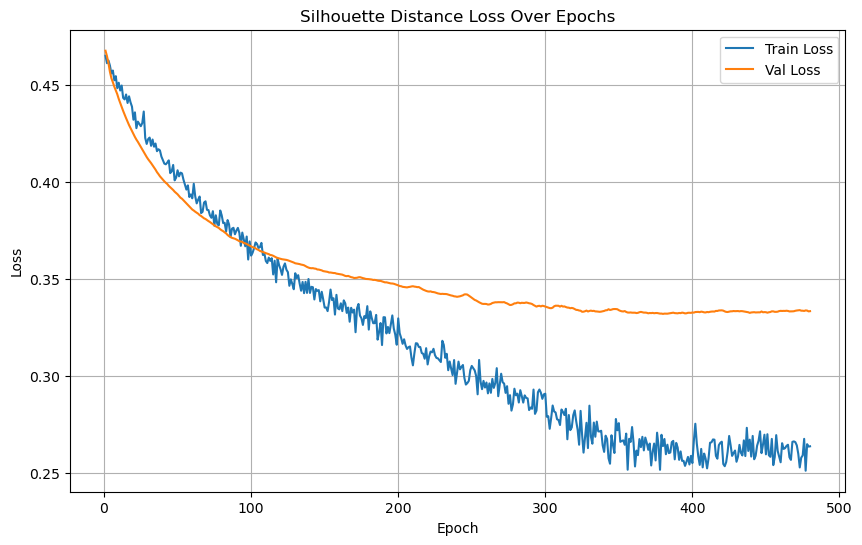

In [51]:
sclsdl_model = SupConNet().to(device)
sclsdl_criterion = SilhouetteDistanceLoss()
sclsdl_optimizer = optim.AdamW(sclsdl_model.parameters(), lr=0.0001, weight_decay=1e-5)
sclsdl_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    sclsdl_optimizer, 
    mode='min',
    patience=25,
    factor=0.1
)

sclsdl_num_epochs = 2000

sclsdl_patience = 100
sclsdl_best_val_loss = float('inf')
sclsdl_epochs_without_improvement = 0

sclsdl_train_loss_history = []
sclsdl_val_loss_history = []

for sclsdl_epoch in range(sclsdl_num_epochs):
    # Training
    sclsdl_model.train()
    sclsdl_running_train_loss = 0.0
    
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Training")
    for batch_idx, (vectors, labels) in enumerate(sclsdl_train_loader):

        vectors = vectors.to(device).float()
        labels = labels.to(device)

        # Forward pass
        sclsdl_train_projections = sclsdl_model(vectors)

        sclsdl_loss = sclsdl_criterion(sclsdl_train_projections, labels)

        # Backprop and optimize
        sclsdl_optimizer.zero_grad()
        sclsdl_loss.backward()
        sclsdl_optimizer.step()

        sclsdl_running_train_loss += sclsdl_loss.item()
        print(f"    Batch [{batch_idx+1}/{len(sclsdl_train_loader)}], Train Loss: {sclsdl_loss.item():.4f}")

    sclsdl_train_epoch_loss = sclsdl_running_train_loss / len(sclsdl_train_loader)
    sclsdl_train_loss_history.append(sclsdl_train_epoch_loss)

    # Validation
    sclsdl_model.eval()
    sclsdl_running_val_loss = 0.0
    print(f"LOG: Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}] - Validation")
    with torch.no_grad():
        for val_batch_idx, (vectors, labels) in enumerate(sclsdl_val_loader):

            vectors = vectors.to(device).float()
            labels = labels.to(device)

            sclsdl_val_projections = sclsdl_model(vectors)
            sclsdl_val_batch_loss = sclsdl_criterion(sclsdl_val_projections, labels).item()
            sclsdl_running_val_loss += sclsdl_val_batch_loss
            print(f"    Batch [{val_batch_idx+1}/{len(sclsdl_val_loader)}], Val Loss: {sclsdl_val_batch_loss:.4f}")

    sclsdl_val_epoch_loss = sclsdl_running_val_loss / len(sclsdl_val_loader)
    sclsdl_val_loss_history.append(sclsdl_val_epoch_loss)
    
    sclsdl_scheduler.step(sclsdl_val_epoch_loss)

    print(f"Epoch [{sclsdl_epoch+1}/{sclsdl_num_epochs}], "
          f"Avg Train Loss: {sclsdl_train_epoch_loss:.4f}, "
          f"Avg Val Loss: {sclsdl_val_epoch_loss:.4f}\n")
    
    #early stopping logic
    if sclsdl_val_epoch_loss < sclsdl_best_val_loss:
        print(f"Validation loss improved from {sclsdl_best_val_loss:.4f} to {sclsdl_val_epoch_loss:.4f}. Saving model...")
        sclsdl_best_val_loss = sclsdl_val_epoch_loss
        sclsdl_epochs_without_improvement = 0
    else:
        sclsdl_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! Patience: {sclsdl_epochs_without_improvement}/{sclsdl_patience}")

    #stop training if val loss not improving
    if sclsdl_epochs_without_improvement >= sclsdl_patience:
        print(f"!! Early stopping triggered at epoch {sclsdl_epoch + 1}!!\nNo improvement for {sclsdl_patience} epochs")
        break

plt.figure(figsize=(10,6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Silhouette Distance Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

Test Batch [10/663], Loss: 0.3744
Test Batch [20/663], Loss: 0.2538
Test Batch [30/663], Loss: 0.2515
Test Batch [40/663], Loss: 0.1822


Test Batch [50/663], Loss: 0.3520
Test Batch [60/663], Loss: 0.2907
Test Batch [70/663], Loss: 0.1946
Test Batch [80/663], Loss: 0.2332


Test Batch [90/663], Loss: 0.1364
Test Batch [100/663], Loss: 0.1814
Test Batch [110/663], Loss: 0.1018
Test Batch [120/663], Loss: 0.2028
Test Batch [130/663], Loss: 0.2775


Test Batch [140/663], Loss: 0.2527
Test Batch [150/663], Loss: 0.1101
Test Batch [160/663], Loss: 0.1839
Test Batch [170/663], Loss: 0.1504
Test Batch [180/663], Loss: 0.5000
Test Batch [190/663], Loss: 0.5000
Test Batch [200/663], Loss: 0.0865
Test Batch [210/663], Loss: 0.5000
Test Batch [220/663], Loss: 0.5000


Test Batch [230/663], Loss: 0.5000
Test Batch [240/663], Loss: 0.5000
Test Batch [250/663], Loss: 0.5000
Test Batch [260/663], Loss: 0.5000
Test Batch [270/663], Loss: 0.5000
Test Batch [280/663], Loss: 0.5000
Test Batch [290/663], Loss: 0.5000
Test Batch [300/663], Loss: 0.3563
Test Batch [310/663], Loss: 0.2347


Test Batch [320/663], Loss: 0.2345
Test Batch [330/663], Loss: 0.1716
Test Batch [340/663], Loss: 0.1431


Test Batch [350/663], Loss: 0.1433
Test Batch [360/663], Loss: 0.1633
Test Batch [370/663], Loss: 0.1361


Test Batch [380/663], Loss: 0.1453
Test Batch [390/663], Loss: 0.0987
Test Batch [400/663], Loss: 0.1577


Test Batch [410/663], Loss: 0.1175
Test Batch [420/663], Loss: 0.1316
Test Batch [430/663], Loss: 0.2277


Test Batch [440/663], Loss: 0.2991
Test Batch [450/663], Loss: 0.3869
Test Batch [460/663], Loss: 0.3510
Test Batch [470/663], Loss: 0.2968


Test Batch [480/663], Loss: 0.2088
Test Batch [490/663], Loss: 0.2623
Test Batch [500/663], Loss: 0.1043


Test Batch [510/663], Loss: 0.1798
Test Batch [520/663], Loss: 0.2088
Test Batch [530/663], Loss: 0.2162


Test Batch [540/663], Loss: 0.2276
Test Batch [550/663], Loss: 0.2482
Test Batch [560/663], Loss: 0.2030


Test Batch [570/663], Loss: 0.3052
Test Batch [580/663], Loss: 0.1787
Test Batch [590/663], Loss: 0.3612


Test Batch [600/663], Loss: 0.2679
Test Batch [610/663], Loss: 0.3033
Test Batch [620/663], Loss: 0.2646
Test Batch [630/663], Loss: 0.2386


Test Batch [640/663], Loss: 0.3002
Test Batch [650/663], Loss: 0.3408
Test Batch [660/663], Loss: 0.4411

Test Loss: 0.2796


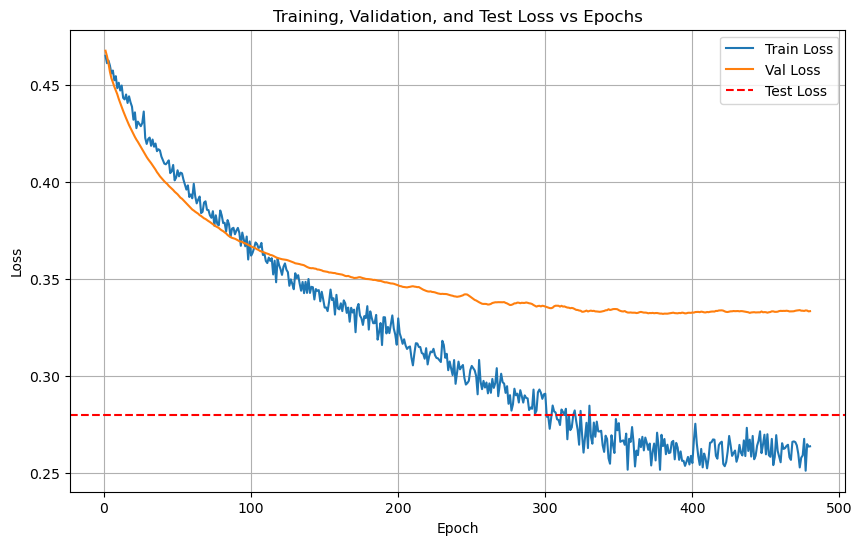

In [52]:
# Test Evaluation
sclsdl_model.eval()
sclsdl_total_test_loss = 0.0

with torch.no_grad():
    for batch_idx, (vectors, labels) in enumerate(sclsdl_test_loader):
        vectors = vectors.to(device).float()
        labels = labels.to(device)
        projections = sclsdl_model(vectors)
        loss = sclsdl_criterion(projections, labels)
        sclsdl_total_test_loss += loss.item()
        if (batch_idx + 1) % 10 == 0:
            print(f"Test Batch [{batch_idx + 1}/{len(sclsdl_test_loader)}], Loss: {loss.item():.4f}")

sclsdl_avg_test_loss = sclsdl_total_test_loss / len(sclsdl_test_loader)
print(f"\nTest Loss: {sclsdl_avg_test_loss:.4f}")


plt.figure(figsize=(10, 6))
sclsdl_num_epochs_run = len(sclsdl_train_loss_history)
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_train_loss_history, label='Train Loss')
plt.plot(range(1, sclsdl_num_epochs_run + 1), sclsdl_val_loss_history, label='Val Loss')
# test loss = horizontal dashed line
plt.axhline(y=sclsdl_avg_test_loss, color='r', linestyle='--', label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training, Validation, and Test Loss vs Epochs")
plt.legend()
plt.grid(True)
plt.show()

### Saving the representations learnt by SCL w/ SDL Model

In [53]:
# dir to save the SCL representations
sclsdl_rep_dir = "sclsdl_representations"
os.makedirs(sclsdl_rep_dir, exist_ok=True)

sclsdl_loaders = {
    'train': sclsdl_train_loader,
    'val': sclsdl_val_loader,
    'test': sclsdl_test_loader
}

sclsdl_model.eval()

with torch.no_grad():
    for sclsdl_split_name, sclsdl_loader in sclsdl_loaders.items():
        print(f"\nExtracting SCL_SDL representations for the {sclsdl_split_name} dataset...")
        # creating subfolder for the split
        sclsdl_split_dir = os.path.join(sclsdl_rep_dir, sclsdl_split_name)
        os.makedirs(sclsdl_split_dir, exist_ok=True)
        
        # processing the data batch-wise
        for sclsdl_batch_idx, (sclsdl_vectors, sclsdl_labels) in enumerate(sclsdl_loader):
            sclsdl_vectors = sclsdl_vectors.to(device).float()
            # computing projections using the trained SCL model
            sclsdl_projections = sclsdl_model(sclsdl_vectors)
            
            # converting projections and labels to np arrays
            sclsdl_projections_np = sclsdl_projections.cpu().numpy()
            sclsdl_labels_np = sclsdl_labels.cpu().numpy()
            
            # saving the batch projections and labels
            np.save(os.path.join(sclsdl_split_dir, f"scl_encoded_batch_{sclsdl_batch_idx}.npy"), sclsdl_projections_np)
            np.save(os.path.join(sclsdl_split_dir, f"scl_labels_batch_{sclsdl_batch_idx}.npy"), sclsdl_labels_np)
            
            if (sclsdl_batch_idx + 1) % 10 == 0:
                print(f"  Processed batch {sclsdl_batch_idx + 1}/{len(sclsdl_loader)} for {sclsdl_split_name} dataset.")

        print(f"Completed extraction for the {sclsdl_split_name} dataset. Representations saved in '{sclsdl_split_dir}'.")

print("SCL representations extraction complete.")


Extracting SCL_SDL representations for the train dataset...
Completed extraction for the train dataset. Representations saved in 'sclsdl_representations\train'.

Extracting SCL_SDL representations for the val dataset...
Completed extraction for the val dataset. Representations saved in 'sclsdl_representations\val'.

Extracting SCL_SDL representations for the test dataset...
  Processed batch 10/663 for test dataset.
  Processed batch 20/663 for test dataset.


  Processed batch 30/663 for test dataset.
  Processed batch 40/663 for test dataset.
  Processed batch 50/663 for test dataset.


  Processed batch 60/663 for test dataset.
  Processed batch 70/663 for test dataset.
  Processed batch 80/663 for test dataset.
  Processed batch 90/663 for test dataset.


  Processed batch 100/663 for test dataset.
  Processed batch 110/663 for test dataset.
  Processed batch 120/663 for test dataset.


  Processed batch 130/663 for test dataset.
  Processed batch 140/663 for test dataset.
  Processed batch 150/663 for test dataset.
  Processed batch 160/663 for test dataset.


  Processed batch 170/663 for test dataset.
  Processed batch 180/663 for test dataset.
  Processed batch 190/663 for test dataset.
  Processed batch 200/663 for test dataset.


  Processed batch 210/663 for test dataset.
  Processed batch 220/663 for test dataset.
  Processed batch 230/663 for test dataset.
  Processed batch 240/663 for test dataset.


  Processed batch 250/663 for test dataset.
  Processed batch 260/663 for test dataset.
  Processed batch 270/663 for test dataset.


  Processed batch 280/663 for test dataset.
  Processed batch 290/663 for test dataset.
  Processed batch 300/663 for test dataset.


  Processed batch 310/663 for test dataset.
  Processed batch 320/663 for test dataset.
  Processed batch 330/663 for test dataset.


  Processed batch 340/663 for test dataset.
  Processed batch 350/663 for test dataset.
  Processed batch 360/663 for test dataset.


  Processed batch 370/663 for test dataset.
  Processed batch 380/663 for test dataset.
  Processed batch 390/663 for test dataset.


  Processed batch 400/663 for test dataset.
  Processed batch 410/663 for test dataset.
  Processed batch 420/663 for test dataset.


  Processed batch 430/663 for test dataset.
  Processed batch 440/663 for test dataset.
  Processed batch 450/663 for test dataset.
  Processed batch 460/663 for test dataset.


  Processed batch 470/663 for test dataset.
  Processed batch 480/663 for test dataset.
  Processed batch 490/663 for test dataset.
  Processed batch 500/663 for test dataset.


  Processed batch 510/663 for test dataset.
  Processed batch 520/663 for test dataset.
  Processed batch 530/663 for test dataset.


  Processed batch 540/663 for test dataset.
  Processed batch 550/663 for test dataset.
  Processed batch 560/663 for test dataset.


  Processed batch 570/663 for test dataset.
  Processed batch 580/663 for test dataset.
  Processed batch 590/663 for test dataset.


  Processed batch 600/663 for test dataset.
  Processed batch 610/663 for test dataset.
  Processed batch 620/663 for test dataset.
  Processed batch 630/663 for test dataset.


  Processed batch 640/663 for test dataset.
  Processed batch 650/663 for test dataset.


  Processed batch 660/663 for test dataset.
Completed extraction for the test dataset. Representations saved in 'sclsdl_representations\test'.
SCL representations extraction complete.


### Classifying the representations learnt by SCL w/ SDL Model with LRM

In [54]:
def load_sclsdl_reps_and_labels(split_dir):
    #gather all the scl_encoded_batch npy files in sorted order
    sclsdl_rep_files = sorted(glob.glob(os.path.join(split_dir, "scl_encoded_batch_*.npy")))

    sclsdl_all_reps = []
    sclsdl_all_labels = []

    for sclsdl_rep_file in sclsdl_rep_files:
        #deriving label filenames
        sclsdl_label_file = sclsdl_rep_file.replace("scl_encoded_batch_", "scl_labels_batch_")

        sclsdl_reps = np.load(sclsdl_rep_file)
        sclsdl_labels = np.load(sclsdl_label_file)

        sclsdl_all_reps.append(sclsdl_reps)
        sclsdl_all_labels.append(sclsdl_labels)

    #concat along first dim
    sclsdl_all_reps = np.concatenate(sclsdl_all_reps, axis = 0)
    sclsdl_all_labels = np.concatenate(sclsdl_all_labels, axis = 0)

    return sclsdl_all_reps, sclsdl_all_labels

In [55]:
sclsdl_lrm_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_lrm_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_lrm_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_lrm_train_reps, sclsdl_lrm_train_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_train_dir)
sclsdl_lrm_val_reps, sclsdl_lrm_val_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_val_dir)
sclsdl_lrm_test_reps, sclsdl_lrm_test_labels = load_sclsdl_reps_and_labels(sclsdl_lrm_test_dir)

print("Train reps shape:", sclsdl_lrm_train_reps.shape)
print("Train labels shape:", sclsdl_lrm_train_labels.shape)

print("Val reps shape:", sclsdl_lrm_val_reps.shape)
print("Val labels shape:", sclsdl_lrm_val_labels.shape)

print("Test reps shape:", sclsdl_lrm_test_reps.shape)
print("Test labels shape:", sclsdl_lrm_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [56]:
# Train Logistic Regression Model on the SCLSDL representations
print("\nLOG: Training Logistic Regression model on SCL SDL representations...")
sclsdl_logistic_clf = LogisticRegression(max_iter=5000, random_state=42, class_weight='balanced')
sclsdl_logistic_clf.fit(sclsdl_lrm_train_reps, sclsdl_lrm_train_labels)
print("LOG: Logistic Regression training complete.")

# Evaluate on Validation Set
print("\nLOG: Evaluating on the validation set...")
sclsdl_lrm_val_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_val_reps)
sclsdl_lrm_val_accuracy = accuracy_score(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions)
print(f"Validation Accuracy: {sclsdl_lrm_val_accuracy * 100:.2f}%")
print("\nValidation Classification Report:\n", classification_report(sclsdl_lrm_val_labels, sclsdl_lrm_val_predictions))

# Evaluate on Test Set
print("\nLOG: Evaluating on the test set...")
sclsdl_lrm_test_predictions = sclsdl_logistic_clf.predict(sclsdl_lrm_test_reps)
sclsdl_lrm_test_accuracy = accuracy_score(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions)
print(f"Test Accuracy: {sclsdl_lrm_test_accuracy * 100:.2f}%")
print("\nTest Classification Report:\n", classification_report(sclsdl_lrm_test_labels, sclsdl_lrm_test_predictions))

np.save(os.path.join(predictions_dir, 'sclsdl_lrm_predictions.npy'), sclsdl_lrm_test_predictions)
np.save(os.path.join(predictions_dir, 'sclsdl_lrm_true_labels.npy'), sclsdl_lrm_test_labels)
print(f"Saved SCL_SDL+LRM predictions and true labels to {predictions_dir}")


LOG: Training Logistic Regression model on SCL SDL representations...
LOG: Logistic Regression training complete.

LOG: Evaluating on the validation set...
Validation Accuracy: 84.44%

Validation Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.40      0.50         5
           1       1.00      0.80      0.89         5
           2       0.67      0.80      0.73         5
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         5
           5       0.83      1.00      0.91         5
           6       0.67      0.80      0.73         5
           7       0.80      0.80      0.80         5
           8       1.00      1.00      1.00         5

    accuracy                           0.84        45
   macro avg       0.85      0.84      0.84        45
weighted avg       0.85      0.84      0.84        45


LOG: Evaluating on the test set...
Test Accuracy: 72.11%

Test Classifica

## Classifying the representations learnt by SCL w/ SDL Model with MLP Classifier

In [57]:
sclsdl_mlp_train_dir = os.path.join("sclsdl_representations", "train")
sclsdl_mlp_val_dir   = os.path.join("sclsdl_representations", "val")
sclsdl_mlp_test_dir  = os.path.join("sclsdl_representations", "test")

sclsdl_mlp_train_reps, sclsdl_mlp_train_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_train_dir)
sclsdl_mlp_val_reps, sclsdl_mlp_val_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_val_dir)
sclsdl_mlp_test_reps, sclsdl_mlp_test_labels = load_sclsdl_reps_and_labels(sclsdl_mlp_test_dir)

print("Train reps shape:", sclsdl_mlp_train_reps.shape)
print("Train labels shape:", sclsdl_mlp_train_labels.shape)

print("Val reps shape:", sclsdl_mlp_val_reps.shape)
print("Val labels shape:", sclsdl_mlp_val_labels.shape)

print("Test reps shape:", sclsdl_mlp_test_reps.shape)
print("Test labels shape:", sclsdl_mlp_test_labels.shape)

Train reps shape: (360, 128)
Train labels shape: (360,)
Val reps shape: (45, 128)
Val labels shape: (45,)
Test reps shape: (42371, 128)
Test labels shape: (42371,)


In [58]:
#converting arrays to torch tensors
sclsdl_mlp_train_embeddings_torch = torch.tensor(sclsdl_mlp_train_reps, dtype=torch.float32)
sclsdl_mlp_train_labels_torch = torch.tensor(sclsdl_mlp_train_labels, dtype=torch.long)

sclsdl_mlp_val_embeddings_torch = torch.tensor(sclsdl_mlp_val_reps, dtype=torch.float32)
sclsdl_mlp_val_labels_torch = torch.tensor(sclsdl_mlp_val_labels, dtype=torch.long)

sclsdl_mlp_test_embeddings_torch = torch.tensor(sclsdl_mlp_test_reps, dtype=torch.float32)
sclsdl_mlp_test_labels_torch = torch.tensor(sclsdl_mlp_test_labels, dtype=torch.long)

#building datasets for mlp
sclsdl_mlp_train_dataset = TensorDataset(sclsdl_mlp_train_embeddings_torch, sclsdl_mlp_train_labels_torch)
sclsdl_mlp_val_dataset = TensorDataset(sclsdl_mlp_val_embeddings_torch, sclsdl_mlp_val_labels_torch)
sclsdl_mlp_test_dataset = TensorDataset(sclsdl_mlp_test_embeddings_torch, sclsdl_mlp_test_labels_torch)

sclsdl_mlp_batch_size = 64
sclsdl_mlp_train_loader = DataLoader(sclsdl_mlp_train_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=True)
sclsdl_mlp_val_loader = DataLoader(sclsdl_mlp_val_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)
sclsdl_mlp_test_loader = DataLoader(sclsdl_mlp_test_dataset, batch_size=sclsdl_mlp_batch_size, shuffle=False)


[Epoch 1/1000] Train Loss: 2.1894  |  Val Loss: 2.1559
Validation loss improved from inf to 2.1559.
[Epoch 2/1000] Train Loss: 2.0867  |  Val Loss: 2.0704
Validation loss improved from 2.1559 to 2.0704.
[Epoch 3/1000] Train Loss: 1.9945  |  Val Loss: 1.9933
Validation loss improved from 2.0704 to 1.9933.
[Epoch 4/1000] Train Loss: 1.9162  |  Val Loss: 1.9262
Validation loss improved from 1.9933 to 1.9262.
[Epoch 5/1000] Train Loss: 1.8471  |  Val Loss: 1.8702
Validation loss improved from 1.9262 to 1.8702.
[Epoch 6/1000] Train Loss: 1.7874  |  Val Loss: 1.8211
Validation loss improved from 1.8702 to 1.8211.
[Epoch 7/1000] Train Loss: 1.7323  |  Val Loss: 1.7761
Validation loss improved from 1.8211 to 1.7761.
[Epoch 8/1000] Train Loss: 1.6802  |  Val Loss: 1.7335
Validation loss improved from 1.7761 to 1.7335.
[Epoch 9/1000] Train Loss: 1.6298  |  Val Loss: 1.6940
Validation loss improved from 1.7335 to 1.6940.
[Epoch 10/1000] Train Loss: 1.5818  |  Val Loss: 1.6562
Validation loss impr

[Epoch 14/1000] Train Loss: 1.4298  |  Val Loss: 1.5316
Validation loss improved from 1.5595 to 1.5316.
[Epoch 15/1000] Train Loss: 1.3990  |  Val Loss: 1.5053
Validation loss improved from 1.5316 to 1.5053.
[Epoch 16/1000] Train Loss: 1.3695  |  Val Loss: 1.4810
Validation loss improved from 1.5053 to 1.4810.
[Epoch 17/1000] Train Loss: 1.3421  |  Val Loss: 1.4575
Validation loss improved from 1.4810 to 1.4575.
[Epoch 18/1000] Train Loss: 1.3162  |  Val Loss: 1.4351
Validation loss improved from 1.4575 to 1.4351.
[Epoch 19/1000] Train Loss: 1.2911  |  Val Loss: 1.4140
Validation loss improved from 1.4351 to 1.4140.


[Epoch 20/1000] Train Loss: 1.2661  |  Val Loss: 1.3937
Validation loss improved from 1.4140 to 1.3937.
[Epoch 21/1000] Train Loss: 1.2418  |  Val Loss: 1.3743
Validation loss improved from 1.3937 to 1.3743.
[Epoch 22/1000] Train Loss: 1.2191  |  Val Loss: 1.3562
Validation loss improved from 1.3743 to 1.3562.
[Epoch 23/1000] Train Loss: 1.1970  |  Val Loss: 1.3390
Validation loss improved from 1.3562 to 1.3390.
[Epoch 24/1000] Train Loss: 1.1748  |  Val Loss: 1.3226
Validation loss improved from 1.3390 to 1.3226.
[Epoch 25/1000] Train Loss: 1.1541  |  Val Loss: 1.3066
Validation loss improved from 1.3226 to 1.3066.
[Epoch 26/1000] Train Loss: 1.1330  |  Val Loss: 1.2911
Validation loss improved from 1.3066 to 1.2911.
[Epoch 27/1000] Train Loss: 1.1121  |  Val Loss: 1.2761
Validation loss improved from 1.2911 to 1.2761.
[Epoch 28/1000] Train Loss: 1.0911  |  Val Loss: 1.2615
Validation loss improved from 1.2761 to 1.2615.
[Epoch 29/1000] Train Loss: 1.0709  |  Val Loss: 1.2470
Validati

[Epoch 33/1000] Train Loss: 0.9937  |  Val Loss: 1.1915
Validation loss improved from 1.2049 to 1.1915.
[Epoch 34/1000] Train Loss: 0.9750  |  Val Loss: 1.1780
Validation loss improved from 1.1915 to 1.1780.
[Epoch 35/1000] Train Loss: 0.9566  |  Val Loss: 1.1647
Validation loss improved from 1.1780 to 1.1647.


[Epoch 36/1000] Train Loss: 0.9385  |  Val Loss: 1.1514
Validation loss improved from 1.1647 to 1.1514.
[Epoch 37/1000] Train Loss: 0.9202  |  Val Loss: 1.1385
Validation loss improved from 1.1514 to 1.1385.
[Epoch 38/1000] Train Loss: 0.9021  |  Val Loss: 1.1256
Validation loss improved from 1.1385 to 1.1256.
[Epoch 39/1000] Train Loss: 0.8838  |  Val Loss: 1.1128
Validation loss improved from 1.1256 to 1.1128.
[Epoch 40/1000] Train Loss: 0.8662  |  Val Loss: 1.1001
Validation loss improved from 1.1128 to 1.1001.
[Epoch 41/1000] Train Loss: 0.8481  |  Val Loss: 1.0882
Validation loss improved from 1.1001 to 1.0882.
[Epoch 42/1000] Train Loss: 0.8304  |  Val Loss: 1.0757
Validation loss improved from 1.0882 to 1.0757.
[Epoch 43/1000] Train Loss: 0.8128  |  Val Loss: 1.0632
Validation loss improved from 1.0757 to 1.0632.
[Epoch 44/1000] Train Loss: 0.7951  |  Val Loss: 1.0514
Validation loss improved from 1.0632 to 1.0514.
[Epoch 45/1000] Train Loss: 0.7781  |  Val Loss: 1.0392
Validati

[Epoch 48/1000] Train Loss: 0.7268  |  Val Loss: 1.0046
Validation loss improved from 1.0162 to 1.0046.
[Epoch 49/1000] Train Loss: 0.7104  |  Val Loss: 0.9936
Validation loss improved from 1.0046 to 0.9936.
[Epoch 50/1000] Train Loss: 0.6942  |  Val Loss: 0.9826
Validation loss improved from 0.9936 to 0.9826.


[Epoch 51/1000] Train Loss: 0.6780  |  Val Loss: 0.9721
Validation loss improved from 0.9826 to 0.9721.
[Epoch 52/1000] Train Loss: 0.6624  |  Val Loss: 0.9615
Validation loss improved from 0.9721 to 0.9615.
[Epoch 53/1000] Train Loss: 0.6470  |  Val Loss: 0.9514
Validation loss improved from 0.9615 to 0.9514.
[Epoch 54/1000] Train Loss: 0.6318  |  Val Loss: 0.9410
Validation loss improved from 0.9514 to 0.9410.
[Epoch 55/1000] Train Loss: 0.6166  |  Val Loss: 0.9312
Validation loss improved from 0.9410 to 0.9312.
[Epoch 56/1000] Train Loss: 0.6021  |  Val Loss: 0.9211
Validation loss improved from 0.9312 to 0.9211.
[Epoch 57/1000] Train Loss: 0.5879  |  Val Loss: 0.9116
Validation loss improved from 0.9211 to 0.9116.
[Epoch 58/1000] Train Loss: 0.5743  |  Val Loss: 0.9023
Validation loss improved from 0.9116 to 0.9023.
[Epoch 59/1000] Train Loss: 0.5610  |  Val Loss: 0.8934
Validation loss improved from 0.9023 to 0.8934.
[Epoch 60/1000] Train Loss: 0.5479  |  Val Loss: 0.8845
Validati

[Epoch 66/1000] Train Loss: 0.4783  |  Val Loss: 0.8413
Validation loss improved from 0.8479 to 0.8413.
[Epoch 67/1000] Train Loss: 0.4682  |  Val Loss: 0.8349
Validation loss improved from 0.8413 to 0.8349.
[Epoch 68/1000] Train Loss: 0.4579  |  Val Loss: 0.8294
Validation loss improved from 0.8349 to 0.8294.
[Epoch 69/1000] Train Loss: 0.4483  |  Val Loss: 0.8241
Validation loss improved from 0.8294 to 0.8241.
[Epoch 70/1000] Train Loss: 0.4394  |  Val Loss: 0.8187
Validation loss improved from 0.8241 to 0.8187.
[Epoch 71/1000] Train Loss: 0.4303  |  Val Loss: 0.8139
Validation loss improved from 0.8187 to 0.8139.
[Epoch 72/1000] Train Loss: 0.4214  |  Val Loss: 0.8094
Validation loss improved from 0.8139 to 0.8094.
[Epoch 73/1000] Train Loss: 0.4130  |  Val Loss: 0.8052
Validation loss improved from 0.8094 to 0.8052.
[Epoch 74/1000] Train Loss: 0.4050  |  Val Loss: 0.8004
Validation loss improved from 0.8052 to 0.8004.
[Epoch 75/1000] Train Loss: 0.3970  |  Val Loss: 0.7960
Validati

[Epoch 83/1000] Train Loss: 0.3440  |  Val Loss: 0.7701
Validation loss improved from 0.7728 to 0.7701.
[Epoch 84/1000] Train Loss: 0.3385  |  Val Loss: 0.7678
Validation loss improved from 0.7701 to 0.7678.
[Epoch 85/1000] Train Loss: 0.3331  |  Val Loss: 0.7660
Validation loss improved from 0.7678 to 0.7660.
[Epoch 86/1000] Train Loss: 0.3278  |  Val Loss: 0.7638
Validation loss improved from 0.7660 to 0.7638.
[Epoch 87/1000] Train Loss: 0.3228  |  Val Loss: 0.7610
Validation loss improved from 0.7638 to 0.7610.
[Epoch 88/1000] Train Loss: 0.3177  |  Val Loss: 0.7593
Validation loss improved from 0.7610 to 0.7593.
[Epoch 89/1000] Train Loss: 0.3132  |  Val Loss: 0.7582
Validation loss improved from 0.7593 to 0.7582.
[Epoch 90/1000] Train Loss: 0.3086  |  Val Loss: 0.7573
Validation loss improved from 0.7582 to 0.7573.
[Epoch 91/1000] Train Loss: 0.3043  |  Val Loss: 0.7567
Validation loss improved from 0.7573 to 0.7567.
[Epoch 92/1000] Train Loss: 0.2997  |  Val Loss: 0.7546
Validati

[Epoch 100/1000] Train Loss: 0.2702  |  Val Loss: 0.7451
Validation loss improved from 0.7458 to 0.7451.
[Epoch 101/1000] Train Loss: 0.2672  |  Val Loss: 0.7445
Validation loss improved from 0.7451 to 0.7445.
[Epoch 102/1000] Train Loss: 0.2641  |  Val Loss: 0.7443
Validation loss improved from 0.7445 to 0.7443.
[Epoch 103/1000] Train Loss: 0.2613  |  Val Loss: 0.7438
Validation loss improved from 0.7443 to 0.7438.
[Epoch 104/1000] Train Loss: 0.2584  |  Val Loss: 0.7427
Validation loss improved from 0.7438 to 0.7427.
[Epoch 105/1000] Train Loss: 0.2555  |  Val Loss: 0.7426
Validation loss improved from 0.7427 to 0.7426.
[Epoch 106/1000] Train Loss: 0.2528  |  Val Loss: 0.7424
Validation loss improved from 0.7426 to 0.7424.
[Epoch 107/1000] Train Loss: 0.2503  |  Val Loss: 0.7418
Validation loss improved from 0.7424 to 0.7418.
[Epoch 108/1000] Train Loss: 0.2479  |  Val Loss: 0.7407
Validation loss improved from 0.7418 to 0.7407.
[Epoch 109/1000] Train Loss: 0.2453  |  Val Loss: 0.741

[Epoch 118/1000] Train Loss: 0.2268  |  Val Loss: 0.7413
!! Validation loss did NOT improve !! Patience: 4/100
[Epoch 119/1000] Train Loss: 0.2247  |  Val Loss: 0.7403
!! Validation loss did NOT improve !! Patience: 5/100
[Epoch 120/1000] Train Loss: 0.2228  |  Val Loss: 0.7405
!! Validation loss did NOT improve !! Patience: 6/100
[Epoch 121/1000] Train Loss: 0.2212  |  Val Loss: 0.7408
!! Validation loss did NOT improve !! Patience: 7/100
[Epoch 122/1000] Train Loss: 0.2194  |  Val Loss: 0.7404
!! Validation loss did NOT improve !! Patience: 8/100
[Epoch 123/1000] Train Loss: 0.2178  |  Val Loss: 0.7407
!! Validation loss did NOT improve !! Patience: 9/100
[Epoch 124/1000] Train Loss: 0.2163  |  Val Loss: 0.7419
!! Validation loss did NOT improve !! Patience: 10/100
[Epoch 125/1000] Train Loss: 0.2146  |  Val Loss: 0.7426
!! Validation loss did NOT improve !! Patience: 11/100
[Epoch 126/1000] Train Loss: 0.2132  |  Val Loss: 0.7432
!! Validation loss did NOT improve !! Patience: 12/10

[Epoch 135/1000] Train Loss: 0.2013  |  Val Loss: 0.7478
!! Validation loss did NOT improve !! Patience: 21/100
[Epoch 136/1000] Train Loss: 0.2002  |  Val Loss: 0.7469
!! Validation loss did NOT improve !! Patience: 22/100
[Epoch 137/1000] Train Loss: 0.1990  |  Val Loss: 0.7474
!! Validation loss did NOT improve !! Patience: 23/100
[Epoch 138/1000] Train Loss: 0.1978  |  Val Loss: 0.7479
!! Validation loss did NOT improve !! Patience: 24/100
[Epoch 139/1000] Train Loss: 0.1970  |  Val Loss: 0.7481
!! Validation loss did NOT improve !! Patience: 25/100
[Epoch 140/1000] Train Loss: 0.1954  |  Val Loss: 0.7493
!! Validation loss did NOT improve !! Patience: 26/100
[Epoch 141/1000] Train Loss: 0.1943  |  Val Loss: 0.7503
!! Validation loss did NOT improve !! Patience: 27/100
[Epoch 142/1000] Train Loss: 0.1932  |  Val Loss: 0.7514
!! Validation loss did NOT improve !! Patience: 28/100
[Epoch 143/1000] Train Loss: 0.1922  |  Val Loss: 0.7527
!! Validation loss did NOT improve !! Patience:

[Epoch 153/1000] Train Loss: 0.1832  |  Val Loss: 0.7579
!! Validation loss did NOT improve !! Patience: 39/100
[Epoch 154/1000] Train Loss: 0.1825  |  Val Loss: 0.7573
!! Validation loss did NOT improve !! Patience: 40/100
[Epoch 155/1000] Train Loss: 0.1817  |  Val Loss: 0.7591
!! Validation loss did NOT improve !! Patience: 41/100
[Epoch 156/1000] Train Loss: 0.1807  |  Val Loss: 0.7590
!! Validation loss did NOT improve !! Patience: 42/100
[Epoch 157/1000] Train Loss: 0.1799  |  Val Loss: 0.7596
!! Validation loss did NOT improve !! Patience: 43/100
[Epoch 158/1000] Train Loss: 0.1794  |  Val Loss: 0.7612
!! Validation loss did NOT improve !! Patience: 44/100
[Epoch 159/1000] Train Loss: 0.1785  |  Val Loss: 0.7611
!! Validation loss did NOT improve !! Patience: 45/100
[Epoch 160/1000] Train Loss: 0.1777  |  Val Loss: 0.7619
!! Validation loss did NOT improve !! Patience: 46/100
[Epoch 161/1000] Train Loss: 0.1769  |  Val Loss: 0.7624
!! Validation loss did NOT improve !! Patience:

[Epoch 168/1000] Train Loss: 0.1720  |  Val Loss: 0.7657
!! Validation loss did NOT improve !! Patience: 54/100
[Epoch 169/1000] Train Loss: 0.1714  |  Val Loss: 0.7657
!! Validation loss did NOT improve !! Patience: 55/100
[Epoch 170/1000] Train Loss: 0.1708  |  Val Loss: 0.7658
!! Validation loss did NOT improve !! Patience: 56/100
[Epoch 171/1000] Train Loss: 0.1701  |  Val Loss: 0.7669
!! Validation loss did NOT improve !! Patience: 57/100
[Epoch 172/1000] Train Loss: 0.1695  |  Val Loss: 0.7668
!! Validation loss did NOT improve !! Patience: 58/100
[Epoch 173/1000] Train Loss: 0.1691  |  Val Loss: 0.7688
!! Validation loss did NOT improve !! Patience: 59/100
[Epoch 174/1000] Train Loss: 0.1681  |  Val Loss: 0.7699
!! Validation loss did NOT improve !! Patience: 60/100
[Epoch 175/1000] Train Loss: 0.1675  |  Val Loss: 0.7709
!! Validation loss did NOT improve !! Patience: 61/100
[Epoch 176/1000] Train Loss: 0.1669  |  Val Loss: 0.7708
!! Validation loss did NOT improve !! Patience:

[Epoch 185/1000] Train Loss: 0.1618  |  Val Loss: 0.7759
!! Validation loss did NOT improve !! Patience: 71/100
[Epoch 186/1000] Train Loss: 0.1613  |  Val Loss: 0.7778
!! Validation loss did NOT improve !! Patience: 72/100
[Epoch 187/1000] Train Loss: 0.1607  |  Val Loss: 0.7780
!! Validation loss did NOT improve !! Patience: 73/100
[Epoch 188/1000] Train Loss: 0.1605  |  Val Loss: 0.7778
!! Validation loss did NOT improve !! Patience: 74/100
[Epoch 189/1000] Train Loss: 0.1602  |  Val Loss: 0.7793
!! Validation loss did NOT improve !! Patience: 75/100
[Epoch 190/1000] Train Loss: 0.1592  |  Val Loss: 0.7794
!! Validation loss did NOT improve !! Patience: 76/100
[Epoch 191/1000] Train Loss: 0.1585  |  Val Loss: 0.7797
!! Validation loss did NOT improve !! Patience: 77/100
[Epoch 192/1000] Train Loss: 0.1581  |  Val Loss: 0.7805
!! Validation loss did NOT improve !! Patience: 78/100
[Epoch 193/1000] Train Loss: 0.1576  |  Val Loss: 0.7810
!! Validation loss did NOT improve !! Patience:

[Epoch 201/1000] Train Loss: 0.1539  |  Val Loss: 0.7871
!! Validation loss did NOT improve !! Patience: 87/100
[Epoch 202/1000] Train Loss: 0.1534  |  Val Loss: 0.7872
!! Validation loss did NOT improve !! Patience: 88/100
[Epoch 203/1000] Train Loss: 0.1530  |  Val Loss: 0.7882
!! Validation loss did NOT improve !! Patience: 89/100
[Epoch 204/1000] Train Loss: 0.1526  |  Val Loss: 0.7886
!! Validation loss did NOT improve !! Patience: 90/100
[Epoch 205/1000] Train Loss: 0.1522  |  Val Loss: 0.7896
!! Validation loss did NOT improve !! Patience: 91/100
[Epoch 206/1000] Train Loss: 0.1518  |  Val Loss: 0.7899
!! Validation loss did NOT improve !! Patience: 92/100
[Epoch 207/1000] Train Loss: 0.1511  |  Val Loss: 0.7909
!! Validation loss did NOT improve !! Patience: 93/100
[Epoch 208/1000] Train Loss: 0.1508  |  Val Loss: 0.7920
!! Validation loss did NOT improve !! Patience: 94/100
[Epoch 209/1000] Train Loss: 0.1505  |  Val Loss: 0.7926
!! Validation loss did NOT improve !! Patience:

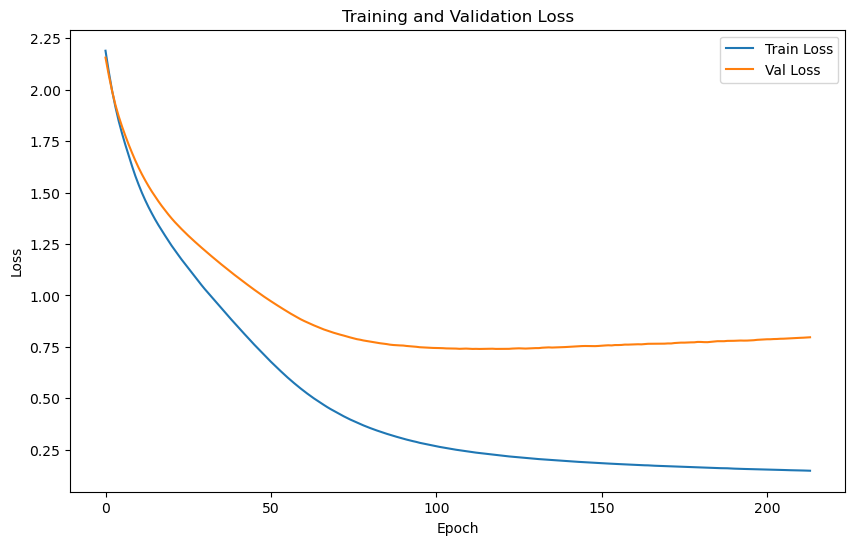

In [59]:
sclsdl_mlp_input_dim = sclsdl_mlp_train_reps.shape[1]
sclsdl_mlp_num_classes = len(torch.unique(sclsdl_mlp_train_labels_torch))
sclsdl_mlp_model = MLPClassifier(sclsdl_mlp_input_dim, sclsdl_mlp_num_classes).to(device)

sclsdl_mlp_criterion = nn.CrossEntropyLoss()
sclsdl_mlp_optimizer = optim.Adam(sclsdl_mlp_model.parameters(), lr=1e-4)

sclsdl_mlp_num_epochs = 1000
sclsdl_mlp_patience = 100

sclsdl_mlp_train_losses = []
sclsdl_mlp_val_losses = []

sclsdl_mlp_best_val_loss = float('inf')
sclsdl_mlp_epochs_without_improvement = 0

for sclsdl_mlp_epoch in range(sclsdl_mlp_num_epochs):
    # Training
    sclsdl_mlp_model.train()
    sclsdl_mlp_train_running_loss = 0.0
    
    for sclsdl_mlp_embeddings_batch, sclsdl_mlp_labels_batch in sclsdl_mlp_train_loader:
        sclsdl_mlp_embeddings_batch = sclsdl_mlp_embeddings_batch.to(device)
        sclsdl_mlp_labels_batch = sclsdl_mlp_labels_batch.to(device)
        
        sclsdl_mlp_optimizer.zero_grad()
        
        # Forward
        sclsdl_mlp_outputs = sclsdl_mlp_model(sclsdl_mlp_embeddings_batch)
        sclsdl_mlp_loss = sclsdl_mlp_criterion(sclsdl_mlp_outputs, sclsdl_mlp_labels_batch)
        
        # Backward & Update
        sclsdl_mlp_loss.backward()
        sclsdl_mlp_optimizer.step()
        
        sclsdl_mlp_train_running_loss += sclsdl_mlp_loss.item() * sclsdl_mlp_embeddings_batch.size(0)
    
    sclsdl_mlp_epoch_train_loss = sclsdl_mlp_train_running_loss / len(sclsdl_mlp_train_loader.dataset)
    sclsdl_mlp_train_losses.append(sclsdl_mlp_epoch_train_loss)

    # Validation
    sclsdl_mlp_model.eval()
    sclsdl_mlp_val_running_loss = 0.0
    
    with torch.no_grad():
        for sclsdl_mlp_val_embeddings_batch, sclsdl_mlp_val_labels_batch in sclsdl_mlp_val_loader:
            sclsdl_mlp_val_embeddings_batch = sclsdl_mlp_val_embeddings_batch.to(device)
            sclsdl_mlp_val_labels_batch = sclsdl_mlp_val_labels_batch.to(device)

            sclsdl_mlp_val_outputs = sclsdl_mlp_model(sclsdl_mlp_val_embeddings_batch)
            sclsdl_mlp_val_loss = sclsdl_mlp_criterion(sclsdl_mlp_val_outputs, sclsdl_mlp_val_labels_batch)

            sclsdl_mlp_val_running_loss += sclsdl_mlp_val_loss.item() * sclsdl_mlp_val_embeddings_batch.size(0)

    sclsdl_mlp_epoch_val_loss = sclsdl_mlp_val_running_loss / len(sclsdl_mlp_val_loader.dataset)
    sclsdl_mlp_val_losses.append(sclsdl_mlp_epoch_val_loss)

    print(f"[Epoch {sclsdl_mlp_epoch+1}/{sclsdl_mlp_num_epochs}] "
          f"Train Loss: {sclsdl_mlp_epoch_train_loss:.4f}  |  "
          f"Val Loss: {sclsdl_mlp_epoch_val_loss:.4f}")

    # Early stopping
    if sclsdl_mlp_epoch_val_loss < sclsdl_mlp_best_val_loss:
        print(f"Validation loss improved from {sclsdl_mlp_best_val_loss:.4f} to {sclsdl_mlp_epoch_val_loss:.4f}.")
        sclsdl_mlp_best_val_loss = sclsdl_mlp_epoch_val_loss
        sclsdl_mlp_epochs_without_improvement = 0


    else:
        sclsdl_mlp_epochs_without_improvement += 1
        print(f"!! Validation loss did NOT improve !! "
              f"Patience: {sclsdl_mlp_epochs_without_improvement}/{sclsdl_mlp_patience}")
        
        if sclsdl_mlp_epochs_without_improvement >= sclsdl_mlp_patience:
            print(f"!! Early stopping triggered at epoch {sclsdl_mlp_epoch+1} !!\n"
                  f"No improvement for {sclsdl_mlp_patience} epochs.")
            break

plt.figure(figsize=(10,6))
plt.plot(sclsdl_mlp_train_losses, label='Train Loss')
plt.plot(sclsdl_mlp_val_losses,   label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


Saved SCL_SDL+MLP predictions and true labels to model_predictions
Test Loss: 0.7291 | Test Accuracy: 72.85%


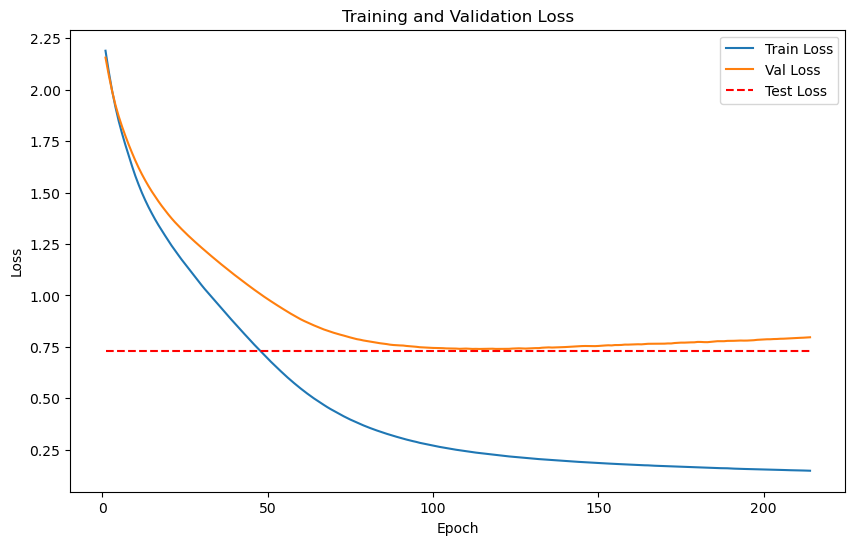

In [60]:
sclsdl_mlp_model.eval()

sclsdl_mlp_test_running_loss = 0.0
sclsdl_mlp_test_correct = 0
sclsdl_mlp_all_predictions = []
sclsdl_mlp_all_true_labels = []

with torch.no_grad():
    for sclsdl_mlp_test_embeddings_batch, sclsdl_mlp_test_labels_batch in sclsdl_mlp_test_loader:
        sclsdl_mlp_test_embeddings_batch = sclsdl_mlp_test_embeddings_batch.to(device)
        sclsdl_mlp_test_labels_batch = sclsdl_mlp_test_labels_batch.to(device)

        # Forward pass
        sclsdl_mlp_test_outputs = sclsdl_mlp_model(sclsdl_mlp_test_embeddings_batch)
        
        # Compute loss
        sclsdl_mlp_test_loss_batch = sclsdl_mlp_criterion(sclsdl_mlp_test_outputs, sclsdl_mlp_test_labels_batch)
        sclsdl_mlp_test_running_loss += sclsdl_mlp_test_loss_batch.item() * sclsdl_mlp_test_embeddings_batch.size(0)

        _, sclsdl_mlp_test_predicted = torch.max(sclsdl_mlp_test_outputs, dim=1)
        sclsdl_mlp_test_correct += (sclsdl_mlp_test_predicted == sclsdl_mlp_test_labels_batch).sum().item()

        sclsdl_mlp_all_predictions.extend(sclsdl_mlp_test_predicted.cpu().numpy())
        sclsdl_mlp_all_true_labels.extend(sclsdl_mlp_test_labels_batch.cpu().numpy())

np.save(os.path.join(predictions_dir, 'sclsdl_mlp_predictions.npy'), np.array(sclsdl_mlp_all_predictions))
np.save(os.path.join(predictions_dir, 'sclsdl_mlp_true_labels.npy'), np.array(sclsdl_mlp_all_true_labels))
print(f"Saved SCL_SDL+MLP predictions and true labels to {predictions_dir}")

sclsdl_mlp_epoch_test_loss = sclsdl_mlp_test_running_loss / len(sclsdl_mlp_test_loader.dataset)
sclsdl_mlp_test_accuracy = sclsdl_mlp_test_correct / len(sclsdl_mlp_test_loader.dataset)

sclsdl_mlp_test_accuracy_pct = sclsdl_mlp_test_accuracy * 100.0

print(f"Test Loss: {sclsdl_mlp_epoch_test_loss:.4f} | Test Accuracy: {sclsdl_mlp_test_accuracy_pct:.2f}%")

sclsdl_mlp_num_epochs_run = len(sclsdl_mlp_train_losses)

plt.figure(figsize=(10,6))

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_train_losses,
         label='Train Loss')
plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         sclsdl_mlp_val_losses,
         label='Val Loss')

plt.plot(range(1, sclsdl_mlp_num_epochs_run + 1),
         [sclsdl_mlp_epoch_test_loss]*sclsdl_mlp_num_epochs_run,
         'r--',
         label='Test Loss')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()


## Experimental Results and Confusion Matrices

In [61]:
def plot_conf_matrix(model_name, class_names = None, cm_save_dir='confusion_matrices'):
    os.makedirs(cm_save_dir, exist_ok = True)

    #loading predictions and true labels
    predictions_path = os.path.join(predictions_dir, f'{model_name}_predictions.npy')
    true_labels_path = os.path.join(predictions_dir, f'{model_name}_true_labels.npy')

    if not os.path.exists(predictions_path) or not os.path.exists(true_labels_path):
        print(f"Error: Files not found for model {model_name}")
        return
    
    cm_predictions = np.load(predictions_path)
    cm_true_labels = np.load(true_labels_path)

    conf_matrix = confusion_matrix(cm_true_labels, cm_predictions)
    plt.figure(figsize=(8,8))

    conf_matrix_normalised = conf_matrix.astype('float') / conf_matrix.sum(axis = 1)[:, np.newaxis]
    sns.heatmap(conf_matrix_normalised, annot=conf_matrix, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.title(f"{model_name.upper()} Confusion Matrix", fontsize=16)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()

    cm_save_path = os.path.join(cm_save_dir, f'{model_name}_confusion_matrix.png')
    plt.savefig(cm_save_path, dpi=300, bbox_inches='tight')
    print(f"Saved confusion matrix to: {cm_save_path}")

    plt.show()

    accuracy = np.trace(conf_matrix) / np.sum(conf_matrix)
    print(f"Classification Accuracy: {accuracy*100:.2f}%")

Saving confusion matrices to: confusion_matrices


Saved confusion matrix to: confusion_matrices\e2e_cnn_confusion_matrix.png


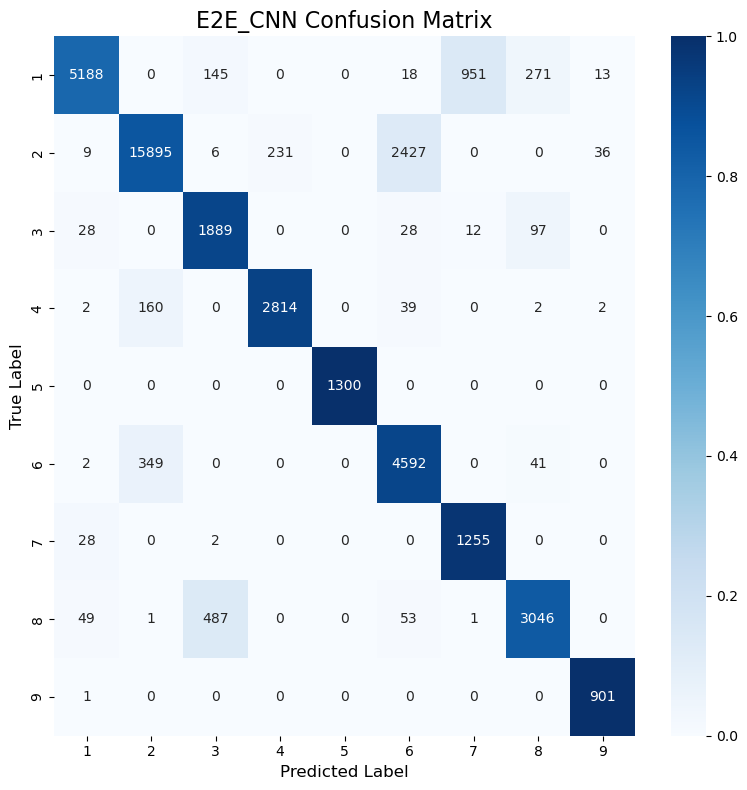

Classification Accuracy: 87.04%


Saved confusion matrix to: confusion_matrices\cae_lrm_confusion_matrix.png


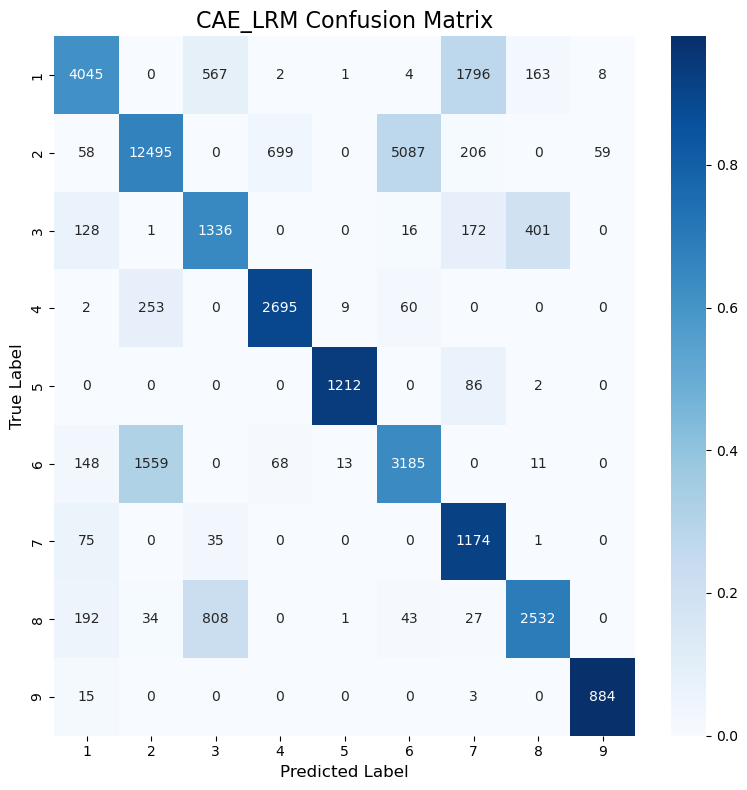

Classification Accuracy: 69.76%


Saved confusion matrix to: confusion_matrices\cae_mlp_confusion_matrix.png


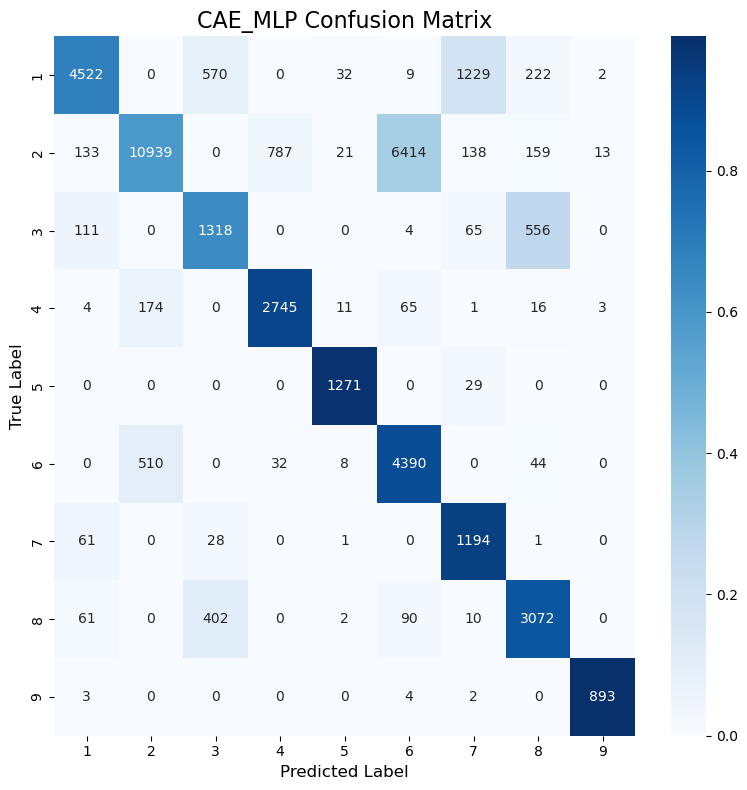

Classification Accuracy: 71.62%


Saved confusion matrix to: confusion_matrices\tscl_lrm_confusion_matrix.png


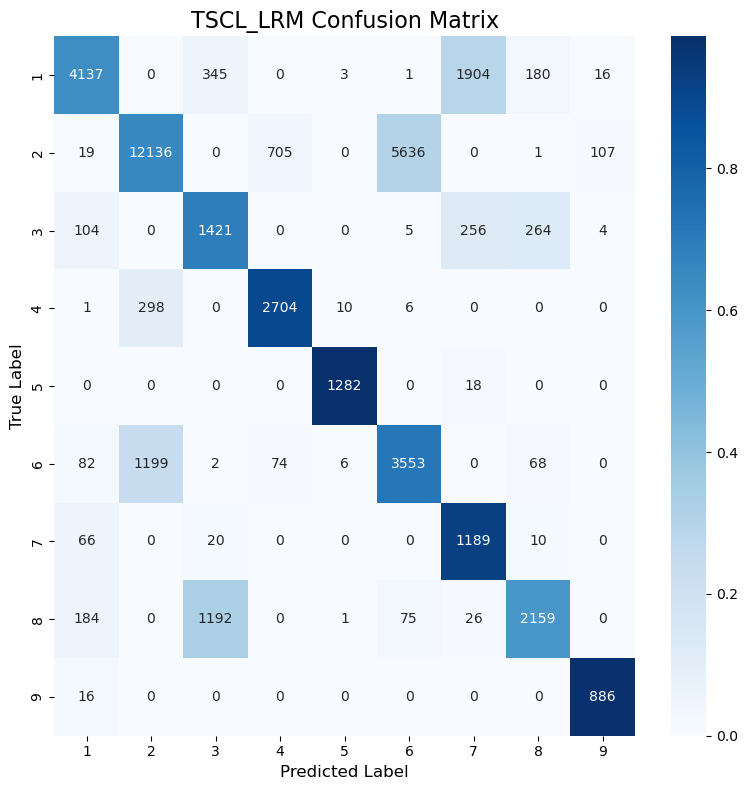

Classification Accuracy: 69.55%


Saved confusion matrix to: confusion_matrices\tscl_mlp_confusion_matrix.png


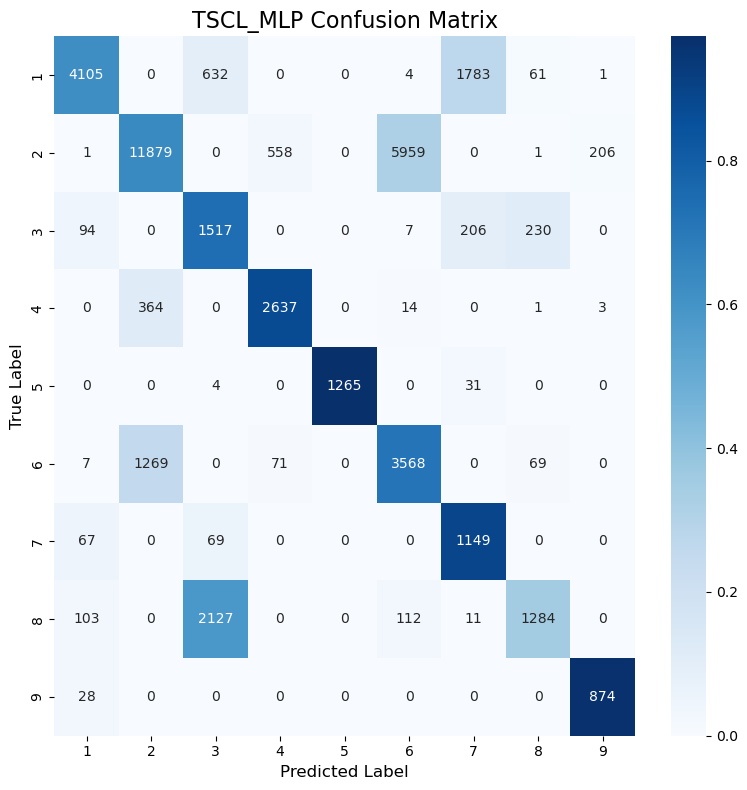

Classification Accuracy: 66.74%


Saved confusion matrix to: confusion_matrices\sclsdl_lrm_confusion_matrix.png


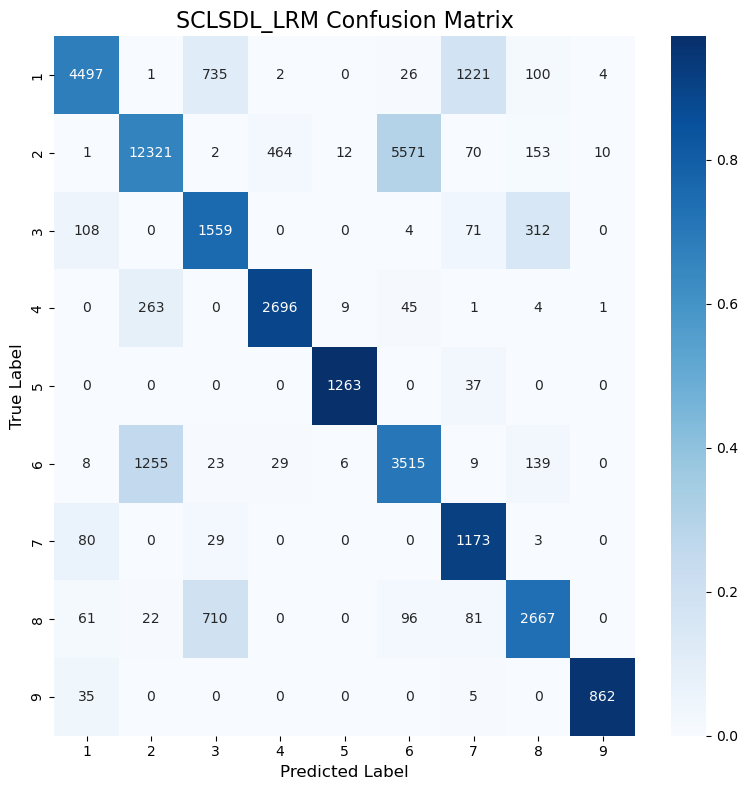

Classification Accuracy: 72.11%


Saved confusion matrix to: confusion_matrices\sclsdl_mlp_confusion_matrix.png


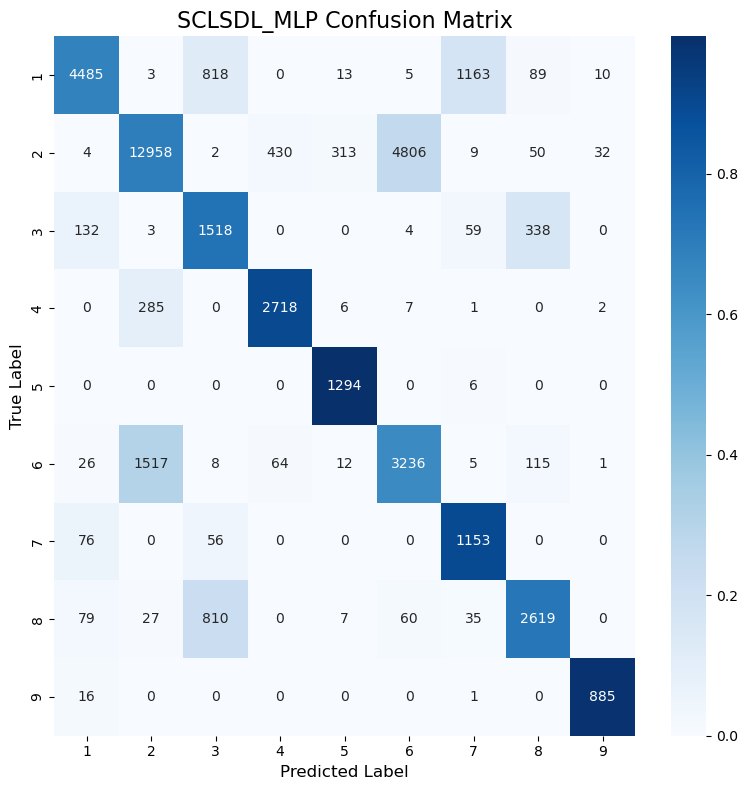

Classification Accuracy: 72.85%


In [62]:
class_names = [str(i+1) for i in range(len(np.unique(y_labels)))]
confusion_matrices_dir = 'confusion_matrices'
os.makedirs(confusion_matrices_dir, exist_ok=True)
print(f"Saving confusion matrices to: {confusion_matrices_dir}")
plot_conf_matrix('e2e_cnn', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('cae_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('tscl_mlp', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_lrm', class_names, confusion_matrices_dir)
plot_conf_matrix('sclsdl_mlp', class_names, confusion_matrices_dir)

In [63]:
final_results_df = pd.DataFrame({
    "Model": ["E2E CNN", "LRM (CAE)", "MLP (CAE)", "TSCL LRM", "TSCL MLP", "SCL_SDL LRM", "SCL_SDL MLP"],
    "Test_Accuracy": [test_accuracy, lrm_test_accuracy * 100, cae_mlp_test_accuracy_pct, 
                      tscl_lrm_test_accuracy * 100, tscl_mlp_test_accuracy_pct, 
                      sclsdl_lrm_test_accuracy * 100, sclsdl_mlp_test_accuracy_pct]
})

pd.options.display.float_format = '{:.2f}'.format

print(final_results_df)
print(f"\nIn Desc. Order (Test Accu)\n{final_results_df.sort_values('Test_Accuracy', ascending=False)}")

         Model  Test_Accuracy
0      E2E CNN          87.04
1    LRM (CAE)          69.76
2    MLP (CAE)          71.62
3     TSCL LRM          69.55
4     TSCL MLP          66.74
5  SCL_SDL LRM          72.11
6  SCL_SDL MLP          72.85

In Desc. Order (Test Accu)
         Model  Test_Accuracy
0      E2E CNN          87.04
6  SCL_SDL MLP          72.85
5  SCL_SDL LRM          72.11
2    MLP (CAE)          71.62
1    LRM (CAE)          69.76
3     TSCL LRM          69.55
4     TSCL MLP          66.74
